# **Kaggle – DataTops®**

Tu TA ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Aspectos importantes

- Última submission:
	- Mañana: 17 de febrero a las 5pm
	- Tarde: 19 de febrero a las 5pm
- **Enlace de la competición**: https://www.kaggle.com/t/c5cc87b50c4b4770bdc8f5acbe15577d
- **Requisito**: Estar registrado en [Kaggle](https://www.kaggle.com/)

## Métrica

El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

## Librerías

In [1]:
from PIL import Image

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import urllib.request

from google.colab import drive


# Mount the Google Drive at /content/drive
drive.mount("/content/drive")

# Verify by listing the files in the drive
# !ls /content/drive/My\ Drive/

## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
path = "./data"
df = pd.read_csv(f"{path}/train.csv", encoding="utf-8")
df.shape

(912, 13)

### Exploración de los datos

In [3]:
def get_quality(dataframe: pd.DataFrame):
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])
	return data.T

In [4]:
get_quality(df)

Cardinality  Uniqueness  Null
laptop_ID               912.0    1.000000   0.0
Company                  19.0    0.020833   0.0
Product                 480.0    0.526316   0.0
TypeName                  6.0    0.006579   0.0
Inches                   17.0    0.018640   0.0
ScreenResolution         36.0    0.039474   0.0
Cpu                     107.0    0.117325   0.0
Ram                       9.0    0.009868   0.0
Memory                   37.0    0.040570   0.0
Gpu                      93.0    0.101974   0.0
OpSys                     9.0    0.009868   0.0
Weight                  165.0    0.180921   0.0
Price_in_euros          603.0    0.661184   0.0

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    str    
 2   Product           912 non-null    str    
 3   TypeName          912 non-null    str    
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    str    
 6   Cpu               912 non-null    str    
 7   Ram               912 non-null    str    
 8   Memory            912 non-null    str    
 9   Gpu               912 non-null    str    
 10  OpSys             912 non-null    str    
 11  Weight            912 non-null    str    
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), str(10)
memory usage: 92.8 KB


In [6]:
df.head()

laptop_ID Company        Product   TypeName  Inches   ScreenResolution  \
0        755      HP         250 G6   Notebook    15.6  Full HD 1920x1080   
1        618    Dell  Inspiron 7559     Gaming    15.6  Full HD 1920x1080   
2        909      HP    ProBook 450   Notebook    15.6  Full HD 1920x1080   
3          2   Apple    Macbook Air  Ultrabook    13.3           1440x900   
4        286    Dell  Inspiron 3567   Notebook    15.6  Full HD 1920x1080   

                           Cpu   Ram               Memory  \
0     Intel Core i3 6006U 2GHz   8GB            256GB SSD   
1  Intel Core i7 6700HQ 2.6GHz  16GB              1TB HDD   
2   Intel Core i7 7500U 2.7GHz   8GB              1TB HDD   
3         Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
4   Intel Core i3 6006U 2.0GHz   4GB              1TB HDD   

                              Gpu       OpSys  Weight  Price_in_euros  
0           Intel HD Graphics 520  Windows 10  1.86kg          539.00  
1  Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg          879.01  
2            Nvidia GeForce 930MX  Windows 10  2.04kg          900.00  
3          Intel HD Graphics 6000       macOS  1.34kg          898.94  
4              AMD Radeon R5 M430       Linux  2.25kg          428.00

In [7]:
df.tail()

laptop_ID Company             Product            TypeName  Inches  \
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                      Gpu       OpSys  Weight  \
907             256GB SSD           AMD Radeon 530  Windows 10   2.2kg   
908             256GB SSD    Intel HD Graphics 520  Windows 10  1.48kg   
909               2TB HDD    Intel HD Graphics 620       No OS   2.2kg   
910             500GB HDD            AMD Radeon R2       No OS  1.86kg   
911  256GB SSD +  1TB HDD  Nvidia GeForce GTX 1060  Windows 10  4.42kg   

     Price_in_euros  
907          800.00  
908         1629.00  
909          519.00  
910          258.00  
911         2456.34

In [8]:
df.describe()

laptop_ID      Inches  Price_in_euros
count   912.000000  912.000000      912.000000
mean    650.312500   14.981579     1111.724090
std     382.727748    1.436719      687.959172
min       2.000000   10.100000      174.000000
25%     324.750000   14.000000      589.000000
50%     636.500000   15.600000      978.000000
75%     982.250000   15.600000     1483.942500
max    1320.000000   18.400000     6099.000000

#### Transformaciones

Utilizamos regex para extraer datos de las columnas.

##### `ScreenResolution`

In [9]:
def extract_screen_data(value):
	touchscreen_match = re.search(r"touchscreen", value, re.IGNORECASE)
	panel_match = re.search(r"(ips panel|lcd|oled)", value, re.IGNORECASE)
	type_match = re.search(r"(quad|full|ultra)\s?hd\+?", value, re.IGNORECASE)
	resolution_match = re.search(r"\d{3,4}x\d{3,4}", value, re.IGNORECASE)

	return {
		"has_touchscreen": True if touchscreen_match else False,
		"screen_panel": panel_match.group(0) if panel_match else None,
		"screen_type": type_match.group(0) if type_match else None,
		"screen_resolution": resolution_match.group(0) if resolution_match else None
	}

screen_data = df["ScreenResolution"].apply(extract_screen_data)
df = pd.concat([df, pd.DataFrame(screen_data.tolist())], axis=1)
columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
df.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel  \
506                Full HD 1920x1080            False          NaN   
395                         1366x768            False          NaN   
597                Full HD 1920x1080            False          NaN   
67   Full HD / Touchscreen 1920x1080             True          NaN   
475                Full HD 1920x1080            False          NaN   

    screen_type screen_resolution  
506     Full HD         1920x1080  
395         NaN          1366x768  
597     Full HD         1920x1080  
67      Full HD         1920x1080  
475     Full HD         1920x1080

Verificamos los valores nulos y los tratamos de completar en los casos en que existan en la columna.

In [10]:
df.loc[:, columns].isna().value_counts()

ScreenResolution  has_touchscreen  screen_panel  screen_type  screen_resolution
False             False            True          False        False                405
                                                 True         False                256
                                   False         False        False                224
                                                 True         False                 27
Name: count, dtype: int64

In [11]:
def screen_tier(value):
	width, height = map(int, value.split("x"))
	if width <= 1366:
		return "HD"
	elif width <= 1600:
		return "HD+"
	elif width <= 1920:
		return "Full HD"
	elif width <= 2304:
		return "Full HD+"
	elif width <= 2560:
		return "Quad HD"
	elif width <= 3200:
		return "Quad HD+"
	else:
		return "UHD"

df["screen_type"] = df["screen_resolution"].apply(screen_tier)

Ya que tenemos la resolución de la pantalla y las pulgadas de la diagonal, podemos calcular los **pixel per inch** de la misma.

In [12]:
data = df["screen_resolution"].str.split("x", expand=True).astype(int)
df = pd.concat(
	[
		df,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

df["screen_ppi"] = round(
	((df["screen_width"]**2 + df["screen_height"]**2)**0.5)/df["Inches"],
	2
)

In [13]:
df

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu       OpSys  Weight  \
0               256GB SSD           Intel HD Graphics 520  Windows 10  1.86kg   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg   
2                 1TB HDD            Nvidia GeForce 930MX  Windows 10  2.04kg   
3     128GB Flash Storage          Intel HD Graphics 6000       macOS  1.34kg   
4                 1TB HDD              AMD Radeon R5 M430       Linux  2.25kg   
..                    ...                             ...         ...     ...   
907             256GB SSD                  AMD Radeon 530  Windows 10   2.2kg   
908             256GB SSD           Intel HD Graphics 520  Windows 10  1.48kg   
909               2TB HDD           Intel HD Graphics 620       No OS   2.2kg   
910             500GB HDD                   AMD Radeon R2       No OS  1.86kg   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  Windows 10  4.42kg   

     Price_in_euros  has_touchscreen screen_panel screen_type  \
0            539.00            False          NaN     Full HD   
1            879.01            False          NaN     Full HD   
2            900.00            False          NaN     Full HD   
3            898.94            False          NaN         HD+   
4            428.00            False          NaN     Full HD   
..              ...              ...          ...         ...   
907          800.00            False          NaN     Full HD   
908         1629.00             True          NaN     Full HD   
909          519.00            False          NaN     Full HD   
910          258.00            False          NaN          HD   
911         2456.34            False    IPS Panel     Full HD   

    screen_resolution  screen_width  screen_height  screen_ppi  
0           1920x1080          1920           1080      141.21  
1           1920x1080          1920           1080      141.21  
2           1920x1080          1920           1080      141.21  
3            1440x900          1440            900      127.68  
4           1920x1080          1920           1080      141.21  
..                ...           ...            ...         

In [14]:
mask = df.loc[:, "screen_type"].isna()
imputations = df.loc[
	mask,
	["screen_type", "screen_resolution"]
]["screen_resolution"].apply(screen_tier)
data = {"screen_type": imputations, "screen_panel": "unknown"}

df.fillna(data, inplace=True)
df.loc[:, columns].sample(10)

ScreenResolution  has_touchscreen screen_panel  \
297                         1366x768            False      unknown   
152                         1366x768            False      unknown   
68                 Full HD 1920x1080            False      unknown   
894                Full HD 1920x1080            False      unknown   
525  IPS Panel Touchscreen 2560x1440             True    IPS Panel   
746                         1366x768            False      unknown   
60                 Full HD 1920x1080            False      unknown   
183                         1366x768            False      unknown   
172                         1366x768            False      unknown   
435                         1366x768            False      unknown   

    screen_type screen_resolution  
297          HD          1366x768  
152          HD          1366x768  
68      Full HD         1920x1080  
894     Full HD         1920x1080  
525     Quad HD         2560x1440  
746          HD          1366x768  
60      Full HD         1920x1080  
183          HD          1366x768  
172          HD          1366x768  
435          HD          1366x768

In [15]:
columns = df.iloc[:, -4:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

screen_resolution
1920x1080    577
1366x768     228
3840x2160     26
3200x1800     21
2560x1440     18
1600x900      14
2560x1600      5
2256x1504      5
1440x900       4
2304x1440      4
1920x1200      3
2880x1800      3
2160x1440      2
2400x1600      2
Name: count, dtype: int64
------------------------------
screen_width
1920    580
1366    228
3840     26
2560     23
3200     21
1600     14
2256      5
1440      4
2304      4
2880      3
2160      2
2400      2
Name: count, dtype: int64
------------------------------
screen_height
1080    577
768     228
2160     26
1440     24
1800     24
900      18
1600      7
1504      5
1200      3
Name: count, dtype: int64
------------------------------
screen_ppi
141.21    293
100.45    149
157.35     95
127.34     93
165.63     71
111.94     39
135.09     27
276.05     21
176.23     17
209.80     15
106.11     14
282.42     11
331.26      7
226.98      5
125.37      5
117.83      5
200.84      5
127.68      4
226.42      4
352.47      4
254

In [16]:
df["screen_resolution"] = df["screen_resolution"].astype("category")
df["screen_type"] = df["screen_type"].astype("category")
df["screen_panel"] = df["screen_panel"].astype("category")

In [17]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   laptop_ID          912 non-null    int64   
 1   Company            912 non-null    str     
 2   Product            912 non-null    str     
 3   TypeName           912 non-null    str     
 4   Inches             912 non-null    float64 
 5   ScreenResolution   912 non-null    str     
 6   Cpu                912 non-null    str     
 7   Ram                912 non-null    str     
 8   Memory             912 non-null    str     
 9   Gpu                912 non-null    str     
 10  OpSys              912 non-null    str     
 11  Weight             912 non-null    str     
 12  Price_in_euros     912 non-null    float64 
 13  has_touchscreen    912 non-null    bool    
 14  screen_panel       912 non-null    category
 15  screen_type        912 non-null    category
 16  screen_resolution  

##### `CPU`

In [18]:
def extract_cpu_data(value):
	if "samsung" in value.strip().lower():
		# BRAND
		pattern = r"samsung"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=Samsung\s)(Cortex)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match else None

		# SERIES
		pattern = r"(?P<serie>[A-Z]\d{1,2}&[A-Z]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		generation = None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "amd" in value.strip().lower():
		# BRAND
		pattern = r"amd"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=amd\s)(([a-z])(?:\d{0,2})(-series)|ryzen|fx|athlon|threadripper|epyc)"
		is_match = re.search(pattern, value, re.IGNORECASE)

		group1, group2, group3 = is_match.groups()
		is_group1 = group2 is None and group3 is None
		family = group1 if is_group1 else group2 + group3

		# SERIES
		pattern = r"(?P<serie>[ae]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		# GEN
		pattern = r"(\d{1})\d{3}[a-z]?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "intel" in value.strip().lower():
		# BRAND
		pattern = r"intel"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=intel)\s(?P<family>xeon|atom|core|pentium|celeron)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match.group("family") else None

		# SERIES
		pattern = r"((?:pentium\s|celeron\s)(dual|single|quad))|((?:atom|xeon|core m?|atom)\s?([xeim]\d*))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			serie = is_match.group(4) if is_match.group(4) is not None else is_match.group(2) + " Core"
		else:
			serie = None

		# GEN
		pattern = r"(\d{1})+\d{3,4}[a-z]*"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None


		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": serie,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

cpu_data = pd.DataFrame(df.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
df = pd.concat([df, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_gen",
	"cpu_clock",
]
df.sample(5).loc[:, columns]

Cpu cpu_brand cpu_family cpu_series cpu_gen  \
800  Intel Core i7 7700HQ 2.8GHz     Intel       Core         i7       7   
21    Intel Core i7 7500U 2.7GHz     Intel       Core         i7       7   
861   Intel Core i5 7200U 2.5GHz     Intel       Core         i5       7   
40   Intel Core i7 7700HQ 2.8GHz     Intel       Core         i7       7   
811   Intel Core i7 7500U 2.7GHz     Intel       Core         i7       7   

    cpu_clock  
800       2.8  
21        2.7  
861       2.5  
40        2.8  
811       2.7

In [19]:
df.loc[:, columns].isna().sum()

Cpu            0
cpu_brand      0
cpu_family     0
cpu_series     8
cpu_gen       35
cpu_clock      0
dtype: int64

In [20]:
mask = df[["Cpu", "cpu_series", "cpu_gen"]].isna().any(axis=1)
df.loc[mask, ["Cpu", "cpu_series", "cpu_gen"]]

Cpu cpu_series cpu_gen
3           Intel Core i5 1.8GHz         i5     NaN
10          Intel Core i5 2.9GHz         i5     NaN
48           AMD Ryzen 1700 3GHz        NaN       1
59          Intel Core i5 1.3GHz         i5     NaN
76          Intel Core i5 3.1GHz         i5     NaN
89             AMD FX 9830P 3GHz        NaN       9
99     Intel Core i7 7Y75 1.3GHz         i7     NaN
155     AMD E-Series 7110 1.8GHz        NaN       7
169  Intel Core M m3-7Y30 2.2GHz         m3     NaN
184     Intel Core M 6Y54 1.1GHz          M     NaN
197  Intel Core M M7-6Y75 1.2GHz         M7     NaN
199     Intel Core M 6Y75 1.2GHz          M     NaN
224  Intel Core M M3-6Y30 0.9GHz         M3     NaN
227         Intel Core i5 2.0GHz         i5     NaN
230     Intel Core M 6Y30 0.9GHz          M     NaN
241  Intel Core M m7-6Y75 1.2GHz         m7     NaN
281         Intel Core i5 1.6GHz         i5     NaN
284    Intel Core i7 7Y75 1.3GHz         i7     NaN
319    Intel Core i5 7Y54 1.2GHz         i5     NaN
324         Intel Core i5 3.1GHz         i5     NaN
330     AMD E-Series 6110 1.5GHz        NaN       6
334       Intel Core M m3 1.2GHz         m3     NaN
343          Intel Core M 1.1GHz          M     NaN
356    AMD E-Series 9000e 1.5GHz        NaN       9
393     Intel Core M 6Y75 1.2GHz          M     NaN
456     Intel Core M 6Y75 1.2GHz          M     NaN
473         Intel Core i7 2.2GHz         i7     NaN
478    Intel Core i5 7Y57 1.2GHz         i5     NaN
526         Intel Core i5 1.6GHz         i5     NaN
549         Intel Core i5 1.8GHz         i5     NaN
576         Intel Core i7 2.7GHz         i7     NaN
646    Intel Core i7 7Y75 1.3GHz         i7     NaN
665     Intel Core M 6Y75 1.2GHz          M     NaN
707          Intel Core M 1.2GHz          M     NaN
711         Intel Core i5 1.6GHz         i5     NaN
713     Intel Core M 7Y30 1.0GHz          M     NaN
721          AMD Ryzen 1700 3GHz        NaN       1
752         Intel Core i7 2.8GHz         i7     NaN
754        AMD Ryzen 1600 3.2GHz        NaN       1
775         Intel Core i5 2.3GHz         i5     NaN
783     Intel Core M 6Y30 0.9GHz          M     NaN
839     Intel Atom Z8350 1.92GHz        NaN       8
862    Intel Core i7 7Y75 1.3GHz         i7     NaN

Rellenamos con una etiqueta `unknown` para de la columna generada `cpu_series`, la otra variable la eliminaremos luego de nuestro dataset.

In [21]:
df.fillna({"cpu_series": "unknown", "cpu_gen": "unknown"}, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... screen_type  \
0               256GB SSD           Intel HD Graphics 520  ...     Full HD   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...     Full HD   
2                 1TB HDD            Nvidia GeForce 930MX  ...     Full HD   
3     128GB Flash Storage          Intel HD Graphics 6000  ...         HD+   
4                 1TB HDD              AMD Radeon R5 M430  ...     Full HD   
..                    ...                             ...  ...         ...   
907             256GB SSD                  AMD Radeon 530  ...     Full HD   
908             256GB SSD           Intel HD Graphics 520  ...     Full HD   
909               2TB HDD           Intel HD Graphics 620  ...     Full HD   
910             500GB HDD                   AMD Radeon R2  ...          HD   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...     Full HD   

    screen_resolution  screen_width  screen_height screen_ppi cpu_brand  \
0           1920x1080          1920           1080     141.21     Intel   
1           1920x1080          1920           1080     141.21     Intel   
2           1920x1080          1920           1080     141.21     Intel   
3            1440x900          1440            900     127.68     Intel   
4           1920x1080          1920           1080     141.21     Intel   
..                ...           ...            ...        ...       ...   
907         1920x1080          1920           1080     141.21     Intel   
908         1920x1080          1920           1080     165.63     Intel   
909         1920x1080          1920           1080     141.21     Intel   
910          1366x768          1366            768     100.45       AMD   
911         1920x1080          1920           1080     127.34     Intel   

    cpu_family  cpu_series  cpu_gen  cpu_clock  
0         Core          i3        6          2  
1         Core          i7        6        2.6  
2         Core          i7        7        2.7  
3         Core          i5  unknown        1.8  
4         Core          i3        6        2.0  
..         ...         ...      ...        ...  
907       Core        

In [22]:
df["cpu_brand"] = df["cpu_brand"].astype("category")
df["cpu_clock"] = df["cpu_clock"].astype(float)
df["cpu_family"] = df["cpu_family"].astype("category")
df["cpu_series"] = df["cpu_series"].astype("category")
df["cpu_gen"] = df["cpu_gen"].astype("category")

In [23]:
columns = df.iloc[:, -5:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

cpu_brand
Intel    870
AMD       42
Name: count, dtype: int64
------------------------------
cpu_family
Core        764
Celeron      70
A-Series     31
Pentium      24
Atom         10
E-Series      7
Ryzen         3
Xeon          2
FX            1
Name: count, dtype: int64
------------------------------
cpu_series
i7           374
i5           282
i3            93
Dual Core     68
Quad Core     26
A9            11
M             10
A6             9
unknown        8
x5             8
A12            5
A10            4
E2             4
A8             2
E3             2
m3             2
M3             1
M7             1
X5             1
m7             1
Name: count, dtype: int64
------------------------------
cpu_gen
7          416
6          218
8          111
3           81
unknown     35
9           33
4           13
1            5
Name: count, dtype: int64
------------------------------
cpu_clock
2.50    199
2.80    120
2.70    117
1.60    107
2.00     60
2.30     58
1.80     51
2.60    

In [24]:
df.iloc[:, -5:].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cpu_brand   912 non-null    category
 1   cpu_family  912 non-null    category
 2   cpu_series  912 non-null    category
 3   cpu_gen     912 non-null    category
 4   cpu_clock   912 non-null    float64 
dtypes: category(4), float64(1)
memory usage: 11.4 KB


##### `RAM`

In [25]:
def extract_ram_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)"

	is_match = re.search(pattern, value, re.IGNORECASE)
	if is_match:
		data[f"ram_size"] = is_match.group("size")
		data[f"ram_capacity"] = is_match.group("capacity")

	return pd.Series(data)


ram_data = df.loc[:, "Ram"].apply(extract_ram_data)
df = pd.concat([df, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
df.sample(5).loc[:, columns]

Ram ram_size ram_capacity
416  12GB       12           GB
454   8GB        8           GB
483   8GB        8           GB
335   8GB        8           GB
250  16GB       16           GB

In [26]:
df["ram_size"] = df["ram_size"].astype(int)
df["ram_capacity"] = df["ram_capacity"].astype("category")

In [27]:
df.iloc[:, -2:].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ram_size      912 non-null    int64   
 1   ram_capacity  912 non-null    category
dtypes: category(1), int64(1)
memory usage: 8.2 KB


In [28]:
columns = df.iloc[:, -2:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

ram_size
8     434
4     267
16    136
6      24
2      20
12     19
32     10
64      1
24      1
Name: count, dtype: int64
------------------------------
ram_capacity
GB    912
Name: count, dtype: int64
------------------------------


##### `HDD`

In [29]:
def extract_memory_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)\s(?P<type>hybrid|ssd|hdd|flash\sstorage)"

	memories = value.split("+")
	for index, memory in enumerate(memories, 1):
		is_match = re.search(pattern, memory, re.IGNORECASE)
		if is_match:
			data[f"hdd_size_{index}"] = is_match.group("size")
			data[f"hdd_capacity_{index}"] = is_match.group("capacity")
			data[f"hdd_type_{index}"] = is_match.group("type")

	columns = [
		"hdd_size_1",
		"hdd_capacity_1",
		"hdd_type_1",
		"hdd_size_2",
		"hdd_capacity_2",
		"hdd_type_2"
	]
	return pd.Series(data)

memory_data = df.loc[:, "Memory"].apply(extract_memory_data)
df = pd.concat([df, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
df.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2  \
560             512GB SSD        512             GB        SSD        NaN   
348               1TB SSD          1             TB        SSD        NaN   
568  512GB SSD +  2TB HDD        512             GB        SSD          2   
683             256GB SSD        256             GB        SSD        NaN   
258             256GB SSD        256             GB        SSD        NaN   

    hdd_capacity_2 hdd_type_2  
560            NaN        NaN  
348            NaN        NaN  
568             TB        HDD  
683            NaN        NaN  
258            NaN        NaN

In [30]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Memory          912 non-null    str  
 1   hdd_size_1      912 non-null    str  
 2   hdd_capacity_1  912 non-null    str  
 3   hdd_type_1      912 non-null    str  
 4   hdd_size_2      144 non-null    str  
 5   hdd_capacity_2  144 non-null    str  
 6   hdd_type_2      144 non-null    str  
dtypes: str(7)
memory usage: 50.0 KB


In [31]:
mask = df[columns].isna().any(axis=1)
df.loc[mask, columns]

Memory hdd_size_1 hdd_capacity_1     hdd_type_1 hdd_size_2  \
0              256GB SSD        256             GB            SSD        NaN   
1                1TB HDD          1             TB            HDD        NaN   
2                1TB HDD          1             TB            HDD        NaN   
3    128GB Flash Storage        128             GB  Flash Storage        NaN   
4                1TB HDD          1             TB            HDD        NaN   
..                   ...        ...            ...            ...        ...   
906            256GB SSD        256             GB            SSD        NaN   
907            256GB SSD        256             GB            SSD        NaN   
908            256GB SSD        256             GB            SSD        NaN   
909              2TB HDD          2             TB            HDD        NaN   
910            500GB HDD        500             GB            HDD        NaN   

    hdd_capacity_2 hdd_type_2  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
..             ...        ...  
906            NaN        NaN  
907            NaN        NaN  
908            NaN        NaN  
909            NaN        NaN  
910            NaN        NaN  

[768 rows x 7 columns]

In [32]:
df.fillna({
    "hdd_size_2": 0,
    "hdd_capacity_2": "unknown",
    "hdd_type_2": "unknown"
}, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ...  cpu_gen  \
0               256GB SSD           Intel HD Graphics 520  ...        6   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...        6   
2                 1TB HDD            Nvidia GeForce 930MX  ...        7   
3     128GB Flash Storage          Intel HD Graphics 6000  ...  unknown   
4                 1TB HDD              AMD Radeon R5 M430  ...        6   
..                    ...                             ...  ...      ...   
907             256GB SSD                  AMD Radeon 530  ...        8   
908             256GB SSD           Intel HD Graphics 520  ...        6   
909               2TB HDD           Intel HD Graphics 620  ...        7   
910             500GB HDD                   AMD Radeon R2  ...        9   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...        7   

    cpu_clock  ram_size  ram_capacity hdd_size_1 hdd_capacity_1  \
0         2.0         8            GB        256             GB   
1         2.6        16            GB          1             TB   
2         2.7         8            GB          1             TB   
3         1.8         8            GB        128             GB   
4         2.0         4            GB          1             TB   
..        ...       ...           ...        ...            ...   
907       1.6         8            GB        256             GB   
908       2.4         8            GB        256             GB   
909       2.5         8            GB          2             TB   
910       1.5         4            GB        500             GB   
911       2.8        16            GB        256             GB   

        hdd_type_1  hdd_size_2  hdd_capacity_2  hdd_type_2  
0              SSD           0         unknown     unknown  
1              HDD           0         unknown     unknown  
2              HDD           0         unknown     unknown  
3    Flash Storage           0         unknown     unknown  
4              HDD           0         unknown     unknown  
..             ...         ...             ...         ...  
907            SSD           0         unknown     unknown  
908      

In [33]:
df["hdd_size_1"] = df["hdd_size_1"].str.replace("1.0", "1")
df["hdd_size_1"] = df["hdd_size_1"].astype(int)
df["hdd_capacity_1"] = df["hdd_capacity_1"].astype("category")
df["hdd_type_1"] = df["hdd_type_1"].astype("category")

df["hdd_size_2"] = df["hdd_size_2"].astype(int)
df["hdd_capacity_2"] = df["hdd_capacity_2"].astype("category")
df["hdd_type_2"] = df["hdd_type_2"].astype("category")

In [34]:
columns = df.iloc[:, -6:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

hdd_size_1
256    349
1      173
128    127
512     96
500     92
32      39
64      13
16       9
2        8
180      3
240      1
508      1
8        1
Name: count, dtype: int64
------------------------------
hdd_capacity_1
GB    731
TB    181
Name: count, dtype: int64
------------------------------
hdd_type_1
SSD              587
HDD              256
Flash Storage     63
Hybrid             6
Name: count, dtype: int64
------------------------------
hdd_size_2
0      768
1      131
2        9
256      2
512      1
500      1
Name: count, dtype: int64
------------------------------
hdd_capacity_2
unknown    768
TB         140
GB           4
Name: count, dtype: int64
------------------------------
hdd_type_2
unknown    768
HDD        141
SSD          3
Name: count, dtype: int64
------------------------------


In [35]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   hdd_size_1      912 non-null    int64   
 1   hdd_capacity_1  912 non-null    category
 2   hdd_type_1      912 non-null    category
 3   hdd_size_2      912 non-null    int64   
 4   hdd_capacity_2  912 non-null    category
 5   hdd_type_2      912 non-null    category
dtypes: category(4), int64(2)
memory usage: 18.0 KB


##### `GPU`

In [36]:
def extract_gpu_data(value):
	data = {}
	if "intel" in value.lower():
		pattern = r"(?P<brand>intel) (?P<family>(hd|iris(\splus|\spro)?|uhd)(?:\sgraphics)?)(?:\s)?(?P<model>\d+[a-z]?)?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip() if is_match.group("model") else None

	if "amd" in value.lower():
		pattern = r"(?P<brand>amd) (?P<family>(radeon\s?(rx|r\d|pro)?|firepro|r[\d\w])\s?(graphics)?)(?P<model>[a-z]?\d{0,4}[a-z]?)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	if "nvidia" in value.lower():
		pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	return pd.Series(data, name="gpu")


columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = df["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
df = pd.concat([df, data], axis=1)

columns.insert(0, "Gpu")
df.sample(5).loc[:, columns]

Gpu gpu_brand   gpu_family gpu_model
145  Intel HD Graphics 520     Intel  HD Graphics       520
347  Intel HD Graphics 620     Intel  HD Graphics       620
148   Nvidia GeForce MX130    Nvidia      GeForce     MX130
284  Intel HD Graphics 615     Intel  HD Graphics       615
639   Nvidia GeForce 940MX    Nvidia      GeForce     940MX

In [37]:
mask = df[columns].isna().any(axis=1)
df.loc[mask, columns]

Gpu gpu_brand         gpu_family gpu_model
23           Intel HD Graphics     Intel        HD Graphics       NaN
58           Intel HD Graphics     Intel        HD Graphics       NaN
62           Intel HD Graphics     Intel        HD Graphics       NaN
85           Intel HD Graphics     Intel        HD Graphics       NaN
104          Intel HD Graphics     Intel        HD Graphics       NaN
110          Intel HD Graphics     Intel        HD Graphics       NaN
178         Intel Graphics 620       NaN                NaN       NaN
183          Intel HD Graphics     Intel        HD Graphics       NaN
202          Intel HD Graphics     Intel        HD Graphics       NaN
236          Intel HD Graphics     Intel        HD Graphics       NaN
305          Intel HD Graphics     Intel        HD Graphics       NaN
331          Intel HD Graphics     Intel        HD Graphics       NaN
357          Intel HD Graphics     Intel        HD Graphics       NaN
361          Intel HD Graphics     Intel        HD Graphics       NaN
387          Intel HD Graphics     Intel        HD Graphics       NaN
473    Intel Iris Pro Graphics     Intel  Iris Pro Graphics       NaN
479          Intel HD Graphics     Intel        HD Graphics       NaN
516          Intel HD Graphics     Intel        HD Graphics       NaN
522          Intel HD Graphics     Intel        HD Graphics       NaN
559          Intel HD Graphics     Intel        HD Graphics       NaN
587  Nvidia GeForce GTX1050 Ti       NaN                NaN       NaN
596          Intel HD Graphics     Intel        HD Graphics       NaN
601          Intel HD Graphics     Intel        HD Graphics       NaN
603          Intel HD Graphics     Intel        HD Graphics       NaN
609          Intel HD Graphics     Intel        HD Graphics       NaN
632          Intel HD Graphics     Intel        HD Graphics       NaN
864          Intel HD Graphics     Intel        HD Graphics       NaN
880          Intel HD Graphics     Intel        HD Graphics       NaN

Las **regex** no lograron capturar los datos correctamente en la Nvidia por como se encuentra escrita. Editando el nombre se resuelve facilmente. Respecto a las otras, lo rellenamos con la moda, pero en el caso de `gpu_model`, con una etiqueta de `unknown`.

In [38]:
df.loc[587, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, df.loc[587, "Gpu"], re.IGNORECASE)
if is_match:
	df.loc[587, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	df.loc[587, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	df.loc[587, "gpu_model"] = is_match.group("model").strip()

df["gpu_family"] = df["gpu_family"].str.replace("Graphics", "")

In [39]:
df.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... ram_capacity  \
0               256GB SSD           Intel HD Graphics 520  ...           GB   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...           GB   
2                 1TB HDD            Nvidia GeForce 930MX  ...           GB   
3     128GB Flash Storage          Intel HD Graphics 6000  ...           GB   
4                 1TB HDD              AMD Radeon R5 M430  ...           GB   
..                    ...                             ...  ...          ...   
907             256GB SSD                  AMD Radeon 530  ...           GB   
908             256GB SSD           Intel HD Graphics 520  ...           GB   
909               2TB HDD           Intel HD Graphics 620  ...           GB   
910             500GB HDD                   AMD Radeon R2  ...           GB   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...           GB   

    hdd_size_1  hdd_capacity_1     hdd_type_1 hdd_size_2 hdd_capacity_2  \
0          256              GB            SSD          0        unknown   
1            1              TB            HDD          0        unknown   
2            1              TB            HDD          0        unknown   
3          128              GB  Flash Storage          0        unknown   
4            1              TB            HDD          0        unknown   
..         ...             ...            ...        ...            ...   
907        256              GB            SSD          0        unknown   
908        256              GB            SSD          0        unknown   
909          2              TB            HDD          0        unknown   
910        500              GB            HDD          0        unknown   
911        256              GB            SSD          1             TB   

    hdd_type_2  gpu_brand   gpu_family  gpu_model  
0      unknown      Intel          HD         520  
1      unknown     Nvidia  GeForce GTX        960  
2      unknown     Nvidia      GeForce      930MX  
3      unknown      Intel          HD        6000  
4      unknown        AMD    Radeon R5       M430  
..         ...        ...          ...   

In [40]:
df["gpu_brand"] = df["gpu_brand"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")
df["gpu_model"] = df["gpu_model"].astype("category")

In [41]:
columns = df.iloc[:, -3:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

gpu_brand
Intel     509
Nvidia    284
AMD       119
Name: count, dtype: int64
------------------------------
gpu_family
HD             445
GeForce GTX    170
GeForce         90
UHD             52
Radeon R5       39
Radeon          34
Quadro          19
Radeon R7       14
Radeon RX       10
Iris Plus        8
Radeon R4        7
Radeon R2        7
FirePro          4
GeForce GT       4
Iris             3
Radeon Pro       2
Iris Pro         1
GTX              1
R1               1
R4               1
Name: count, dtype: int64
------------------------------
gpu_model
620       238
520       137
1050       48
940MX      38
1060       31
         ... 
M365X       1
M500M       1
M620M       1
W5130M      1
W6150M      1
Name: count, Length: 70, dtype: int64
------------------------------


#### Limpieza

In [42]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
df.drop(columns=to_delete, inplace=True)

In [43]:
df["Company"] = df["Company"].astype("category")
df["TypeName"] = df["TypeName"].astype("category")
df["Inches"] = df["Inches"].astype(float)
df["Weight"] = df["Weight"].apply(lambda x: x.replace("kg", ""))
df["Weight"] = df["Weight"].astype(float)
# df["OpSys"] = df["OpSys"].astype("category")

In [44]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   laptop_ID          912 non-null    int64   
 1   Company            912 non-null    category
 2   Product            912 non-null    str     
 3   TypeName           912 non-null    category
 4   Inches             912 non-null    float64 
 5   OpSys              912 non-null    str     
 6   Weight             912 non-null    float64 
 7   Price_in_euros     912 non-null    float64 
 8   has_touchscreen    912 non-null    bool    
 9   screen_panel       912 non-null    category
 10  screen_type        912 non-null    category
 11  screen_resolution  912 non-null    category
 12  screen_width       912 non-null    int64   
 13  screen_height      912 non-null    int64   
 14  screen_ppi         912 non-null    float64 
 15  cpu_brand          912 non-null    category
 16  cpu_family         

#### Análisis Univariante

Antes de hacer un split entre los datos, análizamos brevemente las caracteristicas que hemos recopilado para darnos idea de realizar alguna transformación adicional a los datos que pueda ser relevante.

In [45]:
from matplotlib import ticker



def plot_category(serie: pd.Series):
	fig, axs = plt.subplots(nrows=1,
							ncols=2,
							figsize=(10, 4),
							layout="constrained")
	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}

	fig.suptitle(f"{serie.name}".upper(),
				 color="#C5BFFD",
				 fontproperties=font_config,
				 y=1.10)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[0].set_title("Cantidad absoluta",
					color="#C5BFFD",
					fontdict=font_config)


	data = serie.value_counts()
	axs[0].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#60A5FA",
			   zorder=2)

	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[0].tick_params(axis="y", width=0)
	axs[0].set_xticks(ticks=data.index)
	#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

	axs[0].set_ylabel("Cantidad",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[0].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)
	axs[0].spines[["left", "top", "right"]].set_visible(False)
	axs[0].spines["bottom"].set_linewidth(1)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[1].set_title("Cantidad relativa",
					 color="#C5BFFD",
					 fontdict=font_config)


	data = serie.value_counts(normalize=True)
	axs[1].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#FFBD54",
			   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[1].set_xticks(ticks=data.index)
	#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

	axs[1].set_ylabel("Cant. según total",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[1].tick_params(axis="y", width=0)
	axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

	axs[1].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)

	axs[1].spines[["left", "top", "right"]].set_visible(False)
	axs[1].spines["bottom"].set_linewidth(1)

	fig.get_layout_engine().set(wspace=0.15)
	plt.show()

##### **`Company`**

In [46]:
companies = len(df["Company"].unique())
print(f"Contamos con { companies } fabricantes de notebooks")

Contamos con 19 fabricantes de notebooks


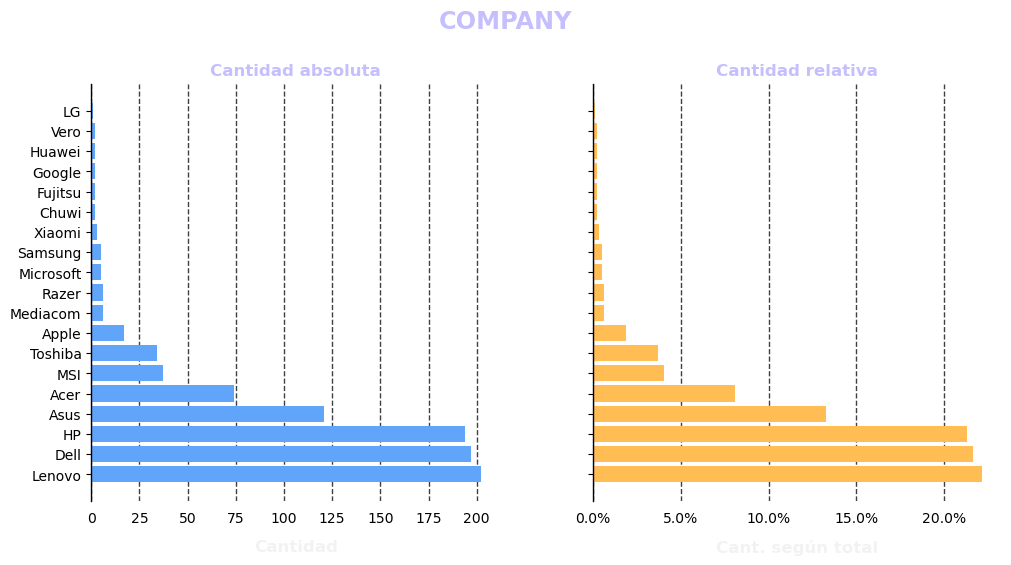

In [47]:
serie = df["Company"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`TypeName`**

In [48]:
notebook_types = df["TypeName"].unique()
print(f"Contamos con {len(notebook_types)} tipos de notebooks")

Contamos con 6 tipos de notebooks


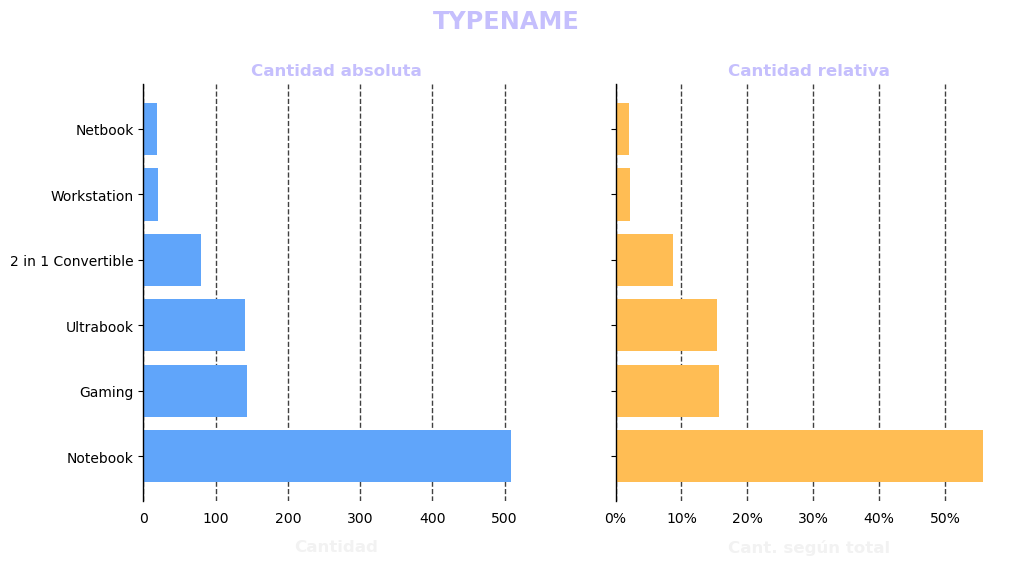

In [49]:
serie = df["TypeName"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`Inches`**

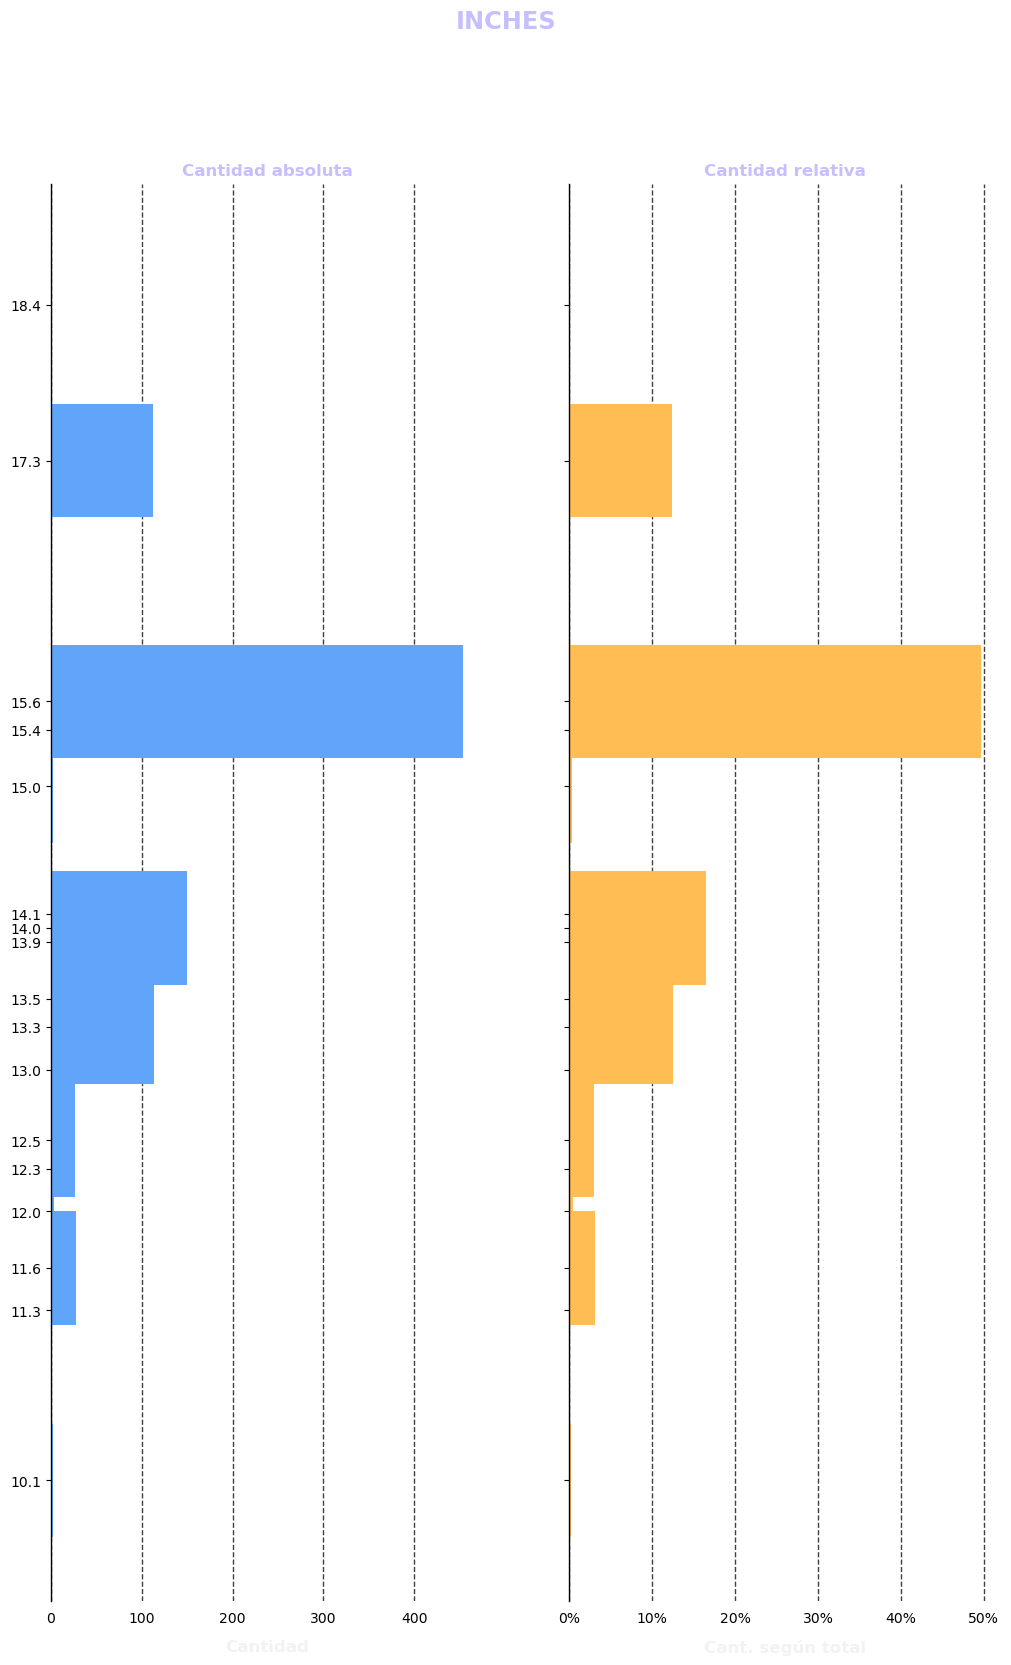

In [50]:
serie = df["Inches"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 15),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`OpSys`**

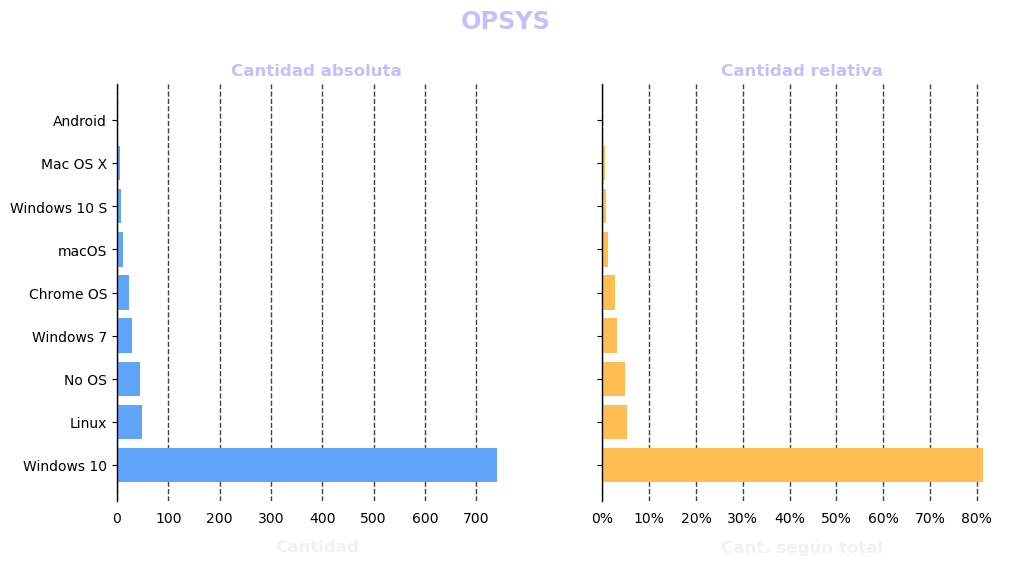

In [51]:
serie = df["OpSys"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

Tenemos distintas versiones de sistemas operativos. Tal vez, sería mejor agruparlos por proveedor y no por versión del mismo.

##### **`Weight`**

In [52]:
def filter_outliers(serie: pd.Series,
					whisker: float | None=1.75,
					below_zero=False):
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	filtered = serie[mask]
	return filtered

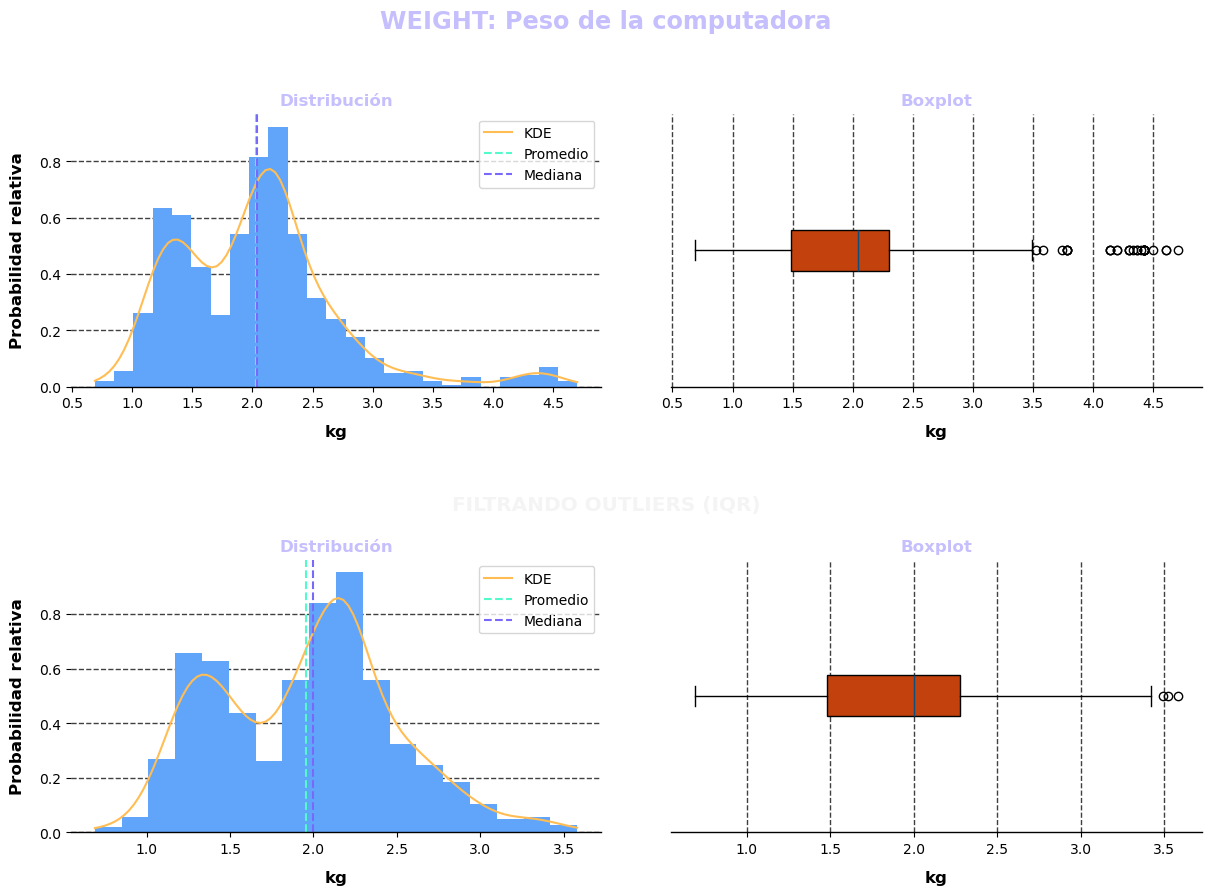

In [53]:
serie = df["Weight"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Peso de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`Price`**

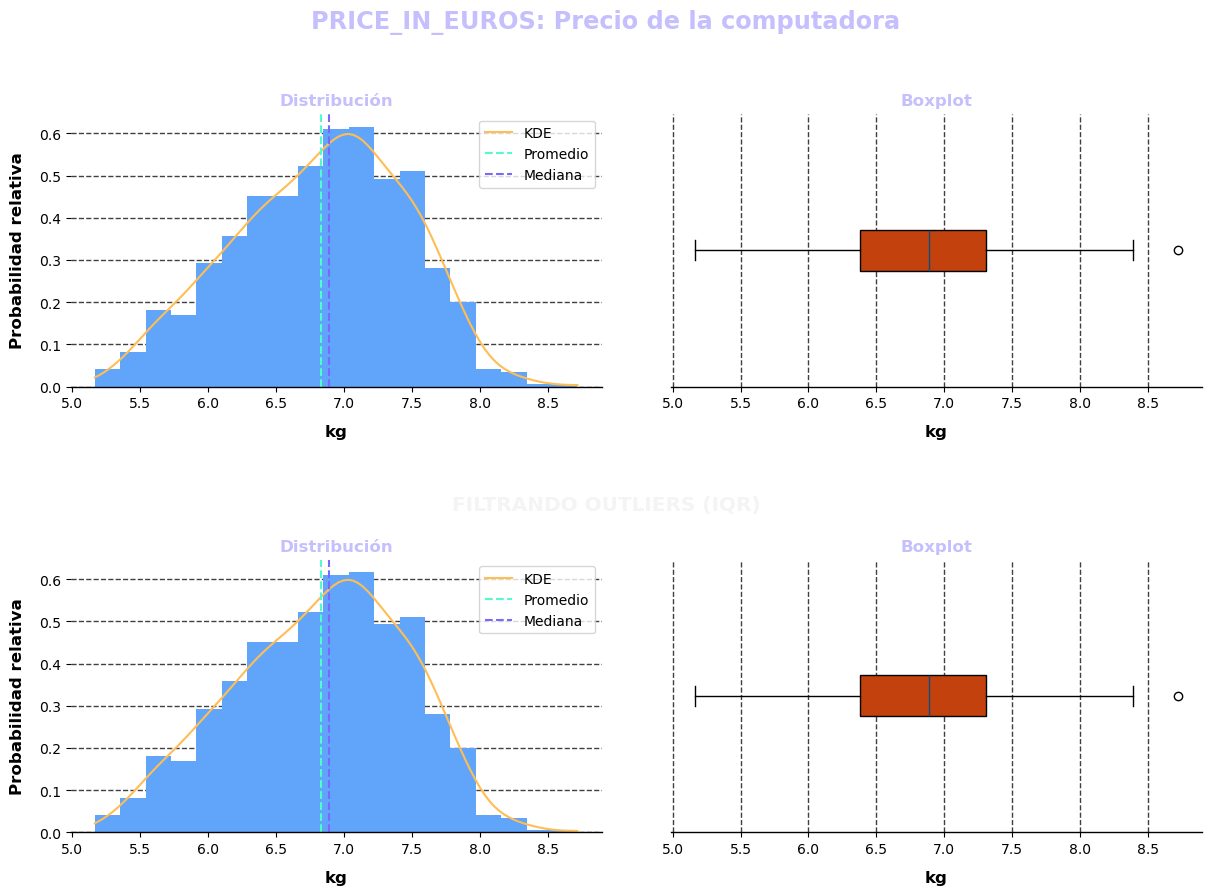

In [54]:
serie = np.log1p(df["Price_in_euros"])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Precio de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

La distribución tiene una larga cola hacía la derecha

##### **`Screen`**

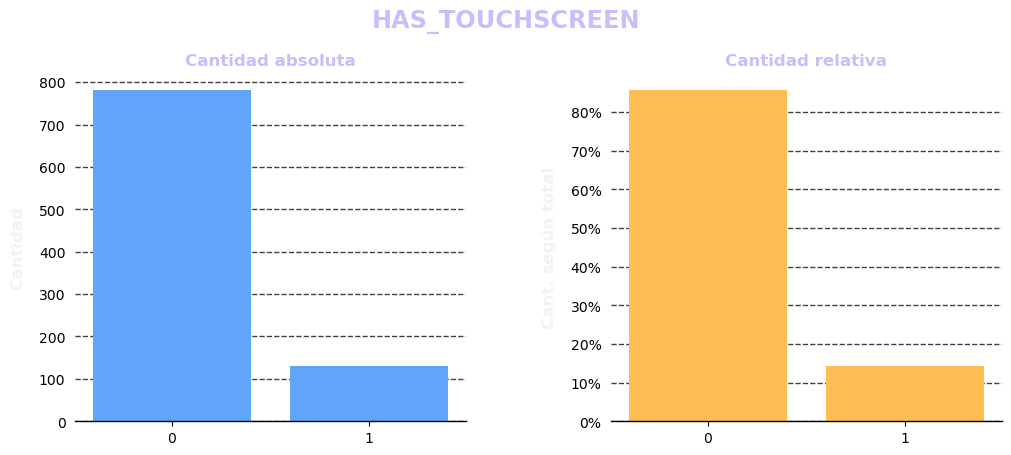

In [55]:
plot_category(df["has_touchscreen"])

In [56]:
screen_types = df["screen_type"].unique()
print(f"Contamos con {len(screen_types)} TIERs según la resolución de pantallas")

Contamos con 7 TIERs según la resolución de pantallas


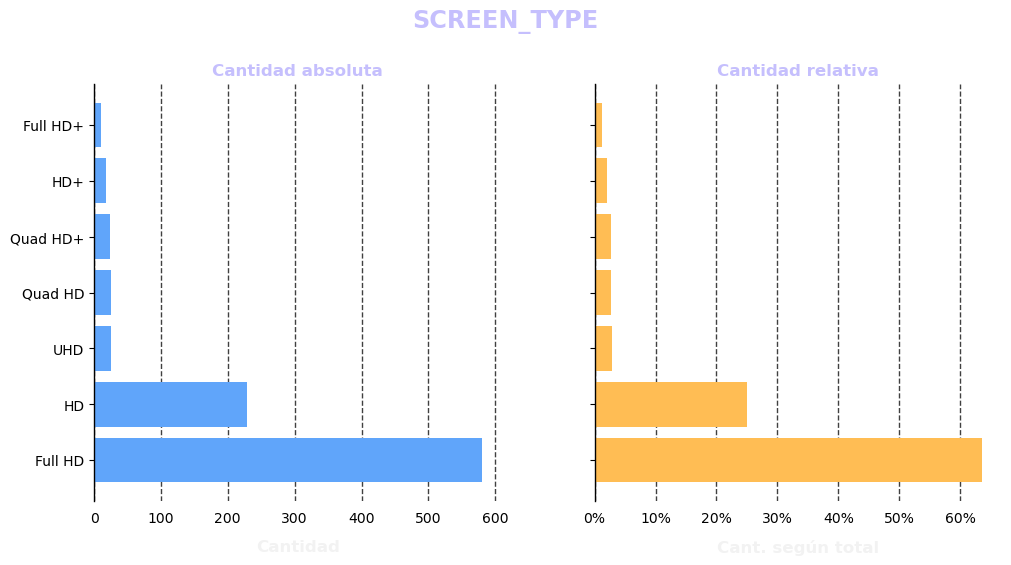

In [57]:
serie = df["screen_type"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

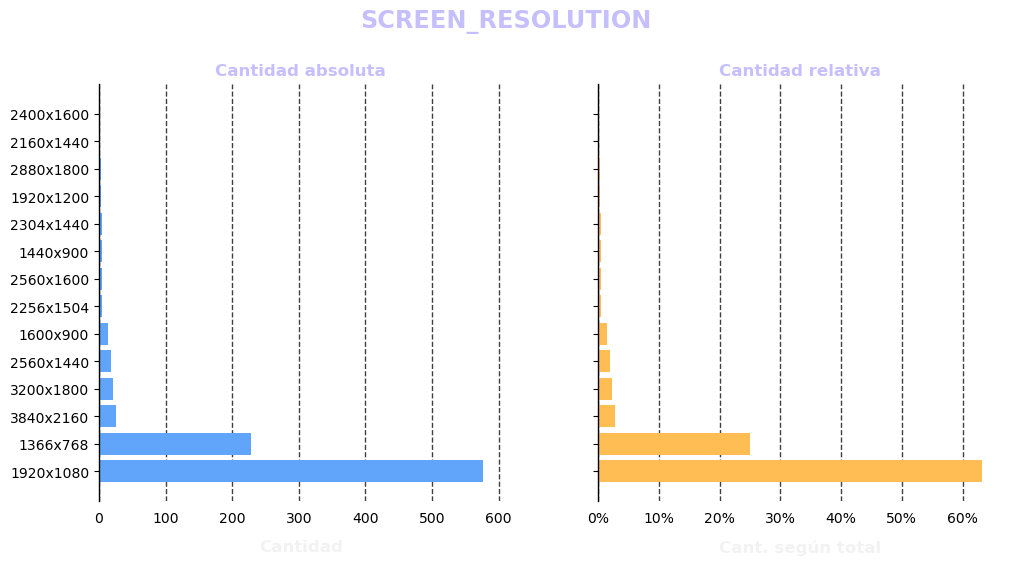

In [58]:
serie = df["screen_resolution"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`CPU`**

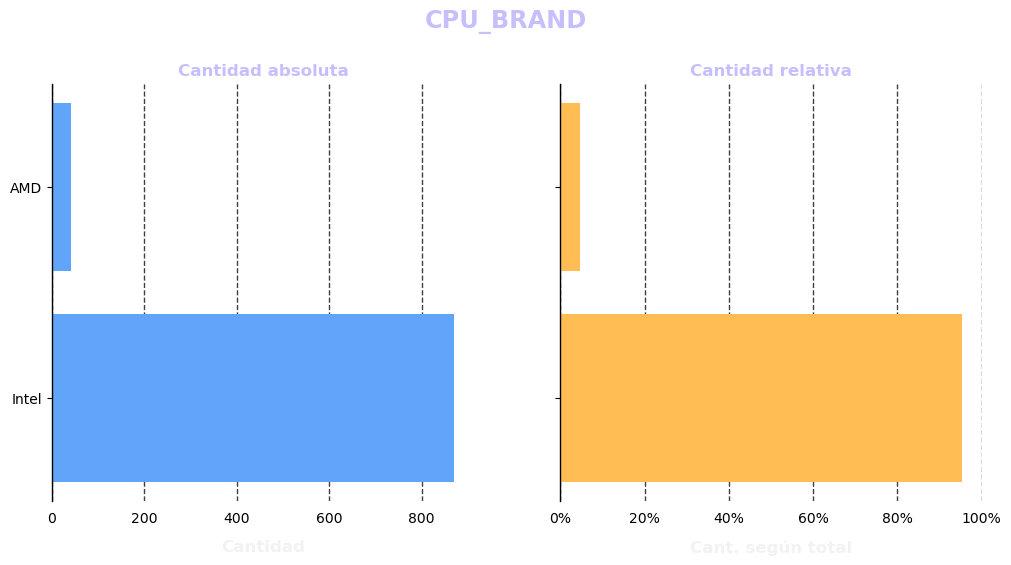

In [59]:
serie = df["cpu_brand"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

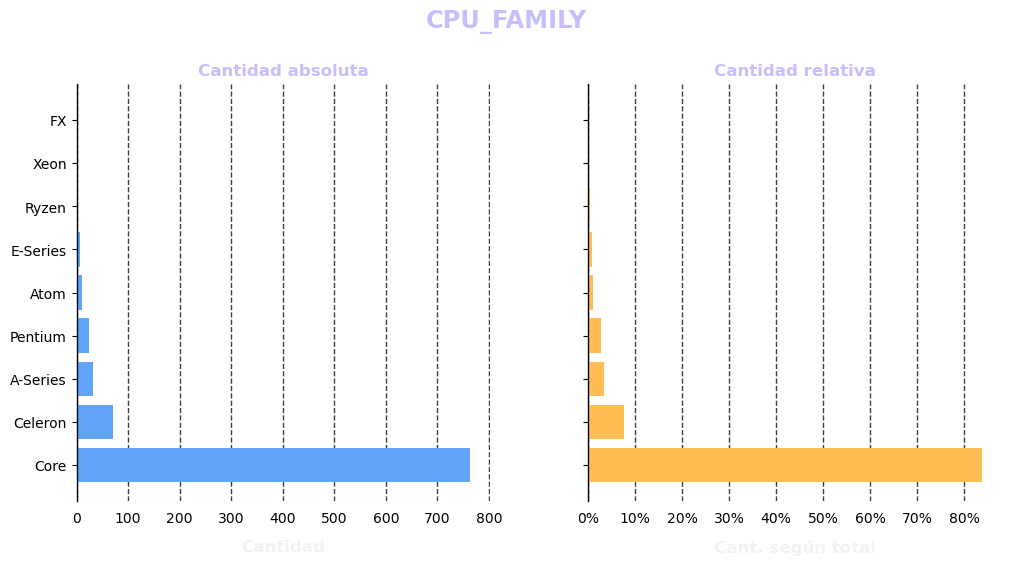

In [60]:
serie = df["cpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

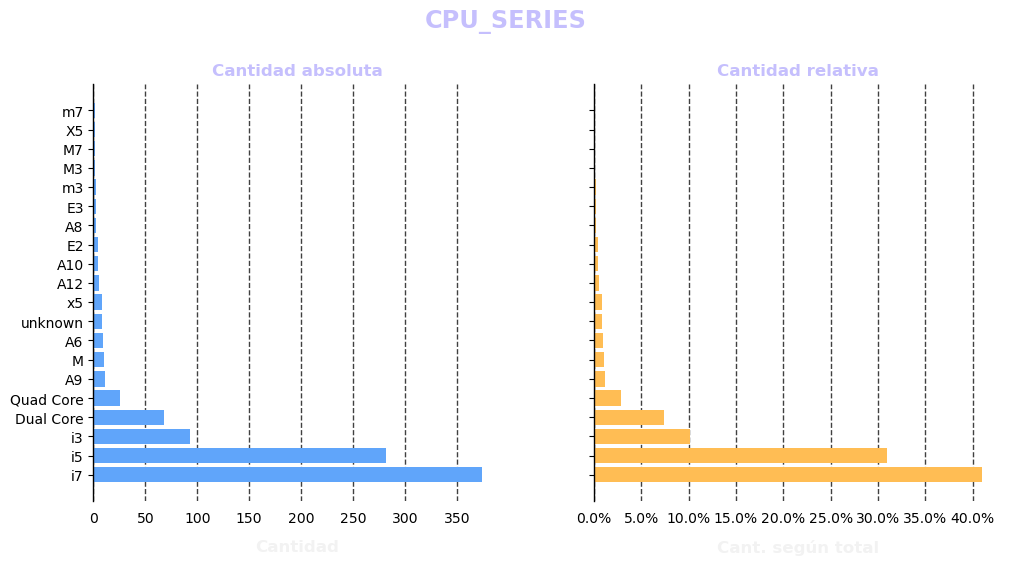

In [61]:
serie = df["cpu_series"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

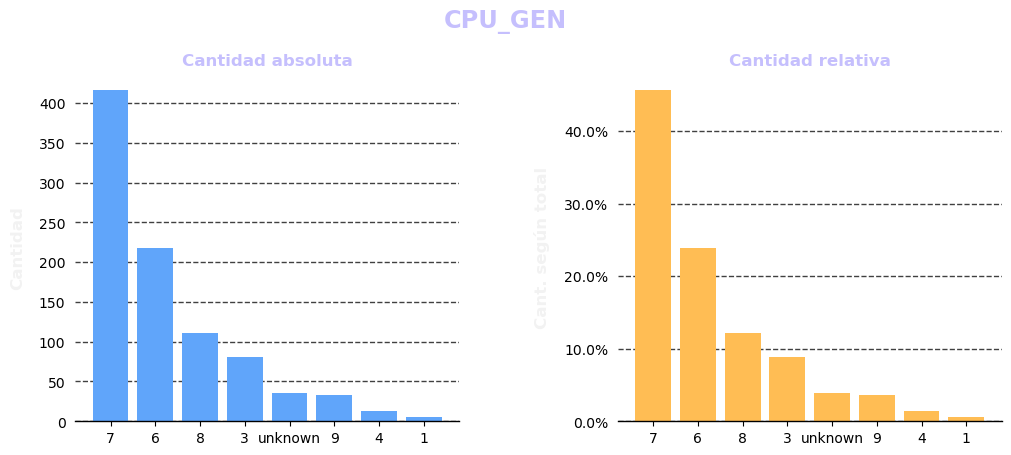

In [62]:
plot_category(df["cpu_gen"])

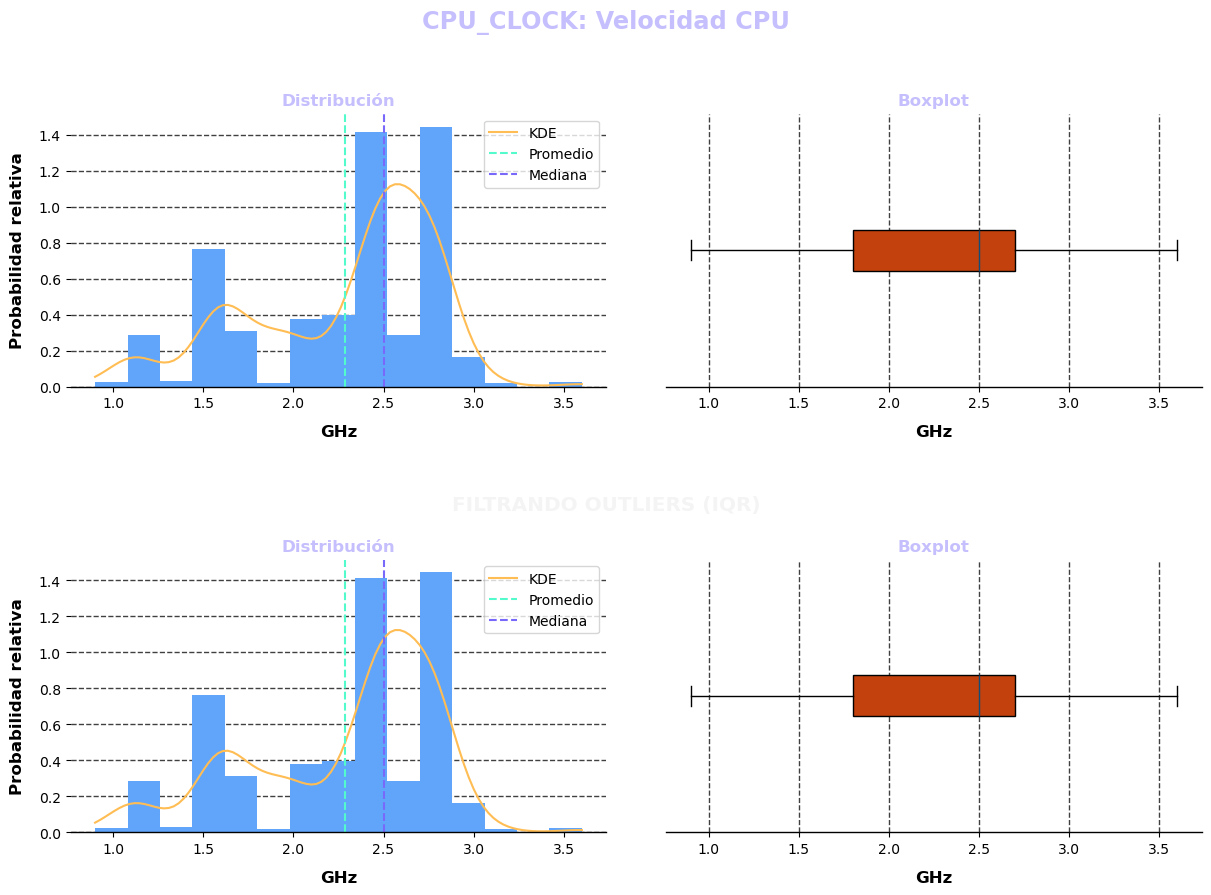

In [63]:
serie = df["cpu_clock"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Velocidad CPU",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`RAM`**

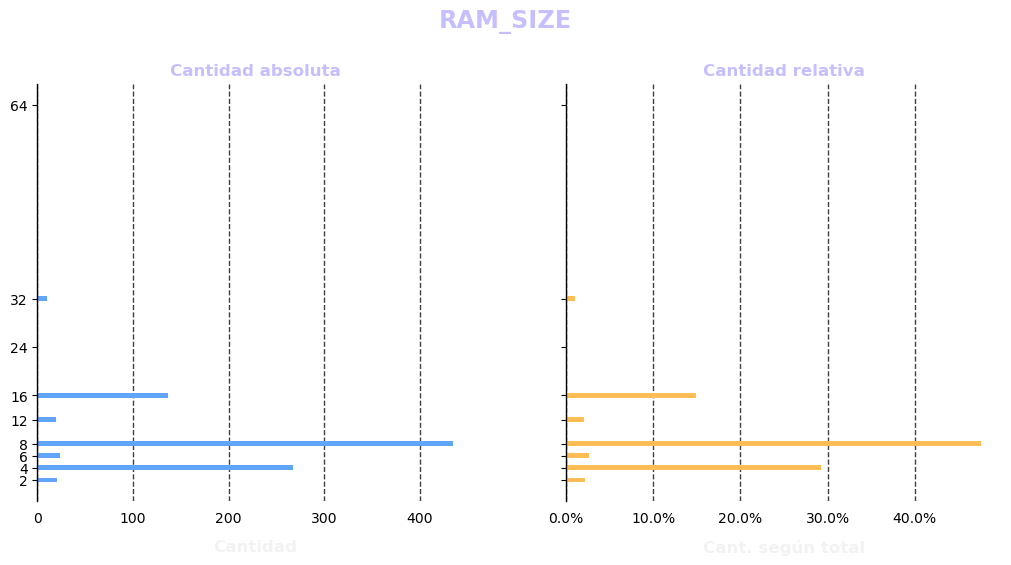

In [64]:
#plot_category(df["ram_size"])
serie = df["ram_size"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`HDD`**

Una transformación que debemos hacer con la información de `hard drive disc` es homogeneizar las unidades de medida de los datos.

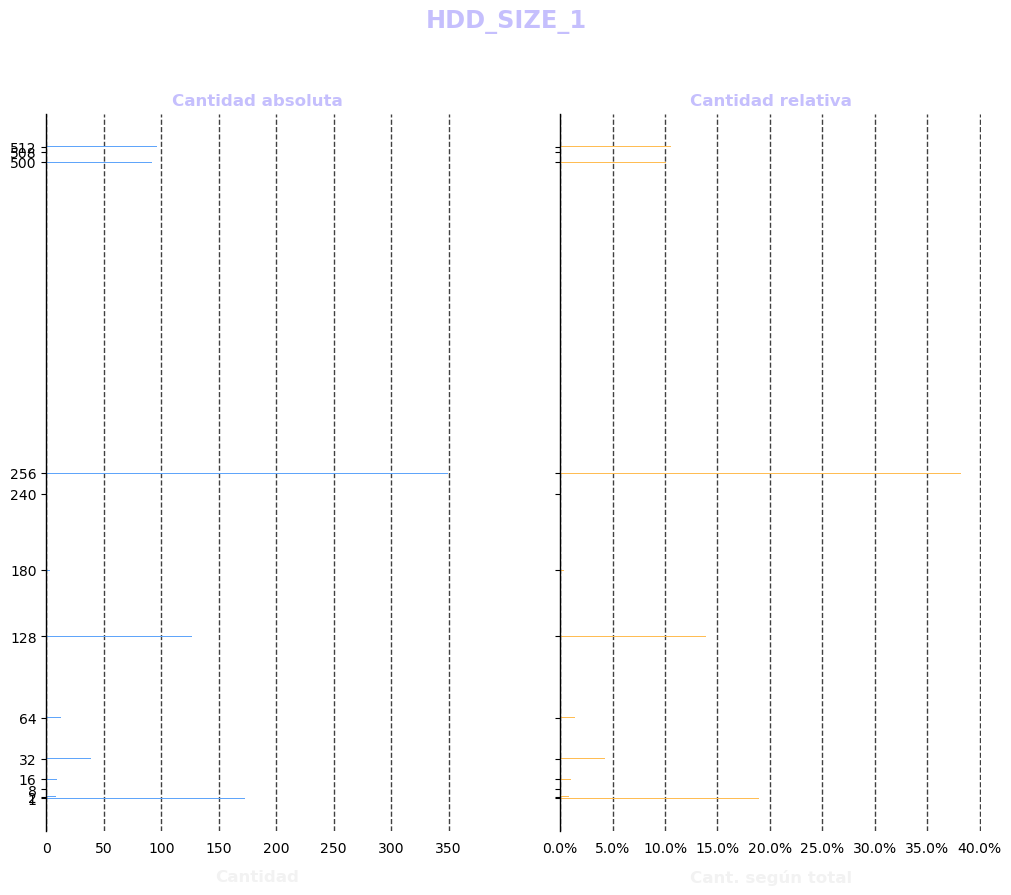

In [65]:
#plot_category(df["hdd_size_1"])
serie = df["hdd_size_1"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

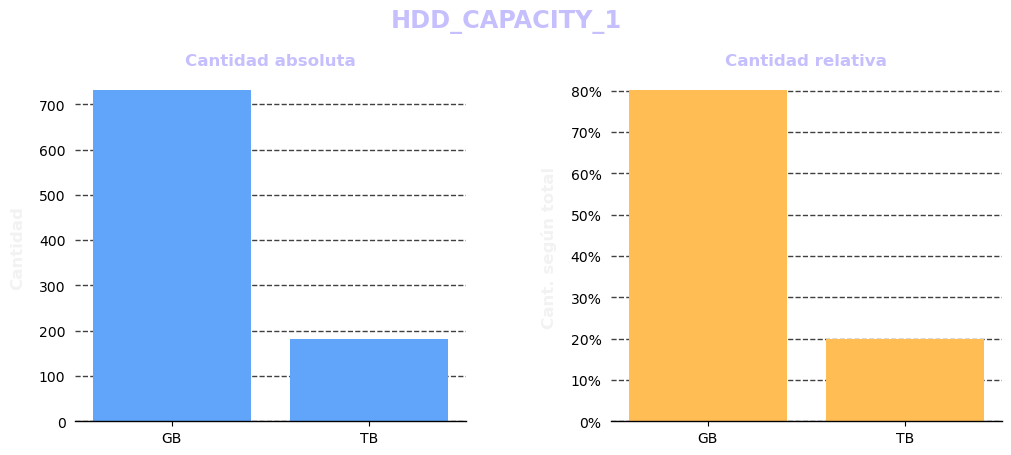

In [66]:
plot_category(df["hdd_capacity_1"])

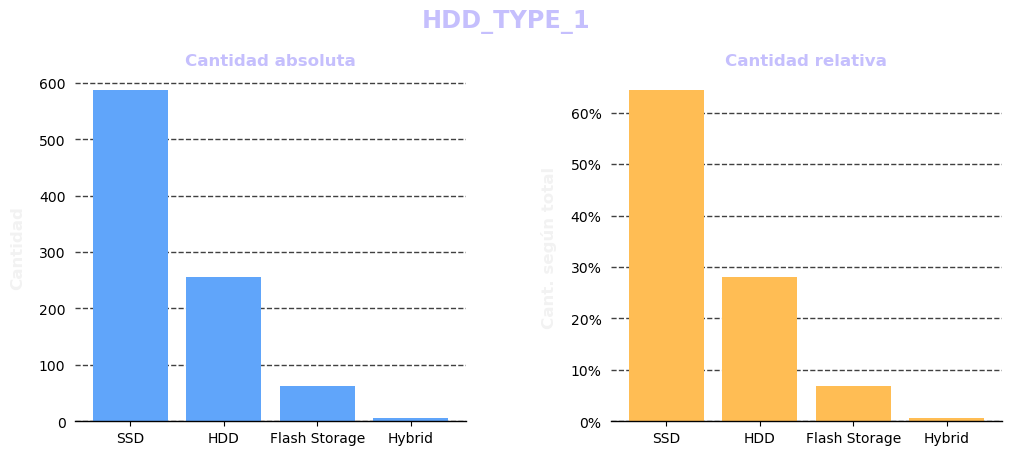

In [67]:
plot_category(df["hdd_type_1"])

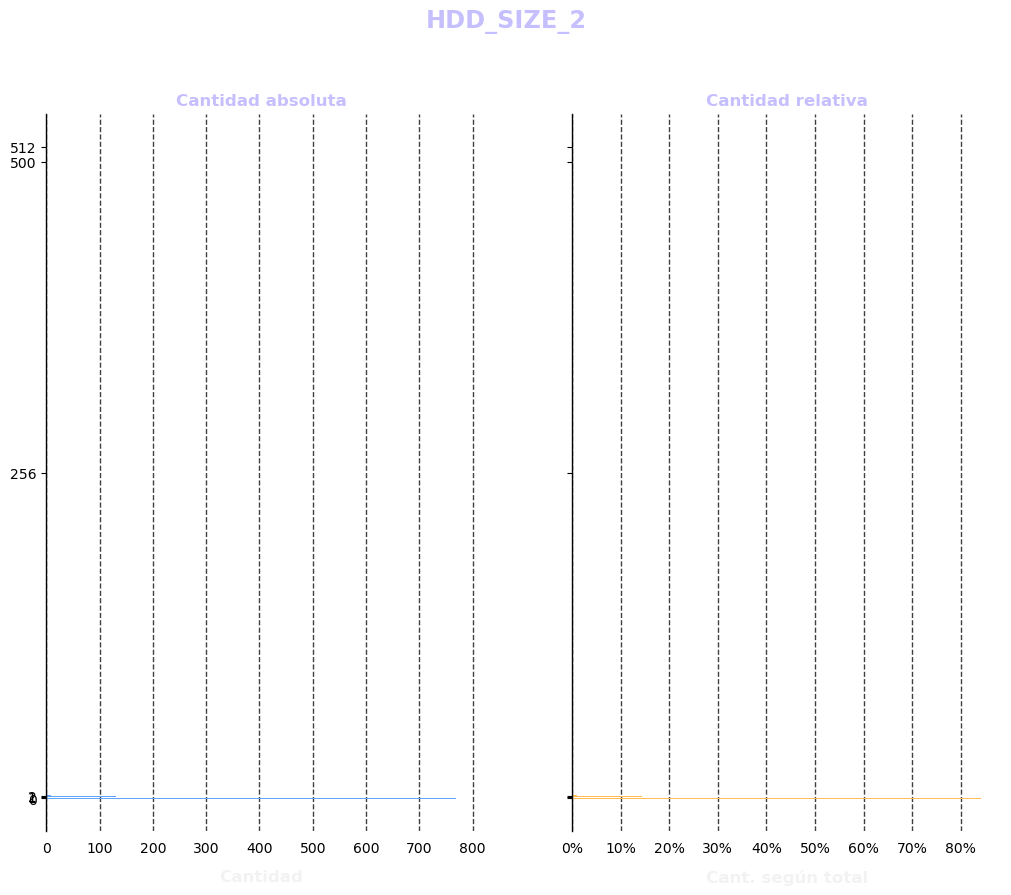

In [68]:
#plot_category(df["hdd_size_2"])
serie = df["hdd_size_2"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

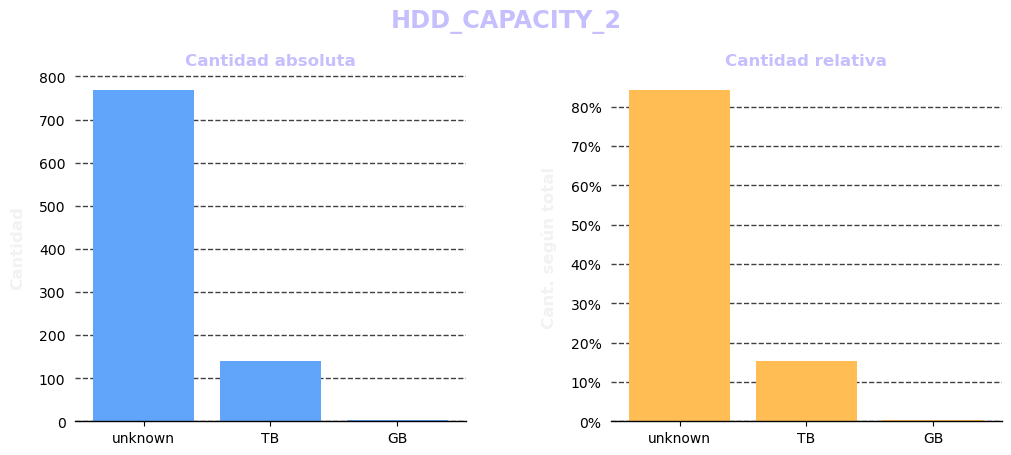

In [69]:
plot_category(df["hdd_capacity_2"])

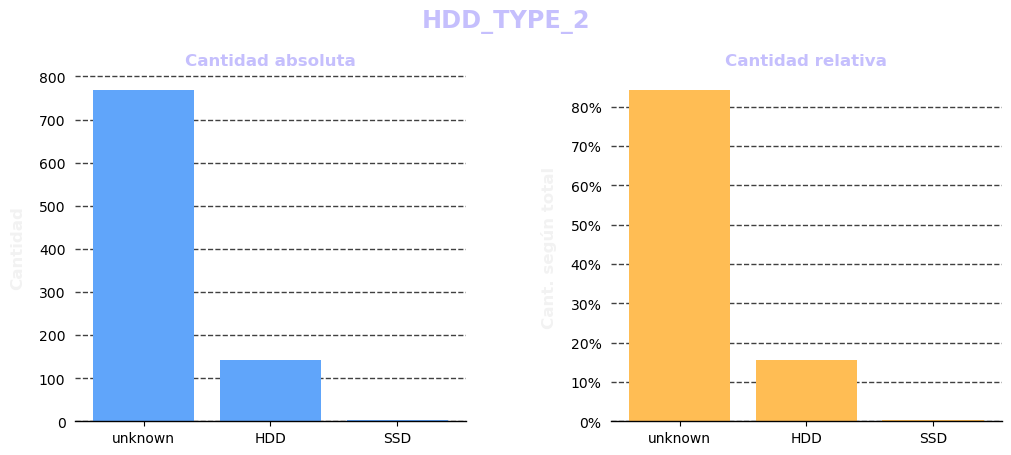

In [70]:
plot_category(df["hdd_type_2"])

##### **`GPU`**

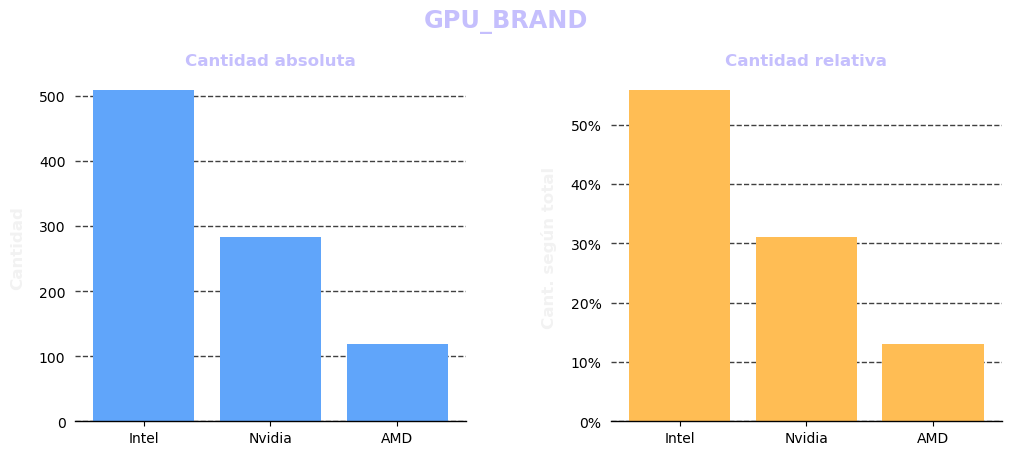

In [71]:
plot_category(df["gpu_brand"])

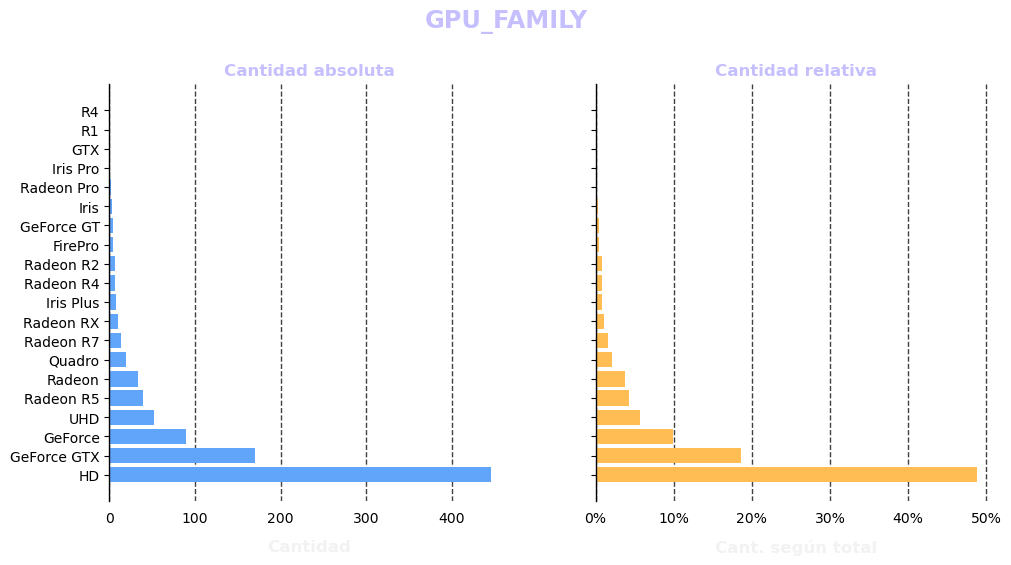

In [72]:
serie = df["gpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

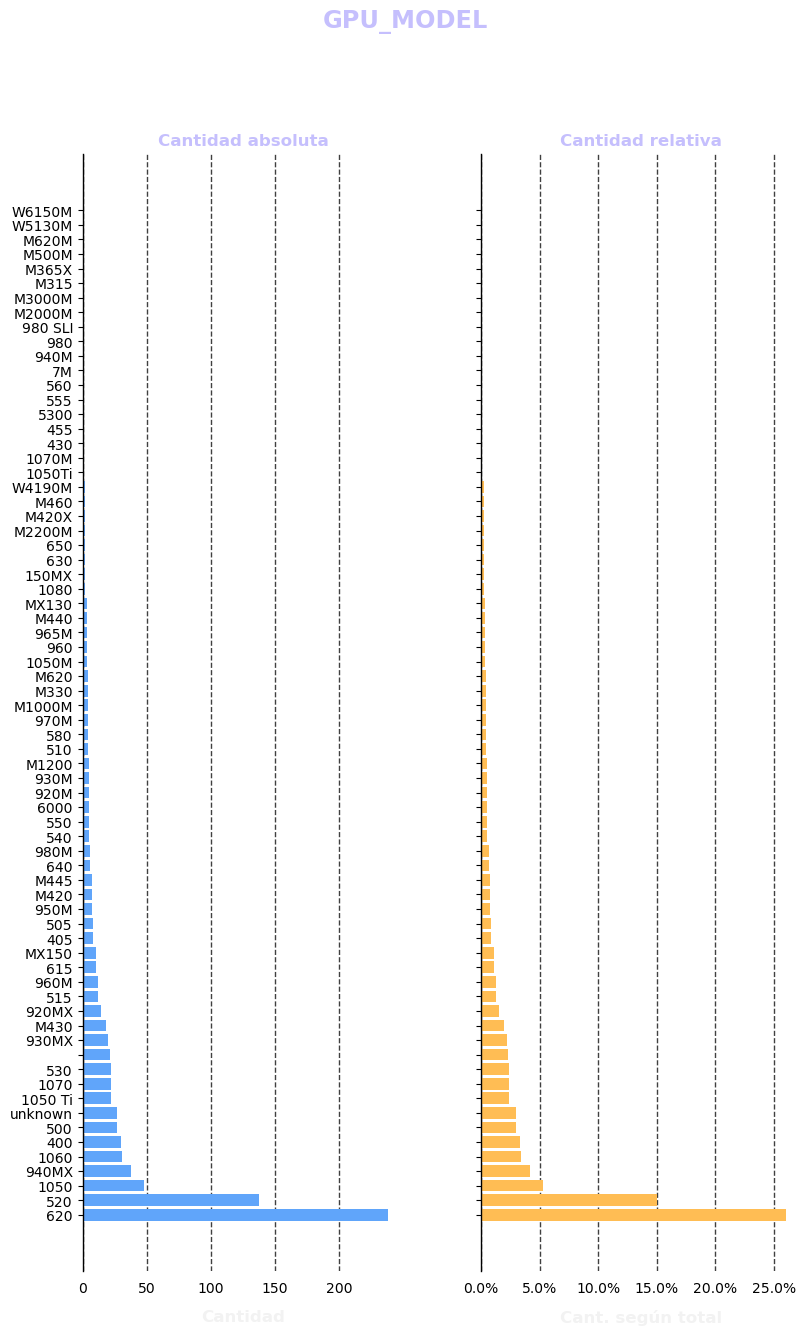

In [73]:
serie = df["gpu_model"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(8, 12),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",

			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### Final tweaks

Normalizamos los nombres de los sistemas operativos.

In [74]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

df.replace(maps, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

       OpSys  Weight  Price_in_euros  has_touchscreen screen_panel  ...  \
0    Windows    1.86          539.00            False      unknown  ...   
1    Windows    2.59          879.01            False      unknown  ...   
2    Windows    2.04          900.00            False      unknown  ...   
3      macOS    1.34          898.94            False      unknown  ...   
4      Linux    2.25          428.00            False      unknown  ...   
..       ...     ...             ...              ...          ...  ...   
907  Windows    2.20          800.00            False      unknown  ...   
908  Windows    1.48         1629.00             True      unknown  ...   
909    No OS    2.20          519.00            False      unknown  ...   
910    No OS    1.86          258.00            False      unknown  ...   
911  Windows    4.42         2456.34            False    IPS Panel  ...   

    ram_capacity hdd_size_1  hdd_capacity_1     hdd_type_1  hdd_size_2  \
0             GB        256              GB            SSD           0   
1             GB          1              TB            HDD           0   
2             GB          1              TB            HDD           0   
3             GB        128              GB  Flash Storage           0   
4             GB          1              TB            HDD           0   
..           ...        ...             ...            ...         ...   
907           GB        256              GB            SSD           0   
908           GB        256              GB            SSD           0   
909           GB          2              TB            HDD           0   
910           GB        500              GB            HDD           0   
911           GB        256              GB            SSD           1   

    hdd_capacity_2 hdd_type_2 gpu_brand   gpu_family  gpu_model  
0          unknown    unknown     Intel           HD        520  
1          unknown    unknown    Nvidia  GeForce GTX        960  
2          unknown    unknown    Nvidia      GeForce      930MX  
3          unknown    unknown     Intel           HD       6000  
4          unknown    unknown       AMD    Radeon R5       M430  
..             ...        ...       ...          ...        ...  
907        unknown    unknown       AMD       Radeon        530  
908        unknown    unknown     Intel           HD        520  
909        unknown    unknown     Intel           HD        620  
910        unknown    unknown       AMD    Radeon R2             
911             TB        HDD    Nvidia  GeForce GTX       1060  

[912 rows x 31 columns]

Normalizamos las unidades de medida en los `hard-drive disc`.

In [75]:
factor = {"GB": 1, "TB": 1024}
df["hdd_size_1"] = df["hdd_size_1"] * df["hdd_capacity_1"].map(factor).astype(int)

In [76]:
df["hdd_size_2"] = df["hdd_size_2"].astype(float)

conditions = [
	df["hdd_capacity_2"].str.lower() == "gb",
	df["hdd_capacity_2"].str.lower() == "tb",
	df["hdd_capacity_2"].isna()
]

choices = [
	df["hdd_size_2"] * 1,
	df["hdd_size_2"] * 1024,
	np.nan
]

df["hdd_size_2"] = np.select(conditions,
							 choices,
							 default=df["hdd_size_2"])

In [77]:
df["hdd_capacity_1"] = df["hdd_capacity_1"].str.replace("TB", "GB")
df["hdd_capacity_2"] = df["hdd_capacity_2"].str.replace("TB", "GB")

Completamos con cero aquellos registros dónde no tenemos un segundo disco duro.

In [78]:
df.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)

In [79]:
df.head().iloc[:, 10:]

screen_type screen_resolution  screen_width  screen_height  screen_ppi  \
0     Full HD         1920x1080          1920           1080      141.21   
1     Full HD         1920x1080          1920           1080      141.21   
2     Full HD         1920x1080          1920           1080      141.21   
3         HD+          1440x900          1440            900      127.68   
4     Full HD         1920x1080          1920           1080      141.21   

  cpu_brand cpu_family cpu_series  cpu_gen  cpu_clock  ram_size  hdd_size_1  \
0     Intel       Core         i3        6        2.0         8         256   
1     Intel       Core         i7        6        2.6        16        1024   
2     Intel       Core         i7        7        2.7         8        1024   
3     Intel       Core         i5  unknown        1.8         8         128   
4     Intel       Core         i3        6        2.0         4        1024   

      hdd_type_1  hdd_size_2 hdd_type_2 gpu_brand   gpu_family gpu_model  
0            SSD         0.0    unknown     Intel           HD       520  
1            HDD         0.0    unknown    Nvidia  GeForce GTX       960  
2            HDD         0.0    unknown    Nvidia      GeForce     930MX  
3  Flash Storage         0.0    unknown     Intel           HD      6000  
4            HDD         0.0    unknown       AMD    Radeon R5      M430

#### Guardado de datos

Creamos una nueva columna de targetas gráficas integradas y las que no. Normalmente, todas las gráficas de Intel son integradas.

In [82]:
df["gpu_integrated"] = df["gpu_brand"].str.contains("intel", case=False)
df["has_hdd2"] = df["hdd_size_2"] != 0

In [83]:
df["OpSys"] = df["OpSys"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")

In [84]:
df.set_index("laptop_ID", inplace=True)
df.to_csv(path_or_buf=f"{path}/checkpoint.csv", index=True)

### Definir X e y

In [85]:
path = "./data"
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
df = pd.read_csv(filepath_or_buffer=f"{path}/checkpoint.csv",
				 index_col="laptop_ID")

In [84]:
df.info()

<class 'pandas.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            912 non-null    str    
 1   Product            912 non-null    str    
 2   TypeName           912 non-null    str    
 3   Inches             912 non-null    float64
 4   OpSys              912 non-null    str    
 5   Weight             912 non-null    float64
 6   Price_in_euros     912 non-null    float64
 7   has_touchscreen    912 non-null    bool   
 8   screen_panel       912 non-null    str    
 9   screen_type        912 non-null    str    
 10  screen_resolution  912 non-null    str    
 11  screen_width       912 non-null    int64  
 12  screen_height      912 non-null    int64  
 13  screen_ppi         912 non-null    float64
 14  cpu_brand          912 non-null    str    
 15  cpu_family         912 non-null    str    
 16  cpu_series         912 non-null    str  

### Dividir X_train, X_test, y_train, y_test

In [86]:
df.rename(str.lower, axis="columns", inplace=True)
df.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [87]:
df_train, df_test = train_test_split(
	df,
	test_size=.2,
	random_state=42,
	shuffle=True)
df_train

company                         product     typename  inches  \
laptop_ID                                                                
1118           HP                        ZBook 17  Workstation    17.3   
153          Dell                   Inspiron 5577       Gaming    15.6   
275         Apple                     MacBook Pro    Ultrabook    13.3   
1100           HP                   EliteBook 840     Notebook    14.0   
131          Dell                   Inspiron 5770     Notebook    17.3   
...           ...                             ...          ...     ...   
578            HP  14-am079na (N3710/8GB/2TB/W10)     Notebook    14.0   
996        Lenovo               IdeaPad 320-15ABR     Notebook    15.6   
770          Dell                   Latitude 7280    Ultrabook    12.5   
407        Lenovo               IdeaPad 320-15IAP     Notebook    15.6   
418        Lenovo                  Thinkpad T470p    Ultrabook    14.0   

                os  weight    price  has_touchscreen screen_panel screen_type  \
laptop_ID                                                                       
1118       Windows    3.00  2899.00            False    IPS Panel     Full HD   
153        Windows    2.56  1249.26            False      unknown     Full HD   
275          macOS    1.37  1958.90            False    IPS Panel     Quad HD   
1100       Windows    1.54  1030.99            False      unknown     Full HD   
131        Windows    2.80  1396.00            False      unknown     Full HD   
...            ...     ...      ...              ...          ...         ...   
578        Windows    1.94   389.00            False      unknown          HD   
996        Windows    2.20   549.00            False      unknown     Full HD   
770        Windows    1.18  1859.00            False      unknown     Full HD   
407        Windows    2.20   306.00            False      unknown          HD   
418        Windows    1.70  1943.00            False    IPS Panel     Quad HD   

           ... ram_size  hdd_size_1  hdd_type_1  hdd_size_2 hdd_type_2  \
laptop_ID  ...                                                           
1118       ...        8        1024         HDD         0.0    unknown   
153        ...       16         512         SSD         0.0    unknown   
275        ...        8         512         SSD         0.0    unknown   
1100       ...        4         500         HDD         0.0    unknown   
131        ...       16         256         SSD      2048.0        HDD   
...        ...      ...         ...         ...         ...        ...   
578        ...        8        2048         HDD         0.0    unknown   
996        ...        6         256         SSD         0.0    unknown   
770        ...       16         256         SSD         0.0    unknown   
407        ...        4        1024         HDD         0.0    unknown   
418        ...        8         512         SSD         0.0    unknown   

          gpu_brand   gpu_family gpu_model  gpu_integrated  has_hdd2  
laptop_ID                                                             
1118            AMD      FirePro    W6150M           False     False  
153          Nvidia  GeForce GTX      1050           False     False  
275           Intel         Iris       550            True     False  
1100          Intel           HD       520            True     False  
131             AMD       Radeon       530           False      True  
...             ...          ...       ...             ...       ...  
578           Intel           HD       405            True     False  
996             AMD       Radeon       530           False     False  
770           Intel           HD       620            True     False  
407           Intel           HD       500            True     False  
418          Nvidia   GeForce GT     940MX           False     False  

[729 rows x 29 columns]

In [88]:
df_train["log_price"] = np.log1p(df_train["price"])
df_test["log_price"] = np.log1p(df_test["price"])

### Análisis Multivariante
#### Distribución de `Price` según `Company`

In [ ]:
sns.color_palette("Set3")
sns.set_style("whitegrid")

In [ ]:
fig, axs = plt.subplots(nrows=2,
						ncols=2,
						figsize=(15, 10),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Company",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="company",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Violinplot", color="#003049", fontdict=font_config)
sns.violinplot(data=df_train,
			   y="log_price",
			   inner="quart",
			   hue="company",
			   palette="deep",
			   ax=axs[0][1])
sns.despine(ax=axs[0][1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("company", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Standard Deviation",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std"]
).sort_values(by="median")
sns.barplot(data=data,
			x="std",
			y=data.index,
			ax=axs[1][0])
sns.despine(ax=axs[1][0])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("company", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Variance",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std", "var"]
).sort_values(by="median")
sns.barplot(data=data,
			x="var",
			y=data.index,
			ax=axs[1][1])
sns.despine(ax=axs[1][1])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("company", labelpad=10, fontdict=font_config)
fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `company`

In [ ]:
df_train.groupby(by="company")["price"].agg(
	["count", "mean", "median", "min", "max", "std", "var"]
).sort_values(by="median")

La notebook más cara sale €6.099 y corresponde a la marca `Razer`. La más económica corresponde a la marca `Asus` y cuesta €191.90.

La mediana de `price` del fabricante `Razer` es la más alta entre los 19 fabricantes de pc que tenemos. De todas maneras, también hay que destacar que solo contamos con 4 registros de dicha marca.

#### Distribución de `Price` según `TypeName`

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según TypeName",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="typename",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="typename",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `typename`.

In [ ]:
df_train.groupby(by=["typename"])["price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

Siguiendo lo mencionado anteriormente, la computadora más cara corresponde al segmento `Gaming` y la más económica al segmento `Netbook`.

La mediana es consitente entre `ultrabook`, `gaming` y las `2 in 1 convertible`. A su vez, podemos ver que la desviación estandar al igual que la varianza en las notebooks de `Workstation` y `Gaming` es muy alta.

#### Distribución de `Price` según `Inches`

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Inches",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="inches",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="inches",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Al parecer, la distribución del precio de las laptops con pantallas de 17.3" tiene una cola hacía la derecha, dejando entrever que pueden alcanzar precios elevados.

In [ ]:
df_train.groupby("inches")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
])

#### Distribución de `Price` según `OS`

In [ ]:
fig, axs = plt.subplots(nrows=2,
						ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Operatin System",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="os",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="os",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [ ]:
df_train.groupby("os")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="median")

Resulta interesante, aunque no es revelador, como el precio de dispositivos del ecosistema `Apple` tienen una mediana y media de precio más elevado, aunque la desviación estandar al igual que la varianza sea menor.

Esto nos indica claramente que son equipos más caro en relación a otros ecosistemas.


Otra cosa que podemos observar es que aquellos equipos que no poseen sistema operativo tienen unos estadísticos similares al ecosistema `Linux`. Son equipos bastante más económicos. Deberíamos analizar sí en prestaciones las pc poseen gran diferencia respecto a los otros ecosistemas, en caso de no ser así, tal vez, el hecho de tener un so instalado, libre y gratuito, o no pueda influir en el precio.

#### Distribución de `Price` según `Weight`

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Weight",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x="weight",
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)
ax.grid(axis="both", visible=False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("weight (kg)", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
plt.show()

Las notebooks del segmento `Gaminig` tienden a pesar más que las pertenecientes a otros segmentos. Lo mismo sucede con las `Ultrabook`, que son más ligeras en general. Las `netbooks` son las que menos pesan y las que menos cuestan.

#### Distribución de `Price` según `Screen`

In [ ]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["type", "has_touchscreen"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según screen",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["type"].set_title("price según screen_type",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="screen_type",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["type"])
sns.despine(ax=axs["type"])
axs["type"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["type"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["type"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["type"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_touchscreen"].set_title("price según has_touchscreen",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_touchscreen",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_touchscreen"])
sns.despine(ax=axs["has_touchscreen"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_touchscreen"].set_xlabel("price (€)",
								  labelpad=10,
								  fontdict=font_config)
axs["has_touchscreen"].set_ylabel("probability",
								  labelpad=10,
								  fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según screen_resolution",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="screen_resolution",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("resolutions",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según pixel per inch",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y=np.log1p(df["screen_ppi"]),
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("pixel per inch", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [ ]:
df_train.groupby("screen_ppi")["log_price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="screen_ppi")

Podemos ver que existe correlación entre los `pixel per inch` y el `price` del dispositivo. También se puede observar como aquellos equipos que tiene pantalla táctil tienen un precio más eleveda por lo general.

#### Distribución de `Price` según `CPU`

In [ ]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "family"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_brand",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según cpu brand",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según cpu_family",
								 color="#003049",
								 fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_family",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["family"])
sns.despine(ax=axs["family"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según cpu_family",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_family",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("cpu_family",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según cpu_clock",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y="cpu_clock",
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("cpu_clock (GHz)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Aquí podemos observar que existe una correlación entre el `price` del dispositivo y la velocidad del procesador `cpu_clock`. También podemos notar como el fabricante del cpu al igual que la familia del mismo tiene una influencia en el precio.

In [ ]:
df_train.groupby("screen_ppi")["log_price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="screen_ppi")

> No le hemos podido sacar demasiado partido a la generación del `cpu`. Como una posible línea de trabajo futura, es algo a lo que se le debería hacer foco para conseguir un mejor rendimiento del modelo.

In [ ]:
df_train["cpu_gen"].isna().value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_series",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_series",
			palette="deep",
			ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("cpu_series", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

#### Distribución de `Price` según `RAM`

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según ram",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x=np.log2(df["ram_size"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("ram", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

Podemos observar que hay una correlación muy fuerte entre la cantidad de memoria del dispositivo y su precio.

#### Distribución de `Price` según `HDD`

In [ ]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["hdd_type_1", "hdd_type_2"],
	["has_second_hdd", "has_second_hdd"],
	["hdd_capacity_1", "hdd_capacity_1"],
	["hdd_capacity_2", "hdd_capacity_2"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según hard-drive disc",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_1"].set_title("price según hdd_type 1",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_1",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_1"])
sns.despine(ax=axs["hdd_type_1"])
axs["hdd_type_1"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_1"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_2"].set_title("price según hdd_type_2",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_2"])
sns.despine(ax=axs["hdd_type_2"])
axs["hdd_type_2"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_2"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_2"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_second_hdd"].set_title("price según has_second_hdd",
								color="#003049",
								fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_hdd2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_second_hdd"])
sns.despine(ax=axs["has_second_hdd"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_second_hdd"].set_xlabel("price (€)",
								 labelpad=10,
								 fontdict=font_config)
axs["has_second_hdd"].set_ylabel("probability",
								 labelpad=10,
								 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_1"].set_title("price según hdd_size_1",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_1"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_1"])
sns.despine(ax=axs["hdd_capacity_1"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_1"].set_xlabel("hdd_size_1",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_1"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_2"].set_title("price según hdd_size_2",
								color="#003049",
								fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_2"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_2"])
sns.despine(ax=axs["hdd_capacity_2"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_2"].set_xlabel("hdd_size_2",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_2"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

Luego de haber realizado el análisis de la información en el `hard-drive disc` podemos ver que el tipo de hdd puede influir en el precio. Lo mismo sucede en caso de que contemos con notebooks con dos `hdd`.

Diferente es lo que pasa al tamaño del hdd. Antes, habiamos visto una fuerte correlación entre el tamaño de la memoria `RAM` y el precio del dispositivo, en este caso, la capacidad del disco no tiene tanta relevancia.

In [ ]:
np.corrcoef(df_train["log_price"], np.log2(df_train["hdd_size_1"]))

#### Distribución de `Price` según `GPU`

In [ ]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "integrated"],
	["family", "family"],
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según gpu",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según gpu_brand",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["integrated"].set_title("price según gpu_integrated",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_integrated",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["integrated"])
sns.despine(ax=axs["integrated"])
axs["integrated"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["integrated"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["integrated"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según gpu_family",
						color="#003049",
						fontdict=font_config)
sns.violinplot(data=df_train,
			y="log_price",
			hue="gpu_family",
			palette="deep",
			ax=axs["family"])
sns.despine(ax=axs["family"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_ylabel("gpu_family", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

In [ ]:
df_train.groupby(by=["gpu_brand", "gpu_family"])["log_price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

#### Correlaciones

In [ ]:
columns = df_train.select_dtypes("number").columns
correlations = df_train[columns.drop(["price"])].corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Correlación Pearson",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.heatmap(data=correlations,
			mask=mask,
			annot=True,
			cmap="coolwarm",
			fmt=".2f",
			center=0,
			linewidths=1,
			vmax=1,
			vmin=-1,
			ax=ax)
ax.set_xticks(ax.get_xticks(),
			  labels=correlations.columns,
			  fontsize=12,
			  rotation=90)
ax.set_yticks(ax.get_yticks(), labels=correlations.columns, fontsize=12)
ax.grid(False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
sns.despine(left=True, bottom=True, ax=ax)
plt.show()

Tomando en cuenta las correlaciones, hay algunas variables que debemos eliminar. Estas son:
- `inches`: tiene poca o nula correlación con `price` y una correlación de 0.84 con `weight`.
- `screen_width`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_hegiht`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_ppi`: tiene mucha colinealidad con `screen_height` y `screen_width`. Dependiendo el rendimiento del modelo eligiremos una u otras.

---

## Procesado de datos

In [89]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
								  OrdinalEncoder, FunctionTransformer

from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, \
									RandomizedSearchCV, RepeatedKFold

In [90]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## **Machine Learning**

### **Baseline de modelos**

In [96]:
def plot_feature_importance(serie: pd.Series):
	fig, ax = plt.subplots(figsize=(18, 8), layout="constrained")

	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}
	fig.suptitle(f"{serie.name}".upper(),
				 color="#002147",
				 fontproperties=font_config,
				 y=1.02)


	rect = ax.barh(y=serie.index,
				   width=serie.values,
				   data=serie,
				   color="#60A5FA",
				   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "small",
		"weight": "medium",
	}
	ax.bar_label(rect, fmt="%.4f", padding=2, fontproperties=font_config)

	font_config = {
		"color": "#002147",
		"family": "sans-serif",
		"horizontalalignment": "center",
		"verticalalignment": "center",
		"size": "large",
		"weight": "bold",
	}
	ax.set_ylabel("features", labelpad=10, fontdict=font_config)
	ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
	ax.grid(axis="y", visible=False)
	ax.grid(axis="x",
			alpha=1,
			color="#D4D4D4",
			linestyle="dashed",
			linewidth=1)
	ax.spines[["left", "bottom", "top", "right"]].set_visible(False)
	ax.spines["left"].set_linewidth(1)
	plt.show()

In [92]:
df_train.iloc[:, 10:20]

screen_resolution  screen_width  screen_height  screen_ppi  \
laptop_ID                                                              
1118              1920x1080          1920           1080      127.34   
153               1920x1080          1920           1080      141.21   
275               2560x1600          2560           1600      226.98   
1100              1920x1080          1920           1080      157.35   
131               1920x1080          1920           1080      127.34   
...                     ...           ...            ...         ...   
578                1366x768          1366            768      111.94   
996               1920x1080          1920           1080      141.21   
770               1920x1080          1920           1080      176.23   
407                1366x768          1366            768      100.45   
418               2560x1440          2560           1440      209.80   

          cpu_brand cpu_family cpu_series  cpu_gen  cpu_clock  ram_size  
laptop_ID                                                                
1118          Intel       Core         i7        6        2.6         8  
153           Intel       Core         i7        7        2.8        16  
275           Intel       Core         i5  unknown        2.9         8  
1100          Intel       Core         i5        6        2.3         4  
131           Intel       Core         i7        8        1.8        16  
...             ...        ...        ...      ...        ...       ...  
578           Intel    Pentium  Quad Core        3        1.6         8  
996             AMD   A-Series        A12        9        3.6         6  
770           Intel       Core         i7        7        2.8        16  
407           Intel    Celeron  Dual Core        3        1.1         4  
418           Intel       Core         i7        7        2.8         8  

[729 rows x 10 columns]

#### `LinearRegression`, `Ridge` y `Lasso`

In [143]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#	"cpu_brand",
	"cpu_family",
	"cpu_series",
#	"cpu_gen",
	"hdd_type_1",
	"hdd_type_2",
	"gpu_brand",
#	"gpu_model",
	"gpu_integrated"
]

columns_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				min_frequency=10,
				drop="first",
				handle_unknown="ignore"
			),
			columns_to_ohe
		)
	],
	n_jobs=-1
)

In [144]:
linear_regression = LinearRegression(n_jobs=-1)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", linear_regression)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...at 0x74f9ea4b04a0>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=10),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      LinearRegression(n_jobs=-1))]))

#### Features Importances

Ordenada al origen: 6.309362658308358


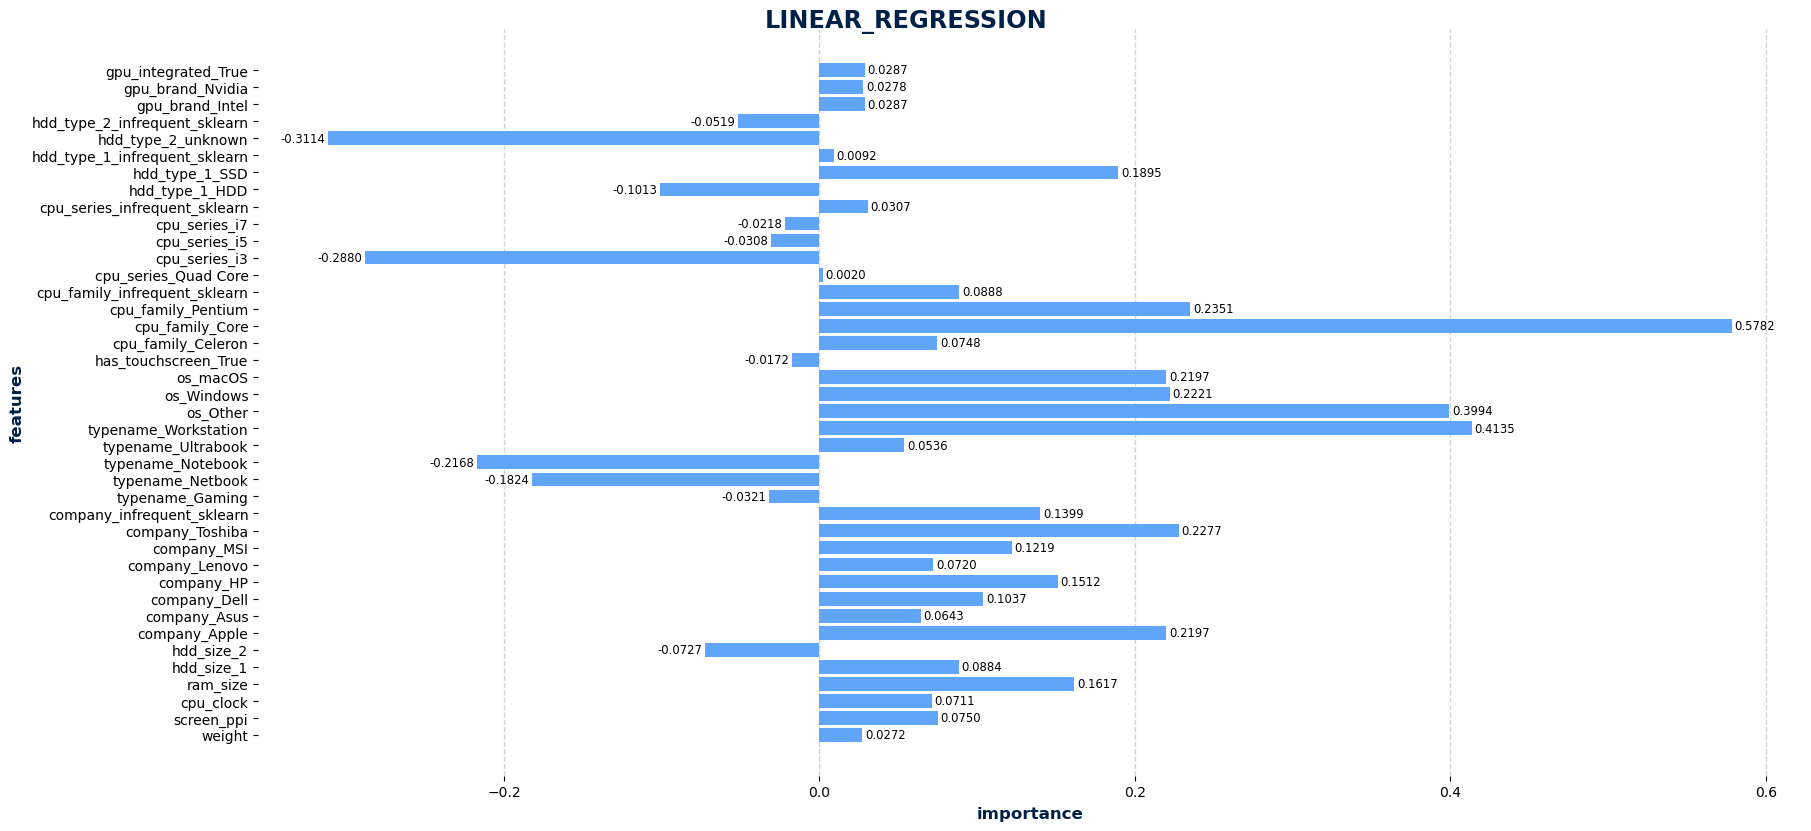

In [145]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded = preprocess["to_encode_ohe"].get_feature_names_out()

index = np.hstack([columns_to_logn, columns_to_log2, columns_encoded])
data = model.regressor_.named_steps["regressor"].coef_.ravel()

data = pd.Series(data, index=index, name="linear_regression")
plot_feature_importance(data)

In [146]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
Train RMSE: 341.117
Train R2: 74.213
--------------------
Test RMSE: 361.934
Test R2: 69.948
--------------------
--------------------
RMSE: 366.54
R2: 0.76
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


##### `ElasticNet`

In [147]:
elastic_net = ElasticNet(
	max_iter=6000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [148]:
params = {
	"regressor__regressor__alpha": [.001, .005, .01, .05, .5, 1, 5, 10],
	"regressor__regressor__l1_ratio": np.logspace(-3, 0, 12)
}

grid_search = GridSearchCV(
	estimator=model,
	param_grid=params,
	cv=kfold,
	refit=True,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2,
)
grid_search.fit(df_train, df_train["price"])

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during tra

[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.003511191734215131; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.012328467394420659; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.08111308307896868; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.08111308307896868; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.5336699231206307; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.5336699231206307; total time=   0.1s
[CV] END regressor__regressor__alpha=0.005, regressor__regressor__l1_ratio=0.003511191734215131; total time=   0.1s
[CV] END regressor__regressor__alpha=0.005, regressor__regressor__l1_ratio=0.003511191734215131; total time=   0.0s
[CV] END regressor__regressor__alpha=0.005, regressor__regressor__l1_ratio=0.0

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during tra

[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.001873817422860383; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.006579332246575682; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.012328467394420659; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.08111308307896868; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.08111308307896868; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.2848035868435799; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.2848035868435799; total time=   0.1s
[CV] END regressor__regressor__alpha=0.005, regressor__regressor__l1_ratio=0.001; total time=   0.1s
[CV] END regressor__regressor__alpha=0.005, regressor__regressor__l1_ratio=0.0018738174228603

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during tra

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(n_jobs=-1,
                                                                                               transformers=[('to_logn',
                                                                                                              Pipeline(steps=[('logn',
                                                                                                                               FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                              ('scale',
                                                                                                                               StandardScaler())]),
                                                                                                              ['weight',
                                                                                                               '...
                                                                            ('regressor',
                                                                             ElasticNet(max_iter=6000,
                                                                                        random_state=42))])),
             n_jobs=-1,
             param_grid={'regressor__regressor__alpha': [0.001, 0.005, 0.01,
                                                         0.05, 0.5, 1, 5, 10],
                         'regressor__regressor__l1_ratio': array([0.001     , 0.00187382, 0.00351119, 0.00657933, 0.01232847,
       0.0231013 , 0.04328761, 0.08111308, 0.15199111, 0.28480359,
       0.53366992, 1.        ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [149]:
grid_search.best_params_

{'regressor__regressor__alpha': 0.005,
 'regressor__regressor__l1_ratio': np.float64(0.08111308307896868)}

In [150]:
elastic_net = ElasticNet(
	alpha=.005,
	l1_ratio=.0811,
	max_iter=6000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=10),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.005,
                                                                 l1_ratio=0.0811,
                                                                 max_iter=6000,
                                                                 random_state=42))]))

In [151]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
Train RMSE: 345.558
Train R2: 73.533
--------------------
Test RMSE: 356.717
Test R2: 70.722
--------------------
--------------------
RMSE: 381.23
R2: 0.74
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### **Trees**

#### `RandomForestRegressor`

In [152]:
from sklearn.ensemble import RandomForestRegressor

In [294]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#	"cpu_brand",
	"cpu_family",
	"cpu_series",
#	"cpu_gen",
	"hdd_type_1",
	"hdd_type_2",
	"gpu_brand",
#	"gpu_model",
	"gpu_integrated"
]

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			 OneHotEncoder(
				min_frequency=10,
				drop="first",
			    handle_unknown="ignore"),
			 columns_to_ohe
		)
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

In [154]:
random_forest = RandomForestRegressor(n_estimators=200,
									  max_depth=10,
									  min_samples_leaf=5,
									  min_samples_split=12,
									  criterion="squared_error",
									  n_jobs=-1,
									  random_state=42)
pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=10),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=10,
                                                                            min_samples_leaf=5,
                                                                            min_samples_split=12,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            random_state=42))]))

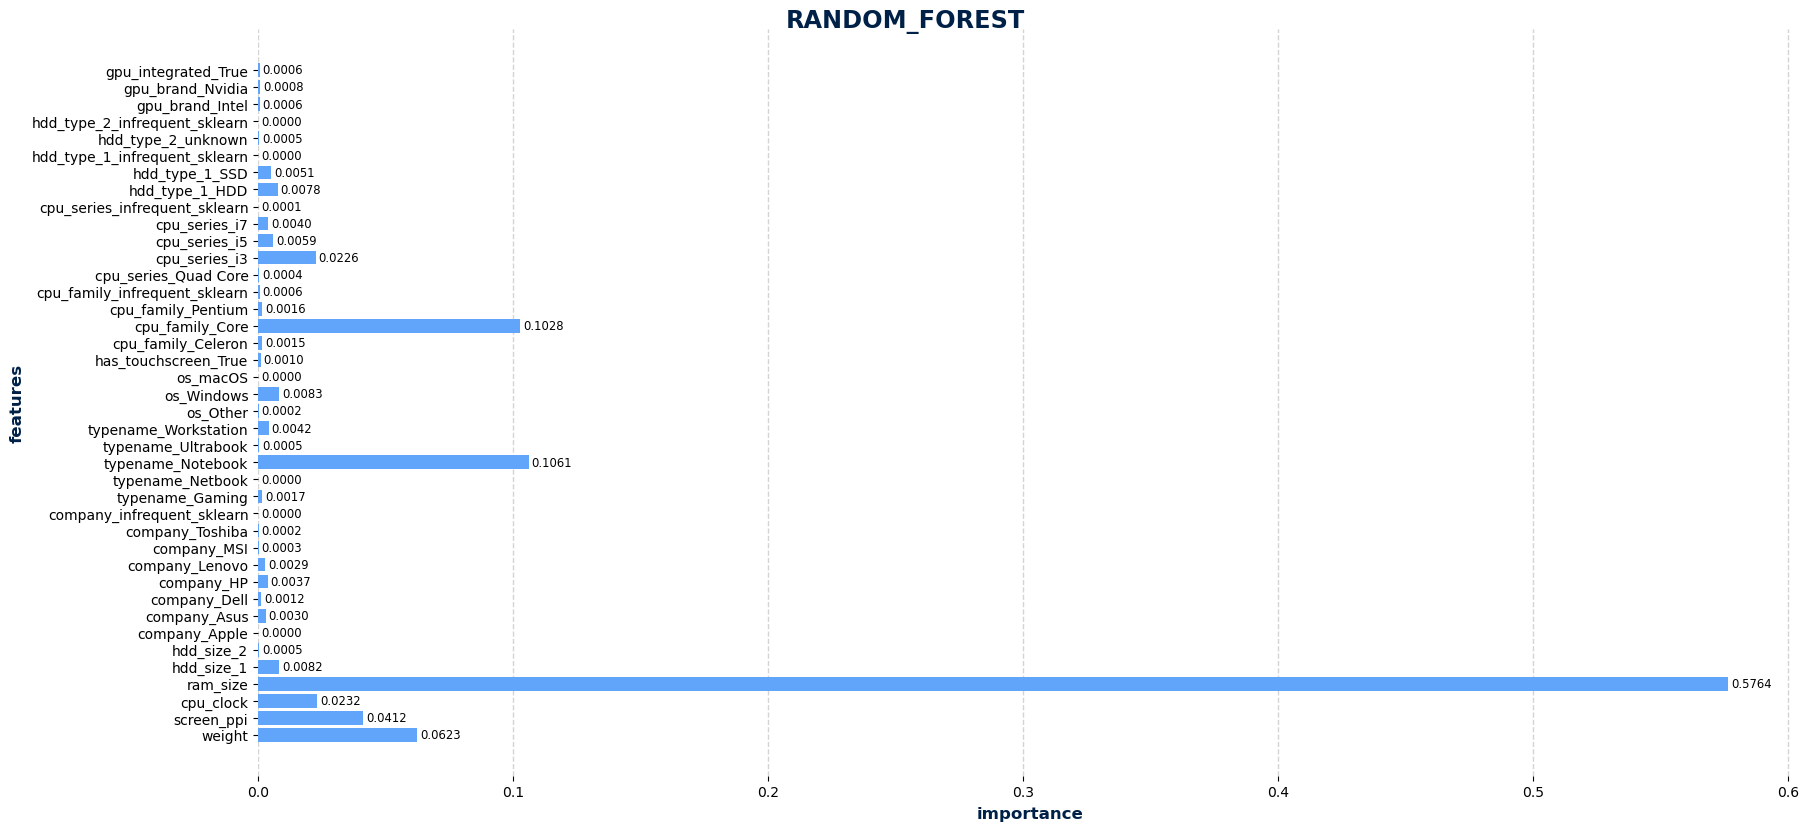

In [155]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="random_forest")
plot_feature_importance(data)

In [156]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)

print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
Train RMSE: 270.611
Train R2: 83.761
--------------------
Test RMSE: 336.197
Test R2: 74.234
--------------------
--------------------
RMSE: 387.25
R2: 0.73
--------------------


El modelo se encuentra sobreajustado a los datos de entrenamiento. La diferencia de error es muy grande, por lo que podemos concluire que el modelo no logra generalizar correctamente.

##### Optuna

Buscamos ajustar los hiperparámetros del **RandomForest** para mejorar el rendimiento.

In [266]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 4.7 MB/s eta 0:00:00


In [159]:
import optuna

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [160]:
random_forest = RandomForestRegressor(
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	oob_score=True,
	random_state=42
)


pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [161]:
def objective(trial):
	random_forest = RandomForestRegressor(
		n_estimators=trial.suggest_int("n_estimators", 200, 1000),
		max_depth=trial.suggest_int("max_depth", 4, 30),
		min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
		min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
		max_features=trial.suggest_categorical(
			"max_features",
			["sqrt", "log2"]
		),
		bootstrap=True,
		criterion="squared_error",
		n_jobs=-1,
		oob_score=True,
		random_state=42
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", random_forest)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)

	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)

	return results["test_score"].mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

print(study.best_params)

[I 2026-02-19 22:42:39,761] A new study created in memory with name: no-name-dc5019b3-dbc9-47c6-879a-1772755f8e79
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
[I 2026-02-19 22:42:40,930] Trial 0 finished with value: -320.24

{'n_estimators': 461, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [162]:
study.best_params

{'n_estimators': 461,
 'max_depth': 19,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2'}

In [163]:
random_forest = RandomForestRegressor(
	n_estimators=461,
	max_depth=19,
	min_samples_split=2,
	min_samples_leaf=1,
	max_features="log2",
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	oob_score=True,
	random_state=42
)


pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=10),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'hdd_type_2',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=19,
                                                                            max_features='log2',
                                                                            n_estimators=461,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
                                                                            random_state=42))]))

In [164]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
Train RMSE: 148.041
Train R2: 95.133
--------------------
Test RMSE: 319.089
Test R2: 76.771
--------------------
--------------------
RMSE: 342.32
R2: 0.79
--------------------


#### `XGBoost`

In [165]:
from xgboost import XGBRegressor

In [166]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]

log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#	"cpu_brand",
	"cpu_family",
	"cpu_series",
#	"cpu_gen",
	"hdd_type_1",
	"hdd_type_2",
	"gpu_brand",
#	"gpu_model",
	"gpu_integrated"
]

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				drop="first",
				handle_unknown="ignore",
				min_frequency=10
			),
			columns_to_ohe
		),
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

##### Optuna

In [167]:
def objective(trial):
	xgboost_regressor = XGBRegressor(
		n_estimators=trial.suggest_int("n_estimators", 200, 2000),
		learning_rate=trial.suggest_float("learning_rate", 0.01, 1, log=True),
		max_depth=trial.suggest_int("max_depth", 2, 8),
		min_child_weight=trial.suggest_int("min_child_weight", 5, 25),
		gamma=trial.suggest_float("gamma", 0.0, 6.0),
		subsample=trial.suggest_float("subsample", 0.6, 1.0),
		colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
		reg_alpha=trial.suggest_float("reg_alpha", 0.0, 3.0),
		reg_lambda=trial.suggest_float("reg_lambda", 0.1, 6.0),
		max_delta_step=trial.suggest_int("max_delta_step", 0, 15),
		eval_metric="rmse",
		objective="reg:squarederror",
		tree_method="hist",
		random_state=42,
		n_jobs=-1
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", xgboost_regressor)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)


	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2026-02-19 22:45:14,559] A new study created in memory with name: no-name-11a01475-4492-4cad-9c45-081efbb037f5
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
[I 2026-02-19 22:45:14,787] Trial 0 finished with value: -399.82

{'n_estimators': 1891, 'learning_rate': 0.06112115561697239, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 0.021863077265914264, 'subsample': 0.9544460654175574, 'colsample_bytree': 0.6470264965470657, 'reg_alpha': 0.6535784351394808, 'reg_lambda': 5.5737248236335475, 'max_delta_step': 1}


In [168]:
study.best_params

{'n_estimators': 1891,
 'learning_rate': 0.06112115561697239,
 'max_depth': 4,
 'min_child_weight': 9,
 'gamma': 0.021863077265914264,
 'subsample': 0.9544460654175574,
 'colsample_bytree': 0.6470264965470657,
 'reg_alpha': 0.6535784351394808,
 'reg_lambda': 5.5737248236335475,
 'max_delta_step': 1}

In [299]:
xgboost_regressor = XGBRegressor(
	n_estimators=1891,
	learning_rate=0.061,
	max_depth=4,
	min_child_weight=9,
	gamma=0.021,
	subsample=0.95,
	colsample_bytree=0.64,
	reg_alpha=0.65,
	reg_lambda=5.57,
	max_delta_step=1,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   feature_weights=None,
                                                                   gamma=0.021,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.061,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=1,
                                                                   max_depth=4,
                                                                   max_leaves=None,
                                                                   min_child_weight=9,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1891,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

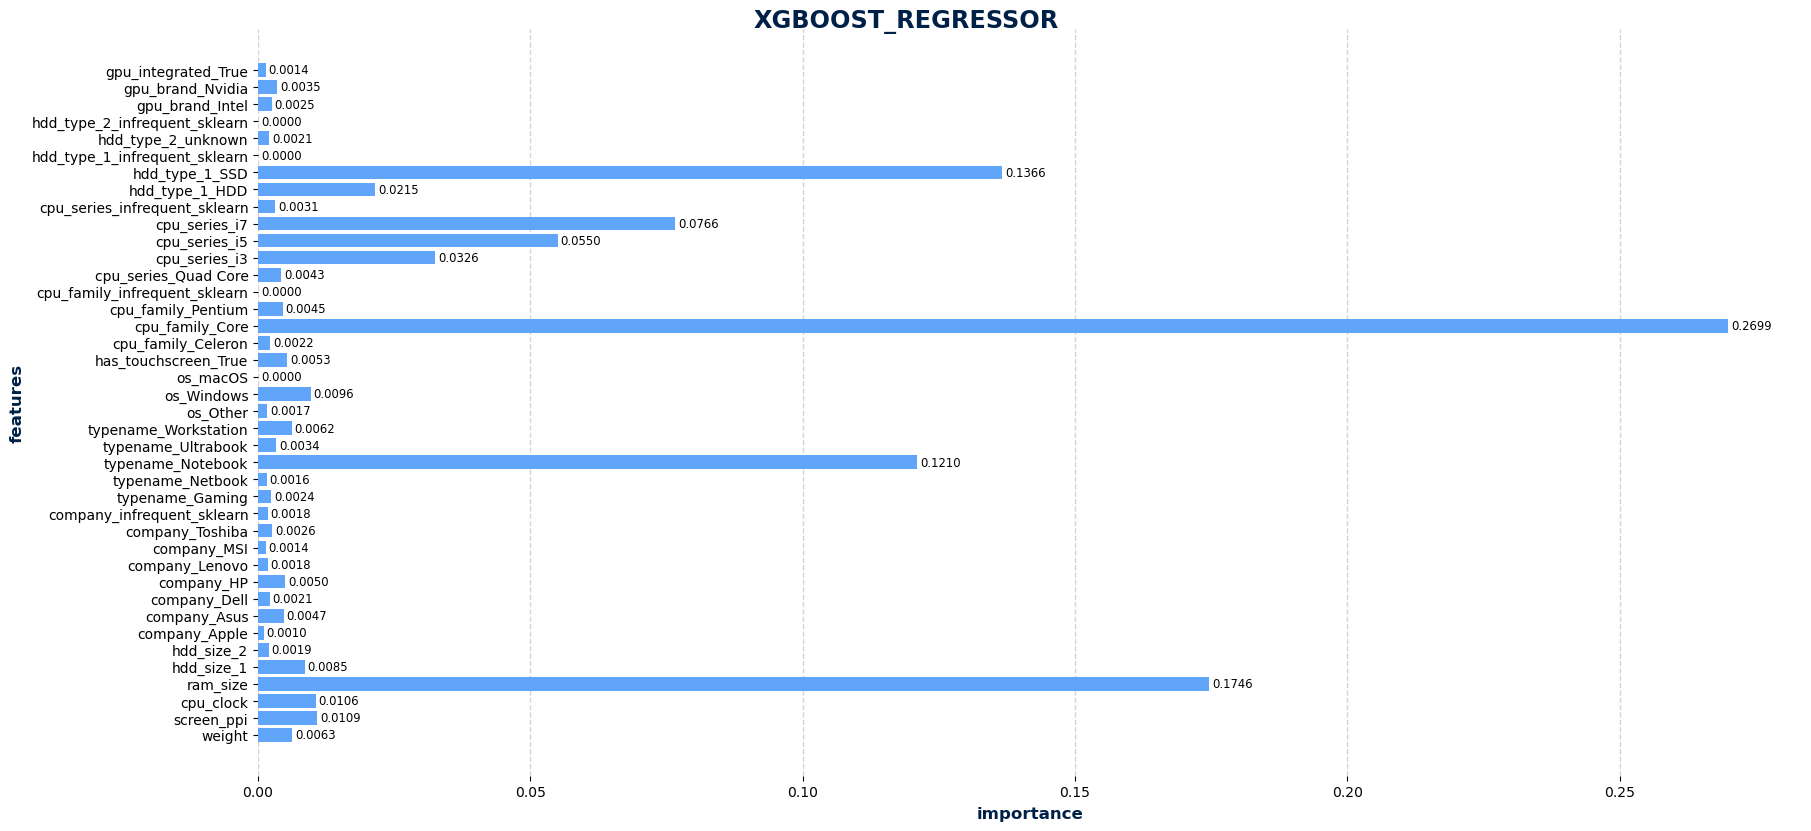

In [301]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="xgboost_regressor")
plot_feature_importance(data)

In [171]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)


model.fit(df_train, df_train["price"])
predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
Train RMSE: 213.806
Train R2: 89.849
--------------------
Test RMSE: 310.346
Test R2: 78.042
--------------------
--------------------
RMSE: 333.08
R2: 0.80
--------------------


### Conclusión

Luego de entrenar varios modelos, me he percatado que es necesario una optimización y un mejor manejo del dataset. De todas maneras, nos encontramos con un modelo muy potente para un dataset muy pequeño, por lo que es común el sobreentrenamiento que se genera en los modelos.



### Mejoras en preprocesamiento

Agrupamos toda la memoria del `hard-disc drive` en una única variable.

In [172]:
df_train["hdd_size"] = (
	df_train["hdd_size_1"] + df_train["hdd_size_2"]
).astype(int)

df_train[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)

hdd_size  hdd_size_1  hdd_size_2
laptop_ID                                  
541            1152         128      1024.0
958             256         256         0.0
37             1024        1024         0.0
889            1152         128      1024.0
673             128         128         0.0
505             256         256         0.0
562             500         500         0.0
324             128         128         0.0
745            1024        1024         0.0
615             256         256         0.0

In [173]:
df_test["hdd_size"] = (
	df_test["hdd_size_1"] + df_test["hdd_size_2"]
).astype(int)

df_test[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)

hdd_size  hdd_size_1  hdd_size_2
laptop_ID                                  
1173            256         256         0.0
319              32          32         0.0
1163            256         256         0.0
494             512         512         0.0
988            1280         256      1024.0
726              32          32         0.0
304             512         512         0.0
914             256         256         0.0
258             512         512         0.0
181            1536         512      1024.0

Reducimos las variables de `os`.

In [ ]:
df_train["os"].unique()

<StringArray>
['Windows', 'macOS', 'Linux', 'Chrome OS', 'No OS', 'Android']
Length: 6, dtype: str

In [174]:
df_train["os"] = df_train["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
df_train.replace(maps, inplace=True).sample(5)

company                                product   typename  inches  \
laptop_ID                                                                     
1081         Asus                             ROG G701VO     Gaming    17.3   
444        Google                        Pixelbook (Core  Ultrabook    12.3   
1318       Lenovo                     IdeaPad 100S-14IBR   Notebook    14.0   
504            HP                          EliteBook 840   Notebook    14.0   
508            HP  15-BS026nv (i5-7200U/8GB/256GB/Radeon   Notebook    15.6   

                os  weight    price  has_touchscreen screen_panel screen_type  \
laptop_ID                                                                       
1081       Windows    3.58  3975.00            False    IPS Panel     Full HD   
444          Other    1.10  2199.00             True      unknown     Quad HD   
1318       Windows    1.50   229.00            False      unknown          HD   
504        Windows    1.48  1749.00            False      unknown     Full HD   
508        Windows    1.91   618.99            False      unknown          HD   

           ... hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_ID  ...                                                            
1081       ...        0.0     unknown     Nvidia  GeForce GTX       980   
444        ...        0.0     unknown      Intel           HD       615   
1318       ...        0.0     unknown      Intel           HD   unknown   
504        ...        0.0     unknown      Intel           HD       620   
508        ...        0.0     unknown        AMD       Radeon       520   

          gpu_integrated has_hdd2 log_price  hdd_size  \
laptop_ID                                               
1081               False    False  8.288032      1024   
444                 True    False  7.696213       512   
1318                True    False  5.438079        64   
504                 True    False  7.467371      1024   
508                False    False  6.429703       256   

           gpu_model_recategorization  
laptop_ID                              
1081                              980  
444                             other  
1318                          unknown  
504                           unknown  
508                           unknown  

[5 rows x 32 columns]

In [175]:
df_test["os"] = df_test["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
df_test.replace(maps, inplace=True).sample(5)

company        product  typename  inches       os  weight    price  \
laptop_ID                                                                      
357            HP  Elitebook 850  Notebook    15.6  Windows    1.84  1304.00   
934          Dell    Vostro 3568  Notebook    15.6  Windows    2.18   684.99   
757          Dell  Latitude 5480  Notebook    14.0  Windows    1.60  1126.71   
1037           HP    ProBook 440  Notebook    14.0  Windows    1.64  1185.43   
1249        Razer      Blade Pro    Gaming    14.0  Windows    1.95  3499.00   

           has_touchscreen screen_panel screen_type  ... hdd_size_2  \
laptop_ID                                            ...              
357                  False      unknown     Full HD  ...        0.0   
934                  False      unknown          HD  ...        0.0   
757                  False      unknown          HD  ...        0.0   
1037                 False      unknown     Full HD  ...        0.0   
1249                 False      unknown     Full HD  ...        0.0   

           hdd_type_2  gpu_brand   gpu_family gpu_model gpu_integrated  \
laptop_ID                                                                
357           unknown      Intel           HD       620           True   
934           unknown        AMD    Radeon R5      M420          False   
757           unknown      Intel           HD       620           True   
1037          unknown     Nvidia      GeForce     930MX          False   
1249          unknown     Nvidia  GeForce GTX      1060          False   

          has_hdd2 log_price  hdd_size  gpu_model_recategorization  
laptop_ID                                                           
357          False  7.173958       256                     unknown  
934          False  6.530863      1024                       other  
757          False  7.027944       256                     unknown  
1037         False  7.078704       256                     unknown  
1249         False  8.160518      1024                     unknown  

[5 rows x 32 columns]

Completamos los valores de `gpu_model` que tenemos y tratamos de agrupar para evitar la alta dimensionalidad en el dataset.

In [176]:
df_train["gpu_model"].unique()

<StringArray>
[ 'W6150M',    '1050',     '550',     '520',     '530',    'M315',   '930MX',
     '620',    '1070',     '580', '1050 Ti',   '920MX',    '960M',   '940MX',
     '430',     '400',       nan,    'M430',     '615',   'M1200',    '1060',
   '1050M',     '515',   'MX150', 'unknown',   'M420X',    'M445',     '500',
    '6000',  'W5130M',   'MX130',  '1050Ti',     '555',  'M1000M',     '405',
   'M500M',    'M620',     '640',   'M365X',    '930M',     '540',     '510',
    '1080',     '505',    '950M',    '980M',    'M420',    '970M',     '560',
    '920M',     '650',    'M460',   '150MX',     '980',     '630',    'M330',
     '960',  'M2200M',    'M440',  'W4190M',    '940M',    '5300',  'M2000M',
      '7M']
Length: 64, dtype: str

In [177]:
df_test.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)
df_train.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)

company                              product  typename  inches  \
laptop_ID                                                                  
1305           HP  15-AC110nv (i7-6500U/6GB/1TB/Radeon  Notebook    15.6   
580        Lenovo                        Thinkpad E570  Notebook    15.6   
808          Dell                          Vostro 5568  Notebook    15.6   
748          Dell                        Inspiron 7560  Notebook    15.6   
760            HP                        EliteBook 850  Notebook    15.6   

                os  weight   price  has_touchscreen screen_panel screen_type  \
laptop_ID                                                                      
1305       Windows    2.19   764.0            False      unknown          HD   
580        Windows    2.30   830.0            False      unknown     Full HD   
808        Windows    2.00   739.0            False      unknown     Full HD   
748        Windows    2.00  1207.0            False      unknown     Full HD   
760        Windows    1.84  1900.0            False      unknown     Full HD   

           ... hdd_size_2  hdd_type_2  gpu_brand  gpu_family gpu_model  \
laptop_ID  ...                                                           
1305       ...        0.0     unknown        AMD   Radeon R5      M330   
580        ...        0.0     unknown      Intel          HD       620   
808        ...        0.0     unknown        AMD   Radeon R5     M420X   
748        ...     1024.0         HDD     Nvidia     GeForce     940MX   
760        ...        0.0     unknown      Intel          HD       520   

          gpu_integrated has_hdd2 log_price  hdd_size  \
laptop_ID                                               
1305               False    False  6.639876      1024   
580                 True    False  6.722630       256   
808                False    False  6.606650       256   
748                False     True  7.096721      1152   
760                 True    False  7.550135       256   

           gpu_model_recategorization  
laptop_ID                              
1305                            other  
580                           unknown  
808                             other  
748                           unknown  
760                           unknown  

[5 rows x 32 columns]

In [181]:
df_train["gpu_model"].unique()

<StringArray>
[ 'W6150M',    '1050',     '550',     '520',     '530',    'M315',   '930MX',
     '620',    '1070',     '580', '1050 Ti',   '920MX',    '960M',   '940MX',
     '430',     '400', 'unknown',    'M430',     '615',   'M1200',    '1060',
   '1050M',     '515',   'MX150',   'M420X',    'M445',     '500',    '6000',
  'W5130M',   'MX130',  '1050Ti',     '555',  'M1000M',     '405',   'M500M',
    'M620',     '640',   'M365X',    '930M',     '540',     '510',    '1080',
     '505',    '950M',    '980M',    'M420',    '970M',     '560',    '920M',
     '650',    'M460',   '150MX',     '980',     '630',    'M330',     '960',
  'M2200M',    'M440',  'W4190M',    '940M',    '5300',  'M2000M',      '7M']
Length: 63, dtype: str

Filtramos aquellas `gpu_model` con pocas muestras de nuestro dataset.

In [182]:
counts = df_train["gpu_model"].value_counts()
mask = df_train["gpu_model"].map(counts) < 8
low_freq_gpu_model = df_train.loc[mask, "gpu_model"].unique()

Nos quedamos con nuestro TOP10 de `gpu_model` según mediana.

In [183]:
top10_gpu_model = df_train.groupby("gpu_model")["price"].median().sort_values(ascending=False).head(5).index
top10_gpu_model

Index(['1080', 'M2000M', '980', 'W6150M', '1070'], dtype='str', name='gpu_model')

In [184]:
def recategorization(value):
	if value in top10_gpu_model:
		return value.strip()
	elif value in low_freq_gpu_model:
		return "other"
	else:
		return "unknown"


df_test["gpu_model_recategorization"] = df_test[
	"gpu_model"
].apply(recategorization)

df_train["gpu_model_recategorization"] = df_train[
	"gpu_model"
].apply(recategorization)

Agrupamos las `company` con pocas frequencias en una variable que las agrupe.

In [185]:
df_train["company"].unique()

<StringArray>
[       'HP',      'Dell',     'Apple',       'MSI',    'Lenovo',      'Asus',
   'Toshiba',      'Acer',    'Google',     'other', 'Microsoft',   'Samsung',
     'Razer',    'Xiaomi']
Length: 14, dtype: str

In [186]:
maps = {
	"company": {
		"Fujitsu": "other",
		"Mediacom": "other",
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}

df_test.replace(maps, inplace=True).sample(5)
df_train.replace(maps, inplace=True).sample(5)

company             product   typename  inches       os  weight  \
laptop_ID                                                                    
469           Asus    Pro P2540UA-AB51   Notebook    15.6  Windows    2.37   
26            Dell       Inspiron 3567   Notebook    15.6  Windows    2.30   
1133       Toshiba   Portege X30-D-10K  Ultrabook    13.3  Windows    1.05   
141         Lenovo  IdeaPad 320-15IKBN   Notebook    15.6  Free OS    2.20   
1318        Lenovo  IdeaPad 100S-14IBR   Notebook    14.0  Windows    1.50   

             price  has_touchscreen screen_panel screen_type  ... hdd_size_2  \
laptop_ID                                                     ...              
469         749.00            False      unknown     Full HD  ...        0.0   
26          418.64            False      unknown          HD  ...        0.0   
1133       2226.00            False      unknown     Full HD  ...        0.0   
141         499.00            False      unknown     Full HD  ...        0.0   
1318        229.00            False      unknown          HD  ...        0.0   

           hdd_type_2  gpu_brand  gpu_family gpu_model gpu_integrated  \
laptop_ID                                                               
469           unknown      Intel          HD       620           True   
26            unknown      Intel          HD       520           True   
1133          unknown      Intel          HD       620           True   
141           unknown     Nvidia     GeForce     920MX          False   
1318          unknown      Intel          HD   unknown           True   

          has_hdd2 log_price  hdd_size  gpu_model_recategorization  
laptop_ID                                                           
469          False  6.620073      1024                     unknown  
26           False  6.039397      1024                     unknown  
1133         False  7.708411       512                     unknown  
141          False  6.214608      1024                     unknown  
1318         False  5.438079        64                     unknown  

[5 rows x 32 columns]

### Reentrenamiento

#### `ElasticNET`

Entrenamos un modelo `ElasticNET` con los parámetros utilizados anteriormente para evaluar el rendimiento.

In [255]:
df_train.iloc[:, 15: 35]

cpu_family cpu_series  cpu_gen  cpu_clock  ram_size  hdd_size_1  \
laptop_ID                                                                   
1118            Core         i7        6        2.6         8        1024   
153             Core         i7        7        2.8        16         512   
275             Core         i5  unknown        2.9         8         512   
1100            Core         i5        6        2.3         4         500   
131             Core         i7        8        1.8        16         256   
...              ...        ...      ...        ...       ...         ...   
578          Pentium  Quad Core        3        1.6         8        2048   
996         A-Series        A12        9        3.6         6         256   
770             Core         i7        7        2.8        16         256   
407          Celeron  Dual Core        3        1.1         4        1024   
418             Core         i7        7        2.8         8         512   

          hdd_type_1  hdd_size_2 hdd_type_2 gpu_brand   gpu_family gpu_model  \
laptop_ID                                                                      
1118             HDD         0.0    unknown       AMD      FirePro    W6150M   
153              SSD         0.0    unknown    Nvidia  GeForce GTX      1050   
275              SSD         0.0    unknown     Intel         Iris       550   
1100             HDD         0.0    unknown     Intel           HD       520   
131              SSD      2048.0        HDD       AMD       Radeon       530   
...              ...         ...        ...       ...          ...       ...   
578              HDD         0.0    unknown     Intel           HD       405   
996              SSD         0.0    unknown       AMD       Radeon       530   
770              SSD         0.0    unknown     Intel           HD       620   
407              HDD         0.0    unknown     Intel           HD       500   
418              SSD         0.0    unknown    Nvidia   GeForce GT     940MX   

           gpu_integrated  has_hdd2  log_price  hdd_size  \
laptop_ID                                                  
1118                False     False   7.972466      1024   
153                 False     False   7.131107       512   
275                  True     False   7.580649       512   
1100                 True     False   6.939244       500   
131                 False      True   7.242082      2304   
...                   ...       ...        ...       ...   
578                  True     False   5.966147      2048   
996                 False     False   6.309918       256   
770                  True     False   7.528332       256   
407                  True     False   5.726848      1024   
418                 False     False   7.572503       512   

          gpu_model_recategorization  
laptop_ID                             
1118                          W6150M  
153                          unknown  
275                            other  
1100                         unknown  
131                          unknown  
...                              ...  
578                            other  
996                          unknown  
770                          unknown  
407                          unknown  
418                          unknown  

[729 rows x 17 columns]

In [360]:
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
columns_to_log2 = ["ram_size", "hdd_size"]
columns_to_ohe = [
#	"company",
	"typename",
	"os",
#	"has_touchscreen",
#   "cpu_brand",
	"cpu_family",
	"cpu_series",
#	"cpu_gen",
	"hdd_type_1",
	"has_hdd2",
	"gpu_brand",
	"gpu_family",
]



log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

linear_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				min_frequency=7,
				drop="first",
				handle_unknown="ignore"),
			columns_to_ohe
		)
	],
	n_jobs=-1
)


elastic_net = ElasticNet(
	alpha=.005,
	l1_ratio=.0811,
	max_iter=6000,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...<lambda> at 0x74f98ec06d40>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=7),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'has_hdd2',
                                                                                        'gpu_brand',
                                                                                        'gpu_family'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.005,
                                                                 l1_ratio=0.0811,
                                                                 max_iter=6000,
                                                                 random_state=42))]))

In [317]:
elastic_net = ElasticNet(
	alpha=.005,
	l1_ratio=.0811,
	max_iter=6000,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=5),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'gpu_family',
                                                                                        'gpu_model_recategorization'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.005,
                                                                 l1_ratio=0.0811,
                                                                 max_iter=6000,
                                                                 random_state=42))]))

Ordenada al origen: 6.278052745968041


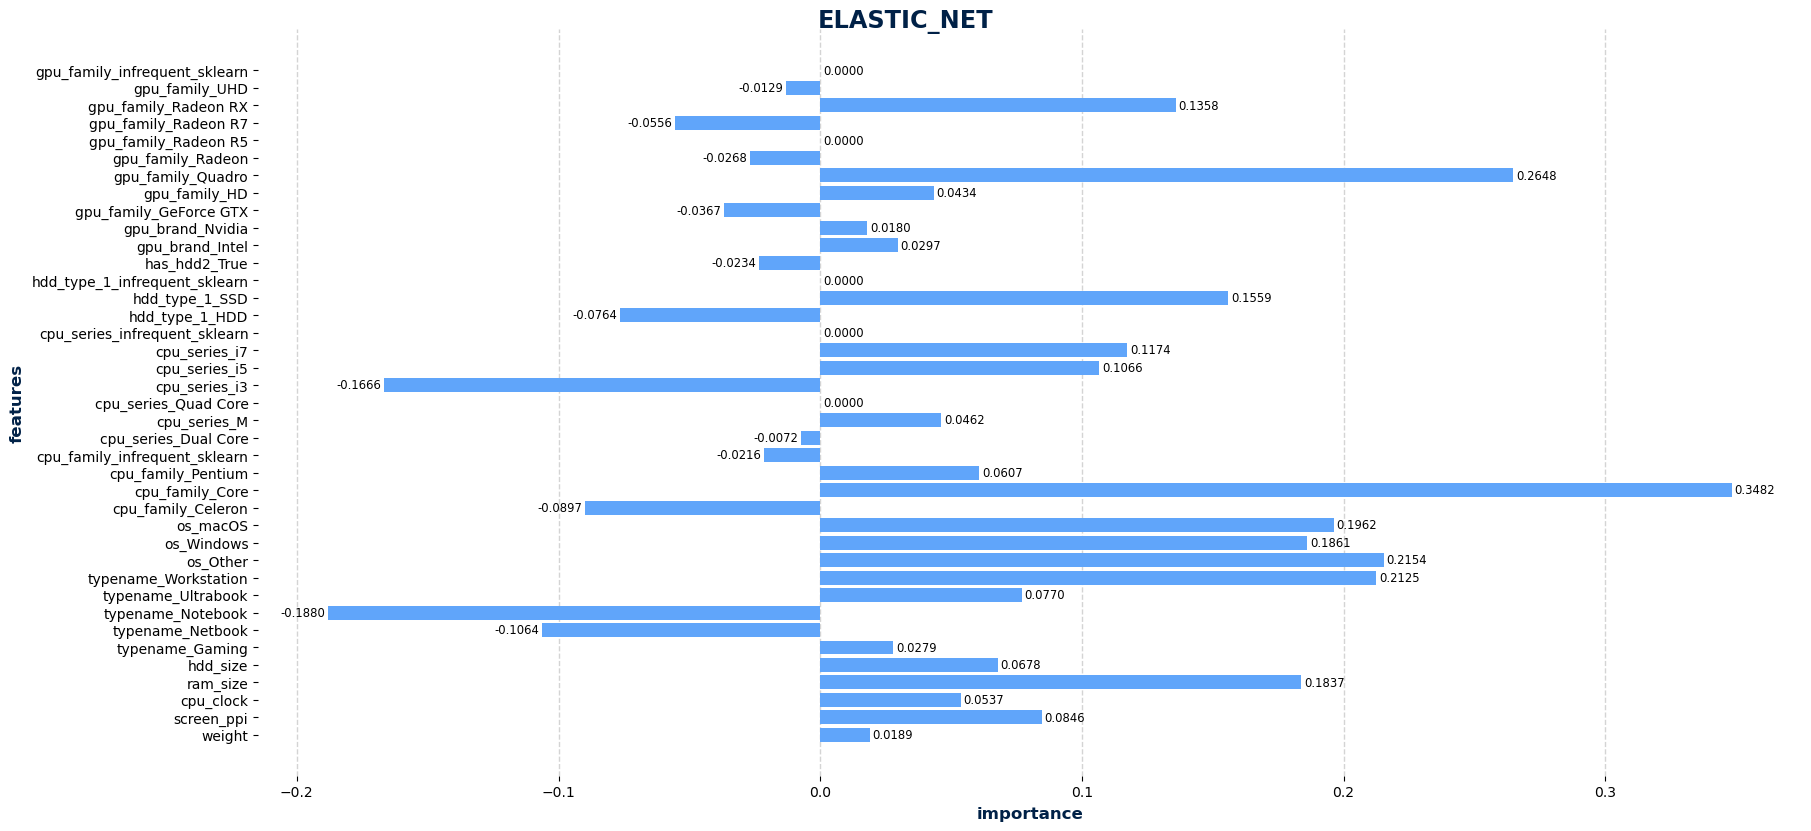

In [361]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="elastic_net")

plot_feature_importance(data)

In [362]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
TRAIN
--------------------
RMSE: 354.668
R2: 71.02
--------------------
TEST
--------------------
RMSE: 368.57
R2: 0.75
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

##### Optuna

In [363]:
def objective(trial):
	elastic_net = ElasticNet(
		alpha=trial.suggest_float("alpha", .001, 5),
		l1_ratio=trial.suggest_float("l1_ratio", .001, 1, log=True),
		max_iter=5000,
		random_state=42
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", linear_transformer),
			("regressor", elastic_net)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)

	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2026-02-19 23:44:17,058] A new study created in memory with name: no-name-68f019b1-0435-4b13-9996-12daa3478eee
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-package

{'alpha': 0.0073612627521989354, 'l1_ratio': 0.009116387961767154}


In [364]:
study.best_params

{'alpha': 0.0073612627521989354, 'l1_ratio': 0.009116387961767154}

In [365]:
elastic_net = ElasticNet(
	alpha=.007,
	l1_ratio=.009,
	max_iter=6000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...n <lambda> at 0x74f98ec06d40>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=7),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'hdd_type_1',
                                                                                        'has_hdd2',
                                                                                        'gpu_brand',
                                                                                        'gpu_family'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.007,
                                                                 l1_ratio=0.009,
                                                                 max_iter=6000,
                                                                 random_state=42))]))

Ordenada al origen: 6.310517015718855


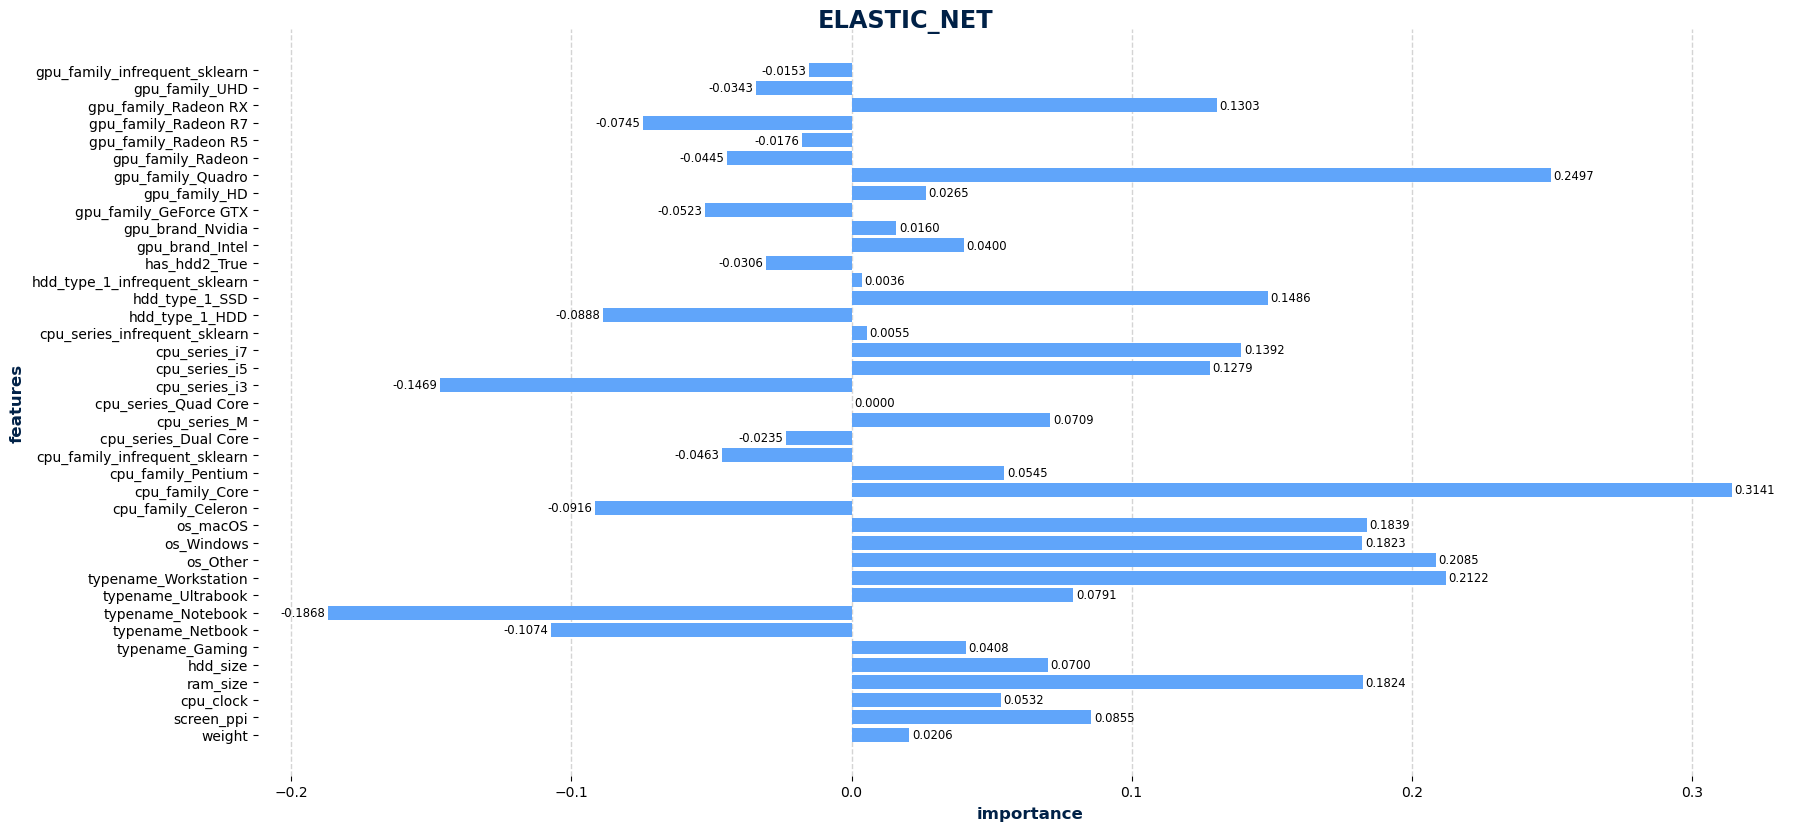

In [366]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="elastic_net")

plot_feature_importance(data)

In [367]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)

print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
TRAIN
--------------------
RMSE: 354.694
R2: 71.01
--------------------
TEST
--------------------
RMSE: 369.64
R2: 0.75
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

#### `XGBRegressor`

In [368]:
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
columns_to_log2 = ["ram_size", "hdd_size"]
columns_to_ohe = [
#	"company",
	"typename",
	"os",
#	"has_touchscreen",
#   "cpu_brand",
	"cpu_family",
	"cpu_series",
#	"cpu_gen",
	"hdd_type_1",
	"has_hdd2",
	"gpu_brand",
	"gpu_family"
]


log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				drop="first",
				handle_unknown="ignore",
				min_frequency=7),
			columns_to_ohe
		),
		# (
		# 	"to_encode_oe",
		# 	OrdinalEncoder(
		# 		categories=ordinal_categories,
		# 		handle_unknown="use_encoded_value",
		# 		unknown_value=-1),
		# 	columns_to_oe
		# )
	],
	n_jobs=-1
)

In [369]:
xgboost_regressor = XGBRegressor(
	n_estimators=1891,
	learning_rate=0.061,
	max_depth=4,
	min_child_weight=9,
	gamma=0.021,
	subsample=0.95,
	colsample_bytree=0.64,
	reg_alpha=0.65,
	reg_lambda=5.57,
	max_delta_step=1,
	eval_metric="rmse",
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                   feature_weights=None,
                                                                   gamma=0.1,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.03,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=20,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1000,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]))

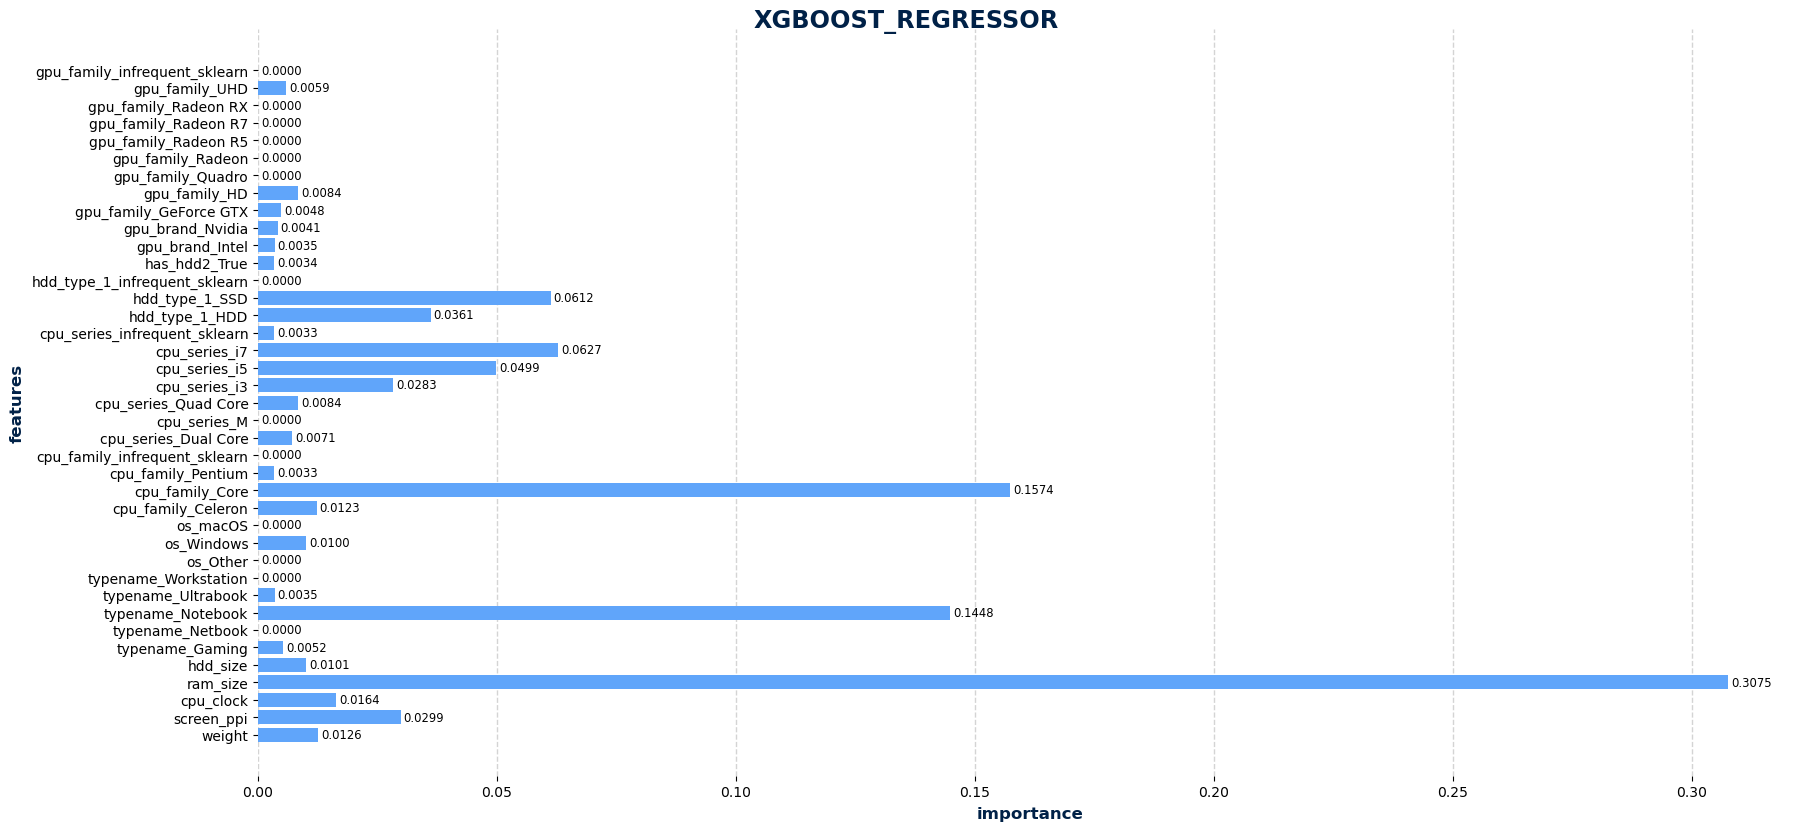

In [371]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()

columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="xgboost_regressor")

plot_feature_importance(data)

In [372]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
TRAIN
--------------------
RMSE: 349.972
R2: 71.82
--------------------
TEST
--------------------
RMSE: 384.81
R2: 0.73
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

##### Optuna

In [ ]:
import xgboost
from xgboost import callback


print(xgboost.__version__)

3.2.0


In [386]:
def objective(trial):
	xgboost_regressor = XGBRegressor(
		n_estimators=trial.suggest_int("n_estimators", 800, 5000),
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        min_child_weight=trial.suggest_float("min_child_weight", 1, 15),
        gamma=trial.suggest_float("gamma", 0, 10),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        max_delta_step=trial.suggest_int("max_delta_step", 0, 10),
        tree_method="hist",
        grow_policy=trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
        eval_metric="rmse")

	pipeline = Pipeline(
		steps=[
			("preprocessing", trees_transformer),
			("regressor", xgboost_regressor)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)


	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()

study = optuna.create_study(
	direction="maximize",
	sampler=optuna.samplers.TPESampler(multivariate=True),
	pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)
)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=600, show_progress_bar=True)

/tmp/ipykernel_98366/3986597498.py:48: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  sampler=optuna.samplers.TPESampler(multivariate=True),
[I 2026-02-20 00:13:11,419] A new study created in memory with name: no-name-84a723ad-95fb-4ee4-8063-eeaa3b9da649
[I 2026-02-20 00:13:11,419] A new study created in memory with name: no-name-6fa0e832-6e00-49d7-8dda-a2d446b49b25
  0%|                                                                                                                                                                                                                  | 0/600 [00:00<?, ?it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/pyth

[I 2026-02-20 00:13:13,207] Trial 0 finished with value: -395.9984582965097 and parameters: {'n_estimators': 4847, 'learning_rate': 0.015297236168373663, 'max_depth': 9, 'min_child_weight': 11.416913298886154, 'gamma': 2.4041032544934025, 'subsample': 0.9392481130694772, 'colsample_bytree': 0.5487059795012073, 'reg_alpha': 0.0024159327129834665, 'reg_lambda': 0.058022984149869304, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -395.9984582965097.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:14,698] Trial 1 finished with value: -456.86710124512285 and parameters: {'n_estimators': 4277, 'learning_rate': 0.03956357763677656, 'max_depth': 3, 'min_child_weight': 3.2814391814616855, 'gamma': 8.555557984637032, 'subsample': 0.8429141912048312, 'colsample_bytree': 0.8146277451898958, 'reg_alpha': 0.011467391096915285, 'reg_lambda': 0.0012214233441788453, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -395.9984582965097.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:13:15,641] Trial 2 finished with value: -457.52461498828706 and parameters: {'n_estimators': 1730, 'learning_rate': 0.010290795612701503, 'max_depth': 3, 'min_child_weight': 2.045722460226789, 'gamma': 7.960494987573928, 'subsample': 0.9278469880364794, 'colsample_bytree': 0.884825259652968, 'reg_alpha': 3.2626382046171574, 'reg_lambda': 0.0013376096843424029, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -395.9984582965097.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:15,987] Trial 3 finished with value: -424.6791593080614 and parameters: {'n_estimators': 3365, 'learning_rate': 0.01868897733599384, 'max_depth': 10, 'min_child_weight': 9.32563107988818, 'gamma': 4.389511220152863, 'subsample': 0.7169452216708639, 'colsample_bytree': 0.5364690556278844, 'reg_alpha': 1.95921942002013, 'reg_lambda': 0.4122398015958039, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: -395.9984582965097.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 4. Best value: -393.422:   1%|█▍                                                                                                                                      

[I 2026-02-20 00:13:16,269] Trial 4 finished with value: -393.42226862778233 and parameters: {'n_estimators': 2315, 'learning_rate': 0.028889039153418967, 'max_depth': 5, 'min_child_weight': 8.889758532124713, 'gamma': 2.3923932910169454, 'subsample': 0.8783046418571716, 'colsample_bytree': 0.6755833257860263, 'reg_alpha': 0.07128861853050784, 'reg_lambda': 0.392275316245993, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 4 with value: -393.42226862778233.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:13:16,641] Trial 5 finished with value: -460.49549826737194 and parameters: {'n_estimators': 3353, 'learning_rate': 0.03684399619498828, 'max_depth': 6, 'min_child_weight': 2.6938444801647936, 'gamma': 9.105452850981386, 'subsample': 0.8844792838295489, 'colsample_bytree': 0.7169842277796454, 'reg_alpha': 0.5690798439976058, 'reg_lambda': 0.027455966945613093, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 4 with value: -393.42226862778233.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 4. Best value: -393.422:   1%|█▉                                                                                                                                         

[I 2026-02-20 00:13:16,965] Trial 6 finished with value: -468.0392570841209 and parameters: {'n_estimators': 2782, 'learning_rate': 0.023716263375104088, 'max_depth': 3, 'min_child_weight': 12.265878236462372, 'gamma': 9.98693898147119, 'subsample': 0.9297169931389189, 'colsample_bytree': 0.7237742577203682, 'reg_alpha': 0.1957804330269471, 'reg_lambda': 0.0025006532278406867, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 4 with value: -393.42226862778233.


Best trial: 7. Best value: -371.944:   1%|██▏                                                                                                                                                                  | 8/600 [00:05<04:04,  2.42it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


[I 2026-02-20 00:13:17,195] Trial 7 finished with value: -371.9441127368783 and parameters: {'n_estimators': 1468, 'learning_rate': 0.00869887604987584, 'max_depth': 6, 'min_child_weight': 14.526711495103031, 'gamma': 1.194709301020167, 'subsample': 0.7061184175267515, 'colsample_bytree': 0.9584890715727494, 'reg_alpha': 0.002458970238022425, 'reg_lambda': 0.00665521813738314, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 7 with value: -371.9441127368783.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 7. Best value: -371.944:   2%|██▍                                                                                                                                        

[I 2026-02-20 00:13:17,550] Trial 8 finished with value: -465.5428833423246 and parameters: {'n_estimators': 3030, 'learning_rate': 0.025825416853462013, 'max_depth': 7, 'min_child_weight': 14.152111298364789, 'gamma': 9.364625914362366, 'subsample': 0.7866490084804663, 'colsample_bytree': 0.60554398100114, 'reg_alpha': 0.017327157640488925, 'reg_lambda': 0.1542272878876589, 'max_delta_step': 6, 'grow_policy': 'lossguide'}. Best is trial 7 with value: -371.9441127368783.


Best trial: 7. Best value: -371.944:   2%|██▋                                                                                                                                                                 | 10/600 [00:06<03:19,  2.95it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


[I 2026-02-20 00:13:17,761] Trial 9 finished with value: -417.5485035089305 and parameters: {'n_estimators': 1107, 'learning_rate': 0.00593684973290547, 'max_depth': 10, 'min_child_weight': 1.1895799974305403, 'gamma': 3.653795198193377, 'subsample': 0.8761446415717049, 'colsample_bytree': 0.5449738028398095, 'reg_alpha': 0.0038461207601608854, 'reg_lambda': 0.12998892032395332, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 7 with value: -371.9441127368783.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 10. Best value: -355.779:   2%|██▉                                                                                                                                             

[I 2026-02-20 00:13:18,038] Trial 10 finished with value: -355.77891309992276 and parameters: {'n_estimators': 1049, 'learning_rate': 0.00550452937083448, 'max_depth': 8, 'min_child_weight': 6.006946050524602, 'gamma': 0.3623879854429196, 'subsample': 0.6339221765931887, 'colsample_bytree': 0.9941443889540449, 'reg_alpha': 0.001781423003164548, 'reg_lambda': 7.838929578984155, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 10 with value: -355.77891309992276.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:13:18,543] Trial 11 finished with value: -322.4466959439531 and parameters: {'n_estimators': 819, 'learning_rate': 0.005158243464871691, 'max_depth': 8, 'min_child_weight': 5.8043134693444, 'gamma': 0.002522570760519649, 'subsample': 0.6029961624115895, 'colsample_bytree': 0.9945773024335002, 'reg_alpha': 0.0010287826794570993, 'reg_lambda': 2.3857352061930124, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 11. Best value: -322.447:   2%|███▌                                                                                                                                   

[I 2026-02-20 00:13:18,820] Trial 12 finished with value: -354.93459661606045 and parameters: {'n_estimators': 827, 'learning_rate': 0.00511395700115637, 'max_depth': 8, 'min_child_weight': 5.760800224215543, 'gamma': 0.3712866324985162, 'subsample': 0.6054825891807396, 'colsample_bytree': 0.9957025490325405, 'reg_alpha': 0.01474694821695444, 'reg_lambda': 4.053378619229065, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 11. Best value: -322.447:   2%|███▊                                                                                                                                   

[I 2026-02-20 00:13:19,101] Trial 13 finished with value: -454.0981721437888 and parameters: {'n_estimators': 1930, 'learning_rate': 0.008222456629770981, 'max_depth': 8, 'min_child_weight': 5.558193459816581, 'gamma': 6.524699468410331, 'subsample': 0.6224195158648653, 'colsample_bytree': 0.8971199021624265, 'reg_alpha': 0.019975409012213136, 'reg_lambda': 7.424420162433049, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:13:19,465] Trial 14 finished with value: -327.2910371442357 and parameters: {'n_estimators': 854, 'learning_rate': 0.005182543547503704, 'max_depth': 8, 'min_child_weight': 5.42555916823583, 'gamma': 0.10519097182369716, 'subsample': 0.6010632592323398, 'colsample_bytree': 0.9206055819718681, 'reg_alpha': 0.0010974738056669534, 'reg_lambda': 1.6349638908617163, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:13:19,793] Trial 15 finished with value: -392.25743102023927 and parameters: {'n_estimators': 2350, 'learning_rate': 0.007148427250260229, 'max_depth': 7, 'min_child_weight': 7.271419241701835, 'gamma': 2.206529826370442, 'subsample': 0.6884865215806998, 'colsample_bytree': 0.826911381317005, 'reg_alpha': 0.0011107843985520818, 'reg_lambda': 1.5219890192823191, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 11. Best value: -322.447:   3%|████▌                                                                                                                                                              | 17/600 [00:08<02:58,  3.27it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


[I 2026-02-20 00:13:20,032] Trial 16 finished with value: -482.6622242816833 and parameters: {'n_estimators': 1510, 'learning_rate': 0.011605855980049094, 'max_depth': 9, 'min_child_weight': 4.208458755566012, 'gamma': 5.823639075347214, 'subsample': 0.772569857465483, 'colsample_bytree': 0.916492750196659, 'reg_alpha': 9.508403732181192, 'reg_lambda': 0.8787438211765954, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 11 with value: -322.4466959439531.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:20,402] Trial 17 finished with value: -309.57306142332857 and parameters: {'n_estimators': 807, 'learning_rate': 0.013368038389906522, 'max_depth': 9, 'min_child_weight': 7.445657925679443, 'gamma': 0.025078968650150572, 'subsample': 0.6678990855639415, 'colsample_bytree': 0.8081170896411318, 'reg_alpha': 0.0070903513567977935, 'reg_lambda': 1.617035513458215, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 17 with value: -309.57306142332857.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 17. Best value: -309.573:   3%|█████▏                                                                                                                                 

[I 2026-02-20 00:13:20,715] Trial 18 finished with value: -376.9274394408286 and parameters: {'n_estimators': 2125, 'learning_rate': 0.013615730626725261, 'max_depth': 9, 'min_child_weight': 7.714732916764934, 'gamma': 1.4317113491337203, 'subsample': 0.6710081058390617, 'colsample_bytree': 0.811384672770713, 'reg_alpha': 0.004602159147920052, 'reg_lambda': 2.7942076240746014, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 17 with value: -309.57306142332857.


Best trial: 17. Best value: -309.573:   3%|█████▍                                                                                                                                                             | 20/600 [00:09<02:49,  3.42it/s]

[I 2026-02-20 00:13:20,940] Trial 19 finished with value: -409.0832296495634 and parameters: {'n_estimators': 1284, 'learning_rate': 0.047763951922692595, 'max_depth': 5, 'min_child_weight': 10.140628110683366, 'gamma': 3.5561559438706425, 'subsample': 0.7436748527793778, 'colsample_bytree': 0.6599606858990823, 'reg_alpha': 0.06938219861687255, 'reg_lambda': 0.48760059998756194, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 17 with value: -309.57306142332857.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:13:21,374] Trial 20 finished with value: -367.9660991041816 and parameters: {'n_estimators': 3781, 'learning_rate': 0.018816754696017884, 'max_depth': 10, 'min_child_weight': 7.035349210184671, 'gamma': 1.3108431844993218, 'subsample': 0.6616468061496585, 'colsample_bytree': 0.7783353645839565, 'reg_alpha': 0.006286686206568196, 'reg_lambda': 0.029368620759614297, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 17 with value: -309.57306142332857.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:21,866] Trial 21 finished with value: -309.22298544415287 and parameters: {'n_estimators': 814, 'learning_rate': 0.006519274980610468, 'max_depth': 8, 'min_child_weight': 4.018643690796289, 'gamma': 0.023769371172907994, 'subsample': 0.6040332214040823, 'colsample_bytree': 0.9348320844797677, 'reg_alpha': 0.0010642803674641291, 'reg_lambda': 1.916485547689629, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 21 with value: -309.22298544415287.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 21. Best value: -309.223:   4%|██████▏                                                                                                                                

[I 2026-02-20 00:13:22,170] Trial 22 finished with value: -362.9286482693146 and parameters: {'n_estimators': 1396, 'learning_rate': 0.007039126302463892, 'max_depth': 9, 'min_child_weight': 4.312537219516025, 'gamma': 0.8512187275797454, 'subsample': 0.6544639465257924, 'colsample_bytree': 0.8655374988829523, 'reg_alpha': 0.0068296349189301666, 'reg_lambda': 2.4718275872888746, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 21 with value: -309.22298544415287.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:13:23,136] Trial 23 finished with value: -293.4172353518554 and parameters: {'n_estimators': 1746, 'learning_rate': 0.006738796601230617, 'max_depth': 7, 'min_child_weight': 4.272056490430413, 'gamma': 0.005248042786194857, 'subsample': 0.6358071032013973, 'colsample_bytree': 0.9382196755611881, 'reg_alpha': 0.033178204408186675, 'reg_lambda': 0.7948996929909957, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   4%|██████▊                                                                                                                                   

[I 2026-02-20 00:13:23,442] Trial 24 finished with value: -409.6786456994547 and parameters: {'n_estimators': 1745, 'learning_rate': 0.010460087784316842, 'max_depth': 7, 'min_child_weight': 3.8490058497169786, 'gamma': 3.223872572042147, 'subsample': 0.7367116031270442, 'colsample_bytree': 0.8520461288902574, 'reg_alpha': 0.029969736579013695, 'reg_lambda': 0.7983674979196036, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:23,907] Trial 25 finished with value: -386.0551025876915 and parameters: {'n_estimators': 2489, 'learning_rate': 0.00670278817612172, 'max_depth': 6, 'min_child_weight': 2.0650335505179767, 'gamma': 1.9662754295750717, 'subsample': 0.6423725027550982, 'colsample_bytree': 0.9454187544386227, 'reg_alpha': 0.034981019259943034, 'reg_lambda': 0.27444797059053244, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   4%|███████▎                                                                                                                                                           | 27/600 [00:12<03:53,  2.45it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be enc

[I 2026-02-20 00:13:24,172] Trial 26 finished with value: -369.7824235657239 and parameters: {'n_estimators': 1206, 'learning_rate': 0.008749833632682447, 'max_depth': 7, 'min_child_weight': 8.378826542954004, 'gamma': 1.1285295831832298, 'subsample': 0.6812046792836518, 'colsample_bytree': 0.9449309145813829, 'reg_alpha': 0.17366075429441008, 'reg_lambda': 1.0033264929412826, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   5%|███████▌                                                                                                                               

[I 2026-02-20 00:13:24,455] Trial 27 finished with value: -442.4066772929006 and parameters: {'n_estimators': 1741, 'learning_rate': 0.01267211723160182, 'max_depth': 9, 'min_child_weight': 4.706735893265537, 'gamma': 5.434482204958612, 'subsample': 0.6372376811203891, 'colsample_bytree': 0.7814265382138035, 'reg_alpha': 0.010202978831239511, 'reg_lambda': 3.7809459198211477, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   5%|███████▉                                                                                                                                     

[I 2026-02-20 00:13:24,771] Trial 28 finished with value: -409.1143612422866 and parameters: {'n_estimators': 2006, 'learning_rate': 0.010126085759614673, 'max_depth': 5, 'min_child_weight': 10.00498936490932, 'gamma': 2.965970710505225, 'subsample': 0.9997052335418187, 'colsample_bytree': 0.8502551041132285, 'reg_alpha': 0.03350985453063533, 'reg_lambda': 0.25547713058183724, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   5%|████████▏                                                                                                                                                          | 30/600 [00:13<03:01,  3.14it/s]

[I 2026-02-20 00:13:25,006] Trial 29 finished with value: -381.7610574126881 and parameters: {'n_estimators': 1074, 'learning_rate': 0.015844757034724898, 'max_depth': 4, 'min_child_weight': 6.810095246776717, 'gamma': 1.7869850749904839, 'subsample': 0.7543501160274326, 'colsample_bytree': 0.773832259293485, 'reg_alpha': 0.002892623616492542, 'reg_lambda': 0.05852237659051497, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:25,569] Trial 30 finished with value: -367.7552980669284 and parameters: {'n_estimators': 4816, 'learning_rate': 0.017101828337125143, 'max_depth': 9, 'min_child_weight': 11.35848424781374, 'gamma': 0.8495129090957135, 'subsample': 0.8251042583909505, 'colsample_bytree': 0.8877574709987782, 'reg_alpha': 0.13844251239745448, 'reg_lambda': 4.895152573288222, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:13:26,045] Trial 31 finished with value: -317.6788095771352 and parameters: {'n_estimators': 833, 'learning_rate': 0.00620897175212817, 'max_depth': 8, 'min_child_weight': 6.574277670166268, 'gamma': 0.03464323234649609, 'subsample': 0.6210180242211422, 'colsample_bytree': 0.9701590827902191, 'reg_alpha': 0.0018379941551987318, 'reg_lambda': 1.612660387420628, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   6%|████████▉                                                                                                                              

[I 2026-02-20 00:13:26,380] Trial 32 finished with value: -347.0287336926981 and parameters: {'n_estimators': 1580, 'learning_rate': 0.006481492269586657, 'max_depth': 8, 'min_child_weight': 2.9474257690564754, 'gamma': 0.5239529616323304, 'subsample': 0.7065440961326458, 'colsample_bytree': 0.9620064538916268, 'reg_alpha': 0.002067606075120304, 'reg_lambda': 1.343085105797142, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:26,821] Trial 33 finished with value: -310.31969124523783 and parameters: {'n_estimators': 1063, 'learning_rate': 0.007933690974639326, 'max_depth': 7, 'min_child_weight': 6.8890355197694575, 'gamma': 0.03809755639069709, 'subsample': 0.6273443743181958, 'colsample_bytree': 0.9200262122007565, 'reg_alpha': 0.009476745497298468, 'reg_lambda': 0.6330437907607057, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


Best trial: 23. Best value: -293.417:   6%|█████████▌                                                                                                                                                         | 35/600 [00:15<03:18,  2.85it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be enc

[I 2026-02-20 00:13:27,041] Trial 34 finished with value: -460.2364274737382 and parameters: {'n_estimators': 1257, 'learning_rate': 0.0076300174441177124, 'max_depth': 7, 'min_child_weight': 3.552687265686469, 'gamma': 7.776904871465203, 'subsample': 0.6575669446743017, 'colsample_bytree': 0.9154497986990427, 'reg_alpha': 0.007861683796098166, 'reg_lambda': 0.6479232851256242, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


Best trial: 23. Best value: -293.417:   6%|█████████▊                                                                                                                                                         | 36/600 [00:15<02:56,  3.20it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will 

[I 2026-02-20 00:13:27,263] Trial 35 finished with value: -403.91810666010485 and parameters: {'n_estimators': 1082, 'learning_rate': 0.009180484356528953, 'max_depth': 6, 'min_child_weight': 4.757988047369994, 'gamma': 2.7637056848972805, 'subsample': 0.6936609900297751, 'colsample_bytree': 0.8232358376198078, 'reg_alpha': 0.3940899332060216, 'reg_lambda': 0.2693237336147327, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   6%|██████████                                                                                                                                                         | 37/600 [00:16<02:46,  3.37it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be 

[I 2026-02-20 00:13:27,522] Trial 36 finished with value: -427.4947118407592 and parameters: {'n_estimators': 1656, 'learning_rate': 0.007599242517929413, 'max_depth': 7, 'min_child_weight': 8.122671552733834, 'gamma': 4.385901605826826, 'subsample': 0.6268221394904838, 'colsample_bytree': 0.8658804522526794, 'reg_alpha': 0.04599428908392034, 'reg_lambda': 0.5270186058708346, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   6%|██████████▎                                                                                                                                                        | 38/600 [00:16<02:39,  3.52it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories

[I 2026-02-20 00:13:27,775] Trial 37 finished with value: -380.4285877788952 and parameters: {'n_estimators': 1349, 'learning_rate': 0.009961705087537784, 'max_depth': 9, 'min_child_weight': 8.883632127776632, 'gamma': 1.6791522111300634, 'subsample': 0.7234659657420007, 'colsample_bytree': 0.9283244771580199, 'reg_alpha': 0.011253784985467507, 'reg_lambda': 0.21288362360077256, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


Best trial: 23. Best value: -293.417:   6%|██████████▌                                                                                                                                                        | 39/600 [00:16<02:29,  3.76it/s]

[I 2026-02-20 00:13:28,003] Trial 38 finished with value: -352.96178545060354 and parameters: {'n_estimators': 1015, 'learning_rate': 0.01191700959042341, 'max_depth': 10, 'min_child_weight': 1.639201669477095, 'gamma': 0.8258954353277809, 'subsample': 0.6704795692666426, 'colsample_bytree': 0.5068205592536643, 'reg_alpha': 0.004086917231696175, 'reg_lambda': 0.06422116585896888, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:28,384] Trial 39 finished with value: -344.5514498461448 and parameters: {'n_estimators': 2719, 'learning_rate': 0.03191358849418712, 'max_depth': 6, 'min_child_weight': 2.595283751109596, 'gamma': 0.6592210997089785, 'subsample': 0.6430623156968998, 'colsample_bytree': 0.7426921878062513, 'reg_alpha': 0.08138107864615604, 'reg_lambda': 0.39943525024761556, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   7%|███████████▏                                                                                                                              

[I 2026-02-20 00:13:28,676] Trial 40 finished with value: -402.78389884949127 and parameters: {'n_estimators': 1921, 'learning_rate': 0.005772970509088053, 'max_depth': 7, 'min_child_weight': 5.179783141081988, 'gamma': 2.5783280599905045, 'subsample': 0.6173289559947376, 'colsample_bytree': 0.7002778928089018, 'reg_alpha': 0.016664991072109638, 'reg_lambda': 1.114033364867472, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:29,064] Trial 41 finished with value: -324.35523170829276 and parameters: {'n_estimators': 805, 'learning_rate': 0.006606097502916493, 'max_depth': 8, 'min_child_weight': 6.71610321649484, 'gamma': 0.0861182227713681, 'subsample': 0.6189262784083549, 'colsample_bytree': 0.9646958153632961, 'reg_alpha': 0.00211913872382156, 'reg_lambda': 1.7786279734606423, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:29,310] Trial 42 finished with value: -381.8058039870904 and parameters: {'n_estimators': 950, 'learning_rate': 0.006120358971363388, 'max_depth': 8, 'min_child_weight': 6.446406230516938, 'gamma': 1.1897550066355076, 'subsample': 0.6476232747695918, 'colsample_bytree': 0.9674329462137842, 'reg_alpha': 0.004941500293376517, 'reg_lambda': 5.958097242565848, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   7%|███████████▉                                                                                                                           

[I 2026-02-20 00:13:29,621] Trial 43 finished with value: -317.6557827074828 and parameters: {'n_estimators': 1217, 'learning_rate': 0.020765907255460507, 'max_depth': 9, 'min_child_weight': 7.709267667122082, 'gamma': 0.08552979783910448, 'subsample': 0.6017738818798779, 'colsample_bytree': 0.8960618768881439, 'reg_alpha': 0.0024918508792806703, 'reg_lambda': 3.0007501647232964, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   8%|████████████▏                                                                                                                             

[I 2026-02-20 00:13:29,874] Trial 44 finished with value: -352.31795175398327 and parameters: {'n_estimators': 1435, 'learning_rate': 0.024181427199341264, 'max_depth': 10, 'min_child_weight': 9.724871031946734, 'gamma': 0.5336307106726781, 'subsample': 0.6095094843548605, 'colsample_bytree': 0.8967539051872749, 'reg_alpha': 0.002830889214391508, 'reg_lambda': 3.2171454672208504, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


Best trial: 23. Best value: -293.417:   8%|████████████▍                                                                                                                                                      | 46/600 [00:18<02:28,  3.72it/s]

[I 2026-02-20 00:13:30,096] Trial 45 finished with value: -381.809744359453 and parameters: {'n_estimators': 1178, 'learning_rate': 0.019956345858194748, 'max_depth': 9, 'min_child_weight': 11.209392269319794, 'gamma': 1.6786557807730929, 'subsample': 0.6011114137779696, 'colsample_bytree': 0.8818524565156571, 'reg_alpha': 0.020495141064394002, 'reg_lambda': 0.7978055715146444, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:13:30,608] Trial 46 finished with value: -371.64568887057305 and parameters: {'n_estimators': 4042, 'learning_rate': 0.021435058846835803, 'max_depth': 9, 'min_child_weight': 8.840933702791125, 'gamma': 0.9578874488782497, 'subsample': 0.6780218749563957, 'colsample_bytree': 0.9286102536660692, 'reg_alpha': 0.0013657221331426388, 'reg_lambda': 8.432882107683156, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   8%|█████████████                                                                                                                                                      | 48/600 [00:19<02:51,  3.23it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories wi

[I 2026-02-20 00:13:30,843] Trial 47 finished with value: -343.8941945006803 and parameters: {'n_estimators': 1014, 'learning_rate': 0.01587077713806256, 'max_depth': 8, 'min_child_weight': 7.72177472549425, 'gamma': 0.4218291158336529, 'subsample': 0.6363878844579344, 'colsample_bytree': 0.7998157161640196, 'reg_alpha': 0.0033724762695284288, 'reg_lambda': 2.283475502096563, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   8%|█████████████▎                                                                                                                                                     | 49/600 [00:19<02:39,  3.45it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories wi

[I 2026-02-20 00:13:31,084] Trial 48 finished with value: -389.9166246720136 and parameters: {'n_estimators': 1280, 'learning_rate': 0.013984589048772124, 'max_depth': 7, 'min_child_weight': 3.2697583641424726, 'gamma': 2.113174833741485, 'subsample': 0.6967953804234499, 'colsample_bytree': 0.845766719241561, 'reg_alpha': 0.009021939129988736, 'reg_lambda': 0.004347490005327586, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   8%|█████████████▌                                                                                                                                                     | 50/600 [00:19<02:35,  3.53it/s]

[I 2026-02-20 00:13:31,353] Trial 49 finished with value: -452.05341344253947 and parameters: {'n_estimators': 1551, 'learning_rate': 0.027058631397834845, 'max_depth': 10, 'min_child_weight': 4.891100685800188, 'gamma': 7.5917704238273505, 'subsample': 0.8091660534227788, 'colsample_bytree': 0.9112930602822973, 'reg_alpha': 1.1879348578967244, 'reg_lambda': 0.1543275635642698, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:13:31,950] Trial 50 finished with value: -309.44111994360287 and parameters: {'n_estimators': 1711, 'learning_rate': 0.007733904702739878, 'max_depth': 8, 'min_child_weight': 6.016392784575632, 'gamma': 0.029800114451301124, 'subsample': 0.8489025952766311, 'colsample_bytree': 0.6218910101893851, 'reg_alpha': 0.05267135521481447, 'reg_lambda': 4.989558744829405, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:13:32,642] Trial 51 finished with value: -303.3666670053903 and parameters: {'n_estimators': 2199, 'learning_rate': 0.007785895974307221, 'max_depth': 8, 'min_child_weight': 6.018343576610935, 'gamma': 0.01442582753624489, 'subsample': 0.8593233637039698, 'colsample_bytree': 0.5925984827501894, 'reg_alpha': 0.05258375383051147, 'reg_lambda': 5.225751023194718, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:33,013] Trial 52 finished with value: -352.4595596405726 and parameters: {'n_estimators': 2472, 'learning_rate': 0.008051253380813863, 'max_depth': 8, 'min_child_weight': 6.1387262522534725, 'gamma': 0.4396786555557548, 'subsample': 0.857136899474537, 'colsample_bytree': 0.5796197667307197, 'reg_alpha': 0.0463312354421017, 'reg_lambda': 5.5368507484063105, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:   9%|██████████████▋                                                                                                                           

[I 2026-02-20 00:13:33,365] Trial 53 finished with value: -385.8867823474119 and parameters: {'n_estimators': 2223, 'learning_rate': 0.009208507959774369, 'max_depth': 8, 'min_child_weight': 5.91129106215878, 'gamma': 1.412303091100032, 'subsample': 0.8513906368453118, 'colsample_bytree': 0.6345442292425189, 'reg_alpha': 0.2817861581823987, 'reg_lambda': 9.614991743861799, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:33,987] Trial 54 finished with value: -294.0364701987068 and parameters: {'n_estimators': 1845, 'learning_rate': 0.007395763351276429, 'max_depth': 7, 'min_child_weight': 3.999049084012446, 'gamma': 0.025249991853158245, 'subsample': 0.8717939036426774, 'colsample_bytree': 0.583975495136097, 'reg_alpha': 0.10845628747157293, 'reg_lambda': 2.0027689537335194, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:34,428] Trial 55 finished with value: -364.4621931295542 and parameters: {'n_estimators': 2970, 'learning_rate': 0.005684092690407331, 'max_depth': 8, 'min_child_weight': 3.7656735064770572, 'gamma': 0.7324423312631053, 'subsample': 0.9135206438850669, 'colsample_bytree': 0.5856727144005883, 'reg_alpha': 0.1117739593477038, 'reg_lambda': 4.446329890037476, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:34,866] Trial 56 finished with value: -452.0283447049131 and parameters: {'n_estimators': 3282, 'learning_rate': 0.006995903838064945, 'max_depth': 6, 'min_child_weight': 4.373853360666132, 'gamma': 6.8623408263676735, 'subsample': 0.8860061098266072, 'colsample_bytree': 0.6261089124115842, 'reg_alpha': 0.05848515699767481, 'reg_lambda': 6.708274637111544, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  10%|███████████████▊                                                                                                                          

[I 2026-02-20 00:13:35,206] Trial 57 finished with value: -344.3911745770968 and parameters: {'n_estimators': 1858, 'learning_rate': 0.010869679317367617, 'max_depth': 7, 'min_child_weight': 5.3490605444937245, 'gamma': 0.39409164400062985, 'subsample': 0.8713419547227601, 'colsample_bytree': 0.5131985931516273, 'reg_alpha': 0.0987403823705224, 'reg_lambda': 2.092807619693993, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:35,529] Trial 58 finished with value: -378.0083253941988 and parameters: {'n_estimators': 2080, 'learning_rate': 0.00849753266009812, 'max_depth': 8, 'min_child_weight': 2.253539903909831, 'gamma': 1.2070414660571476, 'subsample': 0.9074530619998384, 'colsample_bytree': 0.57636246451987, 'reg_alpha': 0.02244460372843747, 'reg_lambda': 3.7419370142198844, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:13:35,914] Trial 59 finished with value: -379.1786180095172 and parameters: {'n_estimators': 2639, 'learning_rate': 0.007264215665289403, 'max_depth': 7, 'min_child_weight': 4.089581265728012, 'gamma': 1.4761281638600763, 'subsample': 0.8091037919336135, 'colsample_bytree': 0.5626916759797284, 'reg_alpha': 0.2049355264473758, 'reg_lambda': 1.3814562233421768, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  10%|████████████████▌                                                                                                                            

[I 2026-02-20 00:13:36,247] Trial 60 finished with value: -426.0365578483832 and parameters: {'n_estimators': 2213, 'learning_rate': 0.005294300255429437, 'max_depth': 9, 'min_child_weight': 1.0473606878795416, 'gamma': 4.428496208823716, 'subsample': 0.8414131124269981, 'colsample_bytree': 0.6782455236421525, 'reg_alpha': 0.8830028673838017, 'reg_lambda': 0.015033014292489402, 'max_delta_step': 6, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:36,642] Trial 61 finished with value: -333.9868635228554 and parameters: {'n_estimators': 1802, 'learning_rate': 0.008061869343399187, 'max_depth': 7, 'min_child_weight': 13.578510897737667, 'gamma': 0.08304523497941957, 'subsample': 0.9618490774108897, 'colsample_bytree': 0.6116420504554014, 'reg_alpha': 0.028360374997781733, 'reg_lambda': 1.188334665001897, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:37,009] Trial 62 finished with value: -338.5398564980327 and parameters: {'n_estimators': 1677, 'learning_rate': 0.007632499836049415, 'max_depth': 6, 'min_child_weight': 7.368709558690084, 'gamma': 0.3127156984902266, 'subsample': 0.7737317581453763, 'colsample_bytree': 0.5421977664508039, 'reg_alpha': 0.04499004817828976, 'reg_lambda': 2.154104093011172, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  11%|█████████████████▍                                                                                                                        

[I 2026-02-20 00:13:37,273] Trial 63 finished with value: -364.70923570432694 and parameters: {'n_estimators': 1440, 'learning_rate': 0.008825777385742757, 'max_depth': 7, 'min_child_weight': 6.287633231024877, 'gamma': 0.9228667978369346, 'subsample': 0.8335223570478423, 'colsample_bytree': 0.6572184151026125, 'reg_alpha': 0.013259355810547166, 'reg_lambda': 0.5834021871068292, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:37,903] Trial 64 finished with value: -311.71978744191495 and parameters: {'n_estimators': 1936, 'learning_rate': 0.005953373137789175, 'max_depth': 8, 'min_child_weight': 5.648345358645903, 'gamma': 0.040655953942259695, 'subsample': 0.8939904299003844, 'colsample_bytree': 0.6002216536383093, 'reg_alpha': 0.058964805043589176, 'reg_lambda': 2.970350780738172, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:13:38,300] Trial 65 finished with value: -354.390367496 and parameters: {'n_estimators': 2420, 'learning_rate': 0.006615833987021832, 'max_depth': 7, 'min_child_weight': 3.282390822612263, 'gamma': 0.6744859668934255, 'subsample': 0.8652682889074061, 'colsample_bytree': 0.7492834377926627, 'reg_alpha': 0.12102067710081384, 'reg_lambda': 0.8404899749789876, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  11%|██████████████████▏                                                                                                                                                | 67/600 [00:27<03:19,  2.67it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be 

[I 2026-02-20 00:13:38,569] Trial 66 finished with value: -345.91007829695957 and parameters: {'n_estimators': 941, 'learning_rate': 0.00973364579523216, 'max_depth': 8, 'min_child_weight': 7.147412627363439, 'gamma': 0.31849524077776503, 'subsample': 0.8975964462309979, 'colsample_bytree': 0.9860668825107252, 'reg_alpha': 0.08192415768563963, 'reg_lambda': 4.660708961611118, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  11%|██████████████████▍                                                                                                                    

[I 2026-02-20 00:13:38,864] Trial 67 finished with value: -464.7183808351022 and parameters: {'n_estimators': 1580, 'learning_rate': 0.011111241681060669, 'max_depth': 3, 'min_child_weight': 5.1463484596794, 'gamma': 8.78502801875112, 'subsample': 0.8262075298050663, 'colsample_bytree': 0.5277718697431348, 'reg_alpha': 0.2430523069286557, 'reg_lambda': 1.854531915407852, 'max_delta_step': 6, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:39,285] Trial 68 finished with value: -366.55542934114203 and parameters: {'n_estimators': 3127, 'learning_rate': 0.007303753822535825, 'max_depth': 5, 'min_child_weight': 4.513964005279611, 'gamma': 1.0429999365192852, 'subsample': 0.9370851463313276, 'colsample_bytree': 0.637876493738673, 'reg_alpha': 0.16195014572331834, 'reg_lambda': 0.09022420862392345, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  12%|███████████████████                                                                                                                       

[I 2026-02-20 00:13:39,636] Trial 69 finished with value: -355.244523153386 and parameters: {'n_estimators': 2040, 'learning_rate': 0.005016650494464409, 'max_depth': 7, 'min_child_weight': 8.22863391489399, 'gamma': 0.6672940822263838, 'subsample': 0.7924510638972374, 'colsample_bytree': 0.7289616642301379, 'reg_alpha': 0.0060010601560375205, 'reg_lambda': 0.3277122044667983, 'max_delta_step': 9, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  12%|███████████████████▎                                                                                                                   

[I 2026-02-20 00:13:39,980] Trial 70 finished with value: -476.21379426844095 and parameters: {'n_estimators': 2311, 'learning_rate': 0.007924772965977484, 'max_depth': 8, 'min_child_weight': 5.959136093746163, 'gamma': 9.848438941594564, 'subsample': 0.6649135001564392, 'colsample_bytree': 0.5566726593607133, 'reg_alpha': 0.027124177404796373, 'reg_lambda': 0.6908498416428999, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:13:40,438] Trial 71 finished with value: -323.37435204671164 and parameters: {'n_estimators': 1916, 'learning_rate': 0.006083623153775029, 'max_depth': 8, 'min_child_weight': 5.626000648499674, 'gamma': 0.10162848113464522, 'subsample': 0.8930257462909331, 'colsample_bytree': 0.5992594713194228, 'reg_alpha': 0.04985205976328652, 'reg_lambda': 2.8770364330960274, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:41,124] Trial 72 finished with value: -318.77212490362706 and parameters: {'n_estimators': 2595, 'learning_rate': 0.005487444029152937, 'max_depth': 7, 'min_child_weight': 5.000310099613, 'gamma': 0.04969124964567736, 'subsample': 0.9602694027257749, 'colsample_bytree': 0.949307199329904, 'reg_alpha': 0.07132077496910254, 'reg_lambda': 3.037694706058483, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:13:41,532] Trial 73 finished with value: -342.3112894937716 and parameters: {'n_estimators': 2186, 'learning_rate': 0.006428917566616935, 'max_depth': 8, 'min_child_weight': 6.537073729186432, 'gamma': 0.35950965900996024, 'subsample': 0.8781932139983286, 'colsample_bytree': 0.5985256429235655, 'reg_alpha': 0.037702949156773455, 'reg_lambda': 1.109620792014563, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  12%|████████████████████▍                                                                                                                  

[I 2026-02-20 00:13:41,857] Trial 74 finished with value: -375.8969077325116 and parameters: {'n_estimators': 1762, 'learning_rate': 0.006859177988296274, 'max_depth': 9, 'min_child_weight': 5.605899445687107, 'gamma': 1.0146147980249474, 'subsample': 0.9198023150317601, 'colsample_bytree': 0.5699699137463345, 'reg_alpha': 0.06240943962453846, 'reg_lambda': 6.537669010805241, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:42,422] Trial 75 finished with value: -313.38978497820136 and parameters: {'n_estimators': 1141, 'learning_rate': 0.009395875906984544, 'max_depth': 8, 'min_child_weight': 7.0444327411376335, 'gamma': 0.020963704921522493, 'subsample': 0.6262104062086936, 'colsample_bytree': 0.6108814216568438, 'reg_alpha': 0.09784808607884458, 'reg_lambda': 3.7118403253630423, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:13:42,761] Trial 76 finished with value: -356.0434135207651 and parameters: {'n_estimators': 1318, 'learning_rate': 0.005743594967273312, 'max_depth': 7, 'min_child_weight': 4.005796339991504, 'gamma': 0.6328392321495752, 'subsample': 0.8993238519477524, 'colsample_bytree': 0.704859100093251, 'reg_alpha': 0.013384155423921166, 'reg_lambda': 1.381181525579395, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  13%|█████████████████████▏                                                                                                                    

[I 2026-02-20 00:13:43,063] Trial 77 finished with value: -373.2164210076414 and parameters: {'n_estimators': 929, 'learning_rate': 0.008459955136250438, 'max_depth': 8, 'min_child_weight': 3.5062584404311496, 'gamma': 0.3463954724023816, 'subsample': 0.865025718388871, 'colsample_bytree': 0.9818759360196376, 'reg_alpha': 4.220133058125239, 'reg_lambda': 1.7140362369374254, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:43,440] Trial 78 finished with value: -383.7633240615913 and parameters: {'n_estimators': 1979, 'learning_rate': 0.007426554403393898, 'max_depth': 9, 'min_child_weight': 4.626401764207096, 'gamma': 1.5968429672008437, 'subsample': 0.8868845056802976, 'colsample_bytree': 0.9389879364285646, 'reg_alpha': 0.022851565749633016, 'reg_lambda': 2.4669378393135566, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:13:43,771] Trial 79 finished with value: -388.0525650019183 and parameters: {'n_estimators': 1605, 'learning_rate': 0.0062990090314276265, 'max_depth': 6, 'min_child_weight': 2.8301989806363945, 'gamma': 1.9315563742359203, 'subsample': 0.8523760880685894, 'colsample_bytree': 0.6494106875474356, 'reg_alpha': 0.001335838578492268, 'reg_lambda': 0.001134316495609777, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:44,065] Trial 80 finished with value: -378.47952777616774 and parameters: {'n_estimators': 1493, 'learning_rate': 0.013290804029209199, 'max_depth': 7, 'min_child_weight': 7.471549873525794, 'gamma': 1.252606505049058, 'subsample': 0.6543889339309537, 'colsample_bytree': 0.8726687250255059, 'reg_alpha': 0.36120483393484376, 'reg_lambda': 5.33705838381477, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:13:44,501] Trial 81 finished with value: -317.17745634060384 and parameters: {'n_estimators': 1113, 'learning_rate': 0.009232328839430216, 'max_depth': 8, 'min_child_weight': 7.871167881783961, 'gamma': 0.04213406035419086, 'subsample': 0.6308564120615621, 'colsample_bytree': 0.6149119728885094, 'reg_alpha': 0.083440370452003, 'reg_lambda': 3.8330569741352756, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:13:45,169] Trial 82 finished with value: -312.16976258330527 and parameters: {'n_estimators': 1124, 'learning_rate': 0.00780569073201344, 'max_depth': 8, 'min_child_weight': 6.866240216877177, 'gamma': 0.004769459640969786, 'subsample': 0.6190869054319009, 'colsample_bytree': 0.593164093736365, 'reg_alpha': 0.14727798140790094, 'reg_lambda': 3.7416598976431983, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:45,472] Trial 83 finished with value: -353.0901685022675 and parameters: {'n_estimators': 937, 'learning_rate': 0.0069390271575460434, 'max_depth': 9, 'min_child_weight': 6.6941054459663185, 'gamma': 0.28533188626774714, 'subsample': 0.6121634312315157, 'colsample_bytree': 0.5917426756538393, 'reg_alpha': 0.14789080040528155, 'reg_lambda': 8.232145584687409, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  14%|███████████████████████                                                                                                                   

[I 2026-02-20 00:13:45,780] Trial 84 finished with value: -359.63488408084044 and parameters: {'n_estimators': 1369, 'learning_rate': 0.007813806542091753, 'max_depth': 8, 'min_child_weight': 8.504317816366422, 'gamma': 0.7968168362891935, 'subsample': 0.6434141551117526, 'colsample_bytree': 0.6750571643427091, 'reg_alpha': 0.0379777187713338, 'reg_lambda': 0.4632232916294944, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  14%|███████████████████████▎                                                                                                                                           | 86/600 [00:34<02:56,  2.90it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be enc

[I 2026-02-20 00:13:46,036] Trial 85 finished with value: -361.1011805161827 and parameters: {'n_estimators': 815, 'learning_rate': 0.00583490008823678, 'max_depth': 7, 'min_child_weight': 6.261718085663868, 'gamma': 0.5690124983928084, 'subsample': 0.61164896513132, 'colsample_bytree': 0.5532244428619072, 'reg_alpha': 0.05830852972477161, 'reg_lambda': 2.5333402040775437, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  14%|███████████████████████▋                                                                                                               

[I 2026-02-20 00:13:46,331] Trial 86 finished with value: -330.79841586112474 and parameters: {'n_estimators': 1727, 'learning_rate': 0.04132148578961918, 'max_depth': 9, 'min_child_weight': 5.317993749782119, 'gamma': 0.2775313303003299, 'subsample': 0.6322912515811759, 'colsample_bytree': 0.6240975197072869, 'reg_alpha': 0.016330070168596954, 'reg_lambda': 1.799262141195507, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  15%|███████████████████████▉                                                                                                                  

[I 2026-02-20 00:13:46,606] Trial 87 finished with value: -366.97169416072535 and parameters: {'n_estimators': 1199, 'learning_rate': 0.00676698968307386, 'max_depth': 8, 'min_child_weight': 5.870493069744154, 'gamma': 0.9626454212575888, 'subsample': 0.8370184001366092, 'colsample_bytree': 0.762381834614633, 'reg_alpha': 0.1360154559227992, 'reg_lambda': 0.9752607321879457, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  15%|████████████████████████▏                                                                                                                                          | 89/600 [00:35<02:30,  3.39it/s]

[I 2026-02-20 00:13:46,860] Trial 88 finished with value: -357.5290488964773 and parameters: {'n_estimators': 1042, 'learning_rate': 0.008356244642971713, 'max_depth': 7, 'min_child_weight': 6.790900117234712, 'gamma': 0.6069069064356128, 'subsample': 0.6505158771339372, 'colsample_bytree': 0.5258487155683002, 'reg_alpha': 0.008259348232634932, 'reg_lambda': 3.4549803888837927, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:13:47,458] Trial 89 finished with value: -337.404045378826 and parameters: {'n_estimators': 3664, 'learning_rate': 0.00615373806857137, 'max_depth': 8, 'min_child_weight': 4.804403678748522, 'gamma': 0.2472194246803755, 'subsample': 0.8126756939751931, 'colsample_bytree': 0.906258297901545, 'reg_alpha': 0.0049561327493146045, 'reg_lambda': 4.267552885339784, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:13:48,385] Trial 90 finished with value: -316.1455113077957 and parameters: {'n_estimators': 1875, 'learning_rate': 0.0073601054359187755, 'max_depth': 9, 'min_child_weight': 9.408064052672955, 'gamma': 0.01120255445801861, 'subsample': 0.6210182331681054, 'colsample_bytree': 0.8387030314816902, 'reg_alpha': 0.02655746894148992, 'reg_lambda': 6.7353716803533805, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:13:49,051] Trial 91 finished with value: -309.2447594059455 and parameters: {'n_estimators': 1128, 'learning_rate': 0.009680552202604635, 'max_depth': 8, 'min_child_weight': 6.980158757044053, 'gamma': 0.0001097193142297892, 'subsample': 0.6266249789236633, 'colsample_bytree': 0.6111071984577111, 'reg_alpha': 0.20417254049369093, 'reg_lambda': 5.107644700113133, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  16%|█████████████████████████▎                                                                                                                                         | 93/600 [00:37<04:02,  2.09it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will 

[I 2026-02-20 00:13:49,285] Trial 92 finished with value: -348.07286175039263 and parameters: {'n_estimators': 1001, 'learning_rate': 0.009757264882938028, 'max_depth': 8, 'min_child_weight': 7.504485827649855, 'gamma': 0.5564398435261133, 'subsample': 0.6137077678086773, 'colsample_bytree': 0.5874683614915286, 'reg_alpha': 0.10346342350168566, 'reg_lambda': 0.001723797149535907, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  16%|█████████████████████████▌                                                                                                                

[I 2026-02-20 00:13:49,556] Trial 93 finished with value: -345.43488551263033 and parameters: {'n_estimators': 881, 'learning_rate': 0.00870080433921866, 'max_depth': 8, 'min_child_weight': 7.079937535249863, 'gamma': 0.24706685869059097, 'subsample': 0.640136595763777, 'colsample_bytree': 0.5683180569736235, 'reg_alpha': 0.20342336779608203, 'reg_lambda': 5.6637307105329056, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  16%|█████████████████████████▊                                                                                                                                         | 95/600 [00:38<03:05,  2.73it/s]/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories wi

[I 2026-02-20 00:13:49,807] Trial 94 finished with value: -372.3170983393326 and parameters: {'n_estimators': 1277, 'learning_rate': 0.012112044740345345, 'max_depth': 7, 'min_child_weight': 6.14214178273453, 'gamma': 0.8638508676555876, 'subsample': 0.6739127064305908, 'colsample_bytree': 0.9273612251303368, 'reg_alpha': 0.4962556849593465, 'reg_lambda': 9.152104128234875, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  16%|██████████████████████████                                                                                                                      

[I 2026-02-20 00:13:50,082] Trial 95 finished with value: -347.86277610522154 and parameters: {'n_estimators': 1464, 'learning_rate': 0.014978779376809923, 'max_depth': 8, 'min_child_weight': 5.556734596571788, 'gamma': 0.44525035271278135, 'subsample': 0.6642272235231695, 'colsample_bytree': 0.6421249818237171, 'reg_alpha': 0.29826556868678455, 'reg_lambda': 4.893052931228276, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:13:50,408] Trial 96 finished with value: -370.414053563685 and parameters: {'n_estimators': 2136, 'learning_rate': 0.010458176425189529, 'max_depth': 8, 'min_child_weight': 6.940652874635264, 'gamma': 1.167406896727643, 'subsample': 0.6226569341575515, 'colsample_bytree': 0.6241595111910837, 'reg_alpha': 0.054141746710441356, 'reg_lambda': 2.0365132380734976, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  16%|██████████████████████████▌                                                                                                            

[I 2026-02-20 00:13:50,703] Trial 97 finished with value: -363.4915756257104 and parameters: {'n_estimators': 1107, 'learning_rate': 0.005375244509595697, 'max_depth': 10, 'min_child_weight': 8.598769227519, 'gamma': 0.7539129371933304, 'subsample': 0.6058255738341366, 'colsample_bytree': 0.9534431682140614, 'reg_alpha': 0.07172303400273773, 'reg_lambda': 1.4587453716911036, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:51,065] Trial 98 finished with value: -338.54490352434976 and parameters: {'n_estimators': 1404, 'learning_rate': 0.008238342327465367, 'max_depth': 7, 'min_child_weight': 8.027791532785853, 'gamma': 0.22538784983401125, 'subsample': 0.8675482262071134, 'colsample_bytree': 0.937761975396794, 'reg_alpha': 0.17745456320103672, 'reg_lambda': 2.7108730737055295, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 23. Best value: -293.417:  17%|███████████████████████████                                                                                                                     

[I 2026-02-20 00:13:51,361] Trial 99 finished with value: -444.23716006975826 and parameters: {'n_estimators': 1832, 'learning_rate': 0.007082064433509857, 'max_depth': 6, 'min_child_weight': 6.386819709404417, 'gamma': 5.703877537845448, 'subsample': 0.6317398579865559, 'colsample_bytree': 0.6706803443020528, 'reg_alpha': 0.04143472831362093, 'reg_lambda': 0.7008864769246181, 'max_delta_step': 10, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:13:51,715] Trial 100 finished with value: -360.6837943813839 and parameters: {'n_estimators': 1680, 'learning_rate': 0.006519559469309791, 'max_depth': 9, 'min_child_weight': 3.860061525789072, 'gamma': 0.5179857366630288, 'subsample': 0.9065011113038653, 'colsample_bytree': 0.597814906560841, 'reg_alpha': 0.03346020097514562, 'reg_lambda': 7.523116683599615, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:13:52,123] Trial 101 finished with value: -318.0164715215238 and parameters: {'n_estimators': 1155, 'learning_rate': 0.009207438873431277, 'max_depth': 8, 'min_child_weight': 7.190432234471918, 'gamma': 0.04808513752774694, 'subsample': 0.6276444130989068, 'colsample_bytree': 0.6127356225560497, 'reg_alpha': 0.09181594922885063, 'reg_lambda': 3.5957175056258035, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 23 with value: -293.4172353518554.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:53,567] Trial 102 finished with value: -289.5246411824784 and parameters: {'n_estimators': 4549, 'learning_rate': 0.007654347284698983, 'max_depth': 8, 'min_child_weight': 4.266785319981013, 'gamma': 0.010436755598359219, 'subsample': 0.64601575010142, 'colsample_bytree': 0.5836683077428274, 'reg_alpha': 0.12253112043126335, 'reg_lambda': 3.223601128851846, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:54,231] Trial 103 finished with value: -329.62682643698656 and parameters: {'n_estimators': 4656, 'learning_rate': 0.007730765210184321, 'max_depth': 8, 'min_child_weight': 4.16290702495031, 'gamma': 0.2534723295185329, 'subsample': 0.6459506002093652, 'colsample_bytree': 0.5809397589140157, 'reg_alpha': 0.12520146717413355, 'reg_lambda': 3.0488161562092806, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 102. Best value: -289.525:  18%|████████████████████████████▏                                                                                                                                    | 105/600 [00:43<04:31,  1.83it/s]

[I 2026-02-20 00:13:54,478] Trial 104 finished with value: -337.7867688045212 and parameters: {'n_estimators': 882, 'learning_rate': 0.00875645418045168, 'max_depth': 8, 'min_child_weight': 3.1931263400825025, 'gamma': 0.45569799432874847, 'subsample': 0.6886469800114533, 'colsample_bytree': 0.5413233262153101, 'reg_alpha': 0.21414033057829535, 'reg_lambda': 0.032064742847560765, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:13:55,057] Trial 105 finished with value: -358.49100557519904 and parameters: {'n_estimators': 4459, 'learning_rate': 0.007169801585260428, 'max_depth': 7, 'min_child_weight': 3.574794580873713, 'gamma': 0.798012239109293, 'subsample': 0.6575705840664565, 'colsample_bytree': 0.5727389428067184, 'reg_alpha': 0.06495477364788983, 'reg_lambda': 2.1885148982196503, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:13:56,027] Trial 106 finished with value: -297.39278389577146 and parameters: {'n_estimators': 2345, 'learning_rate': 0.008080900355932294, 'max_depth': 8, 'min_child_weight': 5.061733484321793, 'gamma': 0.006377290910086359, 'subsample': 0.8584100318158739, 'colsample_bytree': 0.5619560281850756, 'reg_alpha': 0.11603312642700164, 'reg_lambda': 1.2156599684351892, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:56,402] Trial 107 finished with value: -326.5143773794108 and parameters: {'n_estimators': 2319, 'learning_rate': 0.017689917315665844, 'max_depth': 8, 'min_child_weight': 4.329421219863815, 'gamma': 0.21877263263476765, 'subsample': 0.8472292351701822, 'colsample_bytree': 0.7963615927166615, 'reg_alpha': 0.2721568172246864, 'reg_lambda': 1.0066543918751816, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:13:56,807] Trial 108 finished with value: -378.18177926526306 and parameters: {'n_estimators': 2754, 'learning_rate': 0.007460249253351948, 'max_depth': 9, 'min_child_weight': 5.129733284145614, 'gamma': 1.4006900719253101, 'subsample': 0.8788867368061719, 'colsample_bytree': 0.5278795759966551, 'reg_alpha': 0.00978062522899005, 'reg_lambda': 1.5838722908800424, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:57,156] Trial 109 finished with value: -369.58394210880584 and parameters: {'n_estimators': 1987, 'learning_rate': 0.011077558886320026, 'max_depth': 7, 'min_child_weight': 5.262455824311823, 'gamma': 1.041271833722393, 'subsample': 0.8737691396942939, 'colsample_bytree': 0.5603051808267425, 'reg_alpha': 0.0737656836130054, 'reg_lambda': 1.3824160562105754, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:13:57,543] Trial 110 finished with value: -346.5071296725315 and parameters: {'n_estimators': 2364, 'learning_rate': 0.008083033667548431, 'max_depth': 9, 'min_child_weight': 4.740661497940688, 'gamma': 0.49555425707165246, 'subsample': 0.8312721685025719, 'colsample_bytree': 0.6019521923358664, 'reg_alpha': 0.11546850124834168, 'reg_lambda': 1.1504309331842282, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:13:58,171] Trial 111 finished with value: -308.12825599778125 and parameters: {'n_estimators': 1621, 'learning_rate': 0.006688921872945419, 'max_depth': 8, 'min_child_weight': 5.6921274085984574, 'gamma': 0.026178350000920607, 'subsample': 0.8601248585972576, 'colsample_bytree': 0.5496384526473059, 'reg_alpha': 0.16064110925968755, 'reg_lambda': 5.059552582658795, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:13:58,617] Trial 112 finished with value: -333.615436561852 and parameters: {'n_estimators': 2128, 'learning_rate': 0.006002264091092403, 'max_depth': 8, 'min_child_weight': 5.8063488728021575, 'gamma': 0.17705659737974164, 'subsample': 0.8539703767604052, 'colsample_bytree': 0.5545020462652506, 'reg_alpha': 0.049366624147689435, 'reg_lambda': 4.485837364721706, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:13:59,274] Trial 113 finished with value: -361.9987723503301 and parameters: {'n_estimators': 4950, 'learning_rate': 0.006741719955194664, 'max_depth': 8, 'min_child_weight': 4.5862168797988465, 'gamma': 0.6774137652656446, 'subsample': 0.8573785829679562, 'colsample_bytree': 0.5452867461110521, 'reg_alpha': 0.10284044496159628, 'reg_lambda': 5.1178702709251045, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:14:00,400] Trial 114 finished with value: -300.74135649449835 and parameters: {'n_estimators': 1942, 'learning_rate': 0.005652658632194025, 'max_depth': 8, 'min_child_weight': 5.437979883583689, 'gamma': 0.0029234944152641135, 'subsample': 0.8190057285482837, 'colsample_bytree': 0.5657876198227356, 'reg_alpha': 0.1687749013055669, 'reg_lambda': 2.6903987123538196, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:14:00,773] Trial 115 finished with value: -339.1644308302349 and parameters: {'n_estimators': 1630, 'learning_rate': 0.006360965012578863, 'max_depth': 7, 'min_child_weight': 4.879121360034128, 'gamma': 0.36020284167430133, 'subsample': 0.8230148579341917, 'colsample_bytree': 0.5347781329957623, 'reg_alpha': 0.41473000187241055, 'reg_lambda': 0.810590686443651, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:14:01,237] Trial 116 finished with value: -350.67986332819464 and parameters: {'n_estimators': 2854, 'learning_rate': 0.005653587944722125, 'max_depth': 8, 'min_child_weight': 6.083810681176496, 'gamma': 0.4960156805881719, 'subsample': 0.8419779162848626, 'colsample_bytree': 0.511436001888077, 'reg_alpha': 0.16798868169541137, 'reg_lambda': 2.5209638336658555, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 102. Best value: -289.525:  20%|███████████████████████████████▋                                                                                                               

[I 2026-02-20 00:14:01,551] Trial 117 finished with value: -433.3592020202488 and parameters: {'n_estimators': 1778, 'learning_rate': 0.006973285922352143, 'max_depth': 7, 'min_child_weight': 4.339652095938889, 'gamma': 4.668119497085, 'subsample': 0.8590890617191542, 'colsample_bytree': 0.5820023919842608, 'reg_alpha': 0.33526103729874557, 'reg_lambda': 5.870081659690227, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 102. Best value: -289.525:  20%|███████████████████████████████▉                                                                                                      

[I 2026-02-20 00:14:01,901] Trial 118 finished with value: -415.7498642318022 and parameters: {'n_estimators': 2088, 'learning_rate': 0.008806752084611078, 'max_depth': 8, 'min_child_weight': 5.44223857616748, 'gamma': 3.620240876675064, 'subsample': 0.8146147285483005, 'colsample_bytree': 0.5690309758803196, 'reg_alpha': 0.21713733250729686, 'reg_lambda': 0.5328678508051482, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 102 with value: -289.5246411824784.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:14:03,600] Trial 119 finished with value: -286.02824592733884 and parameters: {'n_estimators': 3485, 'learning_rate': 0.0074285723576205335, 'max_depth': 8, 'min_child_weight': 2.4089753056639047, 'gamma': 0.004374871095481713, 'subsample': 0.8462129654583418, 'colsample_bytree': 0.9796015270056458, 'reg_alpha': 0.003747924067267943, 'reg_lambda': 1.848025513027979, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:04,256] Trial 120 finished with value: -319.88214542198165 and parameters: {'n_estimators': 3137, 'learning_rate': 0.007531864616972004, 'max_depth': 8, 'min_child_weight': 1.493455206169628, 'gamma': 0.1831883523763267, 'subsample': 0.7857748773469673, 'colsample_bytree': 0.9988633776653527, 'reg_alpha': 0.001524614796778722, 'reg_lambda': 1.8740036950750194, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:14:04,944] Trial 121 finished with value: -291.4465734932526 and parameters: {'n_estimators': 1835, 'learning_rate': 0.008331197020933843, 'max_depth': 8, 'min_child_weight': 2.4879883577008646, 'gamma': 0.020926522426318667, 'subsample': 0.8436748533683098, 'colsample_bytree': 0.972289647201197, 'reg_alpha': 0.0060270234648525135, 'reg_lambda': 1.2707095721958732, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:05,392] Trial 122 finished with value: -336.69582381750763 and parameters: {'n_estimators': 2247, 'learning_rate': 0.006641293917658951, 'max_depth': 8, 'min_child_weight': 1.7373524030774206, 'gamma': 0.3505283269836125, 'subsample': 0.8439532096283408, 'colsample_bytree': 0.9625015186237527, 'reg_alpha': 0.003838390855440996, 'reg_lambda': 1.2859984955526347, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:05,933] Trial 123 finished with value: -419.7172891822753 and parameters: {'n_estimators': 4072, 'learning_rate': 0.008343018886114618, 'max_depth': 8, 'min_child_weight': 2.278494577193574, 'gamma': 3.967184036790097, 'subsample': 0.802013711540604, 'colsample_bytree': 0.979251324752024, 'reg_alpha': 0.0019943409360948638, 'reg_lambda': 2.186070925211864, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:06,298] Trial 124 finished with value: -447.77081953178714 and parameters: {'n_estimators': 2536, 'learning_rate': 0.007165210509742317, 'max_depth': 8, 'min_child_weight': 2.4722746945923895, 'gamma': 6.6649579330710385, 'subsample': 0.8258926010908206, 'colsample_bytree': 0.9900317455147376, 'reg_alpha': 0.007369892208117861, 'reg_lambda': 1.644753089106677, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
Best trial: 119. Best value: -286.028:  21%|█████████████████████████████████▊                                                                                                    

[I 2026-02-20 00:14:06,633] Trial 125 finished with value: -370.5192122060292 and parameters: {'n_estimators': 1540, 'learning_rate': 0.0062948751736326925, 'max_depth': 8, 'min_child_weight': 3.0650461689076116, 'gamma': 0.7088741089922012, 'subsample': 0.8641052005139197, 'colsample_bytree': 0.971315411665985, 'reg_alpha': 0.005417961564702691, 'reg_lambda': 9.820860713846974, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 119 with value: -286.02824592733884.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:14:08,001] Trial 126 finished with value: -282.56089632172177 and parameters: {'n_estimators': 3782, 'learning_rate': 0.007726235384464505, 'max_depth': 9, 'min_child_weight': 3.7073961614277873, 'gamma': 0.005437937483394908, 'subsample': 0.8338916520682956, 'colsample_bytree': 0.5588083728917012, 'reg_alpha': 0.0010349635336347693, 'reg_lambda': 3.166634150581761, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 126 with value: -282.56089632172177.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:09,428] Trial 127 finished with value: -281.8346950536138 and parameters: {'n_estimators': 4325, 'learning_rate': 0.008131993759407168, 'max_depth': 9, 'min_child_weight': 3.5682825302104924, 'gamma': 0.004839908936405143, 'subsample': 0.8372116640074725, 'colsample_bytree': 0.5503482218822404, 'reg_alpha': 0.00125277243981219, 'reg_lambda': 3.1271866112030757, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 127 with value: -281.8346950536138.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:10,019] Trial 128 finished with value: -327.6933493237668 and parameters: {'n_estimators': 4334, 'learning_rate': 0.008104362451419577, 'max_depth': 9, 'min_child_weight': 3.4453611274020344, 'gamma': 0.2134831256541256, 'subsample': 0.8199488342850797, 'colsample_bytree': 0.5003749824646718, 'reg_alpha': 0.0010410313327206284, 'reg_lambda': 3.1366645130873474, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 127 with value: -281.8346950536138.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:10,538] Trial 129 finished with value: -351.0045907228584 and parameters: {'n_estimators': 3577, 'learning_rate': 0.007543409726755437, 'max_depth': 9, 'min_child_weight': 3.7503484147835278, 'gamma': 0.4570494678760482, 'subsample': 0.833034435123047, 'colsample_bytree': 0.5211088673678503, 'reg_alpha': 0.0014770580686144766, 'reg_lambda': 4.343890305850633, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 127 with value: -281.8346950536138.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:11,055] Trial 130 finished with value: -365.2007924711464 and parameters: {'n_estimators': 3891, 'learning_rate': 0.009523954362151473, 'max_depth': 9, 'min_child_weight': 2.971321898278539, 'gamma': 0.8880890648567381, 'subsample': 0.8431138825141148, 'colsample_bytree': 0.5502322178771805, 'reg_alpha': 0.0024112911599048713, 'reg_lambda': 2.4487845700784088, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 127 with value: -281.8346950536138.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:14,405] Trial 131 finished with value: -287.7250821727313 and parameters: {'n_estimators': 4437, 'learning_rate': 0.007876997348092338, 'max_depth': 8, 'min_child_weight': 2.6580918828027817, 'gamma': 6.360117265309488e-05, 'subsample': 0.8344425193306275, 'colsample_bytree': 0.5593247054258115, 'reg_alpha': 0.0011867455339287835, 'reg_lambda': 3.5115949964635877, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 127 with value: -281.8346950536138.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:15,608] Trial 132 finished with value: -280.7567332161333 and parameters: {'n_estimators': 4440, 'learning_rate': 0.009036242114921269, 'max_depth': 8, 'min_child_weight': 3.9029131334940432, 'gamma': 0.009660075288434138, 'subsample': 0.7993870383406949, 'colsample_bytree': 0.562741336698161, 'reg_alpha': 0.001221613065959105, 'reg_lambda': 3.3177022448325486, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:14:16,305] Trial 133 finished with value: -324.7865667318904 and parameters: {'n_estimators': 4537, 'learning_rate': 0.008889082768572799, 'max_depth': 8, 'min_child_weight': 2.5476458210942097, 'gamma': 0.18870413511469752, 'subsample': 0.8034686930261907, 'colsample_bytree': 0.5353544848282837, 'reg_alpha': 0.0010004210410460746, 'reg_lambda': 3.429493689035434, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:17,700] Trial 134 finished with value: -291.42550390139974 and parameters: {'n_estimators': 4191, 'learning_rate': 0.007903672099816341, 'max_depth': 10, 'min_child_weight': 4.023780131241708, 'gamma': 0.008005725594752116, 'subsample': 0.836326638099464, 'colsample_bytree': 0.5648514075662575, 'reg_alpha': 0.0012643271475095874, 'reg_lambda': 1.993633591759032, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:18,266] Trial 135 finished with value: -343.7244010787119 and parameters: {'n_estimators': 4134, 'learning_rate': 0.008444895449326093, 'max_depth': 10, 'min_child_weight': 1.950445936814919, 'gamma': 0.4138472466982266, 'subsample': 0.7941788061513911, 'colsample_bytree': 0.5604757347462546, 'reg_alpha': 0.0012184868405028231, 'reg_lambda': 2.6917336594388814, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:18,878] Trial 136 finished with value: -352.72354463729073 and parameters: {'n_estimators': 4232, 'learning_rate': 0.007834755665142721, 'max_depth': 10, 'min_child_weight': 2.813027910316767, 'gamma': 0.5914638857104512, 'subsample': 0.8182552416946928, 'colsample_bytree': 0.564354670736949, 'reg_alpha': 0.0017565638119139133, 'reg_lambda': 2.0730719756638196, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:22,045] Trial 137 finished with value: -286.0896402390191 and parameters: {'n_estimators': 4385, 'learning_rate': 0.007300303952469755, 'max_depth': 9, 'min_child_weight': 3.733220270981692, 'gamma': 0.0003465210798539531, 'subsample': 0.8364882494843111, 'colsample_bytree': 0.5761400212790545, 'reg_alpha': 0.0016091092234097844, 'reg_lambda': 4.052038177870701, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:22,673] Trial 138 finished with value: -335.2917342333402 and parameters: {'n_estimators': 4730, 'learning_rate': 0.008089852582353556, 'max_depth': 10, 'min_child_weight': 4.052257447820948, 'gamma': 0.2634713496750756, 'subsample': 0.8326685608558699, 'colsample_bytree': 0.5768486367117014, 'reg_alpha': 0.0015957216551098108, 'reg_lambda': 3.1199292075519724, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:14:23,295] Trial 139 finished with value: -357.76721906535107 and parameters: {'n_estimators': 4398, 'learning_rate': 0.00740121883025906, 'max_depth': 9, 'min_child_weight': 3.5766622626736932, 'gamma': 0.6853405745795901, 'subsample': 0.7217113029120561, 'colsample_bytree': 0.5889733170394407, 'reg_alpha': 0.0032153488580049477, 'reg_lambda': 4.139990061013586, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:24,591] Trial 140 finished with value: -285.0342276221731 and parameters: {'n_estimators': 4535, 'learning_rate': 0.010081532982364987, 'max_depth': 10, 'min_child_weight': 3.885514648535671, 'gamma': 0.0033025435774986633, 'subsample': 0.8384698389817762, 'colsample_bytree': 0.5738533494507397, 'reg_alpha': 0.001231408460962413, 'reg_lambda': 1.8042813508814628, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:14:25,397] Trial 141 finished with value: -286.0190398206839 and parameters: {'n_estimators': 4593, 'learning_rate': 0.008936216801607966, 'max_depth': 10, 'min_child_weight': 3.795716895374394, 'gamma': 0.014267996557802394, 'subsample': 0.8496769600262177, 'colsample_bytree': 0.5742078285180208, 'reg_alpha': 0.001278112622131735, 'reg_lambda': 1.766544349653555, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:26,005] Trial 142 finished with value: -324.98286546279576 and parameters: {'n_estimators': 4481, 'learning_rate': 0.008883026418995311, 'max_depth': 10, 'min_child_weight': 3.82055768162876, 'gamma': 0.22809254926180755, 'subsample': 0.8492837952437851, 'colsample_bytree': 0.568352874387418, 'reg_alpha': 0.0012557551690629946, 'reg_lambda': 1.5541279049945478, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:26,597] Trial 143 finished with value: -340.5205800217494 and parameters: {'n_estimators': 4605, 'learning_rate': 0.009204303372174528, 'max_depth': 10, 'min_child_weight': 3.2487106928388414, 'gamma': 0.4046225044570374, 'subsample': 0.8362901752067452, 'colsample_bytree': 0.5393983583368147, 'reg_alpha': 0.0022168146532485626, 'reg_lambda': 1.8268313382201504, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:27,199] Trial 144 finished with value: -322.67223719402443 and parameters: {'n_estimators': 4233, 'learning_rate': 0.010186477185371284, 'max_depth': 10, 'min_child_weight': 4.040083749659867, 'gamma': 0.18923568010335462, 'subsample': 0.8277256330108114, 'colsample_bytree': 0.5809702839328618, 'reg_alpha': 0.001867691181493857, 'reg_lambda': 0.9590714501020692, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:29,250] Trial 145 finished with value: -290.6466004814193 and parameters: {'n_estimators': 4334, 'learning_rate': 0.008355439064641012, 'max_depth': 10, 'min_child_weight': 2.7012144393304647, 'gamma': 0.0005616106199266978, 'subsample': 0.7525526427175633, 'colsample_bytree': 0.555076307006182, 'reg_alpha': 0.0012218006252102457, 'reg_lambda': 1.2836531829314852, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:14:29,808] Trial 146 finished with value: -346.9464403307985 and parameters: {'n_estimators': 4349, 'learning_rate': 0.008479590529591576, 'max_depth': 10, 'min_child_weight': 2.64131836372954, 'gamma': 0.5604682911366028, 'subsample': 0.7429682920250306, 'colsample_bytree': 0.5546396945420429, 'reg_alpha': 0.0012260363535174024, 'reg_lambda': 1.2170549698158986, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:30,437] Trial 147 finished with value: -338.3819738825997 and parameters: {'n_estimators': 4713, 'learning_rate': 0.0081304386913428, 'max_depth': 10, 'min_child_weight': 2.3519147456823735, 'gamma': 0.3538409424288047, 'subsample': 0.8412295214554897, 'colsample_bytree': 0.5464442002005886, 'reg_alpha': 0.002761758050366153, 'reg_lambda': 2.1360690238474813, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:30,997] Trial 148 finished with value: -459.19464139362424 and parameters: {'n_estimators': 4512, 'learning_rate': 0.010007512097498174, 'max_depth': 10, 'min_child_weight': 3.3839370186910838, 'gamma': 8.099079452028601, 'subsample': 0.7730206807577334, 'colsample_bytree': 0.5204261070578687, 'reg_alpha': 0.0015144708477431838, 'reg_lambda': 1.3292871918701232, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:31,640] Trial 149 finished with value: -318.92649175626576 and parameters: {'n_estimators': 4585, 'learning_rate': 0.0071649924342688754, 'max_depth': 10, 'min_child_weight': 2.9570879416088323, 'gamma': 0.20851678864357587, 'subsample': 0.7066822709674765, 'colsample_bytree': 0.576585318275007, 'reg_alpha': 0.0012087329062577172, 'reg_lambda': 1.1108729504578498, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:32,743] Trial 150 finished with value: -285.08299722174235 and parameters: {'n_estimators': 3884, 'learning_rate': 0.007830220315731027, 'max_depth': 10, 'min_child_weight': 1.95108756865624, 'gamma': 0.003702796344244052, 'subsample': 0.8717697759632003, 'colsample_bytree': 0.5582667399335476, 'reg_alpha': 0.0016741567857533632, 'reg_lambda': 1.6456805425324614, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:14:33,505] Trial 151 finished with value: -289.0931288330993 and parameters: {'n_estimators': 3921, 'learning_rate': 0.0077661739773818425, 'max_depth': 10, 'min_child_weight': 1.5564794308596477, 'gamma': 0.031326235938749135, 'subsample': 0.7603735271209858, 'colsample_bytree': 0.5642868870975953, 'reg_alpha': 0.001686804748867765, 'reg_lambda': 1.568421094374124, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:34,102] Trial 152 finished with value: -342.2044139130063 and parameters: {'n_estimators': 3917, 'learning_rate': 0.007707319553849233, 'max_depth': 10, 'min_child_weight': 1.261779431955195, 'gamma': 0.4406727717013817, 'subsample': 0.7672557729757526, 'colsample_bytree': 0.5881313791139284, 'reg_alpha': 0.0019118148964623462, 'reg_lambda': 1.7992307442410618, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:14:34,723] Trial 153 finished with value: -320.8470615472562 and parameters: {'n_estimators': 4152, 'learning_rate': 0.00855194492448294, 'max_depth': 10, 'min_child_weight': 1.9361033147782751, 'gamma': 0.19047825219965372, 'subsample': 0.7640467390916338, 'colsample_bytree': 0.5355799234737273, 'reg_alpha': 0.0016721768163933544, 'reg_lambda': 2.3448712340081292, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 132 with value: -280.7567332161333.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:35,628] Trial 154 finished with value: -280.1414363615527 and parameters: {'n_estimators': 3922, 'learning_rate': 0.009017868240559798, 'max_depth': 10, 'min_child_weight': 1.4509589654322905, 'gamma': 0.012471040089417493, 'subsample': 0.7318521258567643, 'colsample_bytree': 0.554993950368683, 'reg_alpha': 0.001016960229228812, 'reg_lambda': 1.9999859705940568, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:14:36,206] Trial 155 finished with value: -334.5985426729752 and parameters: {'n_estimators': 3889, 'learning_rate': 0.008844791100849207, 'max_depth': 10, 'min_child_weight': 1.544288507672156, 'gamma': 0.35630846333504773, 'subsample': 0.732864859181878, 'colsample_bytree': 0.5527697228450935, 'reg_alpha': 0.0010601858545509096, 'reg_lambda': 1.566250481076743, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:37,480] Trial 156 finished with value: -286.4405576730504 and parameters: {'n_estimators': 3740, 'learning_rate': 0.009168555251846911, 'max_depth': 10, 'min_child_weight': 1.2911480016584465, 'gamma': 0.0023501991516475017, 'subsample': 0.7629156441637864, 'colsample_bytree': 0.5716824224665125, 'reg_alpha': 0.001359238757073368, 'reg_lambda': 0.834880167201458, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:38,011] Trial 157 finished with value: -354.5021910140387 and parameters: {'n_estimators': 3672, 'learning_rate': 0.009234249332663418, 'max_depth': 10, 'min_child_weight': 1.2684264027234282, 'gamma': 0.6264322152475277, 'subsample': 0.7556435269782251, 'colsample_bytree': 0.5725655069380327, 'reg_alpha': 0.0014362672561627338, 'reg_lambda': 2.752521954632991, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:38,691] Trial 158 finished with value: -288.4176024998303 and parameters: {'n_estimators': 3498, 'learning_rate': 0.010661338110711144, 'max_depth': 10, 'min_child_weight': 1.0013950470861062, 'gamma': 0.02262535459880554, 'subsample': 0.7472295767786747, 'colsample_bytree': 0.5324492819338976, 'reg_alpha': 0.0023657517651803975, 'reg_lambda': 3.639712222188253, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:39,184] Trial 159 finished with value: -363.21484644973714 and parameters: {'n_estimators': 3520, 'learning_rate': 0.01036028817961998, 'max_depth': 10, 'min_child_weight': 1.0859751143515068, 'gamma': 0.8147122203010799, 'subsample': 0.7483081420156267, 'colsample_bytree': 0.5329723135881976, 'reg_alpha': 0.0024070254417254203, 'reg_lambda': 3.8163436581170878, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:39,723] Trial 160 finished with value: -327.39813258132824 and parameters: {'n_estimators': 3781, 'learning_rate': 0.011683384978967933, 'max_depth': 10, 'min_child_weight': 1.7761395923275283, 'gamma': 0.22072023476126862, 'subsample': 0.7832680979763448, 'colsample_bytree': 0.5441360287397042, 'reg_alpha': 0.0010028380336517505, 'reg_lambda': 3.3926420054945114, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:14:40,301] Trial 161 finished with value: -316.26454748124945 and parameters: {'n_estimators': 4000, 'learning_rate': 0.010781806218311723, 'max_depth': 10, 'min_child_weight': 1.4140949178545272, 'gamma': 0.17151320301242845, 'subsample': 0.7588653980240617, 'colsample_bytree': 0.5566411259657327, 'reg_alpha': 0.001321432359960559, 'reg_lambda': 1.5153750928038288, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:14:40,892] Trial 162 finished with value: -298.7670904387776 and parameters: {'n_estimators': 3389, 'learning_rate': 0.009663876810302705, 'max_depth': 10, 'min_child_weight': 2.1262847056512797, 'gamma': 0.05533606039004749, 'subsample': 0.7337570875295256, 'colsample_bytree': 0.5181329022579143, 'reg_alpha': 0.0020920012965373424, 'reg_lambda': 2.2989243984564554, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:42,599] Trial 163 finished with value: -288.9591419004597 and parameters: {'n_estimators': 4402, 'learning_rate': 0.008457560093812004, 'max_depth': 10, 'min_child_weight': 1.9441438198546908, 'gamma': 0.001064132938557073, 'subsample': 0.7509656820923193, 'colsample_bytree': 0.5632670481195168, 'reg_alpha': 0.0016195913509139803, 'reg_lambda': 0.9151964081133741, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:43,118] Trial 164 finished with value: -336.91249906123494 and parameters: {'n_estimators': 3787, 'learning_rate': 0.009050892670514177, 'max_depth': 10, 'min_child_weight': 1.9987278555988883, 'gamma': 0.41865483560063343, 'subsample': 0.7407655798226171, 'colsample_bytree': 0.5604233454740348, 'reg_alpha': 0.0016903832361907947, 'reg_lambda': 0.9820133077170354, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:14:43,768] Trial 165 finished with value: -331.6430607607242 and parameters: {'n_estimators': 4394, 'learning_rate': 0.009561988506071442, 'max_depth': 10, 'min_child_weight': 1.7872835451014821, 'gamma': 0.30536292251257446, 'subsample': 0.7506263245951524, 'colsample_bytree': 0.5460522450315582, 'reg_alpha': 0.001283058561870441, 'reg_lambda': 1.854292759011063, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:45,258] Trial 166 finished with value: -285.2011258742146 and parameters: {'n_estimators': 4288, 'learning_rate': 0.007839120148259509, 'max_depth': 10, 'min_child_weight': 1.0184505800070311, 'gamma': 0.0023520609733396133, 'subsample': 0.7726992640203704, 'colsample_bytree': 0.5668549757687545, 'reg_alpha': 0.0014775553372007371, 'reg_lambda': 2.9431094047135224, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:46,698] Trial 167 finished with value: -284.88951655536073 and parameters: {'n_estimators': 4317, 'learning_rate': 0.008472247550970757, 'max_depth': 10, 'min_child_weight': 1.0541512424745343, 'gamma': 0.0025694133050252824, 'subsample': 0.7789473647619158, 'colsample_bytree': 0.5752099327039041, 'reg_alpha': 0.0025602907952249807, 'reg_lambda': 3.01887260071276, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:47,187] Trial 168 finished with value: -412.57041596477563 and parameters: {'n_estimators': 3972, 'learning_rate': 0.00866945045349794, 'max_depth': 10, 'min_child_weight': 1.0699716910736614, 'gamma': 3.2785267547422428, 'subsample': 0.767026580974393, 'colsample_bytree': 0.5770984422765395, 'reg_alpha': 0.002554046642822394, 'reg_lambda': 3.19699752781747, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:47,753] Trial 169 finished with value: -354.5799164660024 and parameters: {'n_estimators': 4288, 'learning_rate': 0.00999648738241066, 'max_depth': 10, 'min_child_weight': 1.4517746620236667, 'gamma': 0.6001347160189912, 'subsample': 0.7747819870550053, 'colsample_bytree': 0.5865543471242003, 'reg_alpha': 0.0017096473827715062, 'reg_lambda': 4.168113137100179, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:14:48,335] Trial 170 finished with value: -346.1552440836307 and parameters: {'n_estimators': 4443, 'learning_rate': 0.009178058609997675, 'max_depth': 10, 'min_child_weight': 1.5761192829621031, 'gamma': 0.4611149209236728, 'subsample': 0.777430218971762, 'colsample_bytree': 0.5713686778940984, 'reg_alpha': 0.002955814364281469, 'reg_lambda': 2.6627904861531277, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:14:49,843] Trial 171 finished with value: -284.0371836898656 and parameters: {'n_estimators': 4096, 'learning_rate': 0.008403325304191986, 'max_depth': 10, 'min_child_weight': 1.2971588402654404, 'gamma': 0.002612039551440318, 'subsample': 0.760788537795461, 'colsample_bytree': 0.5521388836803436, 'reg_alpha': 0.0020984187084683754, 'reg_lambda': 3.0021080585915407, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:50,533] Trial 172 finished with value: -327.5066310593566 and parameters: {'n_estimators': 4096, 'learning_rate': 0.007724502685112529, 'max_depth': 10, 'min_child_weight': 1.0861282873612859, 'gamma': 0.20373349103472405, 'subsample': 0.7929134343403024, 'colsample_bytree': 0.5307853210562251, 'reg_alpha': 0.003912256582519391, 'reg_lambda': 3.4579721131359777, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:14:51,197] Trial 173 finished with value: -328.54566058724197 and parameters: {'n_estimators': 3673, 'learning_rate': 0.008613618846347678, 'max_depth': 10, 'min_child_weight': 1.3577966375324804, 'gamma': 0.23416828411899435, 'subsample': 0.782076700339323, 'colsample_bytree': 0.5428150792810922, 'reg_alpha': 0.0020375922704061965, 'reg_lambda': 2.8703155462872303, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:14:51,978] Trial 174 finished with value: -343.2921847148233 and parameters: {'n_estimators': 4822, 'learning_rate': 0.007510186484049825, 'max_depth': 10, 'min_child_weight': 2.1547938558219477, 'gamma': 0.3832683966152752, 'subsample': 0.7603955096833357, 'colsample_bytree': 0.597584547706336, 'reg_alpha': 0.0014983539263759846, 'reg_lambda': 3.659511672290158, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:14:52,952] Trial 175 finished with value: -289.1148594130098 and parameters: {'n_estimators': 4273, 'learning_rate': 0.00794922496042762, 'max_depth': 10, 'min_child_weight': 1.617768938556623, 'gamma': 0.027159069289037472, 'subsample': 0.7679880186388691, 'colsample_bytree': 0.5688968232796167, 'reg_alpha': 0.0019046295857473136, 'reg_lambda': 2.4074341703109643, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:14:55,560] Trial 176 finished with value: -287.8888515600685 and parameters: {'n_estimators': 4264, 'learning_rate': 0.00815622552017865, 'max_depth': 10, 'min_child_weight': 1.0123188710247224, 'gamma': 0.001072925888116364, 'subsample': 0.7332644109597367, 'colsample_bytree': 0.565997823780895, 'reg_alpha': 0.0023418629621576857, 'reg_lambda': 2.473428805308024, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:56,331] Trial 177 finished with value: -335.13320740382267 and parameters: {'n_estimators': 4008, 'learning_rate': 0.009441254602923721, 'max_depth': 10, 'min_child_weight': 1.2791553582251896, 'gamma': 0.2309242680598321, 'subsample': 0.7338985518696564, 'colsample_bytree': 0.5579396066358704, 'reg_alpha': 0.0034325225885837173, 'reg_lambda': 6.578723929903029, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:14:57,049] Trial 178 finished with value: -349.7719440202095 and parameters: {'n_estimators': 3816, 'learning_rate': 0.008254610517386466, 'max_depth': 10, 'min_child_weight': 1.0755771127888811, 'gamma': 0.5419108535859801, 'subsample': 0.7435168392897971, 'colsample_bytree': 0.5474386435430417, 'reg_alpha': 0.002275847319518525, 'reg_lambda': 2.3187126416527577, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:14:57,796] Trial 179 finished with value: -340.17642008267404 and parameters: {'n_estimators': 4193, 'learning_rate': 0.009031300007365224, 'max_depth': 10, 'min_child_weight': 1.7531338645969696, 'gamma': 0.33569321920819195, 'subsample': 0.7282636533434328, 'colsample_bytree': 0.5714126529599826, 'reg_alpha': 0.001498341113810471, 'reg_lambda': 4.274892658752505, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:14:58,821] Trial 180 finished with value: -282.3274469290999 and parameters: {'n_estimators': 3511, 'learning_rate': 0.008599608890871403, 'max_depth': 9, 'min_child_weight': 2.0292009611366484, 'gamma': 0.011027495837059174, 'subsample': 0.7084674212077444, 'colsample_bytree': 0.5264887386367801, 'reg_alpha': 0.002739027867190415, 'reg_lambda': 0.1813654017885073, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:14:59,985] Trial 181 finished with value: -285.19565381652035 and parameters: {'n_estimators': 3574, 'learning_rate': 0.008722268407539011, 'max_depth': 9, 'min_child_weight': 2.081449920157299, 'gamma': 0.005346554521750663, 'subsample': 0.7579568797963194, 'colsample_bytree': 0.5372003244517751, 'reg_alpha': 0.002568421501403276, 'reg_lambda': 0.04292020376703281, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:15:01,768] Trial 182 finished with value: -286.21954041612616 and parameters: {'n_estimators': 3452, 'learning_rate': 0.00869216177402402, 'max_depth': 9, 'min_child_weight': 2.2483118190399987, 'gamma': 0.002242717234757609, 'subsample': 0.7272945223351434, 'colsample_bytree': 0.5084564770073396, 'reg_alpha': 0.0010020441727173392, 'reg_lambda': 0.06168982476096999, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:02,417] Trial 183 finished with value: -315.68531682903887 and parameters: {'n_estimators': 3389, 'learning_rate': 0.008831351680043738, 'max_depth': 9, 'min_child_weight': 2.225721440248912, 'gamma': 0.22614162563503307, 'subsample': 0.7144122350738815, 'colsample_bytree': 0.5067879719879651, 'reg_alpha': 0.001000231287862764, 'reg_lambda': 0.08843046564819468, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:03,120] Trial 184 finished with value: -313.77327239382277 and parameters: {'n_estimators': 3480, 'learning_rate': 0.009562484720720289, 'max_depth': 9, 'min_child_weight': 1.356024223316318, 'gamma': 0.21013631168740832, 'subsample': 0.7165742446009618, 'colsample_bytree': 0.5279155471572325, 'reg_alpha': 0.0028206188487058226, 'reg_lambda': 0.040865909509398925, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:03,799] Trial 185 finished with value: -333.7482455256139 and parameters: {'n_estimators': 3270, 'learning_rate': 0.010572047784630114, 'max_depth': 9, 'min_child_weight': 1.8726710918986018, 'gamma': 0.4736781121630783, 'subsample': 0.7044547444016319, 'colsample_bytree': 0.5198836077283397, 'reg_alpha': 0.0023394022249066285, 'reg_lambda': 0.04686411205487522, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:15:04,551] Trial 186 finished with value: -313.59215587343726 and parameters: {'n_estimators': 3564, 'learning_rate': 0.009916238608782183, 'max_depth': 9, 'min_child_weight': 1.0304645747539083, 'gamma': 0.2003834779220049, 'subsample': 0.7252512585974427, 'colsample_bytree': 0.537136347070727, 'reg_alpha': 0.0011832657761935825, 'reg_lambda': 0.02149581165700977, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:06,089] Trial 187 finished with value: -284.6124705694933 and parameters: {'n_estimators': 3724, 'learning_rate': 0.008134681494246773, 'max_depth': 9, 'min_child_weight': 2.205194669611442, 'gamma': 0.0027665705656933033, 'subsample': 0.7115906771149846, 'colsample_bytree': 0.5022322574495865, 'reg_alpha': 0.004449509055881251, 'reg_lambda': 0.14784402071613426, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:06,755] Trial 188 finished with value: -345.6607752335459 and parameters: {'n_estimators': 3764, 'learning_rate': 0.008186775836143396, 'max_depth': 9, 'min_child_weight': 2.3740521655533064, 'gamma': 0.6616390960192037, 'subsample': 0.7124175664767683, 'colsample_bytree': 0.5007806559467189, 'reg_alpha': 0.003472677413636031, 'reg_lambda': 0.1585448527166003, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:07,328] Trial 189 finished with value: -434.1374469304895 and parameters: {'n_estimators': 3629, 'learning_rate': 0.00724493050367255, 'max_depth': 9, 'min_child_weight': 2.1101465752768025, 'gamma': 5.147800053196777, 'subsample': 0.6994750658009695, 'colsample_bytree': 0.5093368203899566, 'reg_alpha': 0.004690141822203116, 'reg_lambda': 0.19206998822118046, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:07,943] Trial 190 finished with value: -394.3643807754041 and parameters: {'n_estimators': 3686, 'learning_rate': 0.008620167297892212, 'max_depth': 9, 'min_child_weight': 2.6688728213079838, 'gamma': 2.3375934675630536, 'subsample': 0.8037359938701382, 'colsample_bytree': 0.5114870575155075, 'reg_alpha': 0.0013760002415912937, 'reg_lambda': 0.07395981721118464, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:09,179] Trial 191 finished with value: -285.2860870039629 and parameters: {'n_estimators': 3486, 'learning_rate': 0.009112461724445388, 'max_depth': 9, 'min_child_weight': 1.6245152800287836, 'gamma': 0.0063651319008180916, 'subsample': 0.7212859402601062, 'colsample_bytree': 0.5281219315364082, 'reg_alpha': 0.002517955860393895, 'reg_lambda': 0.04594075536859988, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:10,212] Trial 192 finished with value: -283.14828488156473 and parameters: {'n_estimators': 3435, 'learning_rate': 0.009040562550427794, 'max_depth': 9, 'min_child_weight': 1.8238668280417552, 'gamma': 0.008459408553922384, 'subsample': 0.7227012614224185, 'colsample_bytree': 0.527226536387853, 'reg_alpha': 0.0028990661732715547, 'reg_lambda': 0.1250442439046239, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:10,813] Trial 193 finished with value: -315.7948614164337 and parameters: {'n_estimators': 3344, 'learning_rate': 0.008974070997180622, 'max_depth': 9, 'min_child_weight': 1.6913514955869302, 'gamma': 0.22812100842147626, 'subsample': 0.7208308460399245, 'colsample_bytree': 0.5264583496018035, 'reg_alpha': 0.003084807336949196, 'reg_lambda': 0.11459998853406508, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:11,430] Trial 194 finished with value: -325.34147350372706 and parameters: {'n_estimators': 3442, 'learning_rate': 0.00923422213198893, 'max_depth': 9, 'min_child_weight': 2.3241257765756465, 'gamma': 0.37369088710642157, 'subsample': 0.6848528738673514, 'colsample_bytree': 0.5174471321461473, 'reg_alpha': 0.0010008625729455685, 'reg_lambda': 0.05315681346339467, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:12,089] Trial 195 finished with value: -330.236029360634 and parameters: {'n_estimators': 3582, 'learning_rate': 0.008542263399715224, 'max_depth': 9, 'min_child_weight': 3.133329772315084, 'gamma': 0.39933093588789664, 'subsample': 0.6931609705686965, 'colsample_bytree': 0.5000608504323989, 'reg_alpha': 0.0018832094578198157, 'reg_lambda': 0.1270157468072861, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:12,780] Trial 196 finished with value: -310.5903183853228 and parameters: {'n_estimators': 3256, 'learning_rate': 0.008968253084279652, 'max_depth': 9, 'min_child_weight': 2.065964111616111, 'gamma': 0.17927004044075448, 'subsample': 0.7052019738912387, 'colsample_bytree': 0.5409413669346724, 'reg_alpha': 0.004276413694787784, 'reg_lambda': 0.07194839651710123, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:13,823] Trial 197 finished with value: -282.8009704515472 and parameters: {'n_estimators': 3443, 'learning_rate': 0.007981854518105756, 'max_depth': 9, 'min_child_weight': 2.845850658145008, 'gamma': 0.014634291467915847, 'subsample': 0.7154513375806576, 'colsample_bytree': 0.5203579920246001, 'reg_alpha': 0.0012028337385313933, 'reg_lambda': 0.10623240116352772, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:15:14,415] Trial 198 finished with value: -337.11624410572915 and parameters: {'n_estimators': 3727, 'learning_rate': 0.008289434291370685, 'max_depth': 9, 'min_child_weight': 3.726075417512003, 'gamma': 0.5131688946200929, 'subsample': 0.7084491360359243, 'colsample_bytree': 0.5209938301672862, 'reg_alpha': 0.0014389976014800494, 'reg_lambda': 0.03771389380998624, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:15,082] Trial 199 finished with value: -336.768073638271 and parameters: {'n_estimators': 3461, 'learning_rate': 0.009476168115497199, 'max_depth': 9, 'min_child_weight': 13.050864703999373, 'gamma': 0.19784460206179177, 'subsample': 0.7190047264633987, 'colsample_bytree': 0.5086046963014883, 'reg_alpha': 0.002941625958042706, 'reg_lambda': 0.1541338547426298, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:16,055] Trial 200 finished with value: -287.9681226826613 and parameters: {'n_estimators': 3573, 'learning_rate': 0.031005446848769568, 'max_depth': 9, 'min_child_weight': 2.876812833505236, 'gamma': 0.008144123589875296, 'subsample': 0.7258049261732291, 'colsample_bytree': 0.5265759765547932, 'reg_alpha': 0.0019367692577584453, 'reg_lambda': 0.09478282245779499, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:16,673] Trial 201 finished with value: -312.3838704401728 and parameters: {'n_estimators': 3150, 'learning_rate': 0.00789889296854734, 'max_depth': 9, 'min_child_weight': 2.328975351279855, 'gamma': 0.17957345635167168, 'subsample': 0.6987956253561204, 'colsample_bytree': 0.5497913175244419, 'reg_alpha': 0.0011938484511742956, 'reg_lambda': 0.10276937365076677, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:17,364] Trial 202 finished with value: -327.530340901787 and parameters: {'n_estimators': 3862, 'learning_rate': 0.007437950860161931, 'max_depth': 9, 'min_child_weight': 1.8126684171916054, 'gamma': 0.34854461128874714, 'subsample': 0.7931379978841221, 'colsample_bytree': 0.5393890052923928, 'reg_alpha': 0.0012144639547146292, 'reg_lambda': 0.050614154337656814, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:18,332] Trial 203 finished with value: -283.4274552618849 and parameters: {'n_estimators': 3361, 'learning_rate': 0.008719753134313307, 'max_depth': 9, 'min_child_weight': 2.651704299263125, 'gamma': 0.011850387064041422, 'subsample': 0.7176830826686454, 'colsample_bytree': 0.5508170494874435, 'reg_alpha': 0.001470816176548282, 'reg_lambda': 0.06657338934668298, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:15:18,945] Trial 204 finished with value: -312.2119792370543 and parameters: {'n_estimators': 3314, 'learning_rate': 0.008680651595545366, 'max_depth': 9, 'min_child_weight': 3.3652480861670973, 'gamma': 0.17500569985874082, 'subsample': 0.7151442246673417, 'colsample_bytree': 0.5141608570366456, 'reg_alpha': 0.0014934316839838285, 'reg_lambda': 0.06045561360003812, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:19,558] Trial 205 finished with value: -326.62888183581947 and parameters: {'n_estimators': 3463, 'learning_rate': 0.00919465770531179, 'max_depth': 9, 'min_child_weight': 1.5121341706036784, 'gamma': 0.36888870492720627, 'subsample': 0.7124198072780705, 'colsample_bytree': 0.529727869868375, 'reg_alpha': 0.0017675457438737687, 'reg_lambda': 0.07489997180556666, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:20,083] Trial 206 finished with value: -444.93006383693 and parameters: {'n_estimators': 3632, 'learning_rate': 0.008510721397826354, 'max_depth': 9, 'min_child_weight': 2.495645113669377, 'gamma': 6.154933376632839, 'subsample': 0.7290301632380585, 'colsample_bytree': 0.5500794777294937, 'reg_alpha': 0.001448613461326771, 'reg_lambda': 0.03725827791373919, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:20,673] Trial 207 finished with value: -310.1515305240468 and parameters: {'n_estimators': 3202, 'learning_rate': 0.008097168776178535, 'max_depth': 9, 'min_child_weight': 1.9821868470911712, 'gamma': 0.1562210067656771, 'subsample': 0.7397959156517798, 'colsample_bytree': 0.5362920477631009, 'reg_alpha': 0.0027158726188205593, 'reg_lambda': 0.20770417130925756, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:21,498] Trial 208 finished with value: -317.2796812895899 and parameters: {'n_estimators': 3401, 'learning_rate': 0.009848864706701837, 'max_depth': 9, 'min_child_weight': 10.76009098187231, 'gamma': 0.02991733212511631, 'subsample': 0.7786032822154636, 'colsample_bytree': 0.5167753879176348, 'reg_alpha': 0.0021402761836801084, 'reg_lambda': 0.026679654301360763, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:22,123] Trial 209 finished with value: -340.12740216038037 and parameters: {'n_estimators': 3746, 'learning_rate': 0.008936244511314577, 'max_depth': 9, 'min_child_weight': 2.943032494847087, 'gamma': 0.5632809408682391, 'subsample': 0.7224360246711342, 'colsample_bytree': 0.5501084208637033, 'reg_alpha': 0.0010237459481455265, 'reg_lambda': 0.13013353283795165, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:24,340] Trial 210 finished with value: -292.10683512930314 and parameters: {'n_estimators': 3552, 'learning_rate': 0.007078118379967423, 'max_depth': 9, 'min_child_weight': 1.4065204683455412, 'gamma': 0.00035036250362317084, 'subsample': 0.8096652701259068, 'colsample_bytree': 0.5271854292777114, 'reg_alpha': 0.0037450822066486876, 'reg_lambda': 0.06475777246446318, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:25,650] Trial 211 finished with value: -287.61290656239663 and parameters: {'n_estimators': 4477, 'learning_rate': 0.007794085087931249, 'max_depth': 9, 'min_child_weight': 2.7451021449200423, 'gamma': 0.01592757623989338, 'subsample': 0.8478731239588627, 'colsample_bytree': 0.5571638104494763, 'reg_alpha': 0.0012898374458587098, 'reg_lambda': 0.08556367518663967, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:15:27,216] Trial 212 finished with value: -285.1543016541468 and parameters: {'n_estimators': 4604, 'learning_rate': 0.008364524214187017, 'max_depth': 9, 'min_child_weight': 3.525402603004755, 'gamma': 0.0058417042231633624, 'subsample': 0.7031510535673468, 'colsample_bytree': 0.5772180002678199, 'reg_alpha': 0.0013383652450482135, 'reg_lambda': 0.07996587483390384, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:27,993] Trial 213 finished with value: -321.562092366634 and parameters: {'n_estimators': 4698, 'learning_rate': 0.008414130945377027, 'max_depth': 9, 'min_child_weight': 1.760712615624153, 'gamma': 0.3196061211658391, 'subsample': 0.6986276736755133, 'colsample_bytree': 0.5808889265954118, 'reg_alpha': 0.0016081751319554744, 'reg_lambda': 0.04871398664061713, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:15:28,618] Trial 214 finished with value: -452.86936986063836 and parameters: {'n_estimators': 4067, 'learning_rate': 0.008772044716866798, 'max_depth': 9, 'min_child_weight': 3.636455055033517, 'gamma': 7.113614408328973, 'subsample': 0.7055440157424602, 'colsample_bytree': 0.5783325266399407, 'reg_alpha': 0.001192080562800275, 'reg_lambda': 0.11695921697337282, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:29,463] Trial 215 finished with value: -317.0499543159341 and parameters: {'n_estimators': 4623, 'learning_rate': 0.008204703292390125, 'max_depth': 9, 'min_child_weight': 3.3462492505015566, 'gamma': 0.2213456579777592, 'subsample': 0.7181035532967777, 'colsample_bytree': 0.5438495283281056, 'reg_alpha': 0.001981251295486624, 'reg_lambda': 0.15656556943148336, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:30,380] Trial 216 finished with value: -328.57781562273306 and parameters: {'n_estimators': 4548, 'learning_rate': 0.009315937937646835, 'max_depth': 9, 'min_child_weight': 2.201328649248438, 'gamma': 0.4026068093201284, 'subsample': 0.7276323815973553, 'colsample_bytree': 0.5918052405346536, 'reg_alpha': 0.0013569490306919484, 'reg_lambda': 0.06286873925528243, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:31,189] Trial 217 finished with value: -311.02476027521004 and parameters: {'n_estimators': 3043, 'learning_rate': 0.007608457511932601, 'max_depth': 9, 'min_child_weight': 1.604374560528142, 'gamma': 0.18663987808881718, 'subsample': 0.6878786468326664, 'colsample_bytree': 0.5709694817811745, 'reg_alpha': 0.0017555743246574437, 'reg_lambda': 0.08185732875214775, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:31,889] Trial 218 finished with value: -313.2800458648824 and parameters: {'n_estimators': 3813, 'learning_rate': 0.008612087525307597, 'max_depth': 9, 'min_child_weight': 3.053336432385419, 'gamma': 0.18756936431468293, 'subsample': 0.7097742816324002, 'colsample_bytree': 0.5549259318286885, 'reg_alpha': 0.001034030033672278, 'reg_lambda': 0.05760046932599055, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:33,106] Trial 219 finished with value: -283.86151664471635 and parameters: {'n_estimators': 3518, 'learning_rate': 0.007958107375774258, 'max_depth': 9, 'min_child_weight': 3.7926137077115176, 'gamma': 0.006499659797299038, 'subsample': 0.7860092048483525, 'colsample_bytree': 0.5398989227950711, 'reg_alpha': 0.0014402096177894635, 'reg_lambda': 0.10345484910042534, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:34,588] Trial 220 finished with value: -286.52750258870236 and parameters: {'n_estimators': 3349, 'learning_rate': 0.008051004617892191, 'max_depth': 9, 'min_child_weight': 3.82339364556998, 'gamma': 0.0023451878894135826, 'subsample': 0.7862669580726692, 'colsample_bytree': 0.5402132255602593, 'reg_alpha': 0.0026501351931753135, 'reg_lambda': 0.010285855319143344, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:35,682] Trial 221 finished with value: -283.92350391690195 and parameters: {'n_estimators': 3463, 'learning_rate': 0.007426777601081126, 'max_depth': 9, 'min_child_weight': 3.6288518281333064, 'gamma': 0.016153716902181783, 'subsample': 0.7682372933310729, 'colsample_bytree': 0.5224948603522127, 'reg_alpha': 0.001455749707938059, 'reg_lambda': 0.10986218250961005, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:36,352] Trial 222 finished with value: -327.42523049244846 and parameters: {'n_estimators': 3503, 'learning_rate': 0.007292081321320342, 'max_depth': 9, 'min_child_weight': 3.570386404682147, 'gamma': 0.3506807396616961, 'subsample': 0.780697155964391, 'colsample_bytree': 0.523032386503965, 'reg_alpha': 0.0016101600885279105, 'reg_lambda': 0.14501411058161676, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:15:37,024] Trial 223 finished with value: -318.3450602471028 and parameters: {'n_estimators': 3616, 'learning_rate': 0.007546378562275577, 'max_depth': 9, 'min_child_weight': 4.215884981129186, 'gamma': 0.17395119874630952, 'subsample': 0.772875408017085, 'colsample_bytree': 0.5112936905353297, 'reg_alpha': 0.001156339661735946, 'reg_lambda': 0.10487850813589818, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:37,638] Trial 224 finished with value: -327.80538497304286 and parameters: {'n_estimators': 3419, 'learning_rate': 0.0069180473793545435, 'max_depth': 9, 'min_child_weight': 3.2863133847394406, 'gamma': 0.3503170922607994, 'subsample': 0.7954527200675299, 'colsample_bytree': 0.5330540278752791, 'reg_alpha': 0.002086967961533695, 'reg_lambda': 0.09399815786900616, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:15:38,980] Trial 225 finished with value: -282.531051832644 and parameters: {'n_estimators': 3531, 'learning_rate': 0.007934278947858774, 'max_depth': 9, 'min_child_weight': 3.666971118137223, 'gamma': 0.004388618951448873, 'subsample': 0.7887930243609416, 'colsample_bytree': 0.5025733571810288, 'reg_alpha': 0.001432648902878647, 'reg_lambda': 0.2984666355635313, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:40,337] Trial 226 finished with value: -285.5885920858915 and parameters: {'n_estimators': 3521, 'learning_rate': 0.007952916022483027, 'max_depth': 9, 'min_child_weight': 3.8966286639220753, 'gamma': 0.007056833736056095, 'subsample': 0.7990658871209675, 'colsample_bytree': 0.6921926634930993, 'reg_alpha': 0.0016822313240654886, 'reg_lambda': 0.30425013684353935, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:40,980] Trial 227 finished with value: -340.1094933407398 and parameters: {'n_estimators': 3578, 'learning_rate': 0.007845609228248718, 'max_depth': 9, 'min_child_weight': 3.8197530741938728, 'gamma': 0.5176349139469661, 'subsample': 0.789102850034595, 'colsample_bytree': 0.7357267144098933, 'reg_alpha': 0.003272532758973666, 'reg_lambda': 0.33515101518223706, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:41,719] Trial 228 finished with value: -322.07142653287553 and parameters: {'n_estimators': 3530, 'learning_rate': 0.008165320554974365, 'max_depth': 9, 'min_child_weight': 4.390033552983052, 'gamma': 0.19730703997916135, 'subsample': 0.806987960884858, 'colsample_bytree': 0.5181551555394229, 'reg_alpha': 0.0022951487149533716, 'reg_lambda': 0.2802579966794766, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:42,661] Trial 229 finished with value: -316.61006513472313 and parameters: {'n_estimators': 3655, 'learning_rate': 0.007709278389735852, 'max_depth': 9, 'min_child_weight': 3.9712702237243014, 'gamma': 0.2148114289948452, 'subsample': 0.7876367239145912, 'colsample_bytree': 0.6948895491188689, 'reg_alpha': 0.001796124579211845, 'reg_lambda': 0.1997241110397301, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:43,301] Trial 230 finished with value: -329.15957967420843 and parameters: {'n_estimators': 3382, 'learning_rate': 0.008330754639650514, 'max_depth': 9, 'min_child_weight': 3.2556023895844657, 'gamma': 0.3832022053758056, 'subsample': 0.7985480956275087, 'colsample_bytree': 0.7880867447062259, 'reg_alpha': 0.001407577289983204, 'reg_lambda': 0.16934649258008788, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:44,512] Trial 231 finished with value: -280.4138754526906 and parameters: {'n_estimators': 4360, 'learning_rate': 0.007138711573273929, 'max_depth': 4, 'min_child_weight': 3.9302243424885868, 'gamma': 0.0006791079330038703, 'subsample': 0.7731877874339405, 'colsample_bytree': 0.5009353202548105, 'reg_alpha': 0.0014781034261470414, 'reg_lambda': 0.131878493468858, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:45,215] Trial 232 finished with value: -387.39249830535846 and parameters: {'n_estimators': 3499, 'learning_rate': 0.007436842974953281, 'max_depth': 9, 'min_child_weight': 3.615383997054271, 'gamma': 0.005370979876456061, 'subsample': 0.7688251237995665, 'colsample_bytree': 0.5091339469159183, 'reg_alpha': 9.331279355788492, 'reg_lambda': 0.1243552817745435, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:46,040] Trial 233 finished with value: -321.7731827543418 and parameters: {'n_estimators': 4348, 'learning_rate': 0.00797645335812024, 'max_depth': 3, 'min_child_weight': 4.256140689162465, 'gamma': 0.19610518737836852, 'subsample': 0.7787580618130681, 'colsample_bytree': 0.5037133479891579, 'reg_alpha': 0.0014622359578781129, 'reg_lambda': 0.10634559013564031, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:47,834] Trial 234 finished with value: -285.26587393409494 and parameters: {'n_estimators': 3945, 'learning_rate': 0.008369853380386398, 'max_depth': 9, 'min_child_weight': 3.507523774049331, 'gamma': 0.0020627257074881293, 'subsample': 0.7973026494086553, 'colsample_bytree': 0.5002008517035988, 'reg_alpha': 0.0018549645606998433, 'reg_lambda': 0.1353508872735669, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:15:48,549] Trial 235 finished with value: -314.2657726790567 and parameters: {'n_estimators': 3987, 'learning_rate': 0.00831739043081282, 'max_depth': 9, 'min_child_weight': 3.4968740158583738, 'gamma': 0.19009007932224847, 'subsample': 0.7982461650135985, 'colsample_bytree': 0.5041469391273883, 'reg_alpha': 0.001851030730553644, 'reg_lambda': 0.1351743502389468, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:49,792] Trial 236 finished with value: -281.0697891150271 and parameters: {'n_estimators': 3885, 'learning_rate': 0.008542870529031781, 'max_depth': 4, 'min_child_weight': 3.9736329612327177, 'gamma': 0.005115588654487582, 'subsample': 0.7846691731728768, 'colsample_bytree': 0.5221016867355921, 'reg_alpha': 0.0013183815822344438, 'reg_lambda': 0.2588067950551906, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:15:51,651] Trial 237 finished with value: -285.80170115472504 and parameters: {'n_estimators': 3860, 'learning_rate': 0.007931311296336941, 'max_depth': 9, 'min_child_weight': 3.9889405521808055, 'gamma': 0.0019658540023458596, 'subsample': 0.7870919379748952, 'colsample_bytree': 0.5213897178282543, 'reg_alpha': 0.002088443962292717, 'reg_lambda': 0.23124630246291528, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:15:52,326] Trial 238 finished with value: -333.49812777490206 and parameters: {'n_estimators': 3961, 'learning_rate': 0.008578390742081849, 'max_depth': 4, 'min_child_weight': 4.034176638763218, 'gamma': 0.36202230211851477, 'subsample': 0.7756167797177367, 'colsample_bytree': 0.515527751481312, 'reg_alpha': 0.0016029884082829759, 'reg_lambda': 0.260877153170919, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:53,052] Trial 239 finished with value: -343.35886810450984 and parameters: {'n_estimators': 4067, 'learning_rate': 0.008294809756271806, 'max_depth': 4, 'min_child_weight': 4.4594275539225, 'gamma': 0.5376009129803089, 'subsample': 0.8005371403904983, 'colsample_bytree': 0.5019911431437669, 'reg_alpha': 0.001207873772460813, 'reg_lambda': 0.4514674207271342, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:53,755] Trial 240 finished with value: -322.34494635534855 and parameters: {'n_estimators': 4120, 'learning_rate': 0.0078286285019192, 'max_depth': 5, 'min_child_weight': 3.4782031857273585, 'gamma': 0.2544644585591926, 'subsample': 0.7846425375587888, 'colsample_bytree': 0.5287714729385136, 'reg_alpha': 0.002539468777036064, 'reg_lambda': 0.3502400673921347, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:54,829] Trial 241 finished with value: -291.04190440349737 and parameters: {'n_estimators': 3851, 'learning_rate': 0.007959244472202462, 'max_depth': 9, 'min_child_weight': 4.047110673059081, 'gamma': 0.011527080144722888, 'subsample': 0.7877940379609136, 'colsample_bytree': 0.5223426719440352, 'reg_alpha': 0.002180008527252963, 'reg_lambda': 0.23275384536287458, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:15:55,498] Trial 242 finished with value: -316.8307171678901 and parameters: {'n_estimators': 3837, 'learning_rate': 0.00804764196701084, 'max_depth': 4, 'min_child_weight': 3.8348725580952556, 'gamma': 0.1957711791286542, 'subsample': 0.7919522287697723, 'colsample_bytree': 0.515242331642634, 'reg_alpha': 0.0017831089721197144, 'reg_lambda': 0.22627927902801834, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:15:56,511] Trial 243 finished with value: -282.3261559526152 and parameters: {'n_estimators': 3737, 'learning_rate': 0.00762251545317667, 'max_depth': 4, 'min_child_weight': 3.6375396167438026, 'gamma': 0.010377892905975475, 'subsample': 0.7712427618105498, 'colsample_bytree': 0.5000593758095496, 'reg_alpha': 0.0014234725995746452, 'reg_lambda': 0.2758820534843339, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:15:57,100] Trial 244 finished with value: -315.74631520686734 and parameters: {'n_estimators': 3726, 'learning_rate': 0.007481243875815329, 'max_depth': 4, 'min_child_weight': 3.6242022154199987, 'gamma': 0.18901651742638567, 'subsample': 0.7694713326234619, 'colsample_bytree': 0.5042123559030057, 'reg_alpha': 0.0014033947000674024, 'reg_lambda': 0.19147279719004218, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:15:58,240] Trial 245 finished with value: -280.1944683874622 and parameters: {'n_estimators': 3686, 'learning_rate': 0.008759689191620595, 'max_depth': 4, 'min_child_weight': 3.286269668470994, 'gamma': 0.0012634900836569147, 'subsample': 0.7567821820450847, 'colsample_bytree': 0.5002492057764095, 'reg_alpha': 0.00139724405895713, 'reg_lambda': 0.2695068795380076, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:15:58,923] Trial 246 finished with value: -323.2685329045969 and parameters: {'n_estimators': 3752, 'learning_rate': 0.008837691668111696, 'max_depth': 4, 'min_child_weight': 3.161460387004758, 'gamma': 0.2865271638621774, 'subsample': 0.7647883126211086, 'colsample_bytree': 0.5016106761103023, 'reg_alpha': 0.0011575339403276502, 'reg_lambda': 0.17239414125713987, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:15:59,797] Trial 247 finished with value: -312.6235370743085 and parameters: {'n_estimators': 3940, 'learning_rate': 0.008449795453188715, 'max_depth': 4, 'min_child_weight': 3.2604270509155713, 'gamma': 0.17204478763322475, 'subsample': 0.7589518070884214, 'colsample_bytree': 0.5106062885584651, 'reg_alpha': 0.0013979113675362347, 'reg_lambda': 0.11707397072105076, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:00,670] Trial 248 finished with value: -333.6893110049576 and parameters: {'n_estimators': 3666, 'learning_rate': 0.007091328744903708, 'max_depth': 4, 'min_child_weight': 3.0313894149724527, 'gamma': 0.41339690242212, 'subsample': 0.7764609260044217, 'colsample_bytree': 0.5346313003076016, 'reg_alpha': 0.0011975218668871703, 'reg_lambda': 0.38021092990371996, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:16:02,523] Trial 249 finished with value: -284.933857251396 and parameters: {'n_estimators': 4260, 'learning_rate': 0.008953819076365622, 'max_depth': 9, 'min_child_weight': 3.4120033618248953, 'gamma': 0.0035684873811792257, 'subsample': 0.7570940174820855, 'colsample_bytree': 0.5161568046422043, 'reg_alpha': 0.001444459458157259, 'reg_lambda': 0.15146951524306126, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:03,499] Trial 250 finished with value: -314.741544715707 and parameters: {'n_estimators': 4225, 'learning_rate': 0.008702296960540166, 'max_depth': 4, 'min_child_weight': 3.4031404995832326, 'gamma': 0.18773312872499073, 'subsample': 0.7540309764782509, 'colsample_bytree': 0.5134665101886008, 'reg_alpha': 0.001469956539012147, 'reg_lambda': 0.14613780468413126, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:04,278] Trial 251 finished with value: -329.9407649629996 and parameters: {'n_estimators': 4306, 'learning_rate': 0.00840662466359894, 'max_depth': 3, 'min_child_weight': 3.483390356106839, 'gamma': 0.3894216572986207, 'subsample': 0.7598556276904953, 'colsample_bytree': 0.517420368648476, 'reg_alpha': 0.0010252829242418581, 'reg_lambda': 0.13275832411723973, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:05,468] Trial 252 finished with value: -281.9375926744489 and parameters: {'n_estimators': 4176, 'learning_rate': 0.009664032847001059, 'max_depth': 4, 'min_child_weight': 2.8697710098446656, 'gamma': 0.004584973259473617, 'subsample': 0.7687549093754149, 'colsample_bytree': 0.5024121160350241, 'reg_alpha': 0.0013383064716424933, 'reg_lambda': 0.18235045879619374, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:06,130] Trial 253 finished with value: -313.3115803616209 and parameters: {'n_estimators': 4174, 'learning_rate': 0.009865294521696079, 'max_depth': 4, 'min_child_weight': 2.8551733788324944, 'gamma': 0.1798807162867727, 'subsample': 0.768861211492597, 'colsample_bytree': 0.544020284782013, 'reg_alpha': 0.0013271411261713848, 'reg_lambda': 0.2072509600123426, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:06,778] Trial 254 finished with value: -348.1969716188032 and parameters: {'n_estimators': 4267, 'learning_rate': 0.009420559932623411, 'max_depth': 4, 'min_child_weight': 2.759266498131744, 'gamma': 0.6810138709389545, 'subsample': 0.7755576594912768, 'colsample_bytree': 0.5235145064050405, 'reg_alpha': 0.001216295780434342, 'reg_lambda': 0.2664854769961208, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:07,290] Trial 255 finished with value: -329.61696634265746 and parameters: {'n_estimators': 4349, 'learning_rate': 0.008954620231348404, 'max_depth': 4, 'min_child_weight': 3.032138535854138, 'gamma': 0.3679068087130669, 'subsample': 0.7538168223379107, 'colsample_bytree': 0.5097513971196761, 'reg_alpha': 0.0013912549532712317, 'reg_lambda': 0.18060487010903217, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:07,789] Trial 256 finished with value: -466.6169713153314 and parameters: {'n_estimators': 4161, 'learning_rate': 0.009548513145433426, 'max_depth': 4, 'min_child_weight': 2.5516991719212623, 'gamma': 9.246813306048086, 'subsample': 0.7642545510230878, 'colsample_bytree': 0.5001662323729363, 'reg_alpha': 0.0015689718497472265, 'reg_lambda': 0.09563624664681758, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:08,867] Trial 257 finished with value: -280.66886867321824 and parameters: {'n_estimators': 4483, 'learning_rate': 0.007538671400858242, 'max_depth': 5, 'min_child_weight': 3.154786320922442, 'gamma': 0.006967173029109876, 'subsample': 0.7476811720725853, 'colsample_bytree': 0.5352468633469398, 'reg_alpha': 0.0011485807570729917, 'reg_lambda': 0.17871983086992346, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:09,497] Trial 258 finished with value: -337.5628435376015 and parameters: {'n_estimators': 4492, 'learning_rate': 0.006856653069154297, 'max_depth': 4, 'min_child_weight': 3.167161629773102, 'gamma': 0.5043392005799586, 'subsample': 0.7473002096220367, 'colsample_bytree': 0.5358486227542696, 'reg_alpha': 0.0010053836652270626, 'reg_lambda': 0.17219661206751502, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:10,098] Trial 259 finished with value: -319.93668673403715 and parameters: {'n_estimators': 4476, 'learning_rate': 0.0072657505951141, 'max_depth': 5, 'min_child_weight': 3.64299909931488, 'gamma': 0.2378345531965354, 'subsample': 0.739798699488847, 'colsample_bytree': 0.525151897959653, 'reg_alpha': 0.0012237960750223357, 'reg_lambda': 0.2510881121735785, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:10,697] Trial 260 finished with value: -314.7438906002455 and parameters: {'n_estimators': 4415, 'learning_rate': 0.008999841911458936, 'max_depth': 5, 'min_child_weight': 2.944680377605527, 'gamma': 0.18453900329451633, 'subsample': 0.7562426502781826, 'colsample_bytree': 0.5468907725321556, 'reg_alpha': 0.0011441396654186943, 'reg_lambda': 0.10750219550675032, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:11,403] Trial 261 finished with value: -282.4352989827502 and parameters: {'n_estimators': 3698, 'learning_rate': 0.007648004952520742, 'max_depth': 4, 'min_child_weight': 3.2371208314006177, 'gamma': 0.014592350880248062, 'subsample': 0.7442797407564566, 'colsample_bytree': 0.5158670962140972, 'reg_alpha': 0.0017028353079512506, 'reg_lambda': 0.1628033772093301, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:11,912] Trial 262 finished with value: -327.1613712388915 and parameters: {'n_estimators': 3698, 'learning_rate': 0.007470588606082987, 'max_depth': 4, 'min_child_weight': 3.246881317630249, 'gamma': 0.33246148207689763, 'subsample': 0.7441556593150624, 'colsample_bytree': 0.515366886131364, 'reg_alpha': 0.0016840559835865682, 'reg_lambda': 0.17226026711871673, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:12,411] Trial 263 finished with value: -339.45839067613167 and parameters: {'n_estimators': 3795, 'learning_rate': 0.007539440574683381, 'max_depth': 4, 'min_child_weight': 3.6986279149115284, 'gamma': 0.5448289296097057, 'subsample': 0.7326576498762699, 'colsample_bytree': 0.5123210396659108, 'reg_alpha': 0.0013749839965390006, 'reg_lambda': 0.14653246070292622, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:12,933] Trial 264 finished with value: -314.9820421827789 and parameters: {'n_estimators': 4038, 'learning_rate': 0.00697191687927717, 'max_depth': 5, 'min_child_weight': 3.371008335987291, 'gamma': 0.1849530766091109, 'subsample': 0.7377566853663766, 'colsample_bytree': 0.5244197618007388, 'reg_alpha': 0.001164384338611606, 'reg_lambda': 0.29450661512096643, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:13,800] Trial 265 finished with value: -289.94389438252045 and parameters: {'n_estimators': 4540, 'learning_rate': 0.007646305557019001, 'max_depth': 4, 'min_child_weight': 4.14744653630324, 'gamma': 0.011111073379930465, 'subsample': 0.781873436684135, 'colsample_bytree': 0.5085870391931473, 'reg_alpha': 0.0016180246769295257, 'reg_lambda': 0.22355744937580613, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 154 with value: -280.1414363615527.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:14,654] Trial 266 finished with value: -280.05144343261213 and parameters: {'n_estimators': 3705, 'learning_rate': 0.0081987811496276, 'max_depth': 4, 'min_child_weight': 3.078157932668134, 'gamma': 0.0044636022034203245, 'subsample': 0.7484652550154139, 'colsample_bytree': 0.5010238622297694, 'reg_alpha': 0.0017546682603344185, 'reg_lambda': 0.11391328228729589, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:15,275] Trial 267 finished with value: -328.26693710473717 and parameters: {'n_estimators': 3628, 'learning_rate': 0.007739630959894323, 'max_depth': 4, 'min_child_weight': 2.7066221676609534, 'gamma': 0.357658177705247, 'subsample': 0.7517172355726952, 'colsample_bytree': 0.5020254666339308, 'reg_alpha': 0.001980663685611291, 'reg_lambda': 0.1166332715020474, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:15,886] Trial 268 finished with value: -314.47608711288365 and parameters: {'n_estimators': 3757, 'learning_rate': 0.007088503987930571, 'max_depth': 4, 'min_child_weight': 3.0508558571471873, 'gamma': 0.18271164653576794, 'subsample': 0.7439895391595576, 'colsample_bytree': 0.5000814183867398, 'reg_alpha': 0.0018587627214534485, 'reg_lambda': 0.1768934333675692, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:16,365] Trial 269 finished with value: -352.3730236126877 and parameters: {'n_estimators': 3890, 'learning_rate': 0.0072677527915914674, 'max_depth': 4, 'min_child_weight': 2.5698260631172154, 'gamma': 0.7696438206462335, 'subsample': 0.7625257615021336, 'colsample_bytree': 0.517265866849689, 'reg_alpha': 0.0010178317424293234, 'reg_lambda': 0.154708967681142, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:16,840] Trial 270 finished with value: -338.6162329599267 and parameters: {'n_estimators': 3633, 'learning_rate': 0.008085961591477765, 'max_depth': 4, 'min_child_weight': 2.909332426615999, 'gamma': 0.5102347689248306, 'subsample': 0.746633902424728, 'colsample_bytree': 0.5320124666830661, 'reg_alpha': 0.0014610970986627487, 'reg_lambda': 0.19705984739424137, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:17,313] Trial 271 finished with value: -398.15051647037797 and parameters: {'n_estimators': 3702, 'learning_rate': 0.010262096231794844, 'max_depth': 3, 'min_child_weight': 3.241938537506762, 'gamma': 2.63472943532437, 'subsample': 0.7691221880110594, 'colsample_bytree': 0.5157076862997753, 'reg_alpha': 0.0017063887771088294, 'reg_lambda': 0.13126580699254534, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:17,831] Trial 272 finished with value: -318.8315429736146 and parameters: {'n_estimators': 3809, 'learning_rate': 0.009328475016329767, 'max_depth': 4, 'min_child_weight': 4.59434669262962, 'gamma': 0.18159160978903016, 'subsample': 0.7380075609714007, 'colsample_bytree': 0.5251202915881119, 'reg_alpha': 0.0020425346776838955, 'reg_lambda': 0.11464246961568389, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:18,347] Trial 273 finished with value: -345.2042656097316 and parameters: {'n_estimators': 4201, 'learning_rate': 0.014986639719202324, 'max_depth': 4, 'min_child_weight': 14.851432010643228, 'gamma': 0.3349139664359828, 'subsample': 0.7519594716152873, 'colsample_bytree': 0.5416499440092905, 'reg_alpha': 0.0011782844833444993, 'reg_lambda': 0.0940861264264857, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:16:18,868] Trial 274 finished with value: -419.48709597501 and parameters: {'n_estimators': 4391, 'learning_rate': 0.00812368053639644, 'max_depth': 4, 'min_child_weight': 3.872359178299197, 'gamma': 4.030974912171873, 'subsample': 0.779855142200987, 'colsample_bytree': 0.5107555699601382, 'reg_alpha': 0.7412457828026614, 'reg_lambda': 0.14247785056904905, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:19,635] Trial 275 finished with value: -281.8459492901973 and parameters: {'n_estimators': 3577, 'learning_rate': 0.008803923379938159, 'max_depth': 4, 'min_child_weight': 2.8051326554245426, 'gamma': 0.0096073643458191, 'subsample': 0.7619654392880922, 'colsample_bytree': 0.532209171692829, 'reg_alpha': 0.0015343614131125504, 'reg_lambda': 0.28983901437426446, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:20,113] Trial 276 finished with value: -315.99367883190945 and parameters: {'n_estimators': 3272, 'learning_rate': 0.008868985792189242, 'max_depth': 4, 'min_child_weight': 2.773323176875196, 'gamma': 0.18901606555537995, 'subsample': 0.7617189926375848, 'colsample_bytree': 0.5283465990009558, 'reg_alpha': 0.001276191498739942, 'reg_lambda': 0.3993419096822182, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:20,591] Trial 277 finished with value: -333.52480218367657 and parameters: {'n_estimators': 3579, 'learning_rate': 0.009609481214967509, 'max_depth': 4, 'min_child_weight': 3.1687779929609383, 'gamma': 0.41467763704188637, 'subsample': 0.7714837811155485, 'colsample_bytree': 0.5175405787813593, 'reg_alpha': 0.0014637893848571852, 'reg_lambda': 0.3106002332788479, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:21,024] Trial 278 finished with value: -311.8588279945152 and parameters: {'n_estimators': 3425, 'learning_rate': 0.041352050369746, 'max_depth': 4, 'min_child_weight': 3.668704524181463, 'gamma': 0.16511179858769778, 'subsample': 0.758610101937653, 'colsample_bytree': 0.5362846676634716, 'reg_alpha': 0.0011244429937667462, 'reg_lambda': 0.24051853810547977, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:16:21,504] Trial 279 finished with value: -343.5718517990613 and parameters: {'n_estimators': 3686, 'learning_rate': 0.00860005233288221, 'max_depth': 4, 'min_child_weight': 3.064451617601425, 'gamma': 0.6077765729158303, 'subsample': 0.7720481283479425, 'colsample_bytree': 0.5012130332908439, 'reg_alpha': 0.0021025207127985906, 'reg_lambda': 0.19723139193450115, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:21,956] Trial 280 finished with value: -310.6489168221762 and parameters: {'n_estimators': 3598, 'learning_rate': 0.023751756680524296, 'max_depth': 4, 'min_child_weight': 2.5553387610946796, 'gamma': 0.1663661943967232, 'subsample': 0.7505932052670662, 'colsample_bytree': 0.5227378571656887, 'reg_alpha': 0.001532355433204739, 'reg_lambda': 0.24674322496662657, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:22,768] Trial 281 finished with value: -292.8623586533098 and parameters: {'n_estimators': 4299, 'learning_rate': 0.009036708375048988, 'max_depth': 4, 'min_child_weight': 4.218226336529137, 'gamma': 0.016855615145417932, 'subsample': 0.7646201510203816, 'colsample_bytree': 0.5124700942681117, 'reg_alpha': 0.0017349966959530566, 'reg_lambda': 0.33257027965966995, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:23,614] Trial 282 finished with value: -282.29747473397185 and parameters: {'n_estimators': 3318, 'learning_rate': 0.00830858301398598, 'max_depth': 5, 'min_child_weight': 3.4297075128981076, 'gamma': 0.0058086045270938245, 'subsample': 0.736036008282471, 'colsample_bytree': 0.5492920778150845, 'reg_alpha': 0.001007837293475075, 'reg_lambda': 0.16559359410767424, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:24,108] Trial 283 finished with value: -327.38495761876305 and parameters: {'n_estimators': 3407, 'learning_rate': 0.008317558392593726, 'max_depth': 6, 'min_child_weight': 3.4322229961243504, 'gamma': 0.3357631275689151, 'subsample': 0.7350725023816965, 'colsample_bytree': 0.5475902965481684, 'reg_alpha': 0.0010288013233868511, 'reg_lambda': 0.1608611924294898, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:24,901] Trial 284 finished with value: -281.39727215391906 and parameters: {'n_estimators': 3273, 'learning_rate': 0.008638441049418043, 'max_depth': 5, 'min_child_weight': 2.843847393183051, 'gamma': 0.006779930207261876, 'subsample': 0.7279213615804027, 'colsample_bytree': 0.5330639609138607, 'reg_alpha': 0.0012273303043541948, 'reg_lambda': 0.2010445246721042, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:25,402] Trial 285 finished with value: -327.87907994484976 and parameters: {'n_estimators': 3517, 'learning_rate': 0.007669571310810949, 'max_depth': 4, 'min_child_weight': 2.796782753217711, 'gamma': 0.34784485468159687, 'subsample': 0.7257239953136929, 'colsample_bytree': 0.5360419836150389, 'reg_alpha': 0.001163368980322582, 'reg_lambda': 0.21048567390042378, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:25,878] Trial 286 finished with value: -340.2025632635214 and parameters: {'n_estimators': 3300, 'learning_rate': 0.008509043498474464, 'max_depth': 5, 'min_child_weight': 2.5123649567197828, 'gamma': 0.5397010595441638, 'subsample': 0.7126101876223164, 'colsample_bytree': 0.551606453208007, 'reg_alpha': 0.0010125296523102606, 'reg_lambda': 0.2834811275390649, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:26,375] Trial 287 finished with value: -315.44587909622794 and parameters: {'n_estimators': 3348, 'learning_rate': 0.008099307563931844, 'max_depth': 5, 'min_child_weight': 2.935556581245875, 'gamma': 0.18871122880651128, 'subsample': 0.7298186079983687, 'colsample_bytree': 0.5294343341433538, 'reg_alpha': 0.0013417386024198027, 'reg_lambda': 0.1919905642169107, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:26,837] Trial 288 finished with value: -472.1965557492523 and parameters: {'n_estimators': 3051, 'learning_rate': 0.006578850856666011, 'max_depth': 5, 'min_child_weight': 3.1518500173245503, 'gamma': 9.723277493321762, 'subsample': 0.7385767091284543, 'colsample_bytree': 0.5330899082805712, 'reg_alpha': 0.002141640477433663, 'reg_lambda': 0.10053072776977556, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:28,377] Trial 289 finished with value: -282.842300389444 and parameters: {'n_estimators': 3434, 'learning_rate': 0.008585803027427195, 'max_depth': 5, 'min_child_weight': 2.372653479487381, 'gamma': 1.1123170587547596e-05, 'subsample': 0.721558498378237, 'colsample_bytree': 0.5406088013850493, 'reg_alpha': 0.00101408321059557, 'reg_lambda': 0.2537338928116256, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:28,997] Trial 290 finished with value: -343.4889927068831 and parameters: {'n_estimators': 3238, 'learning_rate': 0.007697569882254365, 'max_depth': 5, 'min_child_weight': 2.2950182933687557, 'gamma': 0.32389453434958343, 'subsample': 0.7187400295407074, 'colsample_bytree': 0.5418609329741799, 'reg_alpha': 1.400285075975031, 'reg_lambda': 0.2427618420044394, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:16:30,380] Trial 291 finished with value: -284.36094049057294 and parameters: {'n_estimators': 3360, 'learning_rate': 0.00809288380960328, 'max_depth': 6, 'min_child_weight': 2.499893187165135, 'gamma': 0.0021238168981256955, 'subsample': 0.7257892796922228, 'colsample_bytree': 0.5243527564689378, 'reg_alpha': 0.0010306235087016629, 'reg_lambda': 0.3653835946945201, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:30,973] Trial 292 finished with value: -349.0890513428326 and parameters: {'n_estimators': 3301, 'learning_rate': 0.008698043552141712, 'max_depth': 6, 'min_child_weight': 2.6623139319034808, 'gamma': 0.7007909055522221, 'subsample': 0.7248283489852296, 'colsample_bytree': 0.5446124826589249, 'reg_alpha': 0.0010194241955928383, 'reg_lambda': 0.3727595533913167, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:32,126] Trial 293 finished with value: -287.70175946421807 and parameters: {'n_estimators': 3167, 'learning_rate': 0.01665123727482668, 'max_depth': 5, 'min_child_weight': 2.8214990730899565, 'gamma': 0.0015814937111723647, 'subsample': 0.7337122503151638, 'colsample_bytree': 0.5278605345898856, 'reg_alpha': 0.001002520127592844, 'reg_lambda': 0.33361261560764427, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:32,824] Trial 294 finished with value: -319.41242919970944 and parameters: {'n_estimators': 3417, 'learning_rate': 0.007297945813877395, 'max_depth': 5, 'min_child_weight': 2.5166603457999677, 'gamma': 0.2308243425430513, 'subsample': 0.718813888699748, 'colsample_bytree': 0.5529532747618578, 'reg_alpha': 0.0012487954821669089, 'reg_lambda': 0.2821549367136857, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:16:33,492] Trial 295 finished with value: -335.3773069465683 and parameters: {'n_estimators': 3375, 'learning_rate': 0.007991221446875934, 'max_depth': 5, 'min_child_weight': 3.33524062372847, 'gamma': 0.4479172885490096, 'subsample': 0.7428148662462184, 'colsample_bytree': 0.537838953488765, 'reg_alpha': 0.0012733321093364915, 'reg_lambda': 0.22455755779571884, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:34,364] Trial 296 finished with value: -318.3140825265124 and parameters: {'n_estimators': 3459, 'learning_rate': 0.009258843016680798, 'max_depth': 5, 'min_child_weight': 3.715867868194352, 'gamma': 0.2083978824116653, 'subsample': 0.7301990396570751, 'colsample_bytree': 0.5237305014474114, 'reg_alpha': 0.0010018502413404557, 'reg_lambda': 0.2891086231756627, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:35,448] Trial 297 finished with value: -288.0588096741682 and parameters: {'n_estimators': 3328, 'learning_rate': 0.02161499956667485, 'max_depth': 5, 'min_child_weight': 2.9872769976063114, 'gamma': 0.004568677443451807, 'subsample': 0.7355298641525484, 'colsample_bytree': 0.5374957661445559, 'reg_alpha': 0.0013591321526321806, 'reg_lambda': 0.4540841017361788, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:36,068] Trial 298 finished with value: -329.31314155441333 and parameters: {'n_estimators': 3499, 'learning_rate': 0.008506597579030955, 'max_depth': 5, 'min_child_weight': 2.455275075851917, 'gamma': 0.37275307568594157, 'subsample': 0.7472482100448798, 'colsample_bytree': 0.5223430217864724, 'reg_alpha': 0.0015357740355926603, 'reg_lambda': 0.17747710119597546, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:36,697] Trial 299 finished with value: -318.1551247213198 and parameters: {'n_estimators': 3247, 'learning_rate': 0.007570418818979599, 'max_depth': 4, 'min_child_weight': 3.198257015361335, 'gamma': 0.2131078759827344, 'subsample': 0.7194951070627017, 'colsample_bytree': 0.54620305714447, 'reg_alpha': 0.0012025094321459642, 'reg_lambda': 0.11970898810033381, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:37,325] Trial 300 finished with value: -340.01555681965067 and parameters: {'n_estimators': 3555, 'learning_rate': 0.008271042121574776, 'max_depth': 6, 'min_child_weight': 3.5684272861120006, 'gamma': 0.5425679897332258, 'subsample': 0.7421491996740381, 'colsample_bytree': 0.5125993360351419, 'reg_alpha': 0.0017063223844395931, 'reg_lambda': 0.24576085049108903, 'max_delta_step': 7, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:37,879] Trial 301 finished with value: -465.9185359118452 and parameters: {'n_estimators': 3359, 'learning_rate': 0.006840447041365038, 'max_depth': 5, 'min_child_weight': 2.7878817035223493, 'gamma': 8.758689564082545, 'subsample': 0.7253233163007181, 'colsample_bytree': 0.5559922644386979, 'reg_alpha': 0.0011958575453906316, 'reg_lambda': 0.08069543463335033, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:39,011] Trial 302 finished with value: -280.46028944810786 and parameters: {'n_estimators': 3442, 'learning_rate': 0.008789358997018, 'max_depth': 4, 'min_child_weight': 3.962259699006477, 'gamma': 0.004944324204055354, 'subsample': 0.7111797181979066, 'colsample_bytree': 0.5303508588065196, 'reg_alpha': 0.0014520439224766945, 'reg_lambda': 0.0036758418523910787, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:39,779] Trial 303 finished with value: -314.5529362575709 and parameters: {'n_estimators': 3609, 'learning_rate': 0.008929012550400586, 'max_depth': 4, 'min_child_weight': 3.86934100603628, 'gamma': 0.19182396763977702, 'subsample': 0.7108569437724286, 'colsample_bytree': 0.531710567601328, 'reg_alpha': 0.001571965087417971, 'reg_lambda': 0.0034387364255490755, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:41,129] Trial 304 finished with value: -289.89822987295105 and parameters: {'n_estimators': 3460, 'learning_rate': 0.009186295586000677, 'max_depth': 4, 'min_child_weight': 4.460473287946348, 'gamma': 0.0030067780133423787, 'subsample': 0.7026237684683059, 'colsample_bytree': 0.5094612462401885, 'reg_alpha': 0.0018406613870648222, 'reg_lambda': 0.0042593082365548615, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:41,924] Trial 305 finished with value: -337.5782507574648 and parameters: {'n_estimators': 3645, 'learning_rate': 0.008687591503995874, 'max_depth': 4, 'min_child_weight': 4.20048969533511, 'gamma': 0.39784343497311614, 'subsample': 0.8114834855916803, 'colsample_bytree': 0.5438490477568334, 'reg_alpha': 0.001443119990028402, 'reg_lambda': 0.5752108334336924, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:42,677] Trial 306 finished with value: -330.18468296481814 and parameters: {'n_estimators': 3530, 'learning_rate': 0.013963529354846307, 'max_depth': 3, 'min_child_weight': 3.9984644170909043, 'gamma': 0.2531561961009216, 'subsample': 0.9939632383442973, 'colsample_bytree': 0.554897345172831, 'reg_alpha': 0.0013870251450039735, 'reg_lambda': 0.18808477200561535, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:43,326] Trial 307 finished with value: -312.9367590813537 and parameters: {'n_estimators': 3480, 'learning_rate': 0.009674436712352796, 'max_depth': 4, 'min_child_weight': 3.6188585701204246, 'gamma': 0.17997708810111016, 'subsample': 0.7513413197785698, 'colsample_bytree': 0.5364884240129563, 'reg_alpha': 0.0016759677843561796, 'reg_lambda': 0.013432801228372196, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:44,004] Trial 308 finished with value: -348.66075929622247 and parameters: {'n_estimators': 3719, 'learning_rate': 0.008638860045949033, 'max_depth': 4, 'min_child_weight': 3.448945319137472, 'gamma': 0.6943108770343884, 'subsample': 0.7876408620147036, 'colsample_bytree': 0.5187497136562318, 'reg_alpha': 0.0012405496230912538, 'reg_lambda': 0.12769245257822776, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:44,626] Trial 309 finished with value: -335.10803660164714 and parameters: {'n_estimators': 3188, 'learning_rate': 0.007737480548382147, 'max_depth': 4, 'min_child_weight': 3.1390310340885055, 'gamma': 0.476082190901837, 'subsample': 0.7101148710658202, 'colsample_bytree': 0.7627044275185514, 'reg_alpha': 0.0018733083202991459, 'reg_lambda': 0.173609262614941, 'max_delta_step': 5, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:45,490] Trial 310 finished with value: -283.2622178368191 and parameters: {'n_estimators': 2943, 'learning_rate': 0.007306101632692267, 'max_depth': 4, 'min_child_weight': 3.8097329847146306, 'gamma': 0.005985009725040381, 'subsample': 0.7676536380743436, 'colsample_bytree': 0.508704730456366, 'reg_alpha': 0.001384384155487921, 'reg_lambda': 0.2114256587335469, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:46,559] Trial 311 finished with value: -281.62170720407113 and parameters: {'n_estimators': 3427, 'learning_rate': 0.007481660614381345, 'max_depth': 4, 'min_child_weight': 3.874603257506707, 'gamma': 0.0002331249659669769, 'subsample': 0.7771035948984386, 'colsample_bytree': 0.5002501371167984, 'reg_alpha': 0.0013237338588956067, 'reg_lambda': 0.22036695972942735, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:47,199] Trial 312 finished with value: -331.2345028841752 and parameters: {'n_estimators': 3111, 'learning_rate': 0.007420119280931339, 'max_depth': 4, 'min_child_weight': 4.150377151578289, 'gamma': 0.3451269740952673, 'subsample': 0.6956597216231794, 'colsample_bytree': 0.503458925210921, 'reg_alpha': 0.0012310132134704475, 'reg_lambda': 0.20790756199198143, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:47,819] Trial 313 finished with value: -325.74555371269514 and parameters: {'n_estimators': 2722, 'learning_rate': 0.007076104618866346, 'max_depth': 4, 'min_child_weight': 4.498579730942675, 'gamma': 0.24926367400717614, 'subsample': 0.782194539865058, 'colsample_bytree': 0.5092032288090667, 'reg_alpha': 0.0010074428314551204, 'reg_lambda': 0.009460537382889638, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:16:48,704] Trial 314 finished with value: -312.7511538944718 and parameters: {'n_estimators': 3556, 'learning_rate': 0.006798743206140032, 'max_depth': 4, 'min_child_weight': 3.8220772929572258, 'gamma': 0.17820361878559207, 'subsample': 0.7165079726075775, 'colsample_bytree': 0.5008127884220092, 'reg_alpha': 0.0013062621333500778, 'reg_lambda': 0.0024428273406008325, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:49,414] Trial 315 finished with value: -355.0896941350471 and parameters: {'n_estimators': 3373, 'learning_rate': 0.007199917505320021, 'max_depth': 4, 'min_child_weight': 3.9569300875263753, 'gamma': 0.8405487393968606, 'subsample': 0.7790499390019766, 'colsample_bytree': 0.5116301301201999, 'reg_alpha': 0.0015368466456596843, 'reg_lambda': 0.23255490081064514, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:50,333] Trial 316 finished with value: -281.0687592230678 and parameters: {'n_estimators': 2893, 'learning_rate': 0.007977421337018113, 'max_depth': 4, 'min_child_weight': 3.356351876584532, 'gamma': 0.007694078183055125, 'subsample': 0.7745585229264539, 'colsample_bytree': 0.5136489212670957, 'reg_alpha': 0.0011687346183124987, 'reg_lambda': 0.2731864597471078, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:16:50,878] Trial 317 finished with value: -339.2977016541612 and parameters: {'n_estimators': 3020, 'learning_rate': 0.009224545337968543, 'max_depth': 4, 'min_child_weight': 3.2984783477058084, 'gamma': 0.5155817567277313, 'subsample': 0.771802800586374, 'colsample_bytree': 0.5089246566156257, 'reg_alpha': 0.0011784513731512025, 'reg_lambda': 0.29707584848914353, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:51,632] Trial 318 finished with value: -314.97687960778137 and parameters: {'n_estimators': 2888, 'learning_rate': 0.007798580339407474, 'max_depth': 4, 'min_child_weight': 3.074623336304034, 'gamma': 0.18012042443325899, 'subsample': 0.735124507463204, 'colsample_bytree': 0.5011904976150154, 'reg_alpha': 0.00117831230811984, 'reg_lambda': 0.2607146253946948, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:16:52,657] Trial 319 finished with value: -282.1599212034645 and parameters: {'n_estimators': 2792, 'learning_rate': 0.008389975408593958, 'max_depth': 4, 'min_child_weight': 3.4178882241058686, 'gamma': 0.0011949176304803227, 'subsample': 0.7648907813107989, 'colsample_bytree': 0.5163593989308635, 'reg_alpha': 0.0011745459113299656, 'reg_lambda': 0.20970503269503388, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:53,249] Trial 320 finished with value: -327.66888171195023 and parameters: {'n_estimators': 2910, 'learning_rate': 0.008216942707756985, 'max_depth': 4, 'min_child_weight': 3.4250452942415786, 'gamma': 0.3337392427298432, 'subsample': 0.7640504810582818, 'colsample_bytree': 0.5160592505083393, 'reg_alpha': 0.0011444020167095718, 'reg_lambda': 0.20730911218269052, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:53,881] Trial 321 finished with value: -314.74346417901376 and parameters: {'n_estimators': 2633, 'learning_rate': 0.007620318398883286, 'max_depth': 4, 'min_child_weight': 3.5386076991516733, 'gamma': 0.17649667993433, 'subsample': 0.7539665549753141, 'colsample_bytree': 0.5190834873746338, 'reg_alpha': 0.001004685696186243, 'reg_lambda': 0.2815260930977845, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:54,516] Trial 322 finished with value: -339.31232574070185 and parameters: {'n_estimators': 2808, 'learning_rate': 0.007184442445179703, 'max_depth': 4, 'min_child_weight': 4.221092448086708, 'gamma': 0.4640668747829396, 'subsample': 0.771628740584525, 'colsample_bytree': 0.500648908833725, 'reg_alpha': 0.0013109512122622413, 'reg_lambda': 0.22159712047347488, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:16:55,102] Trial 323 finished with value: -315.06864503385464 and parameters: {'n_estimators': 2844, 'learning_rate': 0.008195689468288499, 'max_depth': 4, 'min_child_weight': 3.795787248968145, 'gamma': 0.18286402731438645, 'subsample': 0.7635617554800358, 'colsample_bytree': 0.5103372102898672, 'reg_alpha': 0.0016640443509879585, 'reg_lambda': 0.1801800866964815, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:55,971] Trial 324 finished with value: -319.004062809414 and parameters: {'n_estimators': 2708, 'learning_rate': 0.012321322945945635, 'max_depth': 4, 'min_child_weight': 12.01677243011374, 'gamma': 0.0042608918313524514, 'subsample': 0.7451295171810068, 'colsample_bytree': 0.5284444389990034, 'reg_alpha': 0.0011919823715632225, 'reg_lambda': 0.3526691703624032, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:16:56,568] Trial 325 finished with value: -327.71987531429426 and parameters: {'n_estimators': 2889, 'learning_rate': 0.006457269091299298, 'max_depth': 4, 'min_child_weight': 3.3196865868456142, 'gamma': 0.34793989353788807, 'subsample': 0.7793134344040049, 'colsample_bytree': 0.521232159831582, 'reg_alpha': 0.0010041715782982091, 'reg_lambda': 0.16056015709540603, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:16:57,305] Trial 326 finished with value: -344.74912314138555 and parameters: {'n_estimators': 3822, 'learning_rate': 0.007888407449550314, 'max_depth': 4, 'min_child_weight': 3.021465000528152, 'gamma': 0.6126226925706317, 'subsample': 0.7541419458965802, 'colsample_bytree': 0.5113347754428309, 'reg_alpha': 0.0013229747105115675, 'reg_lambda': 0.25816711879181914, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:16:58,167] Trial 327 finished with value: -285.6505877926802 and parameters: {'n_estimators': 2938, 'learning_rate': 0.008867916543443528, 'max_depth': 3, 'min_child_weight': 3.589217350589342, 'gamma': 0.008793424693615395, 'subsample': 0.7928467424514175, 'colsample_bytree': 0.500651605248307, 'reg_alpha': 0.0016219041101956822, 'reg_lambda': 0.2048916965610468, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:16:58,865] Trial 328 finished with value: -321.741028509445 and parameters: {'n_estimators': 2784, 'learning_rate': 0.009495640611329868, 'max_depth': 4, 'min_child_weight': 4.773635173557929, 'gamma': 0.1894635037045433, 'subsample': 0.7713201146171549, 'colsample_bytree': 0.5188953600998488, 'reg_alpha': 0.0013987687621450913, 'reg_lambda': 0.2975757632156765, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:16:59,541] Trial 329 finished with value: -335.3284142891279 and parameters: {'n_estimators': 3092, 'learning_rate': 0.00844425656944188, 'max_depth': 4, 'min_child_weight': 4.023401665700688, 'gamma': 0.39464540067390985, 'subsample': 0.7602200437928699, 'colsample_bytree': 0.5311613903034444, 'reg_alpha': 0.0010031160539045378, 'reg_lambda': 0.15482251393783278, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:00,319] Trial 330 finished with value: -312.9377459391307 and parameters: {'n_estimators': 2993, 'learning_rate': 0.0075380157722757715, 'max_depth': 4, 'min_child_weight': 3.3281139410301077, 'gamma': 0.1526078520906593, 'subsample': 0.7447278365996269, 'colsample_bytree': 0.5107120886017992, 'reg_alpha': 0.0018128309977942017, 'reg_lambda': 0.4095907804753267, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:01,272] Trial 331 finished with value: -283.27395626106215 and parameters: {'n_estimators': 2679, 'learning_rate': 0.00803073271588352, 'max_depth': 4, 'min_child_weight': 3.088482348284778, 'gamma': 0.009024495104921561, 'subsample': 0.7768945323478088, 'colsample_bytree': 0.5247403792977654, 'reg_alpha': 0.0011747880159237712, 'reg_lambda': 0.22870082700560707, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:02,161] Trial 332 finished with value: -358.5643123711476 and parameters: {'n_estimators': 3649, 'learning_rate': 0.0069286099525683225, 'max_depth': 5, 'min_child_weight': 3.7437170619870215, 'gamma': 0.32080079127411515, 'subsample': 0.767469107647682, 'colsample_bytree': 0.5116626424975592, 'reg_alpha': 2.865595088206328, 'reg_lambda': 0.18265801812263716, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:02,956] Trial 333 finished with value: -346.5272197207171 and parameters: {'n_estimators': 3744, 'learning_rate': 0.008579383925760417, 'max_depth': 4, 'min_child_weight': 2.928760291641343, 'gamma': 0.6507352082353066, 'subsample': 0.7905311642741514, 'colsample_bytree': 0.5282551708923272, 'reg_alpha': 0.001467650955863706, 'reg_lambda': 0.14081986210525374, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:03,721] Trial 334 finished with value: -320.1534458164554 and parameters: {'n_estimators': 3622, 'learning_rate': 0.009145469322128391, 'max_depth': 4, 'min_child_weight': 4.328876723034721, 'gamma': 0.1717144866093765, 'subsample': 0.7545812447630166, 'colsample_bytree': 0.5008260542896659, 'reg_alpha': 0.0012325439935773003, 'reg_lambda': 0.24791530149589125, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:04,404] Trial 335 finished with value: -331.3323422999168 and parameters: {'n_estimators': 2593, 'learning_rate': 0.007464914588718443, 'max_depth': 4, 'min_child_weight': 3.425920157274434, 'gamma': 0.35939405271029795, 'subsample': 0.8202415041180521, 'colsample_bytree': 0.5175358083896291, 'reg_alpha': 0.0019701945517611058, 'reg_lambda': 0.3176280539812395, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:05,288] Trial 336 finished with value: -313.4758854431315 and parameters: {'n_estimators': 3776, 'learning_rate': 0.007920772951307662, 'max_depth': 5, 'min_child_weight': 2.824460882343024, 'gamma': 0.1733848785038511, 'subsample': 0.7402326841709681, 'colsample_bytree': 0.5328356088169593, 'reg_alpha': 0.0016662675780209093, 'reg_lambda': 0.20453221136630215, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:17:05,947] Trial 337 finished with value: -338.3265833142903 and parameters: {'n_estimators': 3190, 'learning_rate': 0.04780527454024042, 'max_depth': 4, 'min_child_weight': 4.016115236985849, 'gamma': 0.515579385151968, 'subsample': 0.7304563322168558, 'colsample_bytree': 0.7114994735093437, 'reg_alpha': 0.001002516463165847, 'reg_lambda': 0.17722466529521366, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:06,735] Trial 338 finished with value: -281.971864028099 and parameters: {'n_estimators': 2780, 'learning_rate': 0.027340900536603836, 'max_depth': 4, 'min_child_weight': 3.5763858950385163, 'gamma': 0.01216112541158349, 'subsample': 0.7827060993925931, 'colsample_bytree': 0.5099608437785619, 'reg_alpha': 0.0014151725904363113, 'reg_lambda': 0.26281896203598304, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:07,341] Trial 339 finished with value: -426.2042778488711 and parameters: {'n_estimators': 2816, 'learning_rate': 0.04414291578853001, 'max_depth': 3, 'min_child_weight': 3.193269267652563, 'gamma': 4.782605643449437, 'subsample': 0.7829018409923751, 'colsample_bytree': 0.5203473748001869, 'reg_alpha': 0.0012190419931341003, 'reg_lambda': 0.4645808852107086, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:07,995] Trial 340 finished with value: -318.3703651158531 and parameters: {'n_estimators': 2769, 'learning_rate': 0.028040971278216656, 'max_depth': 4, 'min_child_weight': 3.5937072984109037, 'gamma': 0.1998130346228466, 'subsample': 0.8075492077676771, 'colsample_bytree': 0.5308921872700644, 'reg_alpha': 0.0021093634866314183, 'reg_lambda': 0.33657929600789727, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:17:08,748] Trial 341 finished with value: -409.0170247234623 and parameters: {'n_estimators': 3908, 'learning_rate': 0.008845480669889176, 'max_depth': 4, 'min_child_weight': 2.242946385591597, 'gamma': 3.2835847433215215, 'subsample': 0.7940046255875839, 'colsample_bytree': 0.510308214938442, 'reg_alpha': 0.0015894263694101244, 'reg_lambda': 0.26388937468850476, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:09,684] Trial 342 finished with value: -307.85636086924154 and parameters: {'n_estimators': 3675, 'learning_rate': 0.01872214885835872, 'max_depth': 4, 'min_child_weight': 9.215842317392289, 'gamma': 0.007408326373739643, 'subsample': 0.7828561338332665, 'colsample_bytree': 0.5001708474319921, 'reg_alpha': 0.0011934333309493717, 'reg_lambda': 0.14027037735265604, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:10,126] Trial 343 finished with value: -330.95097331462614 and parameters: {'n_estimators': 3428, 'learning_rate': 0.030602512564035497, 'max_depth': 5, 'min_child_weight': 3.3332555011212595, 'gamma': 0.4032929375133587, 'subsample': 0.7241569269801006, 'colsample_bytree': 0.520369865900533, 'reg_alpha': 0.0014612739383271967, 'reg_lambda': 0.259692883453897, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:17:10,636] Trial 344 finished with value: -316.36994692270224 and parameters: {'n_estimators': 3571, 'learning_rate': 0.00833640722147052, 'max_depth': 4, 'min_child_weight': 2.8058258495833375, 'gamma': 0.19377831534973058, 'subsample': 0.8021793598338447, 'colsample_bytree': 0.5410979271197416, 'reg_alpha': 0.0018334534678896511, 'reg_lambda': 0.16057642143818318, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:11,303] Trial 345 finished with value: -328.03020835274305 and parameters: {'n_estimators': 3853, 'learning_rate': 0.011350586135561457, 'max_depth': 4, 'min_child_weight': 3.057324737369681, 'gamma': 0.3359852821597724, 'subsample': 0.7755922278069782, 'colsample_bytree': 0.5268853165521131, 'reg_alpha': 0.0011745951934083846, 'reg_lambda': 0.38158005310203774, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:12,067] Trial 346 finished with value: -451.26357121189824 and parameters: {'n_estimators': 4404, 'learning_rate': 0.00940836987932842, 'max_depth': 4, 'min_child_weight': 3.613936793804231, 'gamma': 7.250431885035317, 'subsample': 0.7395867271493273, 'colsample_bytree': 0.8159795994316081, 'reg_alpha': 0.0013876232899421629, 'reg_lambda': 0.28276448593116704, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:13,063] Trial 347 finished with value: -280.80054247157875 and parameters: {'n_estimators': 3251, 'learning_rate': 0.010075289536456658, 'max_depth': 4, 'min_child_weight': 2.0813895919869836, 'gamma': 0.00527130875804436, 'subsample': 0.7063533630840003, 'colsample_bytree': 0.510330065807756, 'reg_alpha': 0.0016865871560594967, 'reg_lambda': 0.21841427980098513, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:17:13,590] Trial 348 finished with value: -347.3882207267019 and parameters: {'n_estimators': 3266, 'learning_rate': 0.03496275889760469, 'max_depth': 4, 'min_child_weight': 2.6457766758909855, 'gamma': 0.7740001357818418, 'subsample': 0.6910349048086081, 'colsample_bytree': 0.5082555335055794, 'reg_alpha': 0.0016137386038893155, 'reg_lambda': 0.23274533238351988, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:14,528] Trial 349 finished with value: -286.2354351500025 and parameters: {'n_estimators': 3262, 'learning_rate': 0.02248034669169416, 'max_depth': 4, 'min_child_weight': 2.3350308220678246, 'gamma': 0.006650144841630022, 'subsample': 0.7025561498899827, 'colsample_bytree': 0.5121900787209495, 'reg_alpha': 0.0018687249832892456, 'reg_lambda': 0.3274050222450357, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:15,036] Trial 350 finished with value: -339.27284429365625 and parameters: {'n_estimators': 3721, 'learning_rate': 0.01006708858712495, 'max_depth': 4, 'min_child_weight': 3.352276627486809, 'gamma': 0.5451394903182608, 'subsample': 0.7086927808384759, 'colsample_bytree': 0.5180840409536719, 'reg_alpha': 0.001356866748277219, 'reg_lambda': 0.001751961129288194, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:15,594] Trial 351 finished with value: -341.63154635580975 and parameters: {'n_estimators': 3983, 'learning_rate': 0.009848323828959836, 'max_depth': 4, 'min_child_weight': 10.441379896642214, 'gamma': 0.24355554107935615, 'subsample': 0.7516982973117635, 'colsample_bytree': 0.5095643622506207, 'reg_alpha': 0.0010089728995614656, 'reg_lambda': 0.19949272800493273, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:16,083] Trial 352 finished with value: -318.70030856045435 and parameters: {'n_estimators': 3790, 'learning_rate': 0.017671481029006585, 'max_depth': 4, 'min_child_weight': 4.019650186376761, 'gamma': 0.17894918012258962, 'subsample': 0.7896768790620452, 'colsample_bytree': 0.5009742720470216, 'reg_alpha': 0.0023754049252457136, 'reg_lambda': 0.2318561580381593, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:16,553] Trial 353 finished with value: -328.07497310465635 and parameters: {'n_estimators': 3575, 'learning_rate': 0.0369060519349015, 'max_depth': 5, 'min_child_weight': 2.8241649666698407, 'gamma': 0.37363218819941624, 'subsample': 0.7621738705300595, 'colsample_bytree': 0.5000868813677433, 'reg_alpha': 0.001191559253426063, 'reg_lambda': 0.1738935570111073, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:17,059] Trial 354 finished with value: -313.63662397376737 and parameters: {'n_estimators': 3325, 'learning_rate': 0.008149585977505425, 'max_depth': 4, 'min_child_weight': 3.701621895181318, 'gamma': 0.17049999415510386, 'subsample': 0.7764542751034923, 'colsample_bytree': 0.5187659196215844, 'reg_alpha': 0.0015962853797409024, 'reg_lambda': 0.28991374002245607, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:17,653] Trial 355 finished with value: -340.9246020756602 and parameters: {'n_estimators': 4451, 'learning_rate': 0.010437198362480861, 'max_depth': 4, 'min_child_weight': 3.0685170461226456, 'gamma': 0.5659133261093404, 'subsample': 0.6973680977748324, 'colsample_bytree': 0.5356957401150605, 'reg_alpha': 0.0013670605746889056, 'reg_lambda': 0.4164469001570382, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:17:18,585] Trial 356 finished with value: -289.72608380325937 and parameters: {'n_estimators': 3439, 'learning_rate': 0.008668116996148376, 'max_depth': 5, 'min_child_weight': 4.411448522458467, 'gamma': 0.003954798275384977, 'subsample': 0.6763918249262865, 'colsample_bytree': 0.5245179143157199, 'reg_alpha': 0.0020271829265428127, 'reg_lambda': 0.2337243391787369, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:19,104] Trial 357 finished with value: -345.76875249865134 and parameters: {'n_estimators': 3672, 'learning_rate': 0.0077160301271629525, 'max_depth': 4, 'min_child_weight': 13.96298983527936, 'gamma': 0.3244195289493153, 'subsample': 0.7147571199948238, 'colsample_bytree': 0.5423483436073256, 'reg_alpha': 0.0011594759540052785, 'reg_lambda': 0.19590696835780833, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:19,826] Trial 358 finished with value: -282.0393190353029 and parameters: {'n_estimators': 2845, 'learning_rate': 0.008404392383107704, 'max_depth': 4, 'min_child_weight': 3.4480975162644416, 'gamma': 0.006997150724830701, 'subsample': 0.7840968727438482, 'colsample_bytree': 0.5083789187159677, 'reg_alpha': 0.0016432241800363669, 'reg_lambda': 0.3263392151841575, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:20,634] Trial 359 finished with value: -282.2069328360398 and parameters: {'n_estimators': 2989, 'learning_rate': 0.00824609392495239, 'max_depth': 4, 'min_child_weight': 3.4431087093276695, 'gamma': 0.0022501626494112505, 'subsample': 0.7979667839178894, 'colsample_bytree': 0.5000149649870635, 'reg_alpha': 0.0017657227823398563, 'reg_lambda': 0.545021216729274, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:21,063] Trial 360 finished with value: -361.24612866051285 and parameters: {'n_estimators': 2959, 'learning_rate': 0.009560871290085898, 'max_depth': 4, 'min_child_weight': 3.8657159313848592, 'gamma': 0.9172340862588603, 'subsample': 0.8129947802314891, 'colsample_bytree': 0.5088315802817683, 'reg_alpha': 0.002096225156910928, 'reg_lambda': 0.6942077858459572, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:21,467] Trial 361 finished with value: -458.250419570866 and parameters: {'n_estimators': 2829, 'learning_rate': 0.00834472776939169, 'max_depth': 4, 'min_child_weight': 3.461642298559953, 'gamma': 7.97461055530837, 'subsample': 0.7890975194266132, 'colsample_bytree': 0.5091688313652546, 'reg_alpha': 0.0017717037813122925, 'reg_lambda': 0.40055111368581287, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:21,957] Trial 362 finished with value: -316.1800928304966 and parameters: {'n_estimators': 3058, 'learning_rate': 0.008845098947270825, 'max_depth': 4, 'min_child_weight': 3.6674452593777915, 'gamma': 0.18547034580602945, 'subsample': 0.8066495115536988, 'colsample_bytree': 0.5002066007997752, 'reg_alpha': 0.002361470978463302, 'reg_lambda': 0.4810458709685088, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:22,640] Trial 363 finished with value: -292.5178208085579 and parameters: {'n_estimators': 2547, 'learning_rate': 0.009114171036886016, 'max_depth': 4, 'min_child_weight': 4.088123334594576, 'gamma': 0.0018853265413945608, 'subsample': 0.7991209378140854, 'colsample_bytree': 0.5131839556223305, 'reg_alpha': 0.0016867494808535716, 'reg_lambda': 0.3259898076479409, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:23,030] Trial 364 finished with value: -435.414523617639 and parameters: {'n_estimators': 2764, 'learning_rate': 0.008244657819266353, 'max_depth': 4, 'min_child_weight': 3.418638036870706, 'gamma': 5.313458573236132, 'subsample': 0.7952858181375488, 'colsample_bytree': 0.5088805671173507, 'reg_alpha': 0.0015788556167464786, 'reg_lambda': 0.3177980899037373, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:23,415] Trial 365 finished with value: -335.5631199451333 and parameters: {'n_estimators': 2679, 'learning_rate': 0.025446496709596055, 'max_depth': 4, 'min_child_weight': 3.2630082284225836, 'gamma': 0.4376341052292543, 'subsample': 0.7846938344762061, 'colsample_bytree': 0.5195736514560775, 'reg_alpha': 0.00195469588205021, 'reg_lambda': 0.6237015538683113, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:23,878] Trial 366 finished with value: -326.89157444640523 and parameters: {'n_estimators': 2889, 'learning_rate': 0.013017962582847983, 'max_depth': 4, 'min_child_weight': 3.8006790651117237, 'gamma': 0.3043521772706792, 'subsample': 0.8251232124707981, 'colsample_bytree': 0.5001520169705402, 'reg_alpha': 0.002254323995806173, 'reg_lambda': 0.27158729647540747, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:24,322] Trial 367 finished with value: -318.4636042020331 and parameters: {'n_estimators': 2865, 'learning_rate': 0.007857922794053052, 'max_depth': 4, 'min_child_weight': 3.515106121587019, 'gamma': 0.20336808345922977, 'subsample': 0.7757702119960472, 'colsample_bytree': 0.5131153618714541, 'reg_alpha': 0.0014653655783610892, 'reg_lambda': 0.5218103001648364, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:24,989] Trial 368 finished with value: -295.7477061854066 and parameters: {'n_estimators': 3127, 'learning_rate': 0.00820984230758516, 'max_depth': 3, 'min_child_weight': 4.315563256387578, 'gamma': 0.004387902147136456, 'subsample': 0.7857598840319637, 'colsample_bytree': 0.5173573325108762, 'reg_alpha': 0.0015839658423724475, 'reg_lambda': 0.203844051292478, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:25,370] Trial 369 finished with value: -388.9856557821254 and parameters: {'n_estimators': 2714, 'learning_rate': 0.007606766584126595, 'max_depth': 4, 'min_child_weight': 3.2269734459468915, 'gamma': 2.0334205305529967, 'subsample': 0.8014363873861027, 'colsample_bytree': 0.5002785594130126, 'reg_alpha': 0.0018248544505829903, 'reg_lambda': 0.1678446466012482, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:25,828] Trial 370 finished with value: -340.28027104171576 and parameters: {'n_estimators': 2970, 'learning_rate': 0.008592240226825235, 'max_depth': 4, 'min_child_weight': 3.949725382896294, 'gamma': 0.5314235841254997, 'subsample': 0.7667682933225131, 'colsample_bytree': 0.5291847816139834, 'reg_alpha': 0.0013740771059677485, 'reg_lambda': 0.3408427695544087, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:17:26,293] Trial 371 finished with value: -316.6050979054181 and parameters: {'n_estimators': 3004, 'learning_rate': 0.00933708270894822, 'max_depth': 4, 'min_child_weight': 3.634909695220546, 'gamma': 0.19863295611844783, 'subsample': 0.7571153434102282, 'colsample_bytree': 0.5100396385425834, 'reg_alpha': 0.0013281500286259663, 'reg_lambda': 0.22934059480154168, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:26,796] Trial 372 finished with value: -460.2449595037444 and parameters: {'n_estimators': 2826, 'learning_rate': 0.0072202048774094195, 'max_depth': 4, 'min_child_weight': 4.121383037120818, 'gamma': 8.32038921969809, 'subsample': 0.7811920808618809, 'colsample_bytree': 0.5002635624342315, 'reg_alpha': 0.0018192988085192156, 'reg_lambda': 0.2744282432379963, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:27,370] Trial 373 finished with value: -329.5804502650491 and parameters: {'n_estimators': 3875, 'learning_rate': 0.008952585866322539, 'max_depth': 4, 'min_child_weight': 3.1658844880691888, 'gamma': 0.3591857006449683, 'subsample': 0.7937464781235902, 'colsample_bytree': 0.5213157159310994, 'reg_alpha': 0.002286459456851613, 'reg_lambda': 0.16886783240284073, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:27,978] Trial 374 finished with value: -347.78061579056174 and parameters: {'n_estimators': 4374, 'learning_rate': 0.009921145576211937, 'max_depth': 4, 'min_child_weight': 3.464951476741336, 'gamma': 0.7100672867617849, 'subsample': 0.7691357975787115, 'colsample_bytree': 0.833682310135216, 'reg_alpha': 0.0014912285658174136, 'reg_lambda': 0.14321817524840758, 'max_delta_step': 3, 'grow_policy': 'lossguide'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:28,605] Trial 375 finished with value: -282.3880322126585 and parameters: {'n_estimators': 2622, 'learning_rate': 0.007908404639394502, 'max_depth': 4, 'min_child_weight': 3.700784621500667, 'gamma': 0.0019769022200839806, 'subsample': 0.7745590715522545, 'colsample_bytree': 0.5301185757368574, 'reg_alpha': 0.0011822588253043722, 'reg_lambda': 0.19845424581922022, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:28,992] Trial 376 finished with value: -441.62475529611055 and parameters: {'n_estimators': 2575, 'learning_rate': 0.007929732599806831, 'max_depth': 4, 'min_child_weight': 3.8201043893796296, 'gamma': 5.989807852529166, 'subsample': 0.7736440055225139, 'colsample_bytree': 0.6615401549519666, 'reg_alpha': 0.0017165844722170753, 'reg_lambda': 0.20601204720782362, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:29,403] Trial 377 finished with value: -315.5252806950059 and parameters: {'n_estimators': 2476, 'learning_rate': 0.008430367664237404, 'max_depth': 4, 'min_child_weight': 2.983922970886172, 'gamma': 0.17979560660166002, 'subsample': 0.7836225615638557, 'colsample_bytree': 0.5302277803228921, 'reg_alpha': 0.0026894950126343385, 'reg_lambda': 0.3797433055132112, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:29,820] Trial 378 finished with value: -333.72779573137143 and parameters: {'n_estimators': 2628, 'learning_rate': 0.0086915091955101, 'max_depth': 3, 'min_child_weight': 4.50356296668768, 'gamma': 0.35575635721849724, 'subsample': 0.7655035763549519, 'colsample_bytree': 0.5183774800135631, 'reg_alpha': 0.001322014479511636, 'reg_lambda': 0.23760026272264598, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:17:30,286] Trial 379 finished with value: -314.60748617555294 and parameters: {'n_estimators': 2737, 'learning_rate': 0.008080626561179517, 'max_depth': 4, 'min_child_weight': 3.2406547882560006, 'gamma': 0.17716143122671152, 'subsample': 0.7497143355016247, 'colsample_bytree': 0.509765745756555, 'reg_alpha': 0.001974292867882745, 'reg_lambda': 0.19466738205691425, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:30,699] Trial 380 finished with value: -337.7838427679191 and parameters: {'n_estimators': 2708, 'learning_rate': 0.009409520548969126, 'max_depth': 4, 'min_child_weight': 3.565543889277198, 'gamma': 0.48013451905270677, 'subsample': 0.760708437319311, 'colsample_bytree': 0.5311525783700418, 'reg_alpha': 0.0011866864695545404, 'reg_lambda': 0.30625689983218096, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:31,456] Trial 381 finished with value: -291.3815864274517 and parameters: {'n_estimators': 3195, 'learning_rate': 0.007568454839403892, 'max_depth': 4, 'min_child_weight': 4.2092291227739755, 'gamma': 0.0019302152904611472, 'subsample': 0.7724225399262864, 'colsample_bytree': 0.5222857480713388, 'reg_alpha': 0.0015201714962258936, 'reg_lambda': 0.1523240734104141, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:31,902] Trial 382 finished with value: -321.26818381448453 and parameters: {'n_estimators': 2846, 'learning_rate': 0.009030746317950367, 'max_depth': 4, 'min_child_weight': 4.840485384605273, 'gamma': 0.17972993169976342, 'subsample': 0.7917203069650097, 'colsample_bytree': 0.5087320794939314, 'reg_alpha': 0.0011814913149267693, 'reg_lambda': 0.24592212118235607, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:17:32,850] Trial 383 finished with value: -281.3985172028069 and parameters: {'n_estimators': 4545, 'learning_rate': 0.008316889292563336, 'max_depth': 4, 'min_child_weight': 3.8714455428690897, 'gamma': 0.008773181582827068, 'subsample': 0.7793365683457103, 'colsample_bytree': 0.5002662552227701, 'reg_alpha': 0.0016102931092201198, 'reg_lambda': 0.1810582528399883, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 266 with value: -280.05144343261213.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:33,933] Trial 384 finished with value: -279.9312128143651 and parameters: {'n_estimators': 4660, 'learning_rate': 0.008495016652319992, 'max_depth': 4, 'min_child_weight': 3.9091837863226235, 'gamma': 0.0008445442959184911, 'subsample': 0.7778527190415584, 'colsample_bytree': 0.5322857874683665, 'reg_alpha': 0.0022610148312268616, 'reg_lambda': 0.13378513317115862, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:34,594] Trial 385 finished with value: -329.99719258714373 and parameters: {'n_estimators': 4740, 'learning_rate': 0.008665880476107418, 'max_depth': 4, 'min_child_weight': 4.001867740465055, 'gamma': 0.3218581218033228, 'subsample': 0.7787396399250365, 'colsample_bytree': 0.5363011071429182, 'reg_alpha': 0.01210579312136432, 'reg_lambda': 0.13951094369119107, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:35,279] Trial 386 finished with value: -346.77486506505136 and parameters: {'n_estimators': 4768, 'learning_rate': 0.008419536248504356, 'max_depth': 4, 'min_child_weight': 4.711898663823033, 'gamma': 0.6408770303395236, 'subsample': 0.7758852420857978, 'colsample_bytree': 0.5286499990613875, 'reg_alpha': 0.0024056945371269153, 'reg_lambda': 0.1205310652372651, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:35,971] Trial 387 finished with value: -312.67941175495537 and parameters: {'n_estimators': 4653, 'learning_rate': 0.0090532155757604, 'max_depth': 4, 'min_child_weight': 3.9197848014396905, 'gamma': 0.169908781575621, 'subsample': 0.7827298838276145, 'colsample_bytree': 0.855674817609872, 'reg_alpha': 0.002068367238747401, 'reg_lambda': 0.19131016502883258, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:36,623] Trial 388 finished with value: -334.3666727277976 and parameters: {'n_estimators': 4574, 'learning_rate': 0.009588488758391493, 'max_depth': 4, 'min_child_weight': 4.311034397514687, 'gamma': 0.407022440854345, 'subsample': 0.7646805642974603, 'colsample_bytree': 0.5375932962817792, 'reg_alpha': 0.0018126822128335853, 'reg_lambda': 0.1765717845851006, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:37,241] Trial 389 finished with value: -321.16567064774733 and parameters: {'n_estimators': 4523, 'learning_rate': 0.008399073041054047, 'max_depth': 4, 'min_child_weight': 4.174307378418552, 'gamma': 0.19057848442799363, 'subsample': 0.7771089891265677, 'colsample_bytree': 0.5477454489870552, 'reg_alpha': 0.002749033175470277, 'reg_lambda': 0.1293186664821719, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:37,871] Trial 390 finished with value: -325.606543351008 and parameters: {'n_estimators': 4670, 'learning_rate': 0.008758920914255697, 'max_depth': 4, 'min_child_weight': 3.7978870288952775, 'gamma': 0.3067821311059994, 'subsample': 0.7723799126251184, 'colsample_bytree': 0.5230411555875205, 'reg_alpha': 0.0013843537671928894, 'reg_lambda': 0.21532644133279497, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:38,704] Trial 391 finished with value: -311.8411842871549 and parameters: {'n_estimators': 4510, 'learning_rate': 0.009188647724630654, 'max_depth': 4, 'min_child_weight': 3.4991236978916516, 'gamma': 0.1618117341569367, 'subsample': 0.7854979468813581, 'colsample_bytree': 0.5004962014488935, 'reg_alpha': 0.0010004149765515313, 'reg_lambda': 0.15983689558425174, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:40,077] Trial 392 finished with value: -280.9793319210398 and parameters: {'n_estimators': 4801, 'learning_rate': 0.008225736528699389, 'max_depth': 4, 'min_child_weight': 3.946053911853541, 'gamma': 2.289651276921162e-05, 'subsample': 0.757854912704887, 'colsample_bytree': 0.5146378744068429, 'reg_alpha': 0.0015686399355675086, 'reg_lambda': 0.2664592041462398, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:40,776] Trial 393 finished with value: -340.5143082052821 and parameters: {'n_estimators': 4590, 'learning_rate': 0.02036207014757132, 'max_depth': 4, 'min_child_weight': 4.427542511332632, 'gamma': 0.518408485749043, 'subsample': 0.7589964143268768, 'colsample_bytree': 0.5090103134138403, 'reg_alpha': 0.002219360642153017, 'reg_lambda': 0.2666920112093186, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:41,606] Trial 394 finished with value: -333.3368758269955 and parameters: {'n_estimators': 4764, 'learning_rate': 0.010045622191033284, 'max_depth': 4, 'min_child_weight': 4.072435917357223, 'gamma': 0.3631521914599176, 'subsample': 0.7574283965014634, 'colsample_bytree': 0.517221014178372, 'reg_alpha': 0.0016574133961110718, 'reg_lambda': 0.37944764726678865, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:42,395] Trial 395 finished with value: -314.820121796861 and parameters: {'n_estimators': 4835, 'learning_rate': 0.008247237180996682, 'max_depth': 4, 'min_child_weight': 2.9902432660926968, 'gamma': 0.18818667213934678, 'subsample': 0.7668715190797972, 'colsample_bytree': 0.5111710609447526, 'reg_alpha': 0.0019476811035582149, 'reg_lambda': 0.286965623202951, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:17:43,518] Trial 396 finished with value: -282.3841922841805 and parameters: {'n_estimators': 4836, 'learning_rate': 0.008902816885179127, 'max_depth': 4, 'min_child_weight': 3.959816273302244, 'gamma': 0.01850889277666202, 'subsample': 0.7543417632597355, 'colsample_bytree': 0.5158804449562644, 'reg_alpha': 0.0030392539875009183, 'reg_lambda': 0.2226179625580501, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:44,303] Trial 397 finished with value: -342.9051840917642 and parameters: {'n_estimators': 4653, 'learning_rate': 0.008605105561470329, 'max_depth': 3, 'min_child_weight': 4.611458448312561, 'gamma': 0.539784045088068, 'subsample': 0.7977294620325686, 'colsample_bytree': 0.5084734827762043, 'reg_alpha': 0.0015025875999005642, 'reg_lambda': 0.2571791375958327, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:17:45,364] Trial 398 finished with value: -282.0584594268812 and parameters: {'n_estimators': 4467, 'learning_rate': 0.009580000900293014, 'max_depth': 6, 'min_child_weight': 3.3846312591242933, 'gamma': 0.013006200807076717, 'subsample': 0.7489245426780593, 'colsample_bytree': 0.5220057131492641, 'reg_alpha': 0.0024885182168561185, 'reg_lambda': 0.4929728466479756, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:46,754] Trial 399 finished with value: -282.42900034193104 and parameters: {'n_estimators': 4479, 'learning_rate': 0.010311639347598652, 'max_depth': 5, 'min_child_weight': 3.43831186034737, 'gamma': 0.005213052885070377, 'subsample': 0.7501337348619694, 'colsample_bytree': 0.5192885962739809, 'reg_alpha': 0.0021152388459621686, 'reg_lambda': 0.5243911913379274, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:17:47,515] Trial 400 finished with value: -329.0414419997363 and parameters: {'n_estimators': 4452, 'learning_rate': 0.009580189153261837, 'max_depth': 6, 'min_child_weight': 3.3019982428557375, 'gamma': 0.34745944616841257, 'subsample': 0.7454280436782831, 'colsample_bytree': 0.5438731777132394, 'reg_alpha': 0.0016562695678383843, 'reg_lambda': 0.446432287010271, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:48,336] Trial 401 finished with value: -314.70478378254484 and parameters: {'n_estimators': 4688, 'learning_rate': 0.009694448656978164, 'max_depth': 6, 'min_child_weight': 3.799933842299438, 'gamma': 0.17653917288524698, 'subsample': 0.7614791019974274, 'colsample_bytree': 0.5009068640034958, 'reg_alpha': 0.0012738039378202605, 'reg_lambda': 0.6957831406952656, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:49,187] Trial 402 finished with value: -349.01242232537163 and parameters: {'n_estimators': 4986, 'learning_rate': 0.00903903150257398, 'max_depth': 6, 'min_child_weight': 3.5929525095217327, 'gamma': 0.7036653129388855, 'subsample': 0.7678186407200551, 'colsample_bytree': 0.5000555700436519, 'reg_alpha': 0.0014318909650000446, 'reg_lambda': 0.403897676699868, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:50,042] Trial 403 finished with value: -326.66367868733704 and parameters: {'n_estimators': 4891, 'learning_rate': 0.010433905442562872, 'max_depth': 4, 'min_child_weight': 3.0808107350910974, 'gamma': 0.33385781712748314, 'subsample': 0.7490684591908499, 'colsample_bytree': 0.5280171753937736, 'reg_alpha': 0.0018625047952950612, 'reg_lambda': 0.3303353491926676, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:17:50,755] Trial 404 finished with value: -320.84139856904704 and parameters: {'n_estimators': 4397, 'learning_rate': 0.010788876180620943, 'max_depth': 4, 'min_child_weight': 4.114558282550092, 'gamma': 0.18031478160480996, 'subsample': 0.7591212698367502, 'colsample_bytree': 0.5111577150515498, 'reg_alpha': 0.0023598831764632595, 'reg_lambda': 0.4621247845423708, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:17:51,635] Trial 405 finished with value: -337.3694538045482 and parameters: {'n_estimators': 4565, 'learning_rate': 0.0161769375959196, 'max_depth': 4, 'min_child_weight': 2.7932647919097207, 'gamma': 0.48683837424563875, 'subsample': 0.7389100188471481, 'colsample_bytree': 0.5201091683952642, 'reg_alpha': 0.0015933391229149656, 'reg_lambda': 0.33805957523005203, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:52,460] Trial 406 finished with value: -313.25210203729273 and parameters: {'n_estimators': 4333, 'learning_rate': 0.00986953787317468, 'max_depth': 4, 'min_child_weight': 3.405662812838218, 'gamma': 0.18104521040614457, 'subsample': 0.7825690171397192, 'colsample_bytree': 0.5334732131989793, 'reg_alpha': 0.0013188278947333185, 'reg_lambda': 0.019916510559998588, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:53,215] Trial 407 finished with value: -444.9264515675086 and parameters: {'n_estimators': 4625, 'learning_rate': 0.00923459302274031, 'max_depth': 4, 'min_child_weight': 3.6889072917548464, 'gamma': 6.428570253755712, 'subsample': 0.8044853887555754, 'colsample_bytree': 0.5104194596222044, 'reg_alpha': 0.001211867751888404, 'reg_lambda': 0.2766311564982625, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:17:53,967] Trial 408 finished with value: -364.8469015221252 and parameters: {'n_estimators': 4475, 'learning_rate': 0.008381337117885912, 'max_depth': 4, 'min_child_weight': 3.130103256067345, 'gamma': 1.0519549513198838, 'subsample': 0.7900547730481706, 'colsample_bytree': 0.5003005812750885, 'reg_alpha': 0.0018418026765487905, 'reg_lambda': 0.5194526815800523, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:54,742] Trial 409 finished with value: -421.6875394642934 and parameters: {'n_estimators': 4930, 'learning_rate': 0.008160289584581025, 'max_depth': 5, 'min_child_weight': 4.371251354590093, 'gamma': 4.19933442706759, 'subsample': 0.765519749319937, 'colsample_bytree': 0.5615843648174861, 'reg_alpha': 0.0015246511128955023, 'reg_lambda': 0.0055531613844555594, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:55,791] Trial 410 finished with value: -281.447411568694 and parameters: {'n_estimators': 4208, 'learning_rate': 0.009446434156569698, 'max_depth': 4, 'min_child_weight': 3.8812804504517664, 'gamma': 0.01427921900874492, 'subsample': 0.7529111914305888, 'colsample_bytree': 0.5489525707948226, 'reg_alpha': 0.0011245479323797635, 'reg_lambda': 0.6001090678339662, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:17:56,487] Trial 411 finished with value: -328.998473628149 and parameters: {'n_estimators': 4140, 'learning_rate': 0.009405539137605546, 'max_depth': 6, 'min_child_weight': 3.934077127456569, 'gamma': 0.32987553965537664, 'subsample': 0.7511436126550615, 'colsample_bytree': 0.5518501954618458, 'reg_alpha': 0.0010017388150470512, 'reg_lambda': 0.7912090189700571, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:17:57,605] Trial 412 finished with value: -290.59556935262196 and parameters: {'n_estimators': 4144, 'learning_rate': 0.00999267487842563, 'max_depth': 4, 'min_child_weight': 4.241285967286648, 'gamma': 0.007751047147398217, 'subsample': 0.7442255126367585, 'colsample_bytree': 0.5474784394428434, 'reg_alpha': 0.0011539866187569733, 'reg_lambda': 0.767131277145923, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:17:58,289] Trial 413 finished with value: -323.4969250820749 and parameters: {'n_estimators': 4265, 'learning_rate': 0.03344749048200869, 'max_depth': 4, 'min_child_weight': 5.001717141817033, 'gamma': 0.17463175063667538, 'subsample': 0.7504537015381503, 'colsample_bytree': 0.5411644395523644, 'reg_alpha': 0.0011685326864892326, 'reg_lambda': 0.5636422660759164, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:17:58,996] Trial 414 finished with value: -338.9231486378276 and parameters: {'n_estimators': 4259, 'learning_rate': 0.019501333083814684, 'max_depth': 4, 'min_child_weight': 3.9001374628987824, 'gamma': 0.5507899486608668, 'subsample': 0.7326361689564052, 'colsample_bytree': 0.558211058431569, 'reg_alpha': 0.0012776312070113393, 'reg_lambda': 0.0012198727875694865, 'max_delta_step': 3, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:17:59,770] Trial 415 finished with value: -326.4577630258665 and parameters: {'n_estimators': 4433, 'learning_rate': 0.009300833569213357, 'max_depth': 5, 'min_child_weight': 3.404133863039557, 'gamma': 0.3051334769932797, 'subsample': 0.7552089581751671, 'colsample_bytree': 0.5395095736294422, 'reg_alpha': 0.0016505450210828065, 'reg_lambda': 0.6290066034297133, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:00,444] Trial 416 finished with value: -313.3090442615332 and parameters: {'n_estimators': 4052, 'learning_rate': 0.008865474898314333, 'max_depth': 4, 'min_child_weight': 2.6545976937061067, 'gamma': 0.1683217802213281, 'subsample': 0.7403330491923076, 'colsample_bytree': 0.5246365886256493, 'reg_alpha': 0.0021621517476415977, 'reg_lambda': 0.5634395174374873, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 384 with value: -279.9312128143651.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:01,721] Trial 417 finished with value: -279.80900999846006 and parameters: {'n_estimators': 4346, 'learning_rate': 0.009515007334487858, 'max_depth': 4, 'min_child_weight': 3.0509146373010454, 'gamma': 0.0007824472931874537, 'subsample': 0.7587990659827722, 'colsample_bytree': 0.5488533769193622, 'reg_alpha': 0.0013746638582175803, 'reg_lambda': 0.4594096922321369, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:02,664] Trial 418 finished with value: -356.4905578879792 and parameters: {'n_estimators': 4348, 'learning_rate': 0.011359651900032823, 'max_depth': 4, 'min_child_weight': 2.9508488792430105, 'gamma': 0.8592962799431475, 'subsample': 0.756304263497197, 'colsample_bytree': 0.5350614755436769, 'reg_alpha': 0.0018768448336819725, 'reg_lambda': 0.3825327125451986, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:18:04,070] Trial 419 finished with value: -281.2512360218898 and parameters: {'n_estimators': 4241, 'learning_rate': 0.010565930497027113, 'max_depth': 4, 'min_child_weight': 3.184805603053478, 'gamma': 0.000994463819088743, 'subsample': 0.7619815398065772, 'colsample_bytree': 0.5633889444905917, 'reg_alpha': 0.0014573566623420438, 'reg_lambda': 0.46754658101080115, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:04,762] Trial 420 finished with value: -333.06665278180725 and parameters: {'n_estimators': 4231, 'learning_rate': 0.011042013883656191, 'max_depth': 4, 'min_child_weight': 2.789558758593134, 'gamma': 0.39339060926580566, 'subsample': 0.7628572376208199, 'colsample_bytree': 0.564606317385251, 'reg_alpha': 0.0013922903910567276, 'reg_lambda': 0.4706224697799744, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:05,466] Trial 421 finished with value: -317.73756749133327 and parameters: {'n_estimators': 4335, 'learning_rate': 0.01052473947924331, 'max_depth': 4, 'min_child_weight': 3.172915498864748, 'gamma': 0.20564701654477802, 'subsample': 0.7682698514050867, 'colsample_bytree': 0.5553695670613146, 'reg_alpha': 0.017734032375610994, 'reg_lambda': 0.39551348899464256, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:18:06,517] Trial 422 finished with value: -285.07654478507175 and parameters: {'n_estimators': 4198, 'learning_rate': 0.010064795491757574, 'max_depth': 3, 'min_child_weight': 2.464336578342018, 'gamma': 0.00655393236978103, 'subsample': 0.7596763661662451, 'colsample_bytree': 0.5615857088714544, 'reg_alpha': 0.0014118417309790506, 'reg_lambda': 0.3522497798808615, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:07,227] Trial 423 finished with value: -339.8224605862667 and parameters: {'n_estimators': 4382, 'learning_rate': 0.009753593382954659, 'max_depth': 4, 'min_child_weight': 2.9338990031782113, 'gamma': 0.5085205393598792, 'subsample': 0.7748250288077849, 'colsample_bytree': 0.5464964808644815, 'reg_alpha': 0.0015302615715376898, 'reg_lambda': 0.4151337623076264, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:07,915] Trial 424 finished with value: -331.33409705678076 and parameters: {'n_estimators': 4295, 'learning_rate': 0.010036866935855588, 'max_depth': 4, 'min_child_weight': 4.541747597320241, 'gamma': 0.33459505136306594, 'subsample': 0.7567123140271012, 'colsample_bytree': 0.5354289018857273, 'reg_alpha': 0.001161110787110491, 'reg_lambda': 0.4664412026498922, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:09,091] Trial 425 finished with value: -282.2078132675489 and parameters: {'n_estimators': 4101, 'learning_rate': 0.009447938315095012, 'max_depth': 4, 'min_child_weight': 3.1802178512344192, 'gamma': 0.005383782593059962, 'subsample': 0.7698923267385521, 'colsample_bytree': 0.5520637875490579, 'reg_alpha': 0.002389509107883894, 'reg_lambda': 0.3419253228648568, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:10,410] Trial 426 finished with value: -282.14013719992727 and parameters: {'n_estimators': 4514, 'learning_rate': 0.009698763680462304, 'max_depth': 4, 'min_child_weight': 2.707400601597862, 'gamma': 0.0009634146263844219, 'subsample': 0.7494585473593499, 'colsample_bytree': 0.5267603833577578, 'reg_alpha': 0.001328452176998998, 'reg_lambda': 0.3036895755737899, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:11,118] Trial 427 finished with value: -349.9901692233439 and parameters: {'n_estimators': 4540, 'learning_rate': 0.01094920863390954, 'max_depth': 4, 'min_child_weight': 2.620878299283172, 'gamma': 0.6886300494088325, 'subsample': 0.7472486027070517, 'colsample_bytree': 0.5597564395009396, 'reg_alpha': 0.0016545667278894548, 'reg_lambda': 0.6132085694673425, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:11,902] Trial 428 finished with value: -316.6583179551023 and parameters: {'n_estimators': 4489, 'learning_rate': 0.01034984655644209, 'max_depth': 4, 'min_child_weight': 2.503186048343018, 'gamma': 0.20656981632648963, 'subsample': 0.7469614996078073, 'colsample_bytree': 0.5413118487173442, 'reg_alpha': 0.001970676270512135, 'reg_lambda': 0.3086778145987769, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:13,267] Trial 429 finished with value: -281.96685722455436 and parameters: {'n_estimators': 4758, 'learning_rate': 0.010215259394614795, 'max_depth': 4, 'min_child_weight': 2.7471137256626346, 'gamma': 0.00048746512628947245, 'subsample': 0.7564786057943461, 'colsample_bytree': 0.5316758916092523, 'reg_alpha': 0.0013541753537334516, 'reg_lambda': 0.4255311971851632, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:14,042] Trial 430 finished with value: -334.0554726289668 and parameters: {'n_estimators': 4777, 'learning_rate': 0.010139662540778546, 'max_depth': 4, 'min_child_weight': 2.035848806955212, 'gamma': 0.41370957450619716, 'subsample': 0.7585023897249913, 'colsample_bytree': 0.5473312743928306, 'reg_alpha': 0.0015645537155203326, 'reg_lambda': 0.46926824796039734, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:14,686] Trial 431 finished with value: -319.2177567723913 and parameters: {'n_estimators': 4756, 'learning_rate': 0.012014239081548181, 'max_depth': 4, 'min_child_weight': 2.971940562209483, 'gamma': 0.22484332886421443, 'subsample': 0.7798511728888015, 'colsample_bytree': 0.5322245022779717, 'reg_alpha': 0.001390927035499035, 'reg_lambda': 0.4289997998936477, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:15,416] Trial 432 finished with value: -314.00439211786363 and parameters: {'n_estimators': 4678, 'learning_rate': 0.009581837869318153, 'max_depth': 4, 'min_child_weight': 2.832682049845101, 'gamma': 0.19489739307045817, 'subsample': 0.7618052135658485, 'colsample_bytree': 0.5367647919800254, 'reg_alpha': 0.001948000714574209, 'reg_lambda': 0.0010088122767462407, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:16,318] Trial 433 finished with value: -339.5212767697887 and parameters: {'n_estimators': 4607, 'learning_rate': 0.01097248623301923, 'max_depth': 7, 'min_child_weight': 4.182827016816986, 'gamma': 0.475273114173519, 'subsample': 0.7713509854023772, 'colsample_bytree': 0.5622504476591382, 'reg_alpha': 0.00244549188665373, 'reg_lambda': 0.5891484579398051, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 417 with value: -279.80900999846006.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:18:17,661] Trial 434 finished with value: -279.1033591793715 and parameters: {'n_estimators': 4837, 'learning_rate': 0.01051722650965233, 'max_depth': 4, 'min_child_weight': 3.7633207912230353, 'gamma': 0.0038541559903024665, 'subsample': 0.7550518861350771, 'colsample_bytree': 0.5253524067807716, 'reg_alpha': 0.0016903746807443402, 'reg_lambda': 0.3899425271682784, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:18,278] Trial 435 finished with value: -323.65567139372354 and parameters: {'n_estimators': 4863, 'learning_rate': 0.01048976962578337, 'max_depth': 4, 'min_child_weight': 3.8502808686728107, 'gamma': 0.28002140532001696, 'subsample': 0.766716862993287, 'colsample_bytree': 0.549854197951692, 'reg_alpha': 0.0011791440862482566, 'reg_lambda': 0.3566074719530861, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:18:18,861] Trial 436 finished with value: -396.6683464513063 and parameters: {'n_estimators': 4873, 'learning_rate': 0.0102559441205251, 'max_depth': 4, 'min_child_weight': 4.608145934676161, 'gamma': 1.811055465035939, 'subsample': 0.784169150707011, 'colsample_bytree': 0.5279718475513872, 'reg_alpha': 5.091343391432811, 'reg_lambda': 0.41452288020683614, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:19,719] Trial 437 finished with value: -324.08497743584684 and parameters: {'n_estimators': 4759, 'learning_rate': 0.010766726527906216, 'max_depth': 4, 'min_child_weight': 4.007314273699133, 'gamma': 0.18354070621610538, 'subsample': 0.9231959606101344, 'colsample_bytree': 0.5409761472202433, 'reg_alpha': 0.0016204839970782438, 'reg_lambda': 0.36326038860381576, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:20,767] Trial 438 finished with value: -283.37043033880354 and parameters: {'n_estimators': 4201, 'learning_rate': 0.011160048736303272, 'max_depth': 3, 'min_child_weight': 3.7083276512434797, 'gamma': 0.0015448367038571257, 'subsample': 0.756032614760804, 'colsample_bytree': 0.5194605578870781, 'reg_alpha': 0.0014009437839706273, 'reg_lambda': 0.2566050716055755, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:18:21,599] Trial 439 finished with value: -348.31631119806224 and parameters: {'n_estimators': 4970, 'learning_rate': 0.010399174434747284, 'max_depth': 4, 'min_child_weight': 4.336955033564742, 'gamma': 0.6510942578417936, 'subsample': 0.7747699344110119, 'colsample_bytree': 0.6847840708718865, 'reg_alpha': 0.0011744400165433864, 'reg_lambda': 0.3105294105771717, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:18:22,451] Trial 440 finished with value: -325.89583482837816 and parameters: {'n_estimators': 4838, 'learning_rate': 0.011587811363001594, 'max_depth': 4, 'min_child_weight': 3.1138137092460565, 'gamma': 0.3314283696355266, 'subsample': 0.7644086344031797, 'colsample_bytree': 0.5310332666505064, 'reg_alpha': 0.001709185715678702, 'reg_lambda': 0.2402665481106622, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:23,106] Trial 441 finished with value: -435.9908646027754 and parameters: {'n_estimators': 4026, 'learning_rate': 0.02565738663159649, 'max_depth': 4, 'min_child_weight': 2.25018778683465, 'gamma': 5.654040182371497, 'subsample': 0.7803445403732452, 'colsample_bytree': 0.5541519653951553, 'reg_alpha': 0.001381632350022569, 'reg_lambda': 0.11991648252012521, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:23,905] Trial 442 finished with value: -316.4484420968239 and parameters: {'n_estimators': 4718, 'learning_rate': 0.009928747241515722, 'max_depth': 4, 'min_child_weight': 3.6566571332229323, 'gamma': 0.19360371024082407, 'subsample': 0.753981161650492, 'colsample_bytree': 0.5707760385169323, 'reg_alpha': 0.0011599290623162573, 'reg_lambda': 0.42518371712649716, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:24,808] Trial 443 finished with value: -334.4201148849012 and parameters: {'n_estimators': 4293, 'learning_rate': 0.009190665553374486, 'max_depth': 4, 'min_child_weight': 3.945916734256188, 'gamma': 0.45695846168886756, 'subsample': 0.7414058916560754, 'colsample_bytree': 0.514958688839952, 'reg_alpha': 0.0017485622104907949, 'reg_lambda': 0.2942653119462185, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:18:25,580] Trial 444 finished with value: -313.4807233652675 and parameters: {'n_estimators': 4910, 'learning_rate': 0.010639853830913974, 'max_depth': 4, 'min_child_weight': 2.5682544124983866, 'gamma': 0.18643937958547402, 'subsample': 0.7731674315603246, 'colsample_bytree': 0.5449070287751344, 'reg_alpha': 0.0010028381290948087, 'reg_lambda': 0.08875223295990246, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:26,426] Trial 445 finished with value: -290.03892154381765 and parameters: {'n_estimators': 4170, 'learning_rate': 0.009164093991240877, 'max_depth': 4, 'min_child_weight': 4.152776312186388, 'gamma': 0.00221140239590676, 'subsample': 0.9450174239357043, 'colsample_bytree': 0.5247648446048707, 'reg_alpha': 0.0013720917453991994, 'reg_lambda': 0.3612915466376525, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:27,032] Trial 446 finished with value: -342.3652445600662 and parameters: {'n_estimators': 4794, 'learning_rate': 0.009599076449349972, 'max_depth': 4, 'min_child_weight': 3.1854329522188896, 'gamma': 0.3458354013949413, 'subsample': 0.7648809928496728, 'colsample_bytree': 0.5119192587327278, 'reg_alpha': 0.001944626590881788, 'reg_lambda': 5.2442178025154735, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:27,649] Trial 447 finished with value: -316.13685215719033 and parameters: {'n_estimators': 4387, 'learning_rate': 0.008987277030363923, 'max_depth': 4, 'min_child_weight': 2.8515731821934294, 'gamma': 0.19179543854510409, 'subsample': 0.7926281873808099, 'colsample_bytree': 0.5379651918760044, 'reg_alpha': 0.0015714464867269283, 'reg_lambda': 0.23375467646929832, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:28,253] Trial 448 finished with value: -342.5652879717236 and parameters: {'n_estimators': 4680, 'learning_rate': 0.011680461736510411, 'max_depth': 4, 'min_child_weight': 3.787641334478906, 'gamma': 0.5372751739454689, 'subsample': 0.76023073786462, 'colsample_bytree': 0.523527546859085, 'reg_alpha': 0.6074063236100263, 'reg_lambda': 0.14768170032949413, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:28,876] Trial 449 finished with value: -314.99483601233 and parameters: {'n_estimators': 4306, 'learning_rate': 0.008750717603295353, 'max_depth': 4, 'min_child_weight': 3.252591419671536, 'gamma': 0.18466052065856572, 'subsample': 0.7846897387373325, 'colsample_bytree': 0.5111261689692801, 'reg_alpha': 0.0010003058568175643, 'reg_lambda': 0.27186668721033924, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:29,930] Trial 450 finished with value: -285.952491471938 and parameters: {'n_estimators': 4229, 'learning_rate': 0.009895485875135564, 'max_depth': 3, 'min_child_weight': 3.674931289649503, 'gamma': 0.003421892884854589, 'subsample': 0.7528161975377426, 'colsample_bytree': 0.8773360117893176, 'reg_alpha': 0.0013081580995446124, 'reg_lambda': 4.301372288092004, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:30,622] Trial 451 finished with value: -455.2022126300364 and parameters: {'n_estimators': 4633, 'learning_rate': 0.009363241560124427, 'max_depth': 4, 'min_child_weight': 4.3278625985201655, 'gamma': 7.594347696213243, 'subsample': 0.7770687957712507, 'colsample_bytree': 0.5341588476286425, 'reg_alpha': 0.0015793419054577445, 'reg_lambda': 0.20726872751920092, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:18:31,359] Trial 452 finished with value: -330.93188920389747 and parameters: {'n_estimators': 4066, 'learning_rate': 0.008883906166884016, 'max_depth': 4, 'min_child_weight': 2.3867643058678354, 'gamma': 0.3705904008422088, 'subsample': 0.7713093708582577, 'colsample_bytree': 0.5629449766369533, 'reg_alpha': 0.002102328983864805, 'reg_lambda': 0.4958792100324597, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:32,096] Trial 453 finished with value: -360.7581730323706 and parameters: {'n_estimators': 4410, 'learning_rate': 0.009319634074580162, 'max_depth': 4, 'min_child_weight': 9.727303015329, 'gamma': 0.828562297752158, 'subsample': 0.7418247090589258, 'colsample_bytree': 0.5205108702721656, 'reg_alpha': 0.001211258760292308, 'reg_lambda': 0.3356025460733681, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:18:33,432] Trial 454 finished with value: -281.33529570154394 and parameters: {'n_estimators': 4572, 'learning_rate': 0.01079964247572312, 'max_depth': 4, 'min_child_weight': 3.540597257163962, 'gamma': 0.0025459205471372974, 'subsample': 0.7336096932634522, 'colsample_bytree': 0.5521749247950118, 'reg_alpha': 0.0014003289653154373, 'reg_lambda': 0.13310124961195763, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:18:34,258] Trial 455 finished with value: -320.65126387283533 and parameters: {'n_estimators': 4581, 'learning_rate': 0.01121657137460686, 'max_depth': 4, 'min_child_weight': 4.096304331259495, 'gamma': 0.1949412055490392, 'subsample': 0.7311333114268176, 'colsample_bytree': 0.5498600731815645, 'reg_alpha': 0.0011551469941115861, 'reg_lambda': 0.10563756202938207, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:18:35,004] Trial 456 finished with value: -328.23710365468565 and parameters: {'n_estimators': 4568, 'learning_rate': 0.012657154785029996, 'max_depth': 4, 'min_child_weight': 3.0383312268259717, 'gamma': 0.36771353540602614, 'subsample': 0.744732942837762, 'colsample_bytree': 0.5662162216294183, 'reg_alpha': 0.001384240966022295, 'reg_lambda': 0.159986308324682, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:36,325] Trial 457 finished with value: -280.7091679361648 and parameters: {'n_estimators': 4706, 'learning_rate': 0.010352431411390915, 'max_depth': 4, 'min_child_weight': 3.696056241253707, 'gamma': 0.004560610844841269, 'subsample': 0.731972806647415, 'colsample_bytree': 0.5554195321643425, 'reg_alpha': 0.0014071214088301714, 'reg_lambda': 0.11689578201987254, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:37,075] Trial 458 finished with value: -342.57410175360155 and parameters: {'n_estimators': 4701, 'learning_rate': 0.010677578439918319, 'max_depth': 4, 'min_child_weight': 4.828553409291651, 'gamma': 0.580890972866019, 'subsample': 0.730301296067554, 'colsample_bytree': 0.5634129626121299, 'reg_alpha': 0.0010073099678888937, 'reg_lambda': 0.09740735260137529, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:37,889] Trial 459 finished with value: -313.6333117403178 and parameters: {'n_estimators': 4819, 'learning_rate': 0.010749404673133378, 'max_depth': 4, 'min_child_weight': 2.0922300665887397, 'gamma': 0.18978941342553884, 'subsample': 0.7323850001581169, 'colsample_bytree': 0.5825010103642293, 'reg_alpha': 0.0017982234578488249, 'reg_lambda': 0.12979631323256172, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:18:38,662] Trial 460 finished with value: -416.7590956736881 and parameters: {'n_estimators': 4725, 'learning_rate': 0.01166162456943175, 'max_depth': 4, 'min_child_weight': 3.928950640100209, 'gamma': 3.831928529732549, 'subsample': 0.736171927663443, 'colsample_bytree': 0.5561742046058334, 'reg_alpha': 0.0012921097969793088, 'reg_lambda': 0.11350773138239044, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:39,444] Trial 461 finished with value: -404.07597776202067 and parameters: {'n_estimators': 4639, 'learning_rate': 0.010365404353710396, 'max_depth': 4, 'min_child_weight': 4.366077320815303, 'gamma': 3.0222027847808675, 'subsample': 0.7340931370719677, 'colsample_bytree': 0.5535210991283441, 'reg_alpha': 0.0011711775854313807, 'reg_lambda': 0.09007630914759891, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:40,871] Trial 462 finished with value: -281.51403970155894 and parameters: {'n_estimators': 4892, 'learning_rate': 0.010106538466684785, 'max_depth': 4, 'min_child_weight': 3.5955275336189745, 'gamma': 0.0014498102443230823, 'subsample': 0.7436448387453136, 'colsample_bytree': 0.568941327770049, 'reg_alpha': 0.001541010259136764, 'reg_lambda': 0.12955248399908276, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:18:41,459] Trial 463 finished with value: -327.27310848280314 and parameters: {'n_estimators': 4959, 'learning_rate': 0.010040030941257012, 'max_depth': 4, 'min_child_weight': 3.6769375132656013, 'gamma': 0.3622670068318161, 'subsample': 0.7393224842746791, 'colsample_bytree': 0.5750471867129013, 'reg_alpha': 0.002114189313728391, 'reg_lambda': 0.11741635593691102, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:18:42,105] Trial 464 finished with value: -312.88992284024533 and parameters: {'n_estimators': 4872, 'learning_rate': 0.010979469634095719, 'max_depth': 4, 'min_child_weight': 3.9336805831345254, 'gamma': 0.1889276703821729, 'subsample': 0.7269130079658489, 'colsample_bytree': 0.5695378411964123, 'reg_alpha': 0.0017654378503488039, 'reg_lambda': 0.13456735887840113, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:18:43,336] Trial 465 finished with value: -280.71214695104743 and parameters: {'n_estimators': 4423, 'learning_rate': 0.009984537818870778, 'max_depth': 4, 'min_child_weight': 3.6230423539173304, 'gamma': 0.0028760766760989468, 'subsample': 0.7440545692900399, 'colsample_bytree': 0.5618944504465065, 'reg_alpha': 0.0016276236096326058, 'reg_lambda': 0.10856448114541377, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:18:44,006] Trial 466 finished with value: -338.8912860582309 and parameters: {'n_estimators': 4466, 'learning_rate': 0.010652910794861975, 'max_depth': 3, 'min_child_weight': 4.0675063927192525, 'gamma': 0.49863228311876917, 'subsample': 0.7431941297147668, 'colsample_bytree': 0.5850895152250494, 'reg_alpha': 0.002111434179720726, 'reg_lambda': 0.08265478908371567, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:44,763] Trial 467 finished with value: -314.5865325631131 and parameters: {'n_estimators': 4563, 'learning_rate': 0.010216874611513601, 'max_depth': 4, 'min_child_weight': 3.61142268063627, 'gamma': 0.1927758730285074, 'subsample': 0.7387641467049828, 'colsample_bytree': 0.7218980545172395, 'reg_alpha': 0.0016107684629318995, 'reg_lambda': 0.09726313784193924, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:18:45,444] Trial 468 finished with value: -329.3560965316209 and parameters: {'n_estimators': 4630, 'learning_rate': 0.011329120566197342, 'max_depth': 4, 'min_child_weight': 4.504804189060283, 'gamma': 0.3197432283068643, 'subsample': 0.7467700536485362, 'colsample_bytree': 0.5691338332945393, 'reg_alpha': 0.00284066853200307, 'reg_lambda': 0.07739512902384606, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:46,179] Trial 469 finished with value: -343.26055209548696 and parameters: {'n_estimators': 4363, 'learning_rate': 0.009796625359868014, 'max_depth': 4, 'min_child_weight': 3.8244613706009902, 'gamma': 0.6367556165609789, 'subsample': 0.7249501225595131, 'colsample_bytree': 0.5628774848539386, 'reg_alpha': 0.001825970704027472, 'reg_lambda': 0.1098597955403163, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:18:47,083] Trial 470 finished with value: -318.7601506968715 and parameters: {'n_estimators': 4438, 'learning_rate': 0.009768536468385401, 'max_depth': 4, 'min_child_weight': 4.198789166437817, 'gamma': 0.18088817903433146, 'subsample': 0.734514704670365, 'colsample_bytree': 0.5540941200602821, 'reg_alpha': 0.0015970424132858187, 'reg_lambda': 0.12834087085718435, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:18:47,820] Trial 471 finished with value: -347.8580945023826 and parameters: {'n_estimators': 4908, 'learning_rate': 0.010752018625923001, 'max_depth': 4, 'min_child_weight': 11.919416522330904, 'gamma': 0.3984701574693905, 'subsample': 0.7385742434205949, 'colsample_bytree': 0.5747275442641883, 'reg_alpha': 0.002120782967793547, 'reg_lambda': 0.10403218708567731, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:48,783] Trial 472 finished with value: -304.15013806528765 and parameters: {'n_estimators': 4522, 'learning_rate': 0.01025476305611655, 'max_depth': 4, 'min_child_weight': 3.4896455281155743, 'gamma': 0.00851114577596101, 'subsample': 0.7492976567598095, 'colsample_bytree': 0.557255652312689, 'reg_alpha': 1.132388655211834, 'reg_lambda': 0.14168451433870763, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:18:49,462] Trial 473 finished with value: -313.5966410006863 and parameters: {'n_estimators': 4418, 'learning_rate': 0.00941032560726988, 'max_depth': 4, 'min_child_weight': 3.805717620657152, 'gamma': 0.1894670480049844, 'subsample': 0.7243106027973911, 'colsample_bytree': 0.5450730177867378, 'reg_alpha': 0.024217034460314434, 'reg_lambda': 0.12392101680134314, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:50,428] Trial 474 finished with value: -280.80341602718346 and parameters: {'n_estimators': 4777, 'learning_rate': 0.010078493503642823, 'max_depth': 4, 'min_child_weight': 3.3692041868752907, 'gamma': 0.010724198103009043, 'subsample': 0.7499743920444041, 'colsample_bytree': 0.5654091863440983, 'reg_alpha': 0.0014558363491636926, 'reg_lambda': 0.07275488493570927, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:51,104] Trial 475 finished with value: -327.9485600379278 and parameters: {'n_estimators': 4830, 'learning_rate': 0.010900221816175495, 'max_depth': 4, 'min_child_weight': 3.436431201542443, 'gamma': 0.3669107127708473, 'subsample': 0.7438312684752001, 'colsample_bytree': 0.5784043733027671, 'reg_alpha': 0.0011603717354655868, 'reg_lambda': 0.07913027388943031, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:18:52,063] Trial 476 finished with value: -312.19341226076335 and parameters: {'n_estimators': 4700, 'learning_rate': 0.010210950725692015, 'max_depth': 4, 'min_child_weight': 3.674990078218978, 'gamma': 0.17284929436968005, 'subsample': 0.7275938903443258, 'colsample_bytree': 0.5707932969223193, 'reg_alpha': 0.0010025513332210085, 'reg_lambda': 0.09414449132650012, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:52,820] Trial 477 finished with value: -347.5467936155717 and parameters: {'n_estimators': 4794, 'learning_rate': 0.00994079559737531, 'max_depth': 4, 'min_child_weight': 4.143794477415688, 'gamma': 0.6876183612409452, 'subsample': 0.7321957232773951, 'colsample_bytree': 0.5632056641510184, 'reg_alpha': 0.001445540147075562, 'reg_lambda': 0.13745084676967018, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:18:53,387] Trial 478 finished with value: -312.3491808428351 and parameters: {'n_estimators': 4606, 'learning_rate': 0.011139317545046224, 'max_depth': 4, 'min_child_weight': 3.4010885988237676, 'gamma': 0.17915343890328933, 'subsample': 0.7417122650116496, 'colsample_bytree': 0.5914104899211896, 'reg_alpha': 0.0018753984025833958, 'reg_lambda': 0.11103831182721131, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:18:54,007] Trial 479 finished with value: -335.79331723866034 and parameters: {'n_estimators': 4929, 'learning_rate': 0.012144283956538786, 'max_depth': 4, 'min_child_weight': 3.9380484439792047, 'gamma': 0.48985372125702353, 'subsample': 0.7499704177609978, 'colsample_bytree': 0.5581085738224458, 'reg_alpha': 0.0013879705200632892, 'reg_lambda': 0.017790636905151192, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:18:54,983] Trial 480 finished with value: -292.28211564362454 and parameters: {'n_estimators': 4705, 'learning_rate': 0.010519907091278407, 'max_depth': 3, 'min_child_weight': 4.594280060885239, 'gamma': 0.014043746678210399, 'subsample': 0.716310581609402, 'colsample_bytree': 0.5864420805007159, 'reg_alpha': 0.0011761668542235198, 'reg_lambda': 0.010461782423546076, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:18:55,797] Trial 481 finished with value: -323.35474473233626 and parameters: {'n_estimators': 5000, 'learning_rate': 0.009801237488581993, 'max_depth': 4, 'min_child_weight': 3.7173160421492017, 'gamma': 0.30444961825885564, 'subsample': 0.7523262298402527, 'colsample_bytree': 0.6042450933866582, 'reg_alpha': 0.0015187043638977592, 'reg_lambda': 0.02980206208467517, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:56,609] Trial 482 finished with value: -312.8153411705446 and parameters: {'n_estimators': 4522, 'learning_rate': 0.010566516154714451, 'max_depth': 4, 'min_child_weight': 3.2818350235617957, 'gamma': 0.1793060039254654, 'subsample': 0.7366177030119943, 'colsample_bytree': 0.5632631140253862, 'reg_alpha': 0.0018396646569721546, 'reg_lambda': 0.14985856215679322, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:18:57,403] Trial 483 finished with value: -333.3248377539598 and parameters: {'n_estimators': 4797, 'learning_rate': 0.009573505904715333, 'max_depth': 4, 'min_child_weight': 4.150155140274165, 'gamma': 0.37848038569611014, 'subsample': 0.7474886473305389, 'colsample_bytree': 0.5491864102802138, 'reg_alpha': 0.0012778502306180345, 'reg_lambda': 0.16470720856135565, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:18:58,652] Trial 484 finished with value: -281.4734426952574 and parameters: {'n_estimators': 4320, 'learning_rate': 0.006652880095806467, 'max_depth': 4, 'min_child_weight': 3.5616037631845, 'gamma': 0.011534021642286105, 'subsample': 0.6825974457574112, 'colsample_bytree': 0.5713845647325125, 'reg_alpha': 0.0015702480088946923, 'reg_lambda': 0.06783472957347061, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:18:59,491] Trial 485 finished with value: -312.9233285034883 and parameters: {'n_estimators': 4330, 'learning_rate': 0.006974839974533847, 'max_depth': 4, 'min_child_weight': 3.5352113013457025, 'gamma': 0.17726485526627062, 'subsample': 0.6796267236749297, 'colsample_bytree': 0.5733412802739071, 'reg_alpha': 0.0028577796952373633, 'reg_lambda': 0.06759518684088514, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:00,725] Trial 486 finished with value: -282.30955929047497 and parameters: {'n_estimators': 4590, 'learning_rate': 0.011390869213974595, 'max_depth': 4, 'min_child_weight': 3.7904633843129307, 'gamma': 0.013177844980684066, 'subsample': 0.6879716950716237, 'colsample_bytree': 0.6345507747232564, 'reg_alpha': 0.0024568069017676013, 'reg_lambda': 0.09976252254285105, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:02,137] Trial 487 finished with value: -280.96673794810425 and parameters: {'n_estimators': 4885, 'learning_rate': 0.006783893392164507, 'max_depth': 4, 'min_child_weight': 3.3244642416589447, 'gamma': 0.0012236199673899971, 'subsample': 0.6796886290297683, 'colsample_bytree': 0.5840487790324005, 'reg_alpha': 0.0021918619429503365, 'reg_lambda': 0.003072787531508293, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:02,987] Trial 488 finished with value: -338.3967607712898 and parameters: {'n_estimators': 4880, 'learning_rate': 0.006238354375210213, 'max_depth': 4, 'min_child_weight': 3.3311307942601602, 'gamma': 0.5423922257557742, 'subsample': 0.6679166493065098, 'colsample_bytree': 0.584339123222809, 'reg_alpha': 0.002412985389951362, 'reg_lambda': 0.08210529907443744, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:04,429] Trial 489 finished with value: -281.1105117583872 and parameters: {'n_estimators': 4878, 'learning_rate': 0.006465595854349308, 'max_depth': 4, 'min_child_weight': 3.182641438326157, 'gamma': 0.006599005842498371, 'subsample': 0.6690033000114006, 'colsample_bytree': 0.5981703510226499, 'reg_alpha': 0.0021233856417935174, 'reg_lambda': 0.07931816996284188, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:05,289] Trial 490 finished with value: -325.72494854314647 and parameters: {'n_estimators': 4763, 'learning_rate': 0.006548585411443817, 'max_depth': 4, 'min_child_weight': 3.145558200333003, 'gamma': 0.34620972265797667, 'subsample': 0.6722407000669186, 'colsample_bytree': 0.5936001858043549, 'reg_alpha': 0.0032596354432083614, 'reg_lambda': 0.0028683489437889924, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:19:06,102] Trial 491 finished with value: -352.3320035510662 and parameters: {'n_estimators': 4838, 'learning_rate': 0.006053389791946635, 'max_depth': 4, 'min_child_weight': 3.224715870275588, 'gamma': 0.8436385671506398, 'subsample': 0.6657374544060395, 'colsample_bytree': 0.6131953599386426, 'reg_alpha': 0.002451079462717334, 'reg_lambda': 0.002636401862179303, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:19:06,934] Trial 492 finished with value: -323.25182777392905 and parameters: {'n_estimators': 4991, 'learning_rate': 0.0065580138805596015, 'max_depth': 4, 'min_child_weight': 3.12311350062154, 'gamma': 0.30198967740979793, 'subsample': 0.6802039937323459, 'colsample_bytree': 0.6025939476339703, 'reg_alpha': 0.002148732920586421, 'reg_lambda': 0.0040232391169810625, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:08,557] Trial 493 finished with value: -281.72793782711966 and parameters: {'n_estimators': 4701, 'learning_rate': 0.006206731871896202, 'max_depth': 4, 'min_child_weight': 3.257501975670891, 'gamma': 0.001704689428340029, 'subsample': 0.6648010784030819, 'colsample_bytree': 0.5811228346481264, 'reg_alpha': 0.0026462096734038635, 'reg_lambda': 0.0022728652136039594, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:09,458] Trial 494 finished with value: -392.6088991718028 and parameters: {'n_estimators': 4635, 'learning_rate': 0.007107317275641081, 'max_depth': 4, 'min_child_weight': 3.4387121485485235, 'gamma': 2.273473779329022, 'subsample': 0.6515036291072095, 'colsample_bytree': 0.5814603426946036, 'reg_alpha': 0.003274242211311298, 'reg_lambda': 0.05595651471819668, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:10,423] Trial 495 finished with value: -313.7456836505393 and parameters: {'n_estimators': 4781, 'learning_rate': 0.006408461232696634, 'max_depth': 4, 'min_child_weight': 2.93862909754096, 'gamma': 0.1925587803419508, 'subsample': 0.6856981899985612, 'colsample_bytree': 0.5720128780877736, 'reg_alpha': 0.001965612493027347, 'reg_lambda': 0.006017460009024745, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:11,410] Trial 496 finished with value: -336.3139828238771 and parameters: {'n_estimators': 4897, 'learning_rate': 0.006712139534237198, 'max_depth': 3, 'min_child_weight': 3.5261218639169414, 'gamma': 0.5192467170459978, 'subsample': 0.6752914972026745, 'colsample_bytree': 0.5910648938730463, 'reg_alpha': 0.0021851953137561517, 'reg_lambda': 0.0032996603917904346, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:19:12,204] Trial 497 finished with value: -312.04376421084817 and parameters: {'n_estimators': 4464, 'learning_rate': 0.006682035275632148, 'max_depth': 4, 'min_child_weight': 3.162873812537563, 'gamma': 0.18078456739561288, 'subsample': 0.6567812570229209, 'colsample_bytree': 0.5622925599384226, 'reg_alpha': 0.0018227551103385386, 'reg_lambda': 0.004917593757149177, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:19:12,980] Trial 498 finished with value: -343.1855502937733 and parameters: {'n_estimators': 4370, 'learning_rate': 0.006162768768062067, 'max_depth': 4, 'min_child_weight': 3.7795905432728336, 'gamma': 0.32018883395982856, 'subsample': 0.6819514678613572, 'colsample_bytree': 0.5776934183464374, 'reg_alpha': 0.0022123687398616495, 'reg_lambda': 7.4734820495239545, 'max_delta_step': 1, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:14,244] Trial 499 finished with value: -280.4969110673786 and parameters: {'n_estimators': 4532, 'learning_rate': 0.006441675988231446, 'max_depth': 4, 'min_child_weight': 3.3007056116137363, 'gamma': 0.003975796572192393, 'subsample': 0.6717609576710522, 'colsample_bytree': 0.5579728406946465, 'reg_alpha': 0.0017536776198730536, 'reg_lambda': 0.06156595976443537, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:19:14,843] Trial 500 finished with value: -341.2170939479489 and parameters: {'n_estimators': 4527, 'learning_rate': 0.005724446905387818, 'max_depth': 4, 'min_child_weight': 8.735658871629248, 'gamma': 0.4219112719130215, 'subsample': 0.6742871492103063, 'colsample_bytree': 0.5537345949908193, 'reg_alpha': 0.0027930833887556167, 'reg_lambda': 0.0663587306019173, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:15,931] Trial 501 finished with value: -280.2323435742811 and parameters: {'n_estimators': 4708, 'learning_rate': 0.006364840289953714, 'max_depth': 4, 'min_child_weight': 3.08559952991304, 'gamma': 0.0057293789423896666, 'subsample': 0.6438292121713858, 'colsample_bytree': 0.5571666365717104, 'reg_alpha': 0.0018995865702224075, 'reg_lambda': 0.0035077149532402557, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:16,730] Trial 502 finished with value: -313.33740790447257 and parameters: {'n_estimators': 4687, 'learning_rate': 0.0061733149723236895, 'max_depth': 4, 'min_child_weight': 2.9726132743019895, 'gamma': 0.19735111467959024, 'subsample': 0.6415438627892613, 'colsample_bytree': 0.5578437545633188, 'reg_alpha': 0.006714807538468866, 'reg_lambda': 0.0035933463752475686, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:17,448] Trial 503 finished with value: -343.441099733036 and parameters: {'n_estimators': 4601, 'learning_rate': 0.0056456122830775895, 'max_depth': 4, 'min_child_weight': 2.983645897577639, 'gamma': 0.644878537874201, 'subsample': 0.6864409373624387, 'colsample_bytree': 0.5626090876186761, 'reg_alpha': 0.0022930563264000874, 'reg_lambda': 0.002173464871781211, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:19:18,255] Trial 504 finished with value: -370.68909966998723 and parameters: {'n_estimators': 4728, 'learning_rate': 0.006409489268187641, 'max_depth': 4, 'min_child_weight': 3.2424487166369502, 'gamma': 1.3820395581840257, 'subsample': 0.6359124919992633, 'colsample_bytree': 0.6463076369190097, 'reg_alpha': 0.003955267300313525, 'reg_lambda': 0.004750634997811875, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:19:19,040] Trial 505 finished with value: -312.1353352751337 and parameters: {'n_estimators': 4643, 'learning_rate': 0.0061057007190348, 'max_depth': 7, 'min_child_weight': 2.6193690785318897, 'gamma': 0.19117667674627167, 'subsample': 0.6562612844015204, 'colsample_bytree': 0.5441233603809675, 'reg_alpha': 0.002024611734417589, 'reg_lambda': 0.0019421697480434914, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:19,843] Trial 506 finished with value: -327.1499890942894 and parameters: {'n_estimators': 4789, 'learning_rate': 0.0058748731883525645, 'max_depth': 4, 'min_child_weight': 2.9800819570256083, 'gamma': 0.3791358127770829, 'subsample': 0.6558692613369824, 'colsample_bytree': 0.5683686147371337, 'reg_alpha': 0.002912905433936318, 'reg_lambda': 0.004316915036878939, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:20,667] Trial 507 finished with value: -313.8939130650054 and parameters: {'n_estimators': 4823, 'learning_rate': 0.006686355840233453, 'max_depth': 4, 'min_child_weight': 3.3169702159558283, 'gamma': 0.19064997692777808, 'subsample': 0.6696474251208407, 'colsample_bytree': 0.5467251345481564, 'reg_alpha': 0.0018776363852442042, 'reg_lambda': 0.0038806294673216957, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:19:21,454] Trial 508 finished with value: -324.1070071281961 and parameters: {'n_estimators': 4541, 'learning_rate': 0.005945020654068927, 'max_depth': 4, 'min_child_weight': 2.654295127962608, 'gamma': 0.3440145599992034, 'subsample': 0.6227983370301494, 'colsample_bytree': 0.556738972703554, 'reg_alpha': 0.003450119014342971, 'reg_lambda': 0.0035322264258396308, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:22,726] Trial 509 finished with value: -317.49040834029074 and parameters: {'n_estimators': 4705, 'learning_rate': 0.00645361937259182, 'max_depth': 4, 'min_child_weight': 12.700638953932437, 'gamma': 0.01272157247365964, 'subsample': 0.6939755623581021, 'colsample_bytree': 0.5537845614980302, 'reg_alpha': 0.0017846796416608685, 'reg_lambda': 0.054209698091564805, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:23,511] Trial 510 finished with value: -342.8146197820322 and parameters: {'n_estimators': 4894, 'learning_rate': 0.00683842806160096, 'max_depth': 3, 'min_child_weight': 7.762247256347482, 'gamma': 0.5401174612934907, 'subsample': 0.6478873960219158, 'colsample_bytree': 0.5415814618002671, 'reg_alpha': 0.0024846867255749693, 'reg_lambda': 0.0015678259789472608, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:19:24,308] Trial 511 finished with value: -312.5674898641577 and parameters: {'n_estimators': 4627, 'learning_rate': 0.006842254481295023, 'max_depth': 5, 'min_child_weight': 3.0681321574051847, 'gamma': 0.1779405983192004, 'subsample': 0.6688449552975904, 'colsample_bytree': 0.5671768937331771, 'reg_alpha': 0.0020714717476307495, 'reg_lambda': 0.002796516728252838, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:25,644] Trial 512 finished with value: -280.57144088166626 and parameters: {'n_estimators': 4513, 'learning_rate': 0.006448816039494815, 'max_depth': 4, 'min_child_weight': 1.8177296148442967, 'gamma': 0.0013852600979775806, 'subsample': 0.6490971851631705, 'colsample_bytree': 0.5826090627648908, 'reg_alpha': 0.0017166414602991266, 'reg_lambda': 0.08080938783397144, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:19:26,647] Trial 513 finished with value: -312.40254153134464 and parameters: {'n_estimators': 4462, 'learning_rate': 0.005174703752891535, 'max_depth': 4, 'min_child_weight': 1.575406691308885, 'gamma': 0.18542622707994497, 'subsample': 0.6446243708063664, 'colsample_bytree': 0.591138310854924, 'reg_alpha': 0.0025421033405750577, 'reg_lambda': 0.07722027050617901, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:19:27,601] Trial 514 finished with value: -331.04023848692475 and parameters: {'n_estimators': 4783, 'learning_rate': 0.006255726905419859, 'max_depth': 4, 'min_child_weight': 1.7462882505058568, 'gamma': 0.4364940229191344, 'subsample': 0.657681093942387, 'colsample_bytree': 0.589009333366557, 'reg_alpha': 0.001838191209863366, 'reg_lambda': 0.05004783212986271, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:29,064] Trial 515 finished with value: -280.40232284772213 and parameters: {'n_estimators': 4672, 'learning_rate': 0.006509510243922445, 'max_depth': 4, 'min_child_weight': 1.2680261463835247, 'gamma': 0.003365453843030677, 'subsample': 0.6328744486879339, 'colsample_bytree': 0.5818466185502533, 'reg_alpha': 0.001649177315733208, 'reg_lambda': 0.0029920924686457255, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:19:29,648] Trial 516 finished with value: -360.8917927709638 and parameters: {'n_estimators': 4671, 'learning_rate': 0.005437679184579359, 'max_depth': 4, 'min_child_weight': 1.6080561331199859, 'gamma': 1.0522091296262313, 'subsample': 0.6438752346465497, 'colsample_bytree': 0.6203977981103734, 'reg_alpha': 0.0021177294626998793, 'reg_lambda': 0.0031269199894814427, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:30,227] Trial 517 finished with value: -427.2219807284776 and parameters: {'n_estimators': 4737, 'learning_rate': 0.005866615764112968, 'max_depth': 4, 'min_child_weight': 1.1840798713944491, 'gamma': 4.4466714746287614, 'subsample': 0.6419003501243519, 'colsample_bytree': 0.5936720273716141, 'reg_alpha': 0.0029515579092715995, 'reg_lambda': 0.0023181892683685943, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:30,868] Trial 518 finished with value: -347.29225980548205 and parameters: {'n_estimators': 4542, 'learning_rate': 0.006367433053727727, 'max_depth': 4, 'min_child_weight': 1.5213092852588175, 'gamma': 0.7535577821514895, 'subsample': 0.6375242490911525, 'colsample_bytree': 0.6040422258516951, 'reg_alpha': 0.0017167368434779205, 'reg_lambda': 0.0029799758519755888, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:32,191] Trial 519 finished with value: -280.67090178822775 and parameters: {'n_estimators': 4644, 'learning_rate': 0.006434992132262743, 'max_depth': 4, 'min_child_weight': 2.326277095901923, 'gamma': 0.008991995636579158, 'subsample': 0.6345430855994469, 'colsample_bytree': 0.5824927301600384, 'reg_alpha': 0.0023139546909647607, 'reg_lambda': 0.06778885255336681, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:19:32,978] Trial 520 finished with value: -321.65208199663164 and parameters: {'n_estimators': 4923, 'learning_rate': 0.006347044654209499, 'max_depth': 4, 'min_child_weight': 1.5088397043815942, 'gamma': 0.30535737673235747, 'subsample': 0.6345311155944634, 'colsample_bytree': 0.5810586573615011, 'reg_alpha': 0.0025803816935215545, 'reg_lambda': 0.0658381056717735, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:19:33,824] Trial 521 finished with value: -309.19565301540297 and parameters: {'n_estimators': 4843, 'learning_rate': 0.0063662465974940515, 'max_depth': 4, 'min_child_weight': 1.1104962483322227, 'gamma': 0.17218056286120087, 'subsample': 0.6273768233653918, 'colsample_bytree': 0.5997266314384329, 'reg_alpha': 0.0031649495917160098, 'reg_lambda': 0.05999468647685094, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:34,966] Trial 522 finished with value: -280.4760207614209 and parameters: {'n_estimators': 4670, 'learning_rate': 0.0060506699445847965, 'max_depth': 4, 'min_child_weight': 1.8277535650985033, 'gamma': 0.0052456909122064405, 'subsample': 0.6146593617827583, 'colsample_bytree': 0.5821931928668209, 'reg_alpha': 0.0023445056056927266, 'reg_lambda': 0.08161941970267779, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:19:35,603] Trial 523 finished with value: -333.71629899195284 and parameters: {'n_estimators': 4667, 'learning_rate': 0.005655198867877084, 'max_depth': 4, 'min_child_weight': 1.8709491286763038, 'gamma': 0.4844599531244437, 'subsample': 0.6139556908982838, 'colsample_bytree': 0.5979123918190161, 'reg_alpha': 0.0025939886715852013, 'reg_lambda': 0.07031334878859727, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:36,360] Trial 524 finished with value: -323.6730508910551 and parameters: {'n_estimators': 4750, 'learning_rate': 0.005978091942833814, 'max_depth': 4, 'min_child_weight': 1.9436278540536573, 'gamma': 0.32484024177435483, 'subsample': 0.6304725225514873, 'colsample_bytree': 0.5812104641121331, 'reg_alpha': 0.003925023758321401, 'reg_lambda': 0.08316243108917654, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:37,208] Trial 525 finished with value: -310.96005194465585 and parameters: {'n_estimators': 4829, 'learning_rate': 0.005933980903173883, 'max_depth': 4, 'min_child_weight': 1.3688223418116323, 'gamma': 0.18660946371841172, 'subsample': 0.617864444243811, 'colsample_bytree': 0.5840787058308202, 'reg_alpha': 0.0023209102437694988, 'reg_lambda': 0.07527097680262591, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:19:38,338] Trial 526 finished with value: -311.46787825590707 and parameters: {'n_estimators': 4690, 'learning_rate': 0.0067648571070334906, 'max_depth': 4, 'min_child_weight': 1.9778378036230202, 'gamma': 0.18865364238543686, 'subsample': 0.6044163546715413, 'colsample_bytree': 0.5985093132808132, 'reg_alpha': 0.0022261400839250667, 'reg_lambda': 0.040873379056689974, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:39,046] Trial 527 finished with value: -341.8587382585556 and parameters: {'n_estimators': 4616, 'learning_rate': 0.006072700246228006, 'max_depth': 4, 'min_child_weight': 1.7544388593733387, 'gamma': 0.6340366079587366, 'subsample': 0.6331190001483498, 'colsample_bytree': 0.5880418714295581, 'reg_alpha': 0.003423121088517406, 'reg_lambda': 0.052286755180124336, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:39,768] Trial 528 finished with value: -325.2788196535058 and parameters: {'n_estimators': 4754, 'learning_rate': 0.006533613628091257, 'max_depth': 4, 'min_child_weight': 2.2229047071082717, 'gamma': 0.3492777915645234, 'subsample': 0.651842518940114, 'colsample_bytree': 0.5816903271448028, 'reg_alpha': 0.002876422164892318, 'reg_lambda': 0.07812053063638028, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:41,256] Trial 529 finished with value: -279.9291740130363 and parameters: {'n_estimators': 4980, 'learning_rate': 0.006746591417650596, 'max_depth': 4, 'min_child_weight': 1.4099614500352797, 'gamma': 0.004016059096400444, 'subsample': 0.6217814721139232, 'colsample_bytree': 0.5712478045773064, 'reg_alpha': 0.002219255980130476, 'reg_lambda': 0.05927573720155736, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:42,080] Trial 530 finished with value: -311.4446315685849 and parameters: {'n_estimators': 4645, 'learning_rate': 0.006952184294612393, 'max_depth': 4, 'min_child_weight': 1.5966183468685358, 'gamma': 0.18971613368059517, 'subsample': 0.6091398074974277, 'colsample_bytree': 0.5794318704432474, 'reg_alpha': 0.0025754896067439817, 'reg_lambda': 0.002831628167838533, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:42,863] Trial 531 finished with value: -330.05520428860416 and parameters: {'n_estimators': 4955, 'learning_rate': 0.006756839741078615, 'max_depth': 4, 'min_child_weight': 1.3698542139387695, 'gamma': 0.44034077719570436, 'subsample': 0.6192914569635253, 'colsample_bytree': 0.5885983419546243, 'reg_alpha': 0.001840796628001121, 'reg_lambda': 0.06278351732381564, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:43,673] Trial 532 finished with value: -310.3718559233602 and parameters: {'n_estimators': 4813, 'learning_rate': 0.0062196754075326465, 'max_depth': 4, 'min_child_weight': 1.3335608182943457, 'gamma': 0.17811908015282715, 'subsample': 0.6344407821466636, 'colsample_bytree': 0.5710162004251468, 'reg_alpha': 0.0047687226942821105, 'reg_lambda': 0.0355226198269646, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:44,833] Trial 533 finished with value: -281.4213822300852 and parameters: {'n_estimators': 4940, 'learning_rate': 0.007063310093154521, 'max_depth': 4, 'min_child_weight': 1.2481309278352524, 'gamma': 0.015457525329391016, 'subsample': 0.6003100168712627, 'colsample_bytree': 0.5760615225584249, 'reg_alpha': 0.0020488901832295776, 'reg_lambda': 0.04256922427383151, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:45,576] Trial 534 finished with value: -402.6259194351472 and parameters: {'n_estimators': 4532, 'learning_rate': 0.0064702439568493746, 'max_depth': 4, 'min_child_weight': 1.659837701861856, 'gamma': 2.802811852965588, 'subsample': 0.6201571054640875, 'colsample_bytree': 0.6133933385815216, 'reg_alpha': 0.003004107769981369, 'reg_lambda': 0.003480962692254034, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:46,940] Trial 535 finished with value: -280.95484602112407 and parameters: {'n_estimators': 4999, 'learning_rate': 0.005759502812833438, 'max_depth': 4, 'min_child_weight': 1.8802104619631537, 'gamma': 0.002517588782233573, 'subsample': 0.6265366676785149, 'colsample_bytree': 0.5733372487472786, 'reg_alpha': 0.0023756069645940367, 'reg_lambda': 0.05654155036580092, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:48,080] Trial 536 finished with value: -281.19965703193526 and parameters: {'n_estimators': 4981, 'learning_rate': 0.0059591949377280126, 'max_depth': 4, 'min_child_weight': 2.068255868217335, 'gamma': 0.00543843242820037, 'subsample': 0.6258963362849025, 'colsample_bytree': 0.5679994931387217, 'reg_alpha': 0.003796693727899184, 'reg_lambda': 0.04429820836842801, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:48,679] Trial 537 finished with value: -474.23001495692625 and parameters: {'n_estimators': 4998, 'learning_rate': 0.005548664707272963, 'max_depth': 4, 'min_child_weight': 1.8013060417191218, 'gamma': 9.5018266534065, 'subsample': 0.6308442588262578, 'colsample_bytree': 0.5793068013553123, 'reg_alpha': 0.008563095818304929, 'reg_lambda': 0.06932526346870573, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:49,351] Trial 538 finished with value: -322.9206113363431 and parameters: {'n_estimators': 4891, 'learning_rate': 0.006640612080139724, 'max_depth': 4, 'min_child_weight': 1.8284191978952968, 'gamma': 0.32565836331743253, 'subsample': 0.6077626805452269, 'colsample_bytree': 0.5750005698601526, 'reg_alpha': 0.002487413658774982, 'reg_lambda': 0.007391147097082186, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:19:50,130] Trial 539 finished with value: -339.3655495283958 and parameters: {'n_estimators': 4836, 'learning_rate': 0.005783590207210493, 'max_depth': 4, 'min_child_weight': 1.312137456387944, 'gamma': 0.5857612711174054, 'subsample': 0.6216482625548815, 'colsample_bytree': 0.5715821093945683, 'reg_alpha': 0.0028683471704142884, 'reg_lambda': 0.09386812228247299, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:19:50,926] Trial 540 finished with value: -322.9200566446853 and parameters: {'n_estimators': 4986, 'learning_rate': 0.005350552689989267, 'max_depth': 3, 'min_child_weight': 1.9697239434352927, 'gamma': 0.31121580695179824, 'subsample': 0.6139426179913847, 'colsample_bytree': 0.5657236798280352, 'reg_alpha': 0.0023075480775691165, 'reg_lambda': 0.05479945102251823, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:19:51,751] Trial 541 finished with value: -310.9040270007717 and parameters: {'n_estimators': 4714, 'learning_rate': 0.006148121351868483, 'max_depth': 4, 'min_child_weight': 1.4168427604659197, 'gamma': 0.1816917250964136, 'subsample': 0.6258015363713995, 'colsample_bytree': 0.7553117284706351, 'reg_alpha': 0.0033341876677006614, 'reg_lambda': 0.024452280449061572, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:19:52,569] Trial 542 finished with value: -413.806927330142 and parameters: {'n_estimators': 4853, 'learning_rate': 0.005801650936977696, 'max_depth': 4, 'min_child_weight': 1.7078034744557316, 'gamma': 3.5054401025458346, 'subsample': 0.6264509667100433, 'colsample_bytree': 0.5894614444705091, 'reg_alpha': 0.0020380582088180364, 'reg_lambda': 0.062153165057725626, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:19:53,877] Trial 543 finished with value: -280.7361204760331 and parameters: {'n_estimators': 4779, 'learning_rate': 0.006264121935244817, 'max_depth': 4, 'min_child_weight': 1.9076951031060394, 'gamma': 0.008211649733705027, 'subsample': 0.6393151583297186, 'colsample_bytree': 0.5782232179703504, 'reg_alpha': 0.03209495276979724, 'reg_lambda': 0.09119676619711152, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:55,248] Trial 544 finished with value: -281.35762452455253 and parameters: {'n_estimators': 4783, 'learning_rate': 0.006325709829004363, 'max_depth': 4, 'min_child_weight': 1.8094039620263387, 'gamma': 0.005054377185659067, 'subsample': 0.6498997493483579, 'colsample_bytree': 0.6089636254667553, 'reg_alpha': 0.002540155427386519, 'reg_lambda': 0.05523403870741459, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:56,045] Trial 545 finished with value: -329.2912566131225 and parameters: {'n_estimators': 4924, 'learning_rate': 0.0056212888011060455, 'max_depth': 4, 'min_child_weight': 2.0753013939630467, 'gamma': 0.3915839296819436, 'subsample': 0.6357543499273262, 'colsample_bytree': 0.5788175225057399, 'reg_alpha': 0.04346733153695218, 'reg_lambda': 0.09540948306864017, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:19:56,828] Trial 546 finished with value: -347.72644352501055 and parameters: {'n_estimators': 4733, 'learning_rate': 0.005008508894887525, 'max_depth': 4, 'min_child_weight': 2.2873378786909617, 'gamma': 0.7307932054328077, 'subsample': 0.6458087762295335, 'colsample_bytree': 0.587456858267247, 'reg_alpha': 0.010834645978488072, 'reg_lambda': 0.09426627110153403, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:19:58,155] Trial 547 finished with value: -280.4440840956189 and parameters: {'n_estimators': 4636, 'learning_rate': 0.006166094824333695, 'max_depth': 4, 'min_child_weight': 1.042914580520792, 'gamma': 0.0008332775234005906, 'subsample': 0.6142146869368378, 'colsample_bytree': 0.5749292469495697, 'reg_alpha': 0.03352500693456057, 'reg_lambda': 0.07572520917642227, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:58,925] Trial 548 finished with value: -336.34812262937487 and parameters: {'n_estimators': 4621, 'learning_rate': 0.005990632500981752, 'max_depth': 4, 'min_child_weight': 1.556366929232834, 'gamma': 0.5119801339484173, 'subsample': 0.6137079853040576, 'colsample_bytree': 0.5962214450552319, 'reg_alpha': 0.038979953558560355, 'reg_lambda': 0.07271681692103796, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:19:59,676] Trial 549 finished with value: -313.25054767194194 and parameters: {'n_estimators': 4622, 'learning_rate': 0.006050425345133072, 'max_depth': 4, 'min_child_weight': 1.3275235367532523, 'gamma': 0.19960897955571677, 'subsample': 0.6161039526567145, 'colsample_bytree': 0.5741954784806569, 'reg_alpha': 0.003508821383909001, 'reg_lambda': 0.08807335594829628, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:20:00,279] Trial 550 finished with value: -315.82765254479153 and parameters: {'n_estimators': 4506, 'learning_rate': 0.006283490830899682, 'max_depth': 3, 'min_child_weight': 1.1813688547873102, 'gamma': 0.1942553063460045, 'subsample': 0.6384331019484148, 'colsample_bytree': 0.5848182545989911, 'reg_alpha': 0.0742633355084312, 'reg_lambda': 0.054255870157992166, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:00,911] Trial 551 finished with value: -322.4837504730375 and parameters: {'n_estimators': 4574, 'learning_rate': 0.005433465521937889, 'max_depth': 4, 'min_child_weight': 1.0535848551018743, 'gamma': 0.3001047201859574, 'subsample': 0.6247306265345541, 'colsample_bytree': 0.5699388176806293, 'reg_alpha': 0.015392800989378175, 'reg_lambda': 0.06827389331457645, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:02,048] Trial 552 finished with value: -280.7297725141915 and parameters: {'n_estimators': 4686, 'learning_rate': 0.006528424390816858, 'max_depth': 4, 'min_child_weight': 1.5147380425470902, 'gamma': 0.005250567716208822, 'subsample': 0.6393528929297855, 'colsample_bytree': 0.5653444002633679, 'reg_alpha': 0.02623884628372982, 'reg_lambda': 0.049010073442851486, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:20:02,811] Trial 553 finished with value: -336.914778993319 and parameters: {'n_estimators': 4683, 'learning_rate': 0.006498672679001548, 'max_depth': 4, 'min_child_weight': 1.4615764237966191, 'gamma': 0.5106820510888181, 'subsample': 0.6388782560065653, 'colsample_bytree': 0.5648744221632525, 'reg_alpha': 0.027735102887382044, 'reg_lambda': 0.0439263214113177, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:03,629] Trial 554 finished with value: -313.7804612227117 and parameters: {'n_estimators': 4457, 'learning_rate': 0.0060868186961635165, 'max_depth': 4, 'min_child_weight': 1.1234570468042475, 'gamma': 0.18926423993759114, 'subsample': 0.6283445733440656, 'colsample_bytree': 0.5609911744648902, 'reg_alpha': 0.05058179233088541, 'reg_lambda': 0.04687385588359165, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:04,396] Trial 555 finished with value: -326.3916429078555 and parameters: {'n_estimators': 4606, 'learning_rate': 0.0056793344701994205, 'max_depth': 4, 'min_child_weight': 1.7147670279879996, 'gamma': 0.34131892597148006, 'subsample': 0.6419664089530674, 'colsample_bytree': 0.571025455550516, 'reg_alpha': 0.03126158734416988, 'reg_lambda': 0.06035137821702137, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:05,185] Trial 556 finished with value: -312.24766568666416 and parameters: {'n_estimators': 4498, 'learning_rate': 0.006261232028603791, 'max_depth': 4, 'min_child_weight': 1.0515905455297458, 'gamma': 0.18769997281715434, 'subsample': 0.6328807099990575, 'colsample_bytree': 0.5613544144366062, 'reg_alpha': 0.01926021584517996, 'reg_lambda': 0.07475284537327946, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:05,933] Trial 557 finished with value: -434.0877514114818 and parameters: {'n_estimators': 4711, 'learning_rate': 0.006630049520493787, 'max_depth': 4, 'min_child_weight': 1.8828958509199156, 'gamma': 4.961921058944281, 'subsample': 0.6094823445961858, 'colsample_bytree': 0.5757296032763828, 'reg_alpha': 0.0018682776674156668, 'reg_lambda': 0.03701409341607457, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:20:06,720] Trial 558 finished with value: -333.6147198799783 and parameters: {'n_estimators': 4573, 'learning_rate': 0.0059186624482399025, 'max_depth': 4, 'min_child_weight': 1.4844190960115182, 'gamma': 0.4632183159570403, 'subsample': 0.6194667758045842, 'colsample_bytree': 0.561486953484341, 'reg_alpha': 0.032568390078776197, 'reg_lambda': 0.08937758005541097, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:08,336] Trial 559 finished with value: -283.68592960235645 and parameters: {'n_estimators': 4428, 'learning_rate': 0.006432632839221479, 'max_depth': 7, 'min_child_weight': 2.196356256390532, 'gamma': 0.00521707576914137, 'subsample': 0.6449097398974757, 'colsample_bytree': 0.5768760465026839, 'reg_alpha': 0.018403795548603347, 'reg_lambda': 0.061224807343362754, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:09,689] Trial 560 finished with value: -279.800395437167 and parameters: {'n_estimators': 4671, 'learning_rate': 0.00694952869178558, 'max_depth': 4, 'min_child_weight': 1.4154263900971564, 'gamma': 0.0003218242147835877, 'subsample': 0.6296527134444111, 'colsample_bytree': 0.5583737746161339, 'reg_alpha': 0.026511142378967918, 'reg_lambda': 0.0829199252162109, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:10,449] Trial 561 finished with value: -313.03664064008296 and parameters: {'n_estimators': 4667, 'learning_rate': 0.006929368987941576, 'max_depth': 4, 'min_child_weight': 1.3505059605380607, 'gamma': 0.19213954332669236, 'subsample': 0.6365287660724827, 'colsample_bytree': 0.5562073538726809, 'reg_alpha': 0.022224483004479337, 'reg_lambda': 0.08499789475749855, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:11,215] Trial 562 finished with value: -327.7991884753824 and parameters: {'n_estimators': 4591, 'learning_rate': 0.006983840914863095, 'max_depth': 4, 'min_child_weight': 1.562671362114897, 'gamma': 0.3591334032649631, 'subsample': 0.6509852447211942, 'colsample_bytree': 0.5557406088413583, 'reg_alpha': 0.025241932516710558, 'reg_lambda': 0.07575122413524313, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:12,013] Trial 563 finished with value: -312.60392208848947 and parameters: {'n_estimators': 4678, 'learning_rate': 0.00679305979207142, 'max_depth': 4, 'min_child_weight': 1.3506369896267452, 'gamma': 0.18200438523214618, 'subsample': 0.6141669332323412, 'colsample_bytree': 0.56181882632811, 'reg_alpha': 0.018461453554202985, 'reg_lambda': 0.1027490373185714, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:12,733] Trial 564 finished with value: -350.4669058154699 and parameters: {'n_estimators': 4529, 'learning_rate': 0.007108545086450916, 'max_depth': 4, 'min_child_weight': 1.0651763064058581, 'gamma': 0.7763655020172243, 'subsample': 0.6283387636557591, 'colsample_bytree': 0.5544239021970048, 'reg_alpha': 0.025606243707917344, 'reg_lambda': 0.08573931821937215, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:14,206] Trial 565 finished with value: -282.08668528263433 and parameters: {'n_estimators': 4725, 'learning_rate': 0.006622748261423423, 'max_depth': 4, 'min_child_weight': 1.719338484966293, 'gamma': 0.0010467501418090861, 'subsample': 0.6011820867579694, 'colsample_bytree': 0.9055526973786399, 'reg_alpha': 0.03748679098599878, 'reg_lambda': 0.1079642411138135, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:20:14,948] Trial 566 finished with value: -340.2923256226683 and parameters: {'n_estimators': 4612, 'learning_rate': 0.006352052857760779, 'max_depth': 3, 'min_child_weight': 1.0408036067063045, 'gamma': 0.565063918315576, 'subsample': 0.6398460009225517, 'colsample_bytree': 0.5669552373478931, 'reg_alpha': 0.022928146104616028, 'reg_lambda': 0.07275972316695, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:15,752] Trial 567 finished with value: -322.1062865448596 and parameters: {'n_estimators': 4741, 'learning_rate': 0.006750642864061583, 'max_depth': 4, 'min_child_weight': 2.106696995255805, 'gamma': 0.30338425409033754, 'subsample': 0.6218726419353607, 'colsample_bytree': 0.5925748373937078, 'reg_alpha': 0.014978642696430516, 'reg_lambda': 0.10181319905515203, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:16,556] Trial 568 finished with value: -314.8286159772876 and parameters: {'n_estimators': 4474, 'learning_rate': 0.006194849251297643, 'max_depth': 4, 'min_child_weight': 1.3645713825128931, 'gamma': 0.17816825235557382, 'subsample': 0.6484043867046153, 'colsample_bytree': 0.5480186677528326, 'reg_alpha': 0.08946296990303808, 'reg_lambda': 0.08682891517309993, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:17,314] Trial 569 finished with value: -332.3565396133456 and parameters: {'n_estimators': 4662, 'learning_rate': 0.007018375482077992, 'max_depth': 4, 'min_child_weight': 1.6035823128769255, 'gamma': 0.43642890306191057, 'subsample': 0.6314124942288594, 'colsample_bytree': 0.5668631882245376, 'reg_alpha': 0.03334970308145365, 'reg_lambda': 0.06883315130429601, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:18,136] Trial 570 finished with value: -314.4223435645805 and parameters: {'n_estimators': 4565, 'learning_rate': 0.006429742605201252, 'max_depth': 4, 'min_child_weight': 2.0735586013374907, 'gamma': 0.1918393124474572, 'subsample': 0.6175956846364341, 'colsample_bytree': 0.578931952136256, 'reg_alpha': 0.05845616227061015, 'reg_lambda': 0.11125213475776287, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:19,690] Trial 571 finished with value: -281.6898883611736 and parameters: {'n_estimators': 4415, 'learning_rate': 0.006569420886706039, 'max_depth': 5, 'min_child_weight': 1.6176749474791459, 'gamma': 0.004050579911593129, 'subsample': 0.6407211649895025, 'colsample_bytree': 0.557277990199539, 'reg_alpha': 0.042892164369774506, 'reg_lambda': 0.0481591862777236, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T

[I 2026-02-20 00:20:20,505] Trial 572 finished with value: -327.5443079688586 and parameters: {'n_estimators': 4756, 'learning_rate': 0.007123599251476157, 'max_depth': 4, 'min_child_weight': 1.9019411705922198, 'gamma': 0.35730326621212394, 'subsample': 0.6295225883391793, 'colsample_bytree': 0.5503189354977428, 'reg_alpha': 0.047534053361594684, 'reg_lambda': 0.06881000406129924, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform

[I 2026-02-20 00:20:21,319] Trial 573 finished with value: -344.7476202758808 and parameters: {'n_estimators': 4491, 'learning_rate': 0.006164609002450219, 'max_depth': 4, 'min_child_weight': 1.0028970676613742, 'gamma': 0.6333012137344295, 'subsample': 0.6555415189580328, 'colsample_bytree': 0.5677136208300708, 'reg_alpha': 0.02155551917888274, 'reg_lambda': 0.08807625096614645, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:22,800] Trial 574 finished with value: -281.6152311051109 and parameters: {'n_estimators': 4632, 'learning_rate': 0.006716948435260662, 'max_depth': 4, 'min_child_weight': 1.2723970678924819, 'gamma': 0.005809160027437904, 'subsample': 0.6609552658352456, 'colsample_bytree': 0.6059028823653366, 'reg_alpha': 0.03518445078457912, 'reg_lambda': 0.060866658325095704, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:23,664] Trial 575 finished with value: -309.80579516360984 and parameters: {'n_estimators': 4782, 'learning_rate': 0.005930536365081259, 'max_depth': 4, 'min_child_weight': 2.2650340334630163, 'gamma': 0.16208564966763778, 'subsample': 0.6099944830548336, 'colsample_bytree': 0.5794407434156598, 'reg_alpha': 0.036771573978649504, 'reg_lambda': 0.08455846006124745, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:24,612] Trial 576 finished with value: -326.51524433384907 and parameters: {'n_estimators': 4555, 'learning_rate': 0.006408122415135423, 'max_depth': 4, 'min_child_weight': 1.5388057393761334, 'gamma': 0.3558655417106346, 'subsample': 0.6465883966279454, 'colsample_bytree': 0.5888602104754267, 'reg_alpha': 0.023999473261017333, 'reg_lambda': 0.013274773979226398, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:25,559] Trial 577 finished with value: -312.26822204794394 and parameters: {'n_estimators': 4663, 'learning_rate': 0.007098745278610731, 'max_depth': 4, 'min_child_weight': 1.8635570440219977, 'gamma': 0.18330351547567683, 'subsample': 0.6221685412014206, 'colsample_bytree': 0.5594175521586742, 'reg_alpha': 0.005347840964629661, 'reg_lambda': 0.10473311969317373, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:20:27,060] Trial 578 finished with value: -280.88412486518246 and parameters: {'n_estimators': 4441, 'learning_rate': 0.006659146682484317, 'max_depth': 4, 'min_child_weight': 1.7572325341569563, 'gamma': 0.0029330300505820625, 'subsample': 0.6084212434184797, 'colsample_bytree': 0.5725181331934723, 'reg_alpha': 0.02792435590363762, 'reg_lambda': 0.05271536065725324, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform

[I 2026-02-20 00:20:27,855] Trial 579 finished with value: -334.5210578270895 and parameters: {'n_estimators': 4731, 'learning_rate': 0.007287059168741914, 'max_depth': 4, 'min_child_weight': 1.3251932238264998, 'gamma': 0.3409537229190125, 'subsample': 0.6314183122005433, 'colsample_bytree': 0.5478009924256458, 'reg_alpha': 0.28918282448721544, 'reg_lambda': 0.07581239638738664, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:28,661] Trial 580 finished with value: -340.5527182716728 and parameters: {'n_estimators': 4526, 'learning_rate': 0.006108888655120203, 'max_depth': 4, 'min_child_weight': 2.390275102604631, 'gamma': 0.5756375851002334, 'subsample': 0.6335947962485537, 'colsample_bytree': 0.545134728890501, 'reg_alpha': 0.03281429986192922, 'reg_lambda': 0.11391082756982608, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:29,559] Trial 581 finished with value: -312.18372192437647 and parameters: {'n_estimators': 4631, 'learning_rate': 0.006782964435425811, 'max_depth': 5, 'min_child_weight': 1.3619850050792697, 'gamma': 0.1886946699513507, 'subsample': 0.6189850706822905, 'colsample_bytree': 0.5640099921264498, 'reg_alpha': 0.028744341800115116, 'reg_lambda': 0.008006572923181268, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:30,331] Trial 582 finished with value: -378.90737701225163 and parameters: {'n_estimators': 4808, 'learning_rate': 0.006353033662054293, 'max_depth': 4, 'min_child_weight': 2.04774903632871, 'gamma': 1.6626668322268747, 'subsample': 0.6416803141934195, 'colsample_bytree': 0.582227817581005, 'reg_alpha': 0.0017595594001510867, 'reg_lambda': 0.10010255993367179, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:31,102] Trial 583 finished with value: -355.4188922278062 and parameters: {'n_estimators': 4377, 'learning_rate': 0.0068818593719330145, 'max_depth': 4, 'min_child_weight': 1.0173928323492256, 'gamma': 0.8929764789839232, 'subsample': 0.6357040273657465, 'colsample_bytree': 0.5528734988218329, 'reg_alpha': 0.03047840994872651, 'reg_lambda': 0.06254411670169881, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:20:31,858] Trial 584 finished with value: -470.5399280665496 and parameters: {'n_estimators': 4694, 'learning_rate': 0.006074054221728724, 'max_depth': 4, 'min_child_weight': 1.78631116505073, 'gamma': 8.858448395528992, 'subsample': 0.6129894984109588, 'colsample_bytree': 0.595316857402768, 'reg_alpha': 0.009996829118500953, 'reg_lambda': 0.08590461033339293, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:20:32,693] Trial 585 finished with value: -455.1217016413201 and parameters: {'n_estimators': 4569, 'learning_rate': 0.0065087042446925454, 'max_depth': 4, 'min_child_weight': 1.516988985235708, 'gamma': 6.996025788792895, 'subsample': 0.6241368099148257, 'colsample_bytree': 0.5712652930811504, 'reg_alpha': 0.019779788015678566, 'reg_lambda': 0.11277560005538598, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:33,653] Trial 586 finished with value: -370.97843639549706 and parameters: {'n_estimators': 4467, 'learning_rate': 0.007285709401162163, 'max_depth': 3, 'min_child_weight': 2.327875322504994, 'gamma': 0.17874949924102185, 'subsample': 0.658875588239893, 'colsample_bytree': 0.7742632572616039, 'reg_alpha': 3.00046491047081, 'reg_lambda': 0.04942397744426291, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:34,712] Trial 587 finished with value: -342.10670173196377 and parameters: {'n_estimators': 4760, 'learning_rate': 0.005888078693852668, 'max_depth': 4, 'min_child_weight': 8.382243513753554, 'gamma': 0.45742322096139726, 'subsample': 0.6510825330990365, 'colsample_bytree': 0.5591761086641217, 'reg_alpha': 0.013844775043102312, 'reg_lambda': 0.0652056867537506, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:36,050] Trial 588 finished with value: -282.64033888926224 and parameters: {'n_estimators': 4633, 'learning_rate': 0.006270592526733458, 'max_depth': 4, 'min_child_weight': 2.0502132959149395, 'gamma': 0.003984464280548034, 'subsample': 0.6421253183654905, 'colsample_bytree': 0.5458127807686097, 'reg_alpha': 0.14766177172692302, 'reg_lambda': 0.07964693274800017, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:37,570] Trial 589 finished with value: -281.06849508806147 and parameters: {'n_estimators': 4808, 'learning_rate': 0.00661498193227053, 'max_depth': 4, 'min_child_weight': 1.4032362296758818, 'gamma': 0.0001889400453983039, 'subsample': 0.6351105979222852, 'colsample_bytree': 0.5847128704576217, 'reg_alpha': 0.03881806672540907, 'reg_lambda': 0.09339967145260923, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[I 2026-02-20 00:20:38,292] Trial 590 finished with value: -409.66910516071823 and parameters: {'n_estimators': 4533, 'learning_rate': 0.006936152679405749, 'max_depth': 5, 'min_child_weight': 1.6555395733596365, 'gamma': 0.3240485377095916, 'subsample': 0.6230156298866415, 'colsample_bytree': 0.5715251343884249, 'reg_alpha': 7.825008769824397, 'reg_lambda': 0.0015663448230873937, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:39,123] Trial 591 finished with value: -311.1058891541676 and parameters: {'n_estimators': 4673, 'learning_rate': 0.007278193098184604, 'max_depth': 4, 'min_child_weight': 1.3207667442849462, 'gamma': 0.1777619218440315, 'subsample': 0.6054657016692541, 'colsample_bytree': 0.5558976584131509, 'reg_alpha': 0.001763673172911404, 'reg_lambda': 0.029901655833881328, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. T

[I 2026-02-20 00:20:40,084] Trial 592 finished with value: -335.5975451580608 and parameters: {'n_estimators': 4391, 'learning_rate': 0.006245398144510725, 'max_depth': 4, 'min_child_weight': 2.4261578958236756, 'gamma': 0.4952346971640466, 'subsample': 0.6507200080529636, 'colsample_bytree': 0.5446105113814759, 'reg_alpha': 0.007159308504413882, 'reg_lambda': 0.11740102245787816, 'max_delta_step': 0, 'grow_policy': 'lossguide'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transf

[I 2026-02-20 00:20:40,983] Trial 593 finished with value: -398.33594870710033 and parameters: {'n_estimators': 4601, 'learning_rate': 0.005564997387115611, 'max_depth': 4, 'min_child_weight': 2.1356066235431768, 'gamma': 2.492030074822242, 'subsample': 0.6324645306844822, 'colsample_bytree': 0.5658551656793952, 'reg_alpha': 0.028079040305612063, 'reg_lambda': 0.057558838966502684, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transf

[I 2026-02-20 00:20:41,860] Trial 594 finished with value: -310.27503984155254 and parameters: {'n_estimators': 4828, 'learning_rate': 0.00655646650188402, 'max_depth': 4, 'min_child_weight': 1.9087919864524008, 'gamma': 0.18099537077189032, 'subsample': 0.6174140354448281, 'colsample_bytree': 0.598027832557529, 'reg_alpha': 0.0016330384336536352, 'reg_lambda': 0.07285933362121655, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:42,590] Trial 595 finished with value: -326.12893429249755 and parameters: {'n_estimators': 4498, 'learning_rate': 0.006943395763486641, 'max_depth': 4, 'min_child_weight': 1.6802767391832618, 'gamma': 0.3437728103760837, 'subsample': 0.6441572954352371, 'colsample_bytree': 0.5751437139469259, 'reg_alpha': 0.012879318583292172, 'reg_lambda': 0.09992994006923848, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transf

[I 2026-02-20 00:20:43,374] Trial 596 finished with value: -345.1406998951665 and parameters: {'n_estimators': 4723, 'learning_rate': 0.00587658230724081, 'max_depth': 4, 'min_child_weight': 1.0001090828977746, 'gamma': 0.6940254836336643, 'subsample': 0.6242946698462268, 'colsample_bytree': 0.6605503141607045, 'reg_alpha': 0.0019702061945725846, 'reg_lambda': 0.07597221616770362, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:44,159] Trial 597 finished with value: -316.2373119346952 and parameters: {'n_estimators': 4432, 'learning_rate': 0.00611313551288078, 'max_depth': 4, 'min_child_weight': 1.2786494127281944, 'gamma': 0.1840393236738525, 'subsample': 0.6112960923428281, 'colsample_bytree': 0.557462252321014, 'reg_alpha': 0.4353960855321611, 'reg_lambda': 0.09356603953490812, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. T

[I 2026-02-20 00:20:45,448] Trial 598 finished with value: -285.20417293539197 and parameters: {'n_estimators': 4569, 'learning_rate': 0.007265209439945572, 'max_depth': 4, 'min_child_weight': 1.5716965337994746, 'gamma': 0.00816536328994384, 'subsample': 0.6009997131571134, 'colsample_bytree': 0.5416521908379819, 'reg_alpha': 0.24681436069798532, 'reg_lambda': 0.11395388761548722, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

[I 2026-02-20 00:20:46,349] Trial 599 finished with value: -325.4942681220504 and parameters: {'n_estimators': 4675, 'learning_rate': 0.014263546055150409, 'max_depth': 3, 'min_child_weight': 2.2451175447098546, 'gamma': 0.3437076987003929, 'subsample': 0.6613056858028126, 'colsample_bytree': 0.5860758955079808, 'reg_alpha': 0.06879924067661639, 'reg_lambda': 0.1282279512557375, 'max_delta_step': 0, 'grow_policy': 'depthwise'}. Best is trial 434 with value: -279.1033591793715.


In [387]:
study.best_params

{'n_estimators': 4837,
 'learning_rate': 0.01051722650965233,
 'max_depth': 4,
 'min_child_weight': 3.7633207912230353,
 'gamma': 0.0038541559903024665,
 'subsample': 0.7550518861350771,
 'colsample_bytree': 0.5253524067807716,
 'reg_alpha': 0.0016903746807443402,
 'reg_lambda': 0.3899425271682784,
 'max_delta_step': 1,
 'grow_policy': 'depthwise'}

In [389]:
xgboost_regressor = XGBRegressor(
	n_estimators=4837,
	learning_rate=.01,
	max_depth=4,
	min_child_weight=3.76,
	gamma=.003,
	subsample=.75,
	colsample_bytree=.52,
	reg_alpha=.001,
	reg_lambda=.3,
	max_delta_step=1,
	grow_policy="depthwise",
	objective = "reg:squarederror",
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost_regressor)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                   gamma=0.003,
                                                                   grow_policy='depthwise',
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.01,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=1,
                                                                   max_depth=4,
                                                                   max_leaves=None,
                                                                   min_child_weight=3.76,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=4837,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]))

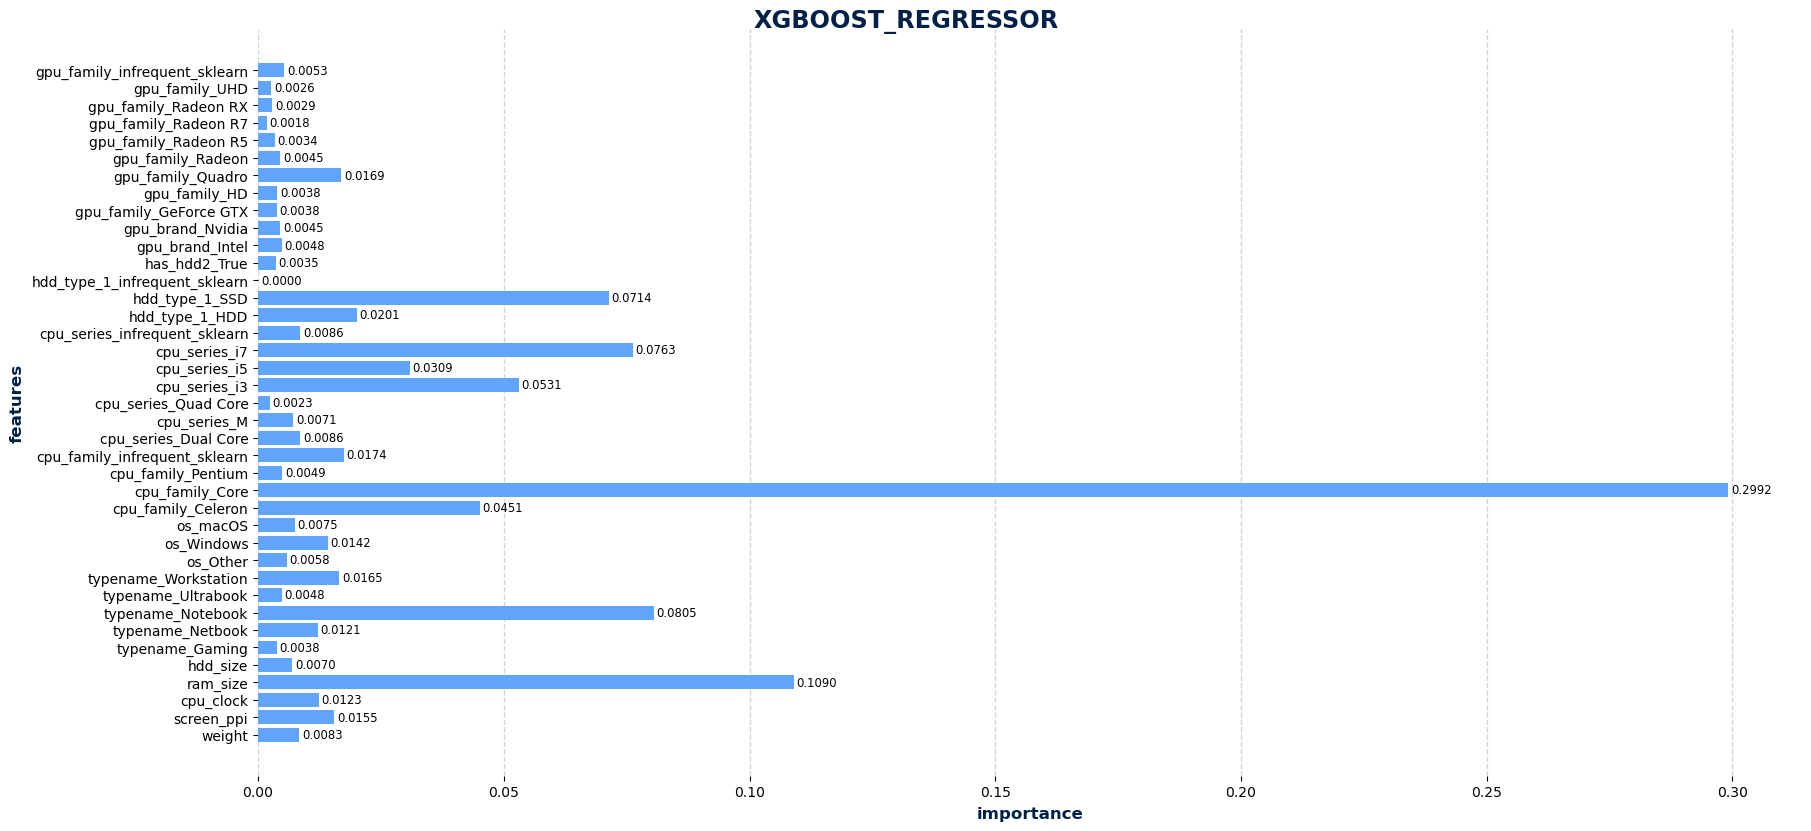

In [390]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()

columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="xgboost_regressor")

plot_feature_importance(data)

In [391]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 7] during transf

--------------------
TRAIN
--------------------
RMSE: 280.238
R2: 81.98
--------------------
TEST
--------------------
RMSE: 332.94
R2: 0.80
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [444]:
df_data = pd.concat([df_train, df_test])
df_data.head()

company        product     typename  inches       os  weight  \
laptop_ID                                                                
1118           HP       ZBook 17  Workstation    17.3  Windows    3.00   
153          Dell  Inspiron 5577       Gaming    15.6  Windows    2.56   
275         Apple    MacBook Pro    Ultrabook    13.3    macOS    1.37   
1100           HP  EliteBook 840     Notebook    14.0  Windows    1.54   
131          Dell  Inspiron 5770     Notebook    17.3  Windows    2.80   

             price  has_touchscreen screen_panel screen_type  ... hdd_size_2  \
laptop_ID                                                     ...              
1118       2899.00            False    IPS Panel     Full HD  ...        0.0   
153        1249.26            False      unknown     Full HD  ...        0.0   
275        1958.90            False    IPS Panel     Quad HD  ...        0.0   
1100       1030.99            False      unknown     Full HD  ...        0.0   
131        1396.00            False      unknown     Full HD  ...     2048.0   

           hdd_type_2  gpu_brand   gpu_family gpu_model gpu_integrated  \
laptop_ID                                                                
1118          unknown        AMD      FirePro    W6150M          False   
153           unknown     Nvidia  GeForce GTX      1050          False   
275           unknown      Intel         Iris       550           True   
1100          unknown      Intel           HD       520           True   
131               HDD        AMD       Radeon       530          False   

          has_hdd2 log_price  hdd_size  gpu_model_recategorization  
laptop_ID                                                           
1118         False  7.972466      1024                      W6150M  
153          False  7.131107       512                     unknown  
275          False  7.580649       512                       other  
1100         False  6.939244       500                     unknown  
131           True  7.242082      2304                     unknown  

[5 rows x 32 columns]

## Train for win

In [451]:
#df_test.set_index("laptop_id", inplace=True)
df_test.to_csv(path_or_buf=f"{path}/df_test_formated.csv", index=True)
df_train.to_csv(path_or_buf=f"{path}/df_train_formated.csv", index=True)

In [445]:
model.fit(df_data, df_data["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...
                                                                   gamma=0.003,
                                                                   grow_policy='depthwise',
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.01,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=1,
                                                                   max_depth=4,
                                                                   max_leaves=None,
                                                                   min_child_weight=3.76,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=4837,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]))

In [446]:
predictions = model.predict(X_pred)
submission = pd.DataFrame(predictions,
						  columns=["Price_in_euros"],
						  index=X_pred.index)
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})
submission.to_csv("submission.csv", index=False)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2, 3, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### Miscellaneous

In [452]:
from sklearn.preprocessing import PolynomialFeatures

In [553]:
df_train.columns

Index(['company', 'product', 'typename', 'inches', 'os', 'weight', 'price',
       'has_touchscreen', 'screen_panel', 'screen_type', 'screen_resolution',
       'screen_width', 'screen_height', 'screen_ppi', 'cpu_brand',
       'cpu_family', 'cpu_series', 'cpu_gen', 'cpu_clock', 'ram_size',
       'hdd_size_1', 'hdd_type_1', 'hdd_size_2', 'hdd_type_2', 'gpu_brand',
       'gpu_family', 'gpu_model', 'gpu_integrated', 'has_hdd2', 'log_price',
       'hdd_size', 'gpu_model_recategorization'],
      dtype='str')

In [579]:
columns_to_logn = ["screen_ppi", "cpu_clock"]
columns_to_log2 = ["ram_size", "hdd_size"]
columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
#   "cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_gen",
	"hdd_type_1",
	"has_hdd2",
#	"gpu_brand",
	"gpu_family",
	"gpu_model",
	"gpu_integrated"
]


# logn
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
logn_pipeline = Pipeline(
	steps = [
		("logn", log_natural_transformer),
		("scale", StandardScaler())
	]
)

# log2
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
log2_pipeline = Pipeline(
	steps = [
		("log2", log2_transformer),
		("scale", StandardScaler()),
	]
)

# numbers
numeric_transformer = ColumnTransformer(
	transformers=[
		("numeric_to_logn", logn_pipeline, columns_to_logn),
		("numeric_to_log2", log2_pipeline, columns_to_log2),
	],
	n_jobs=-1
)


#polynomial_features = PolynomialFeatures(degree=1)
numeric_pipeline = Pipeline(
	steps = [
		("number_transform", numeric_transformer)
		#("polynomial", polynomial_features)
		#("pca", PCA(n_components=6, svd_solver="full", random_state=42))
	]
)


linear_transformer = ColumnTransformer(
	transformers=[
		(
			"numeric_transformer",
			numeric_pipeline,
			columns_to_logn + columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				drop="first",
				handle_unknown="ignore",
				min_frequency=7
			),
			columns_to_ohe
		)
		# (
		#     "to_encode_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     columns_to_oe
		# )
	],
	n_jobs=-1
)

In [576]:
elastic_net = ElasticNet(
	alpha=.007,
	l1_ratio=.009,
	max_iter=10000,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('numeric_transformer',
                                                                                       Pipeline(steps=[('number_transform',
                                                                                                        ColumnTransformer(n_jobs=-1,
                                                                                                                          transformers=[('numeric_to_logn',
                                                                                                                                         Pipeline(steps=[('logn',
                                                                                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                                                         ('sc...
                                                                                        'cpu_clock',
                                                                                        'ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=7),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_gen',
                                                                                        'hdd_type_1',
                                                                                        'has_hdd2',
                                                                                        'gpu_family',
                                                                                        'gpu_model',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.007,
                                                                 l1_ratio=0.009,
                                                                 max_iter=10000,
                                                                 random_state=42))]))

Ordenada al origen: 6.448884565534876


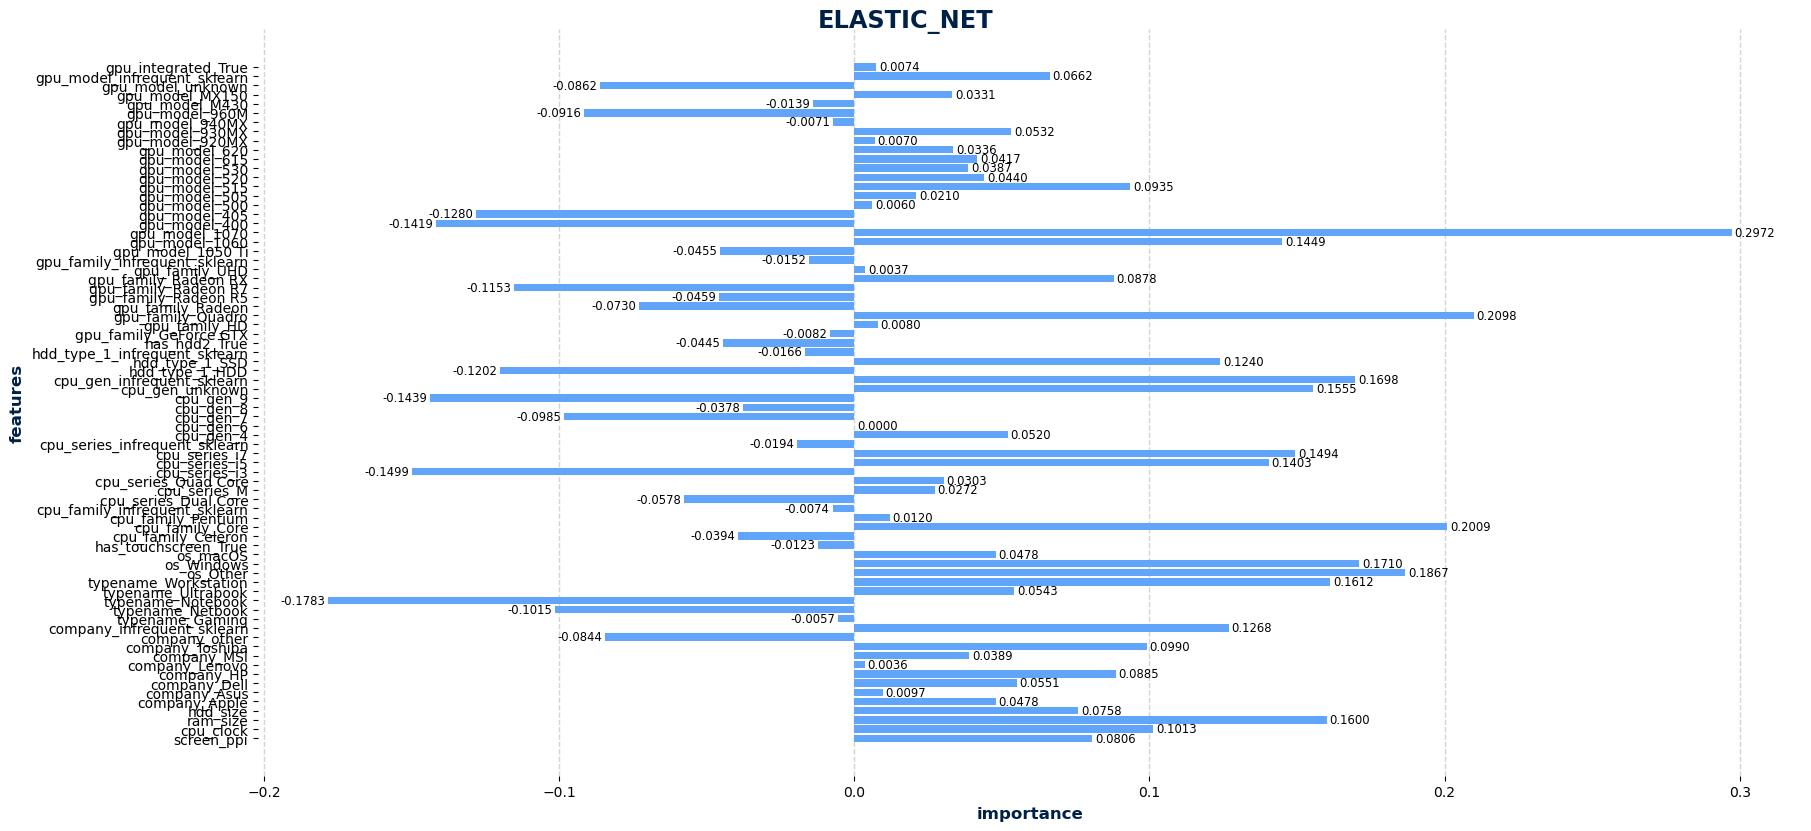

In [580]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="elastic_net")

plot_feature_importance(data)

In [584]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

--------------------
TRAIN
--------------------
RMSE: 335.913
R2: 74.34
--------------------
TEST
--------------------
RMSE: 362.34
R2: 0.76
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] 

#### `ElasticNet`

In [585]:
def objective(trial):
	elastic_net = ElasticNet(
		alpha=trial.suggest_float("alpha", 1e-4, 10, log=True),
	    l1_ratio=trial.suggest_float("l1_ratio", 0.01, 0.9),
	    max_iter=10000,
	    tol=1e-4,
	    selection="cyclic",
	    random_state=42
	)

	pipeline = Pipeline(
		steps=[
			("preprocessing", linear_transformer),
			("regressor", elastic_net)
		]
	)

	model = TransformedTargetRegressor(
		regressor=pipeline,
		func=np.log1p,
		inverse_func=np.expm1
	)

	results = cross_validate(
		model,
		df_train,
		df_train["price"],
		cv=kfold,
		return_train_score=True,
		scoring="neg_root_mean_squared_error",
		n_jobs=-1
	)
	
	return results["test_score"].mean()


sampler = optuna.samplers.TPESampler(
    multivariate=True,
    group=True,
    n_startup_trials=40,
    constant_liar=True
)

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)

study.optimize(objective, n_trials=100, n_jobs=-1)

/tmp/ipykernel_98366/3079117537.py:37: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  sampler = optuna.samplers.TPESampler(
/tmp/ipykernel_98366/3079117537.py:37: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  sampler = optuna.samplers.TPESampler(
/tmp/ipykernel_98366/3079117537.py:37: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  sampler = optuna.samplers.TPESampler(
[I 2026-02-20 01:39:15,119] A new study created in memory with name: no-name-8c1f8443-99da-4f05-9797-5ce54e031c38
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/data

In [586]:
study.best_params

{'alpha': 0.004380399528252467, 'l1_ratio': 0.014698329251623399}

In [587]:
elastic_net = ElasticNet(
	alpha=.0043,
	l1_ratio=.014,
	max_iter=10000,
	tol=1e-4,
	selection="cyclic",
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('numeric_transformer',
                                                                                       Pipeline(steps=[('number_transform',
                                                                                                        ColumnTransformer(n_jobs=-1,
                                                                                                                          transformers=[('numeric_to_logn',
                                                                                                                                         Pipeline(steps=[('logn',
                                                                                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                                                         ('sc...
                                                                                        'cpu_clock',
                                                                                        'ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     min_frequency=7),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_family',
                                                                                        'cpu_series',
                                                                                        'cpu_gen',
                                                                                        'hdd_type_1',
                                                                                        'has_hdd2',
                                                                                        'gpu_family',
                                                                                        'gpu_model',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.0043,
                                                                 l1_ratio=0.014,
                                                                 max_iter=10000,
                                                                 random_state=42))]))

In [588]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
print("TRAIN")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"RMSE: {rmse:.3f}")
print(f"R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)


predict = model.predict(df_test.drop(columns=["price", "log_price"]))
rmse = root_mean_squared_error(df_test["price"], predict)
r2 = r2_score(df_test["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 10] 

--------------------
TRAIN
--------------------
RMSE: 335.338
R2: 74.47
--------------------
TEST
--------------------
RMSE: 358.57
R2: 0.77
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


-----------------------------------------------------------------

In [591]:
features = ["screen_ppi", "cpu_clock", "ram_size", "hdd_size", "company",
			"typename", "os", "has_touchscreen", "cpu_family", "cpu_series",
			"cpu_gen", "hdd_type_1", "has_hdd2", "gpu_family", "gpu_model",
			"gpu_integrated"]

In [605]:
xgboost_regressor = XGBRegressor(
	n_estimators=1891,
	learning_rate=0.061,
	max_depth=4,
	min_child_weight=9,
	gamma=0.021,
	subsample=0.95,
	colsample_bytree=0.64,
	reg_alpha=0.65,
	reg_lambda=5.57,
	max_delta_step=1,
	eval_metric="rmse",
	enable_categorical=True,
	objective="reg:squarederror",
	tree_method="hist",
	random_state=42,
	n_jobs=-1
)

xgboost_regressor.fit(df_train[features], np.log1p(df_train["price"]))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.64, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.021, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.061, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=1, max_depth=4,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1891,
             n_jobs=-1, num_parallel_tree=None, ...)

In [612]:
predict = xgboost_regressor.predict(df_train[features])
rmse = root_mean_squared_error(np.log1p(df_train["price"]), np.expm1(predict))
r2 = r2_score(df_train["price"], predict)
print("TEST")
print("-"*20)
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")
print("-"*20)

TEST
--------------------
RMSE: 1230.00
R2: -2.66
--------------------


## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [392]:
X_pred = pd.read_csv("./data/test.csv")
X_pred.head()

laptop_ID Company                          Product            TypeName  \
0        209  Lenovo               Legion Y520-15IKBN              Gaming   
1       1281    Acer                   Aspire ES1-531            Notebook   
2       1168  Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3       1231    Dell                    Inspiron 7579  2 in 1 Convertible   
4       1020      HP                      ProBook 640            Notebook   

   Inches                           ScreenResolution  \
0    15.6                          Full HD 1920x1080   
1    15.6                                   1366x768   
2    15.6                                   1366x768   
3    15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4    14.0                          Full HD 1920x1080   

                                    Cpu   Ram     Memory  \
0           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD   
1  Intel Celeron Dual Core N3060 1.6GHz   4GB  500GB HDD   
2            Intel Core i3 6006U 2.0GHz   4GB    1TB HDD   
3            Intel Core i5 7200U 2.5GHz   8GB  256GB SSD   
4            Intel Core i5 7200U 2.5GHz   4GB  256GB SSD   

                       Gpu       OpSys   Weight  
0  Nvidia GeForce GTX 1060       No OS    2.4kg  
1    Intel HD Graphics 400       Linux    2.4kg  
2    Intel HD Graphics 520       No OS    1.9kg  
3    Intel HD Graphics 620  Windows 10  2.191kg  
4    Intel HD Graphics 620  Windows 10   1.95kg

In [109]:
X_pred.tail()

laptop_ID  Company          Product            TypeName  Inches  \
386        820      MSI      GE72MVR 7RG              Gaming    17.3   
387        948  Toshiba  Tecra Z40-C-12X            Notebook    14.0   
388        483     Dell  Precision M5520         Workstation    15.6   
389       1017       HP      Probook 440            Notebook    14.0   
390        421     Asus     ZenBook Flip  2 in 1 Convertible    13.3   

                              ScreenResolution                          Cpu  \
386                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
387                IPS Panel Full HD 1920x1080   Intel Core i5 6200U 2.3GHz   
388                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
389                                   1366x768   Intel Core i5 7200U 2.5GHz   
390  IPS Panel Full HD / Touchscreen 1920x1080   Intel Core i5 7200U 2.5GHz   

      Ram                Memory                      Gpu       OpSys  Weight  
386  16GB  512GB SSD +  1TB HDD  Nvidia GeForce GTX 1070  Windows 10   2.9kg  
387   4GB             128GB SSD    Intel HD Graphics 520  Windows 10  1.47kg  
388   8GB             256GB SSD      Nvidia Quadro M1200  Windows 10  1.78kg  
389   4GB             500GB HDD    Intel HD Graphics 620  Windows 10  1.64kg  
390   8GB             256GB SSD    Intel HD Graphics 620  Windows 10  1.27kg

In [110]:
X_pred.info()

<class 'pandas.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         391 non-null    int64  
 1   Company           391 non-null    str    
 2   Product           391 non-null    str    
 3   TypeName          391 non-null    str    
 4   Inches            391 non-null    float64
 5   ScreenResolution  391 non-null    str    
 6   Cpu               391 non-null    str    
 7   Ram               391 non-null    str    
 8   Memory            391 non-null    str    
 9   Gpu               391 non-null    str    
 10  OpSys             391 non-null    str    
 11  Weight            391 non-null    str    
dtypes: float64(1), int64(1), str(10)
memory usage: 36.8 KB


### 2. Replicar el procesado para ``test.csv``

In [ ]:
X_pred.sample(10)

laptop_ID Company                                Product  \
15         743  Lenovo  V310-15IKB (i7-7500U/4GB/1TB/FHD/W10)   
315        301    Acer                        Aspire A715-71G   
281        363    Dell                          Inspiron 7577   
270        544      HP                                 250 G6   
366        868      HP                         EliteBook x360   
385        679  Lenovo           V310-15ISK (i5-7200U/8GB/1TB   
51          93    Acer                               Aspire 5   
289       1097  Lenovo                              Yoga Book   
119        220    Dell                          Inspiron 5370   
45         933     MSI                              GL62M 7RD   

               TypeName  Inches                 ScreenResolution  \
15             Notebook    15.6                Full HD 1920x1080   
315            Notebook    15.6                Full HD 1920x1080   
281              Gaming    15.6                Full HD 1920x1080   
270            Notebook    15.6                Full HD 1920x1080   
366  2 in 1 Convertible    13.3  Full HD / Touchscreen 1920x1080   
385            Notebook    15.6                Full HD 1920x1080   
51             Notebook    15.6                Full HD 1920x1080   
289  2 in 1 Convertible    10.1  IPS Panel Touchscreen 1920x1200   
119           Ultrabook    13.3      IPS Panel Full HD 1920x1080   
45               Gaming    15.6                Full HD 1920x1080   

                                      Cpu  Ram                Memory  \
15             Intel Core i7 7500U 2.7GHz  4GB               1TB HDD   
315           Intel Core i7 7700HQ 2.8GHz  8GB             256GB SSD   
281           Intel Core i5 7300HQ 2.5GHz  8GB               1TB HDD   
270  Intel Pentium Quad Core N3710 1.6GHz  4GB             256GB SSD   
366            Intel Core i7 7600U 2.8GHz  8GB             256GB SSD   
385            Intel Core i5 7200U 2.5GHz  8GB  128GB SSD +  1TB HDD   
51             Intel Core i7 8550U 1.8GHz  8GB               1TB HDD   
289           Intel Atom x5-Z8550 1.44GHz  4GB    64GB Flash Storage   
119            Intel Core i7 8550U 1.8GHz  8GB             256GB SSD   
45            Intel Core i5 7300HQ 2.5GHz  8GB  128GB SSD +  1TB HDD   

                            Gpu       OpSys  Weight  
15        Intel HD Graphics 620  Windows 10  1.85kg  
315  Nvidia GeForce GTX 1050 Ti       Linux   2.5kg  
281     Nvidia GeForce GTX 1050  Windows 10  2.65kg  
270       Intel HD Graphics 405  Windows 10  1.86kg  
366       Intel HD Graphics 620  Windows 10  1.28kg  
385          AMD Radeon R5 M430  Windows 10  1.90kg  
51         Nvidia GeForce MX150  Windows 10   2.2kg  
289       Intel HD Graphics 400  Windows 10  0.69kg  
119              AMD Radeon 530  Windows 10   1.4kg  
45      Nvidia GeForce GTX 1050  Windows 10   2.2kg

#### `ScreenResolution`

In [393]:
screen_data = X_pred["ScreenResolution"].apply(extract_screen_data)
X_pred = pd.concat([X_pred, pd.DataFrame(screen_data.tolist())], axis=1)
columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
X_pred.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel  \
59                 IPS Panel Full HD 1920x1080            False    IPS Panel   
33                           Full HD 1920x1080            False          NaN   
73   IPS Panel Full HD / Touchscreen 1920x1080             True    IPS Panel   
202            IPS Panel 4K Ultra HD 3840x2160            False    IPS Panel   
14                                    1366x768            False          NaN   

    screen_type screen_resolution  
59      Full HD         1920x1080  
33      Full HD         1920x1080  
73      Full HD         1920x1080  
202    Ultra HD         3840x2160  
14          NaN          1366x768

In [394]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

ScreenResolution  has_touchscreen screen_panel screen_type  \
0    Full HD 1920x1080            False          NaN     Full HD   
1             1366x768            False          NaN         NaN   
2             1366x768            False          NaN         NaN   
4    Full HD 1920x1080            False          NaN     Full HD   
5             1600x900            False          NaN         NaN   
..                 ...              ...          ...         ...   
383           1366x768            False          NaN         NaN   
385  Full HD 1920x1080            False          NaN     Full HD   
386  Full HD 1920x1080            False          NaN     Full HD   
388  Full HD 1920x1080            False          NaN     Full HD   
389           1366x768            False          NaN         NaN   

    screen_resolution  
0           1920x1080  
1            1366x768  
2            1366x768  
4           1920x1080  
5            1600x900  
..                ...  
383          1366x768  
385         1920x1080  
386         1920x1080  
388         1920x1080  
389          1366x768  

[291 rows x 5 columns]

In [395]:
X_pred["screen_type"] = X_pred["screen_resolution"].apply(screen_tier)

data = X_pred["screen_resolution"].str.split("x", expand=True).astype(int)
X_pred = pd.concat(
	[
		X_pred,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

X_pred["screen_ppi"] = round(
	((X_pred["screen_width"]**2 + X_pred["screen_height"]**2)**0.5)/X_pred["Inches"],
	2
)

X_pred.fillna({"screen_panel": "unknown"}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu       OpSys   Weight  has_touchscreen  \
0    Nvidia GeForce GTX 1060       No OS    2.4kg            False   
1      Intel HD Graphics 400       Linux    2.4kg            False   
2      Intel HD Graphics 520       No OS    1.9kg            False   
3      Intel HD Graphics 620  Windows 10  2.191kg             True   
4      Intel HD Graphics 620  Windows 10   1.95kg            False   
..                       ...         ...      ...              ...   
386  Nvidia GeForce GTX 1070  Windows 10    2.9kg            False   
387    Intel HD Graphics 520  Windows 10   1.47kg            False   
388      Nvidia Quadro M1200  Windows 10   1.78kg            False   
389    Intel HD Graphics 620  Windows 10   1.64kg            False   
390    Intel HD Graphics 620  Windows 10   1.27kg             True   

    screen_panel screen_type screen_resolution  screen_width  screen_height  \
0        unknown     Full HD         1920x1080          1920           1080   
1        unknown          HD          1366x768          1366            768   
2        unknown          HD          1366x768          1366            768   
3      IPS Panel     Full HD         1920x1080          1920           1080   
4        unknown     Full HD         1920x1080          1920           1080   
..           ...         ...               ...           ...            ...   
386      unknown     Full HD         1920x1080          1920           1080 

In [396]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [ScreenResolution, has_touchscreen, screen_panel, screen_type, screen_resolution]
Index: []

In [397]:
X_pred["screen_resolution"] = X_pred["screen_resolution"].astype("category")
X_pred["screen_type"] = X_pred["screen_type"].astype("category")
X_pred["screen_panel"] = X_pred["screen_panel"].astype("category")

#### `CPU`

In [398]:
cpu_data = pd.DataFrame(X_pred.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
X_pred = pd.concat([X_pred, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_gen",
	"cpu_clock",
]
X_pred.sample(5).loc[:, columns]

Cpu cpu_brand cpu_family cpu_series cpu_gen  \
11    Intel Core i5 8250U 1.6GHz     Intel       Core         i5       8   
296   Intel Core i7 6500U 2.5GHz     Intel       Core         i7       6   
202  Intel Core i7 6700HQ 2.6GHz     Intel       Core         i7       6   
271   Intel Core i5 7200U 2.5GHz     Intel       Core         i5       7   
358  Intel Core i5 7300HQ 2.5GHz     Intel       Core         i5       7   

    cpu_clock  
11        1.6  
296       2.5  
202       2.6  
271       2.5  
358       2.5

In [399]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Cpu cpu_brand cpu_family cpu_series cpu_gen  \
27   Samsung Cortex A72&A53 2.0GHz   Samsung     Cortex    A72&A53     NaN   
37             AMD FX 8800P 2.1GHz       AMD         FX        NaN       8   
41        Intel Core M 6Y30 0.9GHz     Intel       Core          M     NaN   
60            Intel Core i7 2.9GHz     Intel       Core         i7     NaN   
69             AMD Ryzen 1700 3GHz       AMD      Ryzen        NaN       1   
102           Intel Core i5 2.3GHz     Intel       Core         i5     NaN   
126       Intel Core M 6Y75 1.2GHz     Intel       Core          M     NaN   
142            Intel Core M 1.1GHz     Intel       Core          M     NaN   
221            Intel Core M 1.2GHz     Intel       Core          M     NaN   
234       AMD E-Series 7110 1.8GHz       AMD   E-Series        NaN       7   
267       AMD E-Series 9000 2.2GHz       AMD   E-Series        NaN       9   
269      Intel Core i5 7Y57 1.2GHz     Intel       Core         i5     NaN   
295      Intel Core i7 7Y75 1.3GHz     Intel       Core         i7     NaN   
300      Intel Core i5 7Y54 1.2GHz     Intel       Core         i5     NaN   
373      Intel Core i5 7Y54 1.2GHz     Intel       Core         i5     NaN   

    cpu_clock  
27        2.0  
37        2.1  
41        0.9  
60        2.9  
69          3  
102       2.3  
126       1.2  
142       1.1  
221       1.2  
234       1.8  
267       2.2  
269       1.2  
295       1.3  
300       1.2  
373       1.2

In [400]:
X_pred.fillna({"cpu_series": "unknown", "cpu_gen": "unknown"}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... screen_type screen_resolution  screen_width  \
0    Nvidia GeForce GTX 1060  ...     Full HD         1920x1080          1920   
1      Intel HD Graphics 400  ...          HD          1366x768          1366   
2      Intel HD Graphics 520  ...          HD          1366x768          1366   
3      Intel HD Graphics 620  ...     Full HD         1920x1080          1920   
4      Intel HD Graphics 620  ...     Full HD         1920x1080          1920   
..                       ...  ...         ...               ...           ...   
386  Nvidia GeForce GTX 1070  ...     Full HD         1920x1080          1920   
387    Intel HD Graphics 520  ...     Full HD         1920x1080          1920   
388      Nvidia Quadro M1200  ...     Full HD         1920x1080          1920   
389    Intel HD Graphics 620  ...          HD          1366x768          1366   
390    Intel HD Graphics 620  ...     Full HD         1920x1080          1920   

    screen_height screen_ppi cpu_brand  cpu_family  cpu_series  cpu_gen  \
0            1080     141.21     Intel        Core          i7        7   
1             768     100.45     Intel     Celeron   Dual Core        3   
2             768     100.45     Intel        Core          i3        6   
3            1080     141.21     Intel        Core          i5        7   
4            1080     157.35     Intel        Core          i5        7   
..            ...        ...       ...         

In [401]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Cpu, cpu_brand, cpu_family, cpu_series, cpu_gen, cpu_clock]
Index: []

In [402]:
X_pred["cpu_brand"] = X_pred["cpu_brand"].astype("category")
X_pred["cpu_clock"] = X_pred["cpu_clock"].astype(float)
X_pred["cpu_family"] = X_pred["cpu_family"].astype("category")
X_pred["cpu_series"] = X_pred["cpu_series"].astype("category")
X_pred["cpu_gen"] = X_pred["cpu_gen"].astype("category")

#### `RAM`

In [403]:
ram_data = X_pred.loc[:, "Ram"].apply(extract_ram_data)
X_pred = pd.concat([X_pred, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
X_pred.sample(5).loc[:, columns]

Ram ram_size ram_capacity
380   4GB        4           GB
316  16GB       16           GB
280   4GB        4           GB
29    8GB        8           GB
169   8GB        8           GB

In [404]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Ram, ram_size, ram_capacity]
Index: []

In [405]:
X_pred["ram_size"] = X_pred["ram_size"].astype(int)
X_pred["ram_capacity"] = X_pred["ram_capacity"].astype("category")

In [406]:
X_pred["ram_capacity"].value_counts()

ram_capacity
GB    391
Name: count, dtype: int64

In [407]:
factor = {"GB": 1, "TB": 1024}
X_pred["ram_size"] = X_pred["ram_size"] * X_pred["ram_capacity"].map(factor).astype(int)

#### `HDD`

In [408]:
memory_data = X_pred.loc[:, "Memory"].apply(extract_memory_data)
X_pred = pd.concat([X_pred, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
X_pred.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2  \
136  128GB SSD +  1TB HDD        128             GB        SSD          1   
270             256GB SSD        256             GB        SSD        NaN   
148  128GB SSD +  1TB HDD        128             GB        SSD          1   
8               256GB SSD        256             GB        SSD        NaN   
139               1TB HDD          1             TB        HDD        NaN   

    hdd_capacity_2 hdd_type_2  
136             TB        HDD  
270            NaN        NaN  
148             TB        HDD  
8              NaN        NaN  
139            NaN        NaN

In [409]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2 hdd_capacity_2  \
0    512GB SSD        512             GB        SSD        NaN            NaN   
1    500GB HDD        500             GB        HDD        NaN            NaN   
2      1TB HDD          1             TB        HDD        NaN            NaN   
3    256GB SSD        256             GB        SSD        NaN            NaN   
4    256GB SSD        256             GB        SSD        NaN            NaN   
..         ...        ...            ...        ...        ...            ...   
384  256GB SSD        256             GB        SSD        NaN            NaN   
387  128GB SSD        128             GB        SSD        NaN            NaN   
388  256GB SSD        256             GB        SSD        NaN            NaN   
389  500GB HDD        500             GB        HDD        NaN            NaN   
390  256GB SSD        256             GB        SSD        NaN            NaN   

    hdd_type_2  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
384        NaN  
387        NaN  
388        NaN  
389        NaN  
390        NaN  

[327 rows x 7 columns]

In [410]:
X_pred.fillna(
	{
		"hdd_size_2": "0",
		"hdd_capacity_2": "unknown",
		"hdd_type_2": "unknown",
	},
	inplace=True
)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... cpu_gen cpu_clock  ram_size ram_capacity  \
0    Nvidia GeForce GTX 1060  ...       7       2.8        16           GB   
1      Intel HD Graphics 400  ...       3       1.6         4           GB   
2      Intel HD Graphics 520  ...       6       2.0         4           GB   
3      Intel HD Graphics 620  ...       7       2.5         8           GB   
4      Intel HD Graphics 620  ...       7       2.5         4           GB   
..                       ...  ...     ...       ...       ...          ...   
386  Nvidia GeForce GTX 1070  ...       7       2.8        16           GB   
387    Intel HD Graphics 520  ...       6       2.3         4           GB   
388      Nvidia Quadro M1200  ...       7       2.8         8           GB   
389    Intel HD Graphics 620  ...       7       2.5         4           GB   
390    Intel HD Graphics 620  ...       7       2.5         8           GB   

    hdd_size_1 hdd_capacity_1  hdd_type_1  hdd_size_2  hdd_capacity_2  \
0          512             GB         SSD           0         unknown   
1          500             GB         HDD           0         unknown   
2            1             TB         HDD           0         unknown   
3          256             GB         SSD           0         unknown   
4          256             GB         SSD           0         unknown   
..         ...            ...         ...         ...             ...   
386        512        

In [411]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Memory, hdd_size_1, hdd_capacity_1, hdd_type_1, hdd_size_2, hdd_capacity_2, hdd_type_2]
Index: []

In [412]:
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].str.replace("1.0", "1")
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].astype(int)

factor = {"GB": 1, "TB": 1024}
X_pred["hdd_size_1"] = X_pred["hdd_size_1"] * X_pred["hdd_capacity_1"].map(factor).astype(int)

In [413]:
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].str.replace("1.0", "1")
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(int)

factor = {"GB": 1, "TB": 1024, "unknown": 0}
X_pred["hdd_size_2"] = X_pred["hdd_size_2"] * X_pred["hdd_capacity_2"].map(factor).astype(int)

In [414]:
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(int)

X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].astype("category")
X_pred["hdd_type_1"] = X_pred["hdd_type_1"].astype("category")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].astype("category")
X_pred["hdd_type_2"] = X_pred["hdd_type_2"].astype("category")

In [415]:
X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].str.replace("TB", "GB")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].str.replace("TB", "GB")

In [416]:
mask = X_pred.loc[:, columns].isna().any(axis=1)
X_pred.loc[:, columns]

Memory  hdd_size_1 hdd_capacity_1 hdd_type_1  hdd_size_2  \
0               512GB SSD         512             GB        SSD           0   
1               500GB HDD         500             GB        HDD           0   
2                 1TB HDD        1024             GB        HDD           0   
3               256GB SSD         256             GB        SSD           0   
4               256GB SSD         256             GB        SSD           0   
..                    ...         ...            ...        ...         ...   
386  512GB SSD +  1TB HDD         512             GB        SSD        1024   
387             128GB SSD         128             GB        SSD           0   
388             256GB SSD         256             GB        SSD           0   
389             500GB HDD         500             GB        HDD           0   
390             256GB SSD         256             GB        SSD           0   

    hdd_capacity_2 hdd_type_2  
0          unknown    unknown  
1          unknown    unknown  
2          unknown    unknown  
3          unknown    unknown  
4          unknown    unknown  
..             ...        ...  
386             GB        HDD  
387        unknown    unknown  
388        unknown    unknown  
389        unknown    unknown  
390        unknown    unknown  

[391 rows x 7 columns]

#### `GPU`

In [417]:
columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = X_pred["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
X_pred = pd.concat([X_pred, data], axis=1)

columns.insert(0, "Gpu")
X_pred.sample(5).loc[:, columns]

Gpu gpu_brand   gpu_family gpu_model
90        AMD Radeon R7 M440       AMD    Radeon R7      M440
82     Intel HD Graphics 620     Intel  HD Graphics       620
130      Nvidia Quadro M2200    Nvidia       Quadro     M2200
128     Nvidia GeForce MX130    Nvidia      GeForce     MX130
91   Nvidia GeForce GTX 1060    Nvidia  GeForce GTX      1060

In [418]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand   gpu_family gpu_model
27        ARM Mali T860 MP4       NaN          NaN       NaN
108       Intel HD Graphics     Intel  HD Graphics       NaN
133  Nvidia GeForce GTX1080       NaN          NaN       NaN
136  Nvidia GeForce GTX1060       NaN          NaN       NaN
139       Intel HD Graphics     Intel  HD Graphics       NaN
195       Intel HD Graphics     Intel  HD Graphics       NaN
346       Intel HD Graphics     Intel  HD Graphics       NaN

In [419]:
X_pred.loc[133, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"
X_pred.loc[136, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, X_pred.loc[133, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[133, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[133, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[133, "gpu_model"] = is_match.group("model").strip()

is_match = re.search(pattern, X_pred.loc[136, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[136, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[136, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[136, "gpu_model"] = is_match.group("model").strip()


X_pred["gpu_family"] = X_pred["gpu_family"].str.replace("Graphics", "")

In [420]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand gpu_family gpu_model
27   ARM Mali T860 MP4       NaN        NaN       NaN
108  Intel HD Graphics     Intel        HD        NaN
139  Intel HD Graphics     Intel        HD        NaN
195  Intel HD Graphics     Intel        HD        NaN
346  Intel HD Graphics     Intel        HD        NaN

In [421]:
X_pred.loc[27, "gpu_brand"] = "ARM"
X_pred.loc[27, "gpu_family"] = "Mali"
X_pred.loc[27, "gpu_model"] = "T860 MP4"

In [422]:
X_pred.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... ram_capacity hdd_size_1  hdd_capacity_1  \
0    Nvidia GeForce GTX 1060  ...           GB        512              GB   
1      Intel HD Graphics 400  ...           GB        500              GB   
2      Intel HD Graphics 520  ...           GB       1024              GB   
3      Intel HD Graphics 620  ...           GB        256              GB   
4      Intel HD Graphics 620  ...           GB        256              GB   
..                       ...  ...          ...        ...             ...   
386  Nvidia GeForce GTX 1070  ...           GB        512              GB   
387    Intel HD Graphics 520  ...           GB        128              GB   
388      Nvidia Quadro M1200  ...           GB        256              GB   
389    Intel HD Graphics 620  ...           GB        500              GB   
390    Intel HD Graphics 620  ...           GB        256              GB   

    hdd_type_1 hdd_size_2 hdd_capacity_2  hdd_type_2  gpu_brand   gpu_family  \
0          SSD          0        unknown     unknown     Nvidia  GeForce GTX   
1          HDD          0        unknown     unknown      Intel          HD    
2          HDD          0        unknown     unknown      Intel          HD    
3          SSD          0        unknown     unknown      Intel          HD    
4          SSD          0        unknown     unknown      Intel          HD    
..         ...        ...            ...         ...        ...  

In [423]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Empty DataFrame
Columns: [Gpu, gpu_brand, gpu_family, gpu_model]
Index: []

In [424]:
X_pred["gpu_brand"] = X_pred["gpu_brand"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")
X_pred["gpu_model"] = X_pred["gpu_model"].astype("category")

columns = X_pred.iloc[:, -3:].columns
for column in columns:
	X_pred[column] = X_pred[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(X_pred[column].value_counts())
	print("-"*30)

gpu_brand
Intel     213
Nvidia    116
AMD        61
ARM         1
Name: count, dtype: int64
------------------------------
gpu_family
HD             195
GeForce GTX     68
GeForce         35
Radeon          25
UHD             16
Radeon R5       15
Radeon R7       12
Quadro          12
Iris Plus        2
Radeon RX        2
Radeon R2        2
Mali             1
Radeon R9        1
Radeon Pro       1
GeForce GT       1
FirePro          1
Radeon R4        1
Radeon R3        1
Name: count, dtype: int64
------------------------------
gpu_model
620         112
520          66
530          20
1050         18
1060         17
940MX        14
500          12
             11
1050 Ti       9
1070          8
400           7
M445          7
930MX         6
MX150         5
1080          4
505           4
615           4
920MX         4
980M          4
M1200         4
M430          4
unknown       4
515           3
960M          3
M330          3
MX130         3
630           2
640           2
M2200    

#### `Limpieza`

In [425]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
X_pred.drop(columns=to_delete, inplace=True)

X_pred["Company"] = X_pred["Company"].astype("category")
X_pred["TypeName"] = X_pred["TypeName"].astype("category")
# X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["Inches"] = X_pred["Inches"].astype(float)
X_pred["Weight"] = X_pred["Weight"].apply(lambda x: x.replace("kg", ""))
X_pred["Weight"] = X_pred["Weight"].astype(float)

In [426]:
X_pred["OpSys"].unique()

<StringArray>
[       'No OS',        'Linux',   'Windows 10',    'Windows 7',
    'Chrome OS',        'macOS',     'Mac OS X', 'Windows 10 S']
Length: 8, dtype: str

In [427]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

X_pred.replace(maps, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches    OpSys  Weight  has_touchscreen screen_panel screen_type  ...  \
0      15.6    No OS   2.400            False      unknown     Full HD  ...   
1      15.6    Linux   2.400            False      unknown          HD  ...   
2      15.6    No OS   1.900            False      unknown          HD  ...   
3      15.6  Windows   2.191             True    IPS Panel     Full HD  ...   
4      14.0  Windows   1.950            False      unknown     Full HD  ...   
..      ...      ...     ...              ...          ...         ...  ...   
386    17.3  Windows   2.900            False      unknown     Full HD  ...   
387    14.0  Windows   1.470            False    IPS Panel     Full HD  ...   
388    15.6  Windows   1.780            False      unknown     Full HD  ...   
389    14.0  Windows   1.640            False      unknown          HD  ...   
390    13.3  Windows   1.270             True    IPS Panel     Full HD  ...   

    ram_capacity  hdd_size_1  hdd_capacity_1  hdd_type_1 hdd_size_2  \
0             GB         512              GB         SSD          0   
1             GB         500              GB         HDD          0   
2             GB        1024              GB         HDD          0   
3             GB         256              GB         SSD          0   
4             GB         256              GB         SSD          0   
..           ...         ...             ...         ...        ...   
386           GB         512              GB         SSD       1024   
387           GB         128              GB         SSD          0   
388           GB         256              GB         SSD          0   
389           GB         500              GB         HDD          0   
390           GB         256              GB         SSD          0   

    hdd_capacity_2 hdd_type_2 gpu_brand   gpu_family  gpu_model  
0          unknown    unknown    Nvidia  GeForce GTX       1060  
1          unknown    unknown     Intel           HD        400  
2          unknown    unknown     Intel           HD        520  
3          unknown    unknown     Intel           HD        620  
4          unknown    unknown     Intel           HD        620  
..             ...        ...       ...          ...        ...  
386             GB        HDD    Nvidia  GeForce GTX       1070  
387        unknown    unknown     Intel           HD        520  
388        unknown    unknown    Nvidia       Quadro      M1200  
389        unknown    unknown     Intel           HD        620  
390        unknown    unknown     Intel           HD        620  

[391 rows x 30 columns]

In [428]:
X_pred.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)


X_pred["gpu_integrated"] = X_pred["gpu_brand"].str.contains("intel", case=False)
X_pred["has_hdd2"] = X_pred["hdd_size_2"] != 0

X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")

In [429]:
X_pred.rename(str.lower, axis="columns", inplace=True)
X_pred.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [430]:
X_pred["hdd_size"] = (
	X_pred["hdd_size_1"] + X_pred["hdd_size_2"]
).astype(int)

X_pred[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)
X_pred["os"] = X_pred["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company                         product  typename  inches  \
314        374    Dell                   Inspiron 5567  Notebook    15.6   
226       1006  Lenovo  V110-15IAP (N3350/4GB/128GB/No  Notebook    15.6   
310         47  Lenovo               IdeaPad 320-15ISK  Notebook    15.6   
330        147      HP                          255 G6  Notebook    15.6   
249       1217     MSI                      GS73VR 7RF    Gaming    17.3   

          os  weight  has_touchscreen screen_panel screen_type  ...  \
314  Windows    2.33            False      unknown     Full HD  ...   
226  Free OS    1.90            False      unknown          HD  ...   
310  Free OS    2.20            False      unknown          HD  ...   
330  Windows    1.86            False      unknown          HD  ...   
249  Windows    2.43            False      unknown     Full HD  ...   

    hdd_size_1  hdd_type_1  hdd_size_2  hdd_type_2 gpu_brand   gpu_family  \
314        256         SSD           0     unknown       AMD    Radeon R7   
226        128         SSD           0     unknown     Intel           HD   
310        128         SSD           0     unknown     Intel           HD   
330        256         SSD           0     unknown       AMD    Radeon R4   
249        256         SSD        1024         HDD    Nvidia  GeForce GTX   

    gpu_model gpu_integrated  has_hdd2  hdd_size  
314      M445          False     False       256  
226       500           True     False       128  
310       520           True     False       128  
330                    False     False       256  
249      1060          False      True      1280  

[5 rows x 30 columns]

In [431]:
X_pred.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)
X_pred["gpu_model_recategorization"] = X_pred[
	"gpu_model"
].apply(recategorization)

In [432]:
X_pred["company"] = X_pred["company"].astype(str)
maps = {
	"company": {
		"Fujitsu": "other",
		"Mediacom": "other",
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company                                product   typename  \
228        707      HP  15-bs011nv (i7-7500U/4GB/500GB/Radeon   Notebook   
158          3      HP                                 250 G6   Notebook   
215        975  Lenovo                          ThinkPad X270  Ultrabook   
293        668    Dell                         Latitude E7470   Notebook   
274        113    Asus                           VivoBook S15  Ultrabook   

     inches       os  weight  has_touchscreen screen_panel screen_type  ...  \
228    15.6  Windows    2.10            False    IPS Panel     Full HD  ...   
158    15.6  Free OS    1.86            False      unknown     Full HD  ...   
215    12.5  Windows    1.36            False    IPS Panel     Full HD  ...   
293    14.0  Windows    1.56            False      unknown     Full HD  ...   
274    15.6  Windows    1.50            False      unknown     Full HD  ...   

    hdd_type_1  hdd_size_2  hdd_type_2  gpu_brand gpu_family gpu_model  \
228        HDD           0     unknown        AMD     Radeon       530   
158        SSD           0     unknown      Intel         HD       620   
215        SSD           0     unknown      Intel         HD       620   
293        SSD           0     unknown      Intel         HD       520   
274        SSD        1024         HDD     Nvidia    GeForce     MX150   

    gpu_integrated has_hdd2  hdd_size  gpu_model_recategorization  
228          False    False       500                     unknown  
158           True    False       256                     unknown  
215           True    False       256                     unknown  
293           True    False       256                     unknown  
274          False     True      1280                     unknown  

[5 rows x 31 columns]

### Predecir

In [448]:
#X_pred.set_index("laptop_id", inplace=True)
X_pred.to_csv(path_or_buf=f"{path}/X_pred_formated.csv", index=True)

In [449]:
X_pred.head()

company                          product            typename  \
laptop_id                                                                
209        Lenovo               Legion Y520-15IKBN              Gaming   
1281         Acer                   Aspire ES1-531            Notebook   
1168       Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
1231         Dell                    Inspiron 7579  2 in 1 Convertible   
1020           HP                      ProBook 640            Notebook   

           inches       os  weight  has_touchscreen screen_panel screen_type  \
laptop_id                                                                      
209          15.6  Free OS   2.400            False      unknown     Full HD   
1281         15.6  Free OS   2.400            False      unknown          HD   
1168         15.6  Free OS   1.900            False      unknown          HD   
1231         15.6  Windows   2.191             True    IPS Panel     Full HD   
1020         14.0  Windows   1.950            False      unknown     Full HD   

          screen_resolution  ...  hdd_type_1  hdd_size_2  hdd_type_2  \
laptop_id                    ...                                       
209               1920x1080  ...         SSD           0     unknown   
1281               1366x768  ...         HDD           0     unknown   
1168               1366x768  ...         HDD           0     unknown   
1231              1920x1080  ...         SSD           0     unknown   
1020              1920x1080  ...         SSD           0     unknown   

          gpu_brand   gpu_family gpu_model gpu_integrated  has_hdd2  hdd_size  \
laptop_id                                                                       
209          Nvidia  GeForce GTX      1060          False     False       512   
1281          Intel           HD       400           True     False       500   
1168          Intel           HD       520           True     False      1024   
1231          Intel           HD       620           True     False       256   
1020          Intel           HD       620           True     False       256   

           gpu_model_recategorization  
laptop_id                              
209                           unknown  
1281                          unknown  
1168                          unknown  
1231                          unknown  
1020                          unknown  

[5 rows x 30 columns]

In [ ]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]


log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size"]




logn_pipeline = Pipeline(
	steps = [
		("logn", log_natural_transformer),
		("scale", StandardScaler())
	]
)


log2_pipeline = Pipeline(
	steps = [
		("log2", log2_transformer),
		("scale", StandardScaler()),
	]
)


numeric_transformer = ColumnTransformer(
	transformers=[
		("numeric_to_logn", logn_pipeline, columns_to_logn),
		("numeric_to_log2", log2_pipeline, columns_to_log2),
	],
	n_jobs=-1
)


polynomial_features = PolynomialFeatures(degree=4,
										 interaction_only=True,
										 include_bias=True)
numeric_pipeline = Pipeline(
	steps = [
		("number_transform", numeric_transformer)
		#("polynomial", polynomial_features)
		#("pca", PCA(n_components=6, svd_solver="full", random_state=42))
	]
)


columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
	#"cpu_brand",
	"cpu_family",
	"hdd_type_1",
	"hdd_type_2",
	#"gpu_brand",
	#"gpu_family",
	"gpu_model_recategorization",
	#"gpu_integrated",
	#"screen_type"
]


# columns_to_oe = ["cpu_gen"]
# ordinal_categories = [
#     [0, 1, 3, 4, 6, 7, 8, 9]
# ]


linear_transformer = ColumnTransformer(
	transformers=[
		(
			"numeric_transformer",
			numeric_pipeline,
			columns_to_logn + columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(
				drop="first",
				min_frequency=5,
				handle_unknown="ignore"
			),
			columns_to_ohe
		)
		# (
		#     "to_encode_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     columns_to_oe
		# )
	],
	n_jobs=-1
)

In [ ]:
from xgboost import XGBRFRegressor, XGBRegressor

In [ ]:
xgboost = XGBRegressor(
	n_estimators=1000,
	max_depth=6,
	eta=1,
	learning_rate=0.01,
	gamma=1,
	reg_alpha=1,
	reg_lambda=1,
	eval_metric = "rmse",
	objective = "reg:squarederror",
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist")

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", xgboost)
	]
)

pipeline.fit(df_train, df_train["log_price"])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('number_transform',
                                                                   ColumnTransformer(n_jobs=-1,
                                                                                     transformers=[('numeric_to_logn',
                                                                                                    Pipeline(steps=[('logn',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                    ('scale',
                                                                                                                     StandardScaler())]),
                                                                                                    ['weight',
                                                                                                     'screen_ppi',
                                                                                                     'cpu_clock']),
                                                                                                   ('numeric_to_log2',
                                                                                                    Pipe...
                              eval_metric='rmse', feature_types=None,
                              feature_weights=None, gamma=1, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=1000,
                              n_jobs=None, ...))])

In [ ]:
df_train.columns

Index(['company', 'product', 'typename', 'inches', 'os', 'weight', 'price',
       'has_touchscreen', 'screen_panel', 'screen_type', 'screen_resolution',
       'screen_width', 'screen_height', 'screen_ppi', 'cpu_brand',
       'cpu_family', 'cpu_series', 'cpu_gen', 'cpu_clock', 'ram_size',
       'hdd_size_1', 'hdd_type_1', 'hdd_size_2', 'hdd_type_2', 'gpu_brand',
       'gpu_family', 'gpu_model', 'gpu_integrated', 'has_hdd2', 'log_price',
       'hdd_size', 'gpu_model_recategorization'],
      dtype='str')

In [ ]:

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])


results = cross_validate(
	model,
	df_train,
	df_train["price"],
	cv=kfold,
	return_train_score=True,
	scoring=["neg_root_mean_squared_error", "r2"],
	n_jobs=-1
)


print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

In [ ]:
elastic_net = ElasticNet(
	alpha=.009,
	l1_ratio=.008,
	# alpha=.01,
	# l1_ratio=.001,
	max_iter=50000,
	# alpha=.001,
	# l1_ratio=.01,
	# max_iter=5000,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)


model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)
model.fit(df_train, df_train["price"])


results = cross_validate(
	model,
	df_train,
	df_train["price"],
	cv=kfold,
	return_train_score=True,
	scoring=["neg_root_mean_squared_error", "r2"],
	n_jobs=-1
)


print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
Train RMSE: 280.902
Train R2: 82.471
--------------------
Test RMSE: 312.462
Test R2: 77.521
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [ ]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
#print(columns_encoded_ohe)

#preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
#columns_encoded_oe = preprocess["to_encode_oe"].get_feature_names_out()
#print(columns_encoded_oe)

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
#    columns_encoded_oe
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="elastic_net")

plot_feature_importance(data)

Ordenada al origen: 6.639290333987539


ValueError: Length of values (65) does not match length of index (44)

In [178]:
predictions = model.predict(X_pred)
submission = pd.DataFrame(predictions,
						  columns=["Price_in_euros"],
						  index=X_pred.index)
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})
submission.to_csv("submission.csv", index=False)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1, 3, 4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


**¡OJO! ¿Por qué me da error?**

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

![wow.jpeg](attachment:wow.jpeg)

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`.

In [ ]:
sample = pd.read_csv("data/sample_submission.csv")

In [ ]:
sample.head()

laptop_ID  Price_in_euros
0        209          1949.1
1       1281           805.0
2       1168          1101.0
3       1231          1293.8
4       1020          1832.6

In [ ]:
sample.shape

(391, 2)

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [ ]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(predictions, columns=["Price_in_euros"], index=X_pred.index)
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})

In [ ]:
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})

In [ ]:
submission.head()

laptop_ID  Price_in_euros
0        209      985.530208
1       1281      280.392855
2       1168      327.316560
3       1231      867.950869
4       1020      637.046248

In [ ]:
submission.shape
submission.to_csv("submission.csv", index=False)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.

    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.

    Si no, LEE EL MENSAJE Y HAZLE CASO.

    Si aún no:
    - apaga tu ordenador,
    - date una vuelta,
    - enciendelo otra vez,
    - abre este notebook y
    - leelo todo de nuevo.
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")
                img = Image.open("gfg.png")
                img.show()
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [ ]:
chequeador(submission)

You're ready to submit!
